In [1]:
import pandas as pd
import json
import random
from sklearn.model_selection import train_test_split
from transformers import AutoTokenizer
from tqdm import tqdm
import re
import json
import os
from openai import OpenAI
import matplotlib.pyplot as plt
import numpy as np
import re


# Igore warrnings
import warnings
warnings.filterwarnings("ignore")


model_name = "zai-org/GLM-4.5-Air"
# model_name = "Qwen/Qwen3-Coder-30B-A3B-Instruct"

SEED = 42
random.seed(SEED)

/home/odedh/SML-For-Debug/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Focus on entires with small diff size for easier model training
MAX_NUM_DIFF_TOKENS = 2_500  # Maximum number of tokens for a diff patch

In [3]:
base_folder = "/home/odedh/SML-For-Debug/"
dataset_path = f"{base_folder}/data/dataset/PyresBugs.xlsx"
diffs_path = f"{base_folder}/data/dataset2.0/diffs.json"
new_dataset_path = f"{base_folder}/data/dataset2.0/dataset2.0.json"

In [4]:
# Load the dataset from the Excel file
file_path = dataset_path  # Replace with the actual file path
df = pd.read_excel(file_path)

# Display the first few rows of the dataset
df.head(-10)

Bug_Description  Bug_Type  \
0     Merge pull request from GHSA-p867-fxfr-ph2w\n\...  security   
1     Prevent setting swift+config locations\n\nForb...  security   
2     Do not send traceback to clients by default\n\...  security   
3     Uses None instead of mutables for function par...  security   
4     To prevent remote code injection on Sheepdog s...  security   
...                                                 ...       ...   
4991                                        fuse update       NaN   
4992            --img-size stride-multiple verification       NaN   
4993                Update minimum stride to 32 (#2266)       NaN   
4994  Avoid CVE-2019-9740 in 1.24.x by percent-encod...  security   
4995  Percent-encode invalid characters with request...       NaN   

              CVE-ID                                         Commit_URL  \
0     CVE-2022-23651  https://github.com/python/cpython/commit/62476...   
1                NaN  https://github.com/python/cpython/commit/c0d90...   
2                NaN  https://github.com/python/cpython/commit/33fc2...   
3                NaN  https://github.com/python/cpython/commit/bebe9...   
4                NaN  https://github.com/python/cpython/commit/135fa...   
...              ...                                                ...   
4991             NaN  https://github.com/python/cpython/commit/04bdb...   
4992             NaN  https://github.com/python/cpython/commit/099e6...   
4993             NaN  https://github.com/python/cpython/commit/e27ca...   
4994   CVE-2019-9740  https://github.com/python/cpython/commit/efddd...   
4995   CVE-2020-7212  https://github.com/python/cpython/commit/a74c9...   

                                    Commit_sha Dataset_input  \
0     62476638986e5b6d7459aca5ef8ce220760226e0      CVEFixes   
1     c0d90a580f87dbbf71e3a5d5c1b5cf8d7c7245b2       PySecDB   
2     33fc21a81526029d0c50ef82d744250ff1a99b42       PySecDB   
3     bebe906ee7ddcc8785c927b559c930d62e972cbb       PySecDB   
4     135faec747669a81dd0db7b4a786edc529a68960       PySecDB   
...                                        ...           ...   
4991  04bdbe4104728dac15937ad06dbb9071ae3bebf9     Defectors   
4992  099e6f5ebd31416f33d047249382624ad5489550     Defectors   
4993  e27ca0d8455ad91ec52e4dfd757825e653508bde     Defectors   
4994  efddd7e7bad26188c3b692d1090cba768afa9162     MoreFixes   
4995  a74c9cfbaed9f811e7563cfc3dce894928e0221a      CVEFixes   

                                             Diff_patch  \
0     diff --git a/CHANGELOG.md b/CHANGELOG.md\ninde...   
1     diff --git a/glance/api/v1/images.py b/glance/...   
2     diff --git a/glance/common/wsgi.py b/glance/co...   
3     diff --git a/glance/store/__init__.py b/glance...   
4     diff --git a/glance/store/sheepdog.py b/glance...   
...                                                 ...   
4991  diff --git a/detect.py b/detect.py\nindex 268b...   
4992  diff --git a/detect.py b/detect.py\nindex 132d...   
4993  diff --git a/test.py b/test.py\nindex c30148df...   
4994  diff --git a/src/urllib3/util/url.py b/src/url...   
4995  diff --git a/CHANGES.rst b/CHANGES.rst\nindex ...   

                                        Fault Free Code  \
0     def _make_sqlite_account_info(self, env=None, ...   
1     def _validate_source(source, req):\n\t\tif sou...   
2     def _single_run(self, application, sock):\n\t\...   
3     def get_api_response_ext(self, http_resp, url=...   
4     def delete(self):\n\t\tself._run_command(["del...   
...                                                 ...   
4991  def detect(save_img=False):\n    out, source, ...   
4992  def train(hyp):\n    epochs = opt.epochs  \n  ...   
4993  def train(hyp, opt, device, tb_writer=None, wa...   
4994  def parse_url(url):\n\tif not url:\n\t\treturn...   
4995  def parse_url(url):\n\tif not url:\n\t\treturn...   

                                            Faulty Code  \
0     def _make_sqlite_account_info(self, env=None, ...   
1    

In [5]:
df.iloc[0]

Bug_Description                     Merge pull request from GHSA-p867-fxfr-ph2w\n\...
Bug_Type                                                                     security
CVE-ID                                                                 CVE-2022-23651
Commit_URL                          https://github.com/python/cpython/commit/62476...
Commit_sha                                   62476638986e5b6d7459aca5ef8ce220760226e0
Dataset_input                                                                CVEFixes
Diff_patch                          diff --git a/CHANGELOG.md b/CHANGELOG.md\ninde...
Fault Free Code                     def _make_sqlite_account_info(self, env=None, ...
Faulty Code                         def _make_sqlite_account_info(self, env=None, ...
Fixed_Method                        _make_sqlite_account_info(self, env=None, last...
Impact                                                                            NaN
Implementation-Level Description    Alter the behavior

In [6]:
# Drop rows where both Faulty Code and Fault Free Code are missing
print("Before dropping NaN rows:", df.shape)
df = df.dropna(subset=["Faulty Code", "Fault Free Code"], how='all')
print("After dropping NaN rows:", df.shape)

Before dropping NaN rows: (5006, 19)
After dropping NaN rows: (5006, 19)


In [7]:
TEACHER_SYSTEM_PROMPT = '''
You are an expert code-understanding model. You will receive a **JSON input** containing:

1. **Full Commit Git Patch** — a complete git diff of a commit, possibly containing changes to multiple functions and files.
2. **Target Function Diff** — a diff snippet corresponding to a specific buggy function that was fixed.

---

### **Your Task:**

Remove the **target function's diff segment** from the full commit patch. Return the **remaining patch** as valid `git diff` content.  

You must:
- Accurately identify and remove the **exact** diff region corresponding to the target function.
- Use both **syntactic** (e.g., `@@`, `+`, `-`) and **semantic context** (code structure, indentation, surrounding content) to detect the relevant segment.
- Do **not rely solely on function name matching**, as it may be missing or altered in the diff.

---

### **Input Format (JSON):**

```json
{
  "git_patch": "<FULL_COMMIT_DIFF>",
  "target_function_diff": "<FUNCTION_DIFF_SNIPPET>"
}
````

* `git_patch`: The full commit's unified diff.
* `target_function_diff`: The exact diff segment related to the function whose patch should be removed.

---

### **Output Format:**

<COMMIT_PATCH_WITHOUT_TARGET_FUNCTION>

* Return the **modified patch** with the target function's diff removed.
* The output must retain **valid git diff syntax** (`@@`, `+`, `-`, file headers, etc.).

---

### **Instructions & Constraints:**

* Match the diff chunk of the target function exactly — including context lines, headers (`@@`), and indentation.
* Use surrounding context (code structure, neighboring lines) to disambiguate, especially if function names are absent.
* Do not modify or regenerate any code — only **remove** the matching diff segment.
* Preserve **all unrelated diffs** in the full patch exactly as-is.
* Be deterministic: the same input must always produce the same output.

* **Do not** include any additional text, comments, or explanations in the output.**

---

### **Example**

#### **Input:**

````json
{
  "git_patch": "diff\n@@ def foo():\n-    return x\n+    return x + 1\n@@ def bar():\n-    pass\n+    print('bar')",
  "target_function_diff": "def foo():\n-    return x\n+    return x + 1"
}
````

#### **Expected Output:**
diff\n@@ def bar():\n-    pass\n+    print('bar')

'''


In [8]:
STUDENT_SYSTEM_PROMPT = '''
You are a code-fixing expert. You will receive two inputs:

1. **context_diff** — A git diff patch providing contextual changes.
2. **buggy_function_code** — The full source code of a function known to contain a bug.

---

### 🎯 **Your Task:**

Using both inputs, identify and fix the bug in the function. You must return the **complete, fixed version of the function only** — no explanation or metadata.

---

### 📥 **Input Format (JSON):**

```json
{
  "context_diff": "<CONTEXTUAL DIFF PATCH>",
  "buggy_function_code": "<BUGGY FUNCTION CODE>"
}
````

---

### 📤 **Output Format:**

def fixed_function(...):
    ...

⚠️ **No explanations, no markdown, no additional text** — only the code block.

---

### 🧠 **Instructions:**

* Use the context diff to understand surrounding logic or changes.
* Output the full fixed function as a **standalone function**.
* Ensure correct Python syntax and preserve formatting and indentation.

---

### ✅ **Examples**

#### Input:

````json
{
  "context_diff": "```diff\n@@ def helper_function():\n+    print(\"Helper\")\n```",
  "buggy_function_code": "def calculate_sum(a, b):\n    return a + b"
}
````

#### Output:

def calculate_sum(a, b):
    if not isinstance(a, int) or not isinstance(b, int):
        raise ValueError("Inputs must be integers")
    return a + b
'''

In [9]:
tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True)

def count_tokens_glm45(text: str) -> int:
    """
    Counts the number of tokens in the input text using the GLM-4.5-Air tokenizer.

    Args:
        text (str): The input string to tokenize.

    Returns:
        int: Number of tokens.
    """
    tokens = tokenizer.encode(text, add_special_tokens=False)
    return len(tokens)

# Example Usage
text = TEACHER_SYSTEM_PROMPT
print(f"Number of tokens: {count_tokens_glm45(text)}")


Number of tokens: 540


In [10]:
def parse_teacher_response(teacher_response: str) -> dict:
    """
    Parses the teacher's raw response string and extracts the content between
    <CONTEXT_DIFF> and <FUNC_DIFF> tags, preserving diff blocks.

    Args:
        teacher_response (str): Raw string response from teacher model.

    Returns:
        dict: {
            'context_diff': <full diff string>,
            'function_diff': <function diff string>
        }
    """

    def extract_between_tags(text, tag):
        pattern = re.compile(rf"<{tag}>\s*(.*?)\s*</{tag}>", re.DOTALL)
        match = pattern.search(text)
        if match:
            return match.group(1).strip()
        else:
            raise ValueError(f"Tag <{tag}> not found in response.")

    context_diff = extract_between_tags(teacher_response, "CONTEXT_DIFF")
    function_diff = extract_between_tags(teacher_response, "FUNC_DIFF")

    return {
        "context_diff": context_diff,
        "function_diff": function_diff
    }


In [11]:
diffs_dict = {}
with open(diffs_path, 'r') as file:
    diffs_dict = json.load(file)

In [12]:
list(diffs_dict[0].values())[0]

"\n def _make_sqlite_account_info(self, env=None, last_upgrade_to_run=None):\n-\t\twith mock.patch('os.environ', env or {'HOME': self.home}):\n+\t\twith mock.patch('os.environ', env or {'HOME': self.test_home}):\n \t\t\treturn SqliteAccountInfo(\n \t\t\t\tfile_name=self.db_path if not env else None,\n \t\t\t\tlast_upgrade_to_run=last_upgrade_to_run,"

---  

Normalize the code string for better model understanding

---

In [13]:
def normalize_code_string(code: str, tab_size: int = 4) -> str:
    if code is None:
        return ""
    if not isinstance(code, str):
        code = str(code)

    code = code.replace("\r\n", "\n").replace("\r", "\n")
    code = code.replace("\\n", "\n").replace("\\t", "\t").replace("\\r", "\n")

    # Optional: handle \uXXXX safely without crashing on bad backslashes
    try:
        # Only decode if it looks like it contains unicode escapes
        if "\\u" in code or "\\x" in code:
            code = bytes(code, "utf-8").decode("unicode_escape")
    except UnicodeDecodeError:
        print("Warning: Failed to decode unicode escape sequences in code string.")
        pass

    code = code.expandtabs(tab_size)
    return code


---  

Count length (in tokens) for each diff patch

---

In [14]:
def add_diff_token_counts(
    df: pd.DataFrame,
    model_name: str,
    diff_col: str = "Diff_patch",
    new_col: str | None = None,
    preprocess = None,
    add_special_tokens: bool = False
) -> pd.DataFrame:
    """
    Add a column with token counts of the git diff using `model_name`'s tokenizer.

    Args:
        df: Input dataframe (will be copied).
        model_name: HF model id, e.g. "Qwen/Qwen3-Coder-30B-A3B-Instruct".
        diff_col: Column containing the original git diff text.
        new_col: Optional name for the new column; if None, auto-generates.
        preprocess: Optional callable to transform each diff before counting.
                    Signature: (str) -> str
        add_special_tokens: Passed to tokenizer.encode.

    Returns:
        A new dataframe with the token count column added.
    """
    tok = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True)
    out = df.copy()

    if new_col is None:
        # Create a compact suffix from model_name for readability
        suffix = model_name.split("/")[-1].replace(":", "_")
        new_col = f"{diff_col}_num_tokens"

    counts = []
    for s in tqdm(out[diff_col].fillna(""), desc=f"Tokenizing {diff_col}"):
        text = str(s)
        if preprocess is not None:
            text = preprocess(text)
        try:
            counts.append(len(tok.encode(text, add_special_tokens=add_special_tokens)))
        except Exception as e:
            print(f"Exception: {e} in {text[:50]}...")
            counts.append(20_000)  # Default fallback token count
    out[new_col] = counts
    return out


In [15]:
df = add_diff_token_counts(
    df,
    model_name=model_name,
    diff_col="Diff_patch",
    preprocess=normalize_code_string  # or None to count raw diffs
)
# df_with_counts[["Diff_patch_tokens_Qwen3-Coder-30B-A3B-Instruct"]]

Tokenizing Diff_patch:   0%|                                                                       | 0/5006 [00:00<?, ?it/s]

Tokenizing Diff_patch:   1%|▍                                                            | 41/5006 [00:00<00:12, 409.90it/s]

Tokenizing Diff_patch:   2%|▉                                                            | 82/5006 [00:00<00:19, 246.57it/s]

Tokenizing Diff_patch:   2%|█▎                                                          | 111/5006 [00:00<00:22, 222.23it/s]

Tokenizing Diff_patch:   3%|█▋                                                          | 136/5006 [00:00<00:22, 220.11it/s]

Tokenizing Diff_patch:   3%|█▉                                                          | 166/5006 [00:00<00:20, 240.82it/s]

Tokenizing Diff_patch:   4%|██▎                                                         | 192/5006 [00:00<00:20, 240.06it/s]

Tokenizing Diff_patch:   4%|██▌                                                         | 217/5006 [00:00<00:20, 230.48it/s]

Tokenizing Diff_patch:   5%|██▉                                                         | 241/5006 [00:01<00:23, 205.89it/s]

Tokenizing Diff_patch:   5%|███▏                                                        | 263/5006 [00:01<00:24, 190.59it/s]

Tokenizing Diff_patch:   6%|███▍                                                        | 283/5006 [00:01<00:26, 176.29it/s]

Tokenizing Diff_patch:   6%|███▋                                                        | 307/5006 [00:01<00:24, 190.42it/s]

Tokenizing Diff_patch:   7%|███▉                                                        | 327/5006 [00:01<00:25, 181.60it/s]

Tokenizing Diff_patch:   7%|████▎                                                       | 355/5006 [00:01<00:22, 206.28it/s]

Tokenizing Diff_patch:   8%|████▌                                                       | 377/5006 [00:01<00:23, 199.01it/s]

Tokenizing Diff_patch:   8%|████▊                                                       | 398/5006 [00:01<00:22, 201.66it/s]

Tokenizing Diff_patch:   8%|█████                                                       | 419/5006 [00:01<00:23, 195.87it/s]

Tokenizing Diff_patch:   9%|█████▎                                                      | 440/5006 [00:02<00:22, 199.64it/s]

Tokenizing Diff_patch:   9%|█████▌                                                      | 461/5006 [00:02<00:23, 191.42it/s]

Tokenizing Diff_patch:  10%|█████▊                                                      | 485/5006 [00:02<00:22, 201.18it/s]

Tokenizing Diff_patch:  10%|██████                                                      | 506/5006 [00:02<00:22, 201.20it/s]

Tokenizing Diff_patch:  11%|██████▎                                                     | 528/5006 [00:02<00:22, 202.83it/s]

Tokenizing Diff_patch:  11%|██████▌                                                     | 549/5006 [00:02<00:22, 200.38it/s]

Tokenizing Diff_patch:  11%|██████▊                                                     | 572/5006 [00:02<00:21, 208.79it/s]

Tokenizing Diff_patch:  12%|███████                                                     | 593/5006 [00:02<00:21, 204.30it/s]

Tokenizing Diff_patch:  12%|███████▎                                                    | 614/5006 [00:02<00:21, 200.10it/s]

Tokenizing Diff_patch:  13%|███████▌                                                    | 636/5006 [00:03<00:21, 200.94it/s]

Tokenizing Diff_patch:  13%|███████▉                                                    | 663/5006 [00:03<00:19, 217.79it/s]

Tokenizing Diff_patch:  14%|████████▏                                                   | 686/5006 [00:03<00:20, 214.69it/s]

Tokenizing Diff_patch:  14%|████████▍                                                   | 708/5006 [00:03<00:22, 192.25it/s]

Tokenizing Diff_patch:  15%|████████▊                                                   | 736/5006 [00:03<00:20, 210.25it/s]

Tokenizing Diff_patch:  15%|█████████                                                   | 759/5006 [00:03<00:19, 213.68it/s]

Tokenizing Diff_patch:  16%|█████████▎                                                  | 781/5006 [00:03<00:21, 193.74it/s]

Tokenizing Diff_patch:  16%|█████████▌                                                  | 801/5006 [00:03<00:22, 183.01it/s]

Tokenizing Diff_patch:  16%|█████████▊                                                  | 820/5006 [00:04<00:25, 166.29it/s]

Tokenizing Diff_patch:  17%|██████████                                                  | 842/5006 [00:04<00:23, 178.22it/s]

Tokenizing Diff_patch:  17%|██████████▍                                                 | 867/5006 [00:04<00:21, 196.27it/s]

Tokenizing Diff_patch:  18%|██████████▉                                                 | 915/5006 [00:04<00:14, 273.21it/s]

Tokenizing Diff_patch:  19%|███████████▍                                                | 956/5006 [00:04<00:13, 308.67it/s]

Tokenizing Diff_patch:  20%|███████████▊                                                | 988/5006 [00:04<00:13, 293.57it/s]

Tokenizing Diff_patch:  21%|████████████▏                                              | 1029/5006 [00:04<00:12, 321.93it/s]

Tokenizing Diff_patch:  21%|████████████▌                                              | 1066/5006 [00:04<00:11, 330.26it/s]

Tokenizing Diff_patch:  22%|████████████▉                                              | 1100/5006 [00:04<00:12, 301.38it/s]

Tokenizing Diff_patch:  23%|█████████████▎                                             | 1131/5006 [00:05<00:12, 301.12it/s]

Tokenizing Diff_patch:  23%|█████████████▊                                             | 1172/5006 [00:05<00:11, 330.96it/s]

Tokenizing Diff_patch:  24%|██████████████▏                                            | 1206/5006 [00:05<00:13, 290.95it/s]

Tokenizing Diff_patch:  25%|██████████████▋                                            | 1245/5006 [00:05<00:12, 310.90it/s]

Tokenizing Diff_patch:  26%|███████████████                                            | 1278/5006 [00:05<00:12, 308.89it/s]

Tokenizing Diff_patch:  26%|███████████████▌                                           | 1318/5006 [00:05<00:11, 333.61it/s]

Tokenizing Diff_patch:  27%|███████████████▉                                           | 1354/5006 [00:05<00:10, 339.76it/s]

Tokenizing Diff_patch:  28%|████████████████▍                                          | 1399/5006 [00:05<00:09, 369.40it/s]

Tokenizing Diff_patch:  29%|████████████████▉                                          | 1439/5006 [00:05<00:09, 377.84it/s]

Tokenizing Diff_patch:  30%|█████████████████▍                                         | 1478/5006 [00:06<00:09, 375.81it/s]

Tokenizing Diff_patch:  30%|█████████████████▉                                         | 1518/5006 [00:06<00:09, 381.28it/s]

Tokenizing Diff_patch:  31%|██████████████████▎                                        | 1557/5006 [00:06<00:10, 331.88it/s]

Tokenizing Diff_patch:  32%|██████████████████▊                                        | 1596/5006 [00:06<00:09, 346.03it/s]

Tokenizing Diff_patch:  33%|███████████████████▎                                       | 1642/5006 [00:06<00:08, 376.68it/s]

Tokenizing Diff_patch:  34%|███████████████████▊                                       | 1681/5006 [00:06<00:08, 370.04it/s]

Tokenizing Diff_patch:  35%|████████████████████▍                                      | 1729/5006 [00:06<00:08, 390.77it/s]

Tokenizing Diff_patch:  35%|████████████████████▊                                      | 1769/5006 [00:06<00:09, 350.53it/s]

Tokenizing Diff_patch:  36%|█████████████████████▎                                     | 1806/5006 [00:07<00:11, 278.40it/s]

Tokenizing Diff_patch:  37%|█████████████████████▋                                     | 1837/5006 [00:07<00:12, 254.20it/s]

Tokenizing Diff_patch:  37%|█████████████████████▉                                     | 1865/5006 [00:07<00:13, 230.92it/s]

Tokenizing Diff_patch:  38%|██████████████████████▍                                    | 1902/5006 [00:07<00:11, 261.57it/s]

Tokenizing Diff_patch:  39%|██████████████████████▊                                    | 1931/5006 [00:07<00:12, 244.40it/s]

Tokenizing Diff_patch:  39%|███████████████████████                                    | 1960/5006 [00:07<00:11, 254.69it/s]

Tokenizing Diff_patch:  40%|███████████████████████▍                                   | 1987/5006 [00:07<00:12, 249.21it/s]

Tokenizing Diff_patch:  40%|███████████████████████▋                                   | 2013/5006 [00:07<00:12, 237.08it/s]

Tokenizing Diff_patch:  41%|████████████████████████                                   | 2038/5006 [00:08<00:12, 231.92it/s]

Tokenizing Diff_patch:  41%|████████████████████████▎                                  | 2062/5006 [00:08<00:13, 224.16it/s]

Tokenizing Diff_patch:  42%|████████████████████████▌                                  | 2085/5006 [00:08<00:14, 205.14it/s]

Tokenizing Diff_patch:  42%|████████████████████████▉                                  | 2111/5006 [00:08<00:13, 218.93it/s]

Tokenizing Diff_patch:  43%|█████████████████████████▏                                 | 2134/5006 [00:08<00:12, 221.88it/s]

Tokenizing Diff_patch:  43%|█████████████████████████▍                                 | 2157/5006 [00:08<00:14, 200.19it/s]

Tokenizing Diff_patch:  44%|█████████████████████████▋                                 | 2184/5006 [00:08<00:13, 215.00it/s]

Tokenizing Diff_patch:  44%|██████████████████████████                                 | 2214/5006 [00:08<00:11, 237.77it/s]

Tokenizing Diff_patch:  45%|██████████████████████████▍                                | 2240/5006 [00:08<00:11, 243.89it/s]

Tokenizing Diff_patch:  45%|██████████████████████████▋                                | 2265/5006 [00:09<00:11, 240.64it/s]

Tokenizing Diff_patch:  46%|███████████████████████████                                | 2292/5006 [00:09<00:11, 245.45it/s]

Tokenizing Diff_patch:  46%|███████████████████████████▎                               | 2317/5006 [00:09<00:11, 243.64it/s]

Tokenizing Diff_patch:  47%|███████████████████████████▋                               | 2349/5006 [00:09<00:10, 261.07it/s]

Tokenizing Diff_patch:  47%|████████████████████████████                               | 2376/5006 [00:09<00:11, 231.61it/s]

Tokenizing Diff_patch:  48%|████████████████████████████▎                              | 2400/5006 [00:09<00:11, 222.38it/s]

Tokenizing Diff_patch:  48%|████████████████████████████▌                              | 2424/5006 [00:09<00:11, 226.56it/s]

Tokenizing Diff_patch:  49%|████████████████████████████▊                              | 2448/5006 [00:09<00:12, 212.06it/s]

Tokenizing Diff_patch:  49%|█████████████████████████████                              | 2471/5006 [00:09<00:11, 215.17it/s]

Tokenizing Diff_patch:  50%|█████████████████████████████▍                             | 2493/5006 [00:10<00:13, 186.69it/s]

Tokenizing Diff_patch:  50%|█████████████████████████████▋                             | 2514/5006 [00:10<00:13, 187.71it/s]

Tokenizing Diff_patch:  51%|█████████████████████████████▉                             | 2535/5006 [00:10<00:12, 190.49it/s]

Tokenizing Diff_patch:  51%|██████████████████████████████                             | 2555/5006 [00:10<00:14, 173.81it/s]

Tokenizing Diff_patch:  52%|██████████████████████████████▌                            | 2594/5006 [00:10<00:10, 224.45it/s]

Tokenizing Diff_patch:  52%|██████████████████████████████▉                            | 2623/5006 [00:10<00:09, 241.25it/s]

Tokenizing Diff_patch:  53%|███████████████████████████████▏                           | 2649/5006 [00:10<00:09, 245.12it/s]

Tokenizing Diff_patch:  54%|███████████████████████████████▌                           | 2680/5006 [00:10<00:08, 260.93it/s]

Tokenizing Diff_patch:  54%|███████████████████████████████▉                           | 2709/5006 [00:11<00:08, 268.09it/s]

Tokenizing Diff_patch:  55%|████████████████████████████████▎                          | 2737/5006 [00:11<00:08, 271.08it/s]

Tokenizing Diff_patch:  55%|████████████████████████████████▋                          | 2770/5006 [00:11<00:07, 284.56it/s]

Tokenizing Diff_patch:  56%|████████████████████████████████▉                          | 2799/5006 [00:11<00:08, 260.80it/s]

Tokenizing Diff_patch:  57%|█████████████████████████████████▍                         | 2833/5006 [00:11<00:07, 280.42it/s]

Tokenizing Diff_patch:  57%|█████████████████████████████████▋                         | 2862/5006 [00:11<00:07, 271.69it/s]

Tokenizing Diff_patch:  58%|██████████████████████████████████▏                        | 2900/5006 [00:11<00:06, 301.38it/s]

Tokenizing Diff_patch:  59%|██████████████████████████████████▋                        | 2943/5006 [00:11<00:06, 330.05it/s]

Tokenizing Diff_patch:  59%|███████████████████████████████████                        | 2978/5006 [00:11<00:06, 335.27it/s]

Tokenizing Diff_patch:  60%|███████████████████████████████████▍                       | 3012/5006 [00:11<00:06, 329.18it/s]

Tokenizing Diff_patch:  61%|███████████████████████████████████▉                       | 3048/5006 [00:12<00:05, 336.93it/s]

Tokenizing Diff_patch:  62%|████████████████████████████████████▎                      | 3082/5006 [00:12<00:06, 292.72it/s]

Tokenizing Diff_patch:  62%|████████████████████████████████████▋                      | 3113/5006 [00:12<00:06, 276.25it/s]

Tokenizing Diff_patch:  63%|█████████████████████████████████████                      | 3146/5006 [00:12<00:06, 288.36it/s]

Tokenizing Diff_patch:  63%|█████████████████████████████████████▍                     | 3176/5006 [00:12<00:06, 279.99it/s]

Tokenizing Diff_patch:  64%|█████████████████████████████████████▊                     | 3205/5006 [00:12<00:07, 255.93it/s]

Tokenizing Diff_patch:  65%|██████████████████████████████████████                     | 3232/5006 [00:12<00:07, 241.28it/s]

Tokenizing Diff_patch:  65%|██████████████████████████████████████▍                    | 3257/5006 [00:12<00:07, 236.92it/s]

Tokenizing Diff_patch:  66%|██████████████████████████████████████▋                    | 3282/5006 [00:13<00:07, 233.78it/s]

Tokenizing Diff_patch:  66%|███████████████████████████████████████                    | 3312/5006 [00:13<00:06, 250.19it/s]

Tokenizing Diff_patch:  67%|███████████████████████████████████████▎                   | 3338/5006 [00:13<00:07, 236.16it/s]

Tokenizing Diff_patch:  67%|███████████████████████████████████████▌                   | 3362/5006 [00:13<00:07, 219.91it/s]

Tokenizing Diff_patch:  68%|███████████████████████████████████████▉                   | 3385/5006 [00:13<00:07, 213.78it/s]

Tokenizing Diff_patch:  68%|████████████████████████████████████████▏                  | 3412/5006 [00:13<00:07, 225.41it/s]

Tokenizing Diff_patch:  69%|████████████████████████████████████████▌                  | 3440/5006 [00:13<00:06, 238.64it/s]

Tokenizing Diff_patch:  69%|████████████████████████████████████████▊                  | 3465/5006 [00:13<00:06, 225.75it/s]

Tokenizing Diff_patch:  70%|█████████████████████████████████████████▏                 | 3494/5006 [00:13<00:06, 242.64it/s]

Tokenizing Diff_patch:  71%|█████████████████████████████████████████▋                 | 3536/5006 [00:14<00:05, 290.25it/s]

Tokenizing Diff_patch:  71%|██████████████████████████████████████████                 | 3573/5006 [00:14<00:04, 312.35it/s]

Tokenizing Diff_patch:  72%|██████████████████████████████████████████▌                | 3608/5006 [00:14<00:04, 321.42it/s]

Tokenizing Diff_patch:  73%|██████████████████████████████████████████▉                | 3641/5006 [00:14<00:04, 293.19it/s]

Tokenizing Diff_patch:  73%|███████████████████████████████████████████▎               | 3672/5006 [00:14<00:05, 265.50it/s]

Tokenizing Diff_patch:  74%|███████████████████████████████████████████▌               | 3700/5006 [00:14<00:05, 246.29it/s]

Tokenizing Diff_patch:  74%|███████████████████████████████████████████▉               | 3726/5006 [00:14<00:05, 228.86it/s]

Tokenizing Diff_patch:  75%|████████████████████████████████████████████▏              | 3750/5006 [00:14<00:05, 227.68it/s]

Tokenizing Diff_patch:  75%|████████████████████████████████████████████▌              | 3777/5006 [00:15<00:05, 232.05it/s]

Tokenizing Diff_patch:  76%|████████████████████████████████████████████▊              | 3801/5006 [00:15<00:05, 213.61it/s]

Tokenizing Diff_patch:  76%|█████████████████████████████████████████████              | 3824/5006 [00:15<00:05, 217.55it/s]

Tokenizing Diff_patch:  77%|█████████████████████████████████████████████▎             | 3847/5006 [00:15<00:05, 206.43it/s]

Tokenizing Diff_patch:  77%|█████████████████████████████████████████████▌             | 3868/5006 [00:15<00:05, 190.73it/s]

Tokenizing Diff_patch:  78%|█████████████████████████████████████████████▊             | 3891/5006 [00:15<00:05, 197.85it/s]

Tokenizing Diff_patch:  78%|██████████████████████████████████████████████             | 3912/5006 [00:15<00:05, 186.24it/s]

Tokenizing Diff_patch:  79%|██████████████████████████████████████████████▎            | 3932/5006 [00:15<00:05, 183.71it/s]

Tokenizing Diff_patch:  79%|██████████████████████████████████████████████▌            | 3952/5006 [00:15<00:05, 187.10it/s]

Tokenizing Diff_patch:  79%|██████████████████████████████████████████████▊            | 3973/5006 [00:16<00:05, 187.37it/s]

Tokenizing Diff_patch:  80%|███████████████████████████████████████████████            | 3992/5006 [00:16<00:05, 187.43it/s]

Tokenizing Diff_patch:  80%|███████████████████████████████████████████████▎           | 4011/5006 [00:16<00:05, 176.76it/s]

Tokenizing Diff_patch:  80%|███████████████████████████████████████████████▍           | 4029/5006 [00:16<00:05, 173.04it/s]

Tokenizing Diff_patch:  81%|███████████████████████████████████████████████▋           | 4047/5006 [00:16<00:05, 170.61it/s]

Tokenizing Diff_patch:  81%|███████████████████████████████████████████████▉           | 4065/5006 [00:16<00:05, 166.44it/s]

Tokenizing Diff_patch:  82%|████████████████████████████████████████████████▏          | 4087/5006 [00:16<00:05, 180.29it/s]

Tokenizing Diff_patch:  82%|████████████████████████████████████████████████▍          | 4106/5006 [00:16<00:05, 178.84it/s]

Tokenizing Diff_patch:  83%|████████████████████████████████████████████████▋          | 4131/5006 [00:16<00:04, 198.70it/s]

Tokenizing Diff_patch:  83%|████████████████████████████████████████████████▉          | 4152/5006 [00:17<00:04, 182.47it/s]

Tokenizing Diff_patch:  83%|█████████████████████████████████████████████████▏         | 4171/5006 [00:17<00:04, 177.03it/s]

Exception: TextEncodeInput must be Union[TextInputSequence, Tuple[InputSequence, InputSequence]] in diff --git a/Lib/subprocess.py b/Lib/subprocess.py...


Tokenizing Diff_patch:  84%|█████████████████████████████████████████████████▎         | 4189/5006 [00:17<00:04, 165.10it/s]

Tokenizing Diff_patch:  84%|█████████████████████████████████████████████████▌         | 4209/5006 [00:17<00:04, 170.75it/s]

Tokenizing Diff_patch:  84%|█████████████████████████████████████████████████▊         | 4227/5006 [00:17<00:05, 155.21it/s]

Tokenizing Diff_patch:  85%|██████████████████████████████████████████████████         | 4244/5006 [00:17<00:04, 157.13it/s]

Tokenizing Diff_patch:  85%|██████████████████████████████████████████████████▏        | 4260/5006 [00:17<00:04, 157.01it/s]

Tokenizing Diff_patch:  85%|██████████████████████████████████████████████████▍        | 4278/5006 [00:17<00:04, 161.26it/s]

Tokenizing Diff_patch:  86%|██████████████████████████████████████████████████▌        | 4295/5006 [00:18<00:04, 156.40it/s]

Tokenizing Diff_patch:  86%|██████████████████████████████████████████████████▊        | 4316/5006 [00:18<00:04, 167.62it/s]

Tokenizing Diff_patch:  87%|███████████████████████████████████████████████████        | 4336/5006 [00:18<00:03, 175.61it/s]

Tokenizing Diff_patch:  87%|███████████████████████████████████████████████████▎       | 4354/5006 [00:18<00:04, 161.41it/s]

Tokenizing Diff_patch:  87%|███████████████████████████████████████████████████▌       | 4378/5006 [00:18<00:03, 181.78it/s]

Tokenizing Diff_patch:  88%|███████████████████████████████████████████████████▊       | 4397/5006 [00:18<00:03, 160.46it/s]

Tokenizing Diff_patch:  88%|████████████████████████████████████████████████████       | 4416/5006 [00:18<00:03, 166.82it/s]

Tokenizing Diff_patch:  89%|████████████████████████████████████████████████████▎      | 4434/5006 [00:18<00:03, 160.86it/s]

Tokenizing Diff_patch:  89%|████████████████████████████████████████████████████▋      | 4471/5006 [00:18<00:02, 215.76it/s]

Tokenizing Diff_patch:  90%|████████████████████████████████████████████████████▉      | 4494/5006 [00:19<00:02, 218.89it/s]

Tokenizing Diff_patch:  90%|█████████████████████████████████████████████████████▏     | 4517/5006 [00:19<00:02, 204.28it/s]

Tokenizing Diff_patch:  91%|█████████████████████████████████████████████████████▍     | 4539/5006 [00:19<00:02, 203.26it/s]

Tokenizing Diff_patch:  91%|█████████████████████████████████████████████████████▊     | 4562/5006 [00:19<00:02, 204.25it/s]

Tokenizing Diff_patch:  92%|██████████████████████████████████████████████████████     | 4583/5006 [00:19<00:02, 204.14it/s]

Tokenizing Diff_patch:  92%|██████████████████████████████████████████████████████▎    | 4608/5006 [00:19<00:01, 215.50it/s]

Tokenizing Diff_patch:  93%|██████████████████████████████████████████████████████▌    | 4631/5006 [00:19<00:01, 217.70it/s]

Tokenizing Diff_patch:  93%|██████████████████████████████████████████████████████▊    | 4653/5006 [00:19<00:01, 216.42it/s]

Tokenizing Diff_patch:  93%|███████████████████████████████████████████████████████    | 4675/5006 [00:19<00:01, 207.66it/s]

Tokenizing Diff_patch:  94%|███████████████████████████████████████████████████████▍   | 4702/5006 [00:20<00:01, 221.88it/s]

Tokenizing Diff_patch:  94%|███████████████████████████████████████████████████████▋   | 4725/5006 [00:20<00:01, 223.57it/s]

Tokenizing Diff_patch:  95%|███████████████████████████████████████████████████████▉   | 4748/5006 [00:20<00:01, 211.75it/s]

Tokenizing Diff_patch:  95%|████████████████████████████████████████████████████████▏  | 4770/5006 [00:20<00:01, 210.65it/s]

Tokenizing Diff_patch:  96%|████████████████████████████████████████████████████████▍  | 4792/5006 [00:20<00:01, 192.46it/s]

Tokenizing Diff_patch:  96%|████████████████████████████████████████████████████████▋  | 4814/5006 [00:20<00:00, 195.68it/s]

Tokenizing Diff_patch:  97%|█████████████████████████████████████████████████████████  | 4838/5006 [00:20<00:00, 202.01it/s]

Tokenizing Diff_patch:  97%|█████████████████████████████████████████████████████████▍ | 4870/5006 [00:20<00:00, 234.01it/s]

Tokenizing Diff_patch:  99%|██████████████████████████████████████████████████████████▏| 4933/5006 [00:20<00:00, 337.31it/s]

Tokenizing Diff_patch:  99%|██████████████████████████████████████████████████████████▌| 4968/5006 [00:21<00:00, 306.57it/s]

Tokenizing Diff_patch: 100%|███████████████████████████████████████████████████████████| 5006/5006 [00:21<00:00, 236.67it/s]

Exception: TextEncodeInput must be Union[TextInputSequence, Tuple[InputSequence, InputSequence]] in diff --git a/CHANGES.rst b/CHANGES.rst
index 54c66...


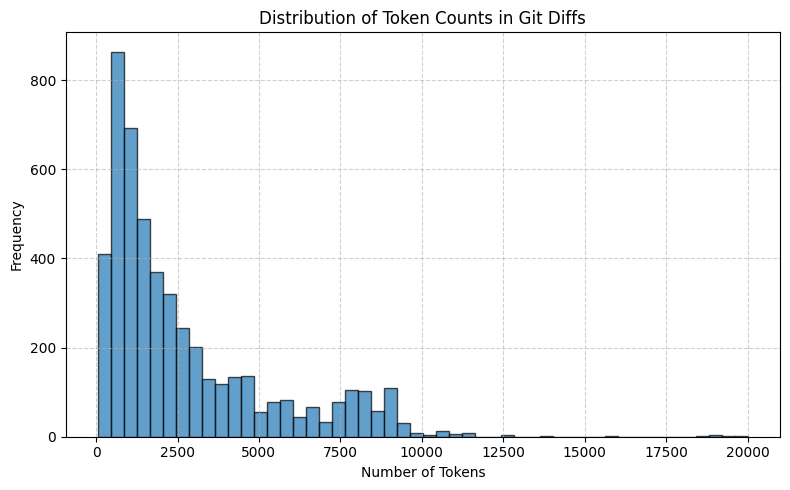

Number of entries with less than 2500 tokens: 3178


In [16]:
def plot_diff_token_distribution(df, token_count_col):
    plt.figure(figsize=(8, 5))
    plt.hist(df[token_count_col], bins=50, edgecolor='black', alpha=0.7)
    plt.xlabel("Number of Tokens")
    plt.ylabel("Frequency")
    plt.title("Distribution of Token Counts in Git Diffs")
    plt.grid(True, linestyle="--", alpha=0.6)
    plt.tight_layout()
    plt.show()

plot_diff_token_distribution(df, "Diff_patch_num_tokens")
# Number of enties with less than 5K tokens
print(
    f"Number of entries with less than {MAX_NUM_DIFF_TOKENS} tokens:",
    ((df["Diff_patch_num_tokens"] < MAX_NUM_DIFF_TOKENS) & (df["Diff_patch_num_tokens"] > 0)).sum()
)

In [17]:
client = OpenAI(
    base_url="http://demo-gpu-server02:8001/v1",
    api_key="-",
)

model_name = client.models.list().data[0].id
print(model_name)

/models/GLM-4.5-Air


In [18]:
def build_sft_dataset_batched(
    df,
    student_system_prompt,
    teacher_system_prompt,
    batch_size=1,
    save_interval=10,
    output_path=new_dataset_path
):
    # Load existing dataset if available
    if os.path.exists(output_path):
        with open(output_path, "r") as f:
            sft_dataset = json.load(f)
        processed_indices = set(range(len(sft_dataset)))
        print(f"[Resume] Loaded {len(sft_dataset)} existing entries.")
    else:
        sft_dataset = []
        processed_indices = set()
        print("[Start] No existing dataset found. Starting fresh.")

    # filter out entries with large diffs
    df = df[df["Diff_patch_num_tokens"] < MAX_NUM_DIFF_TOKENS]
    print(f"[Filter] {len(df)} entries after filtering by diff size.")
    # Select relevant columns and reset index
    entries = df[["Diff_patch", "Faulty Code", "Fault Free Code", "Fixed_Method"]].dropna().reset_index(drop=True)

    def batch_query_teacher(batch_inputs):
        # Only one input at a time supported
        item = batch_inputs[0]
        response = client.chat.completions.create(
            model=model_name,
            temperature=0.1,
            extra_body={"chat_template_kwargs": {"enable_thinking": False}},
            messages=[
                {"role": "system", "content": teacher_system_prompt},
                {"role": "user", "content": json.dumps({
                    "git_patch": item["diff_patch"],
                    "target_function_diff": item["target_function_diff"]
                })}
            ],
        )
        return [response.choices[0].message.content]

    # Begin batched processing
    for batch_start in tqdm(range(0, len(entries), batch_size)):
        if batch_start in processed_indices:
            continue

        batch_df = entries.iloc[batch_start:batch_start + batch_size]
        # add the diff patch from the diffs_dict
        batch_df["target_function_diff"] = list(diffs_dict[batch_start].values())[0]
        
        batch_inputs = []
        for _, row in batch_df.iterrows():
            batch_inputs.append({
                "diff_patch": normalize_code_string(row["Diff_patch"]),
                "target_function_diff": normalize_code_string(row["target_function_diff"]),
                "faulty_code": normalize_code_string(row["Faulty Code"]),
                "fault_free_code": normalize_code_string(row["Fault Free Code"]),
            })

        try:
            teacher_outputs = batch_query_teacher(batch_inputs)
            for i, teacher_output in enumerate(teacher_outputs):

                student_input = {
                    "context_diff": normalize_code_string(teacher_output),
                    "buggy_function_code": batch_inputs[i]['faulty_code']
                }

                sft_entry = {
                    "prompt": [
                        {"role": "system", "content": student_system_prompt},
                        {"role": "user", "content": student_input}
                    ],
                    "completion": [
                        {"role": "assistant", "content": batch_inputs[i]["fault_free_code"]}
                    ]
                }

                sft_dataset.append(sft_entry)

        except Exception as e:
            print(f"[Error] Batch index {batch_start} failed: {e}")
            continue

        # Save every `save_interval` batches
        if ((batch_start // batch_size) + 1) % save_interval == 0:
            with open(output_path, "w") as f:
                json.dump(sft_dataset, f, indent=2)
            # print(f"[Checkpoint] Saved {len(sft_dataset)} entries at index {batch_start + batch_size}")

    # Final save
    with open(output_path, "w") as f:
        json.dump(sft_dataset, f, indent=2)
    print(f"[Complete] Final dataset saved: {len(sft_dataset)} entries to {output_path}")

    return sft_dataset

In [19]:
build_sft_dataset_batched(df,
                          STUDENT_SYSTEM_PROMPT,
                          TEACHER_SYSTEM_PROMPT,
                          save_interval=1
                          )


[Resume] Loaded 10 existing entries.
[Filter] 3178 entries after filtering by diff size.


  0%|                                                                                              | 0/3178 [00:00<?, ?it/s]

  0%|▎                                                                                  | 11/3178 [00:23<1:54:06,  2.16s/it]

  0%|▎                                                                                  | 12/3178 [00:35<2:52:59,  3.28s/it]

  0%|▎                                                                                  | 13/3178 [01:04<5:59:28,  6.81s/it]

  0%|▎                                                                                  | 14/3178 [01:32<9:14:00, 10.51s/it]

  0%|▍                                                                                 | 15/3178 [01:49<10:21:13, 11.78s/it]

  1%|▍                                                                                  | 16/3178 [01:59<9:56:54, 11.33s/it]

  1%|▍                                                                                 | 17/3178 [02:28<13:33:46, 15.45s/it]

  1%|▍                                                                                 | 18/3178 [02:52<15:24:57, 17.56s/it]

  1%|▍                                                                                 | 19/3178 [03:15<16:48:22, 19.15s/it]

  1%|▌                                                                                 | 20/3178 [03:44<19:06:09, 21.78s/it]

  1%|▌                                                                                 | 21/3178 [03:59<17:25:12, 19.86s/it]

  1%|▌                                                                                 | 22/3178 [04:08<14:39:29, 16.72s/it]

  1%|▌                                                                                 | 23/3178 [04:21<13:43:42, 15.66s/it]

  1%|▌                                                                                 | 24/3178 [04:28<11:34:24, 13.21s/it]

  1%|▋                                                                                  | 25/3178 [04:35<9:55:44, 11.34s/it]

  1%|▋                                                                                  | 26/3178 [04:40<8:10:01,  9.33s/it]

  1%|▋                                                                                  | 27/3178 [04:47<7:38:50,  8.74s/it]

  1%|▋                                                                                  | 28/3178 [04:54<7:16:28,  8.31s/it]

  1%|▊                                                                                  | 29/3178 [05:02<6:59:42,  8.00s/it]

  1%|▊                                                                                  | 30/3178 [05:10<7:05:34,  8.11s/it]

  1%|▊                                                                                  | 31/3178 [05:16<6:31:53,  7.47s/it]

  1%|▊                                                                                  | 32/3178 [05:25<6:51:55,  7.86s/it]

  1%|▊                                                                                  | 33/3178 [05:41<9:00:40, 10.32s/it]

  1%|▉                                                                                 | 34/3178 [05:57<10:40:16, 12.22s/it]

  1%|▉                                                                                 | 35/3178 [06:16<12:14:13, 14.02s/it]

  1%|▉                                                                                 | 36/3178 [06:34<13:24:30, 15.36s/it]

  1%|▉                                                                                 | 37/3178 [06:52<14:08:33, 16.21s/it]

  1%|▉                                                                                 | 38/3178 [07:04<12:51:59, 14.75s/it]

  1%|█                                                                                 | 39/3178 [07:25<14:35:57, 16.74s/it]

  1%|█                                                                                 | 40/3178 [07:30<11:24:55, 13.10s/it]

  1%|█                                                                                  | 41/3178 [07:35<9:17:19, 10.66s/it]

  1%|█                                                                                  | 42/3178 [07:45<9:12:09, 10.56s/it]

  1%|█                                                                                 | 43/3178 [08:02<10:59:05, 12.61s/it]

  1%|█▏                                                                                | 44/3178 [08:15<11:04:03, 12.71s/it]

  1%|█▏                                                                                | 45/3178 [08:29<11:24:29, 13.11s/it]

  1%|█▏                                                                                | 46/3178 [08:45<12:09:26, 13.97s/it]

  1%|█▏                                                                                | 47/3178 [09:08<14:21:36, 16.51s/it]

  2%|█▏                                                                                | 48/3178 [09:36<17:19:48, 19.93s/it]

  2%|█▎                                                                                | 49/3178 [09:51<16:07:01, 18.54s/it]

  2%|█▎                                                                                | 50/3178 [10:09<16:03:09, 18.47s/it]

  2%|█▎                                                                                | 51/3178 [10:19<13:50:40, 15.94s/it]

  2%|█▎                                                                                | 52/3178 [10:52<18:06:04, 20.85s/it]

  2%|█▎                                                                                | 53/3178 [11:07<16:42:45, 19.25s/it]

  2%|█▍                                                                                | 54/3178 [11:32<18:03:50, 20.82s/it]

  2%|█▍                                                                                | 55/3178 [11:37<14:09:05, 16.31s/it]

  2%|█▍                                                                                | 56/3178 [11:41<10:50:48, 12.51s/it]

  2%|█▍                                                                                | 57/3178 [11:53<10:46:32, 12.43s/it]

  2%|█▍                                                                                | 58/3178 [12:04<10:25:31, 12.03s/it]

  2%|█▌                                                                                | 59/3178 [12:24<12:21:50, 14.27s/it]

  2%|█▌                                                                                | 60/3178 [12:38<12:24:50, 14.33s/it]

  2%|█▌                                                                                | 61/3178 [12:57<13:35:39, 15.70s/it]

  2%|█▌                                                                                | 62/3178 [13:05<11:32:19, 13.33s/it]

  2%|█▋                                                                                | 63/3178 [13:17<11:15:32, 13.01s/it]

  2%|█▋                                                                                | 64/3178 [13:38<13:13:02, 15.28s/it]

  2%|█▋                                                                                | 65/3178 [13:58<14:33:16, 16.83s/it]

  2%|█▋                                                                                | 66/3178 [14:22<16:19:28, 18.88s/it]

  2%|█▋                                                                                | 67/3178 [14:34<14:30:42, 16.79s/it]

  2%|█▊                                                                                | 68/3178 [14:50<14:14:13, 16.48s/it]

  2%|█▊                                                                                | 69/3178 [15:13<16:03:39, 18.60s/it]

  2%|█▊                                                                                | 70/3178 [15:18<12:33:39, 14.55s/it]

  2%|█▊                                                                                | 71/3178 [15:29<11:38:18, 13.49s/it]

  2%|█▊                                                                                | 72/3178 [15:38<10:28:06, 12.13s/it]

  2%|█▉                                                                                | 73/3178 [15:55<11:44:42, 13.62s/it]

  2%|█▉                                                                                | 74/3178 [16:18<13:56:54, 16.18s/it]

  2%|█▉                                                                                | 75/3178 [16:32<13:21:38, 15.50s/it]

  2%|█▉                                                                                | 76/3178 [16:46<12:59:18, 15.07s/it]

  2%|█▉                                                                                | 77/3178 [16:59<12:26:29, 14.44s/it]

  2%|██                                                                                | 78/3178 [17:07<10:48:21, 12.55s/it]

  2%|██                                                                                | 79/3178 [17:24<12:06:31, 14.07s/it]

  3%|██                                                                                | 80/3178 [17:48<14:42:49, 17.10s/it]

  3%|██                                                                                | 81/3178 [18:15<17:02:42, 19.81s/it]

  3%|██                                                                                | 82/3178 [18:39<18:08:04, 21.09s/it]

  3%|██▏                                                                               | 83/3178 [18:47<14:42:38, 17.11s/it]

  3%|██▏                                                                               | 84/3178 [19:02<14:21:53, 16.71s/it]

  3%|██▏                                                                               | 85/3178 [19:23<15:19:09, 17.83s/it]

  3%|██▏                                                                               | 86/3178 [19:36<14:09:31, 16.48s/it]

  3%|██▏                                                                               | 87/3178 [19:43<11:37:48, 13.55s/it]

  3%|██▎                                                                               | 88/3178 [20:05<13:48:40, 16.09s/it]

  3%|██▎                                                                               | 89/3178 [20:33<16:47:50, 19.58s/it]

  3%|██▎                                                                               | 90/3178 [20:57<17:56:25, 20.91s/it]

  3%|██▎                                                                               | 91/3178 [21:04<14:27:25, 16.86s/it]

  3%|██▎                                                                               | 92/3178 [21:14<12:36:44, 14.71s/it]

  3%|██▍                                                                               | 93/3178 [21:25<11:47:15, 13.76s/it]

  3%|██▍                                                                               | 94/3178 [21:39<11:52:17, 13.86s/it]

  3%|██▍                                                                               | 95/3178 [22:07<15:30:26, 18.11s/it]

  3%|██▍                                                                               | 96/3178 [22:15<12:48:27, 14.96s/it]

  3%|██▌                                                                               | 97/3178 [22:31<13:02:32, 15.24s/it]

  3%|██▌                                                                               | 98/3178 [22:43<12:17:13, 14.36s/it]

  3%|██▌                                                                               | 99/3178 [23:05<14:14:41, 16.66s/it]

  3%|██▌                                                                              | 100/3178 [23:26<15:20:35, 17.95s/it]

  3%|██▌                                                                              | 101/3178 [23:33<12:29:40, 14.62s/it]

  3%|██▌                                                                              | 102/3178 [23:59<15:23:19, 18.01s/it]

  3%|██▋                                                                              | 103/3178 [24:15<14:57:56, 17.52s/it]

  3%|██▋                                                                              | 104/3178 [24:25<13:01:44, 15.26s/it]

  3%|██▋                                                                              | 105/3178 [24:33<11:08:24, 13.05s/it]

  3%|██▋                                                                              | 106/3178 [24:47<11:28:29, 13.45s/it]

  3%|██▋                                                                              | 107/3178 [25:08<13:21:26, 15.66s/it]

  3%|██▊                                                                              | 108/3178 [25:17<11:34:19, 13.57s/it]

  3%|██▊                                                                              | 109/3178 [25:36<12:58:54, 15.23s/it]

  3%|██▊                                                                              | 110/3178 [25:44<11:06:51, 13.04s/it]

  3%|██▊                                                                              | 111/3178 [25:59<11:39:59, 13.69s/it]

  4%|██▊                                                                              | 112/3178 [26:22<14:00:56, 16.46s/it]

  4%|██▉                                                                              | 113/3178 [26:41<14:44:18, 17.31s/it]

  4%|██▉                                                                              | 114/3178 [26:59<14:50:02, 17.43s/it]

  4%|██▉                                                                              | 115/3178 [27:32<18:43:45, 22.01s/it]

  4%|██▉                                                                              | 116/3178 [27:40<15:04:17, 17.72s/it]

  4%|██▉                                                                              | 117/3178 [27:54<14:09:24, 16.65s/it]

  4%|███                                                                              | 118/3178 [28:04<12:34:35, 14.80s/it]

  4%|███                                                                              | 119/3178 [28:14<11:13:34, 13.21s/it]

  4%|███                                                                              | 120/3178 [28:44<15:37:43, 18.40s/it]

  4%|███                                                                              | 121/3178 [29:14<18:35:19, 21.89s/it]

  4%|███                                                                              | 122/3178 [29:27<16:16:28, 19.17s/it]

  4%|███▏                                                                             | 123/3178 [29:36<13:38:29, 16.08s/it]

  4%|███▏                                                                             | 124/3178 [29:45<11:46:16, 13.88s/it]

  4%|███▏                                                                             | 125/3178 [29:54<10:32:43, 12.43s/it]

  4%|███▏                                                                             | 126/3178 [30:18<13:26:47, 15.86s/it]

  4%|███▏                                                                             | 127/3178 [30:37<14:13:47, 16.79s/it]

  4%|███▎                                                                             | 128/3178 [30:39<10:41:14, 12.61s/it]

  4%|███▎                                                                             | 129/3178 [31:09<14:58:28, 17.68s/it]

  4%|███▎                                                                             | 130/3178 [31:36<17:22:10, 20.52s/it]

  4%|███▎                                                                             | 131/3178 [31:52<16:08:30, 19.07s/it]

  4%|███▎                                                                             | 132/3178 [32:18<18:04:42, 21.37s/it]

  4%|███▍                                                                             | 133/3178 [32:39<17:49:55, 21.08s/it]

  4%|███▍                                                                             | 134/3178 [33:07<19:28:32, 23.03s/it]

  4%|███▍                                                                             | 135/3178 [33:24<18:01:04, 21.32s/it]

  4%|███▍                                                                             | 136/3178 [33:47<18:32:59, 21.95s/it]

  4%|███▍                                                                             | 137/3178 [33:56<15:05:52, 17.87s/it]

  4%|███▌                                                                             | 138/3178 [33:59<11:30:42, 13.63s/it]

  4%|███▌                                                                             | 139/3178 [34:19<12:56:20, 15.33s/it]

  4%|███▌                                                                             | 140/3178 [34:35<13:08:28, 15.57s/it]

  4%|███▌                                                                             | 141/3178 [34:50<13:03:50, 15.49s/it]

  4%|███▌                                                                             | 142/3178 [34:57<10:53:07, 12.91s/it]

  4%|███▋                                                                             | 143/3178 [35:13<11:36:00, 13.76s/it]

  5%|███▋                                                                             | 144/3178 [35:32<12:59:15, 15.41s/it]

  5%|███▋                                                                             | 145/3178 [35:39<10:46:32, 12.79s/it]

  5%|███▊                                                                              | 146/3178 [35:45<9:09:50, 10.88s/it]

  5%|███▋                                                                             | 147/3178 [36:03<10:54:36, 12.96s/it]

  5%|███▊                                                                             | 148/3178 [36:13<10:15:29, 12.19s/it]

  5%|███▊                                                                             | 149/3178 [36:25<10:06:01, 12.00s/it]

  5%|███▊                                                                             | 150/3178 [36:49<13:04:56, 15.55s/it]

  5%|███▊                                                                             | 151/3178 [37:13<15:15:09, 18.14s/it]

  5%|███▊                                                                             | 152/3178 [37:33<15:44:45, 18.73s/it]

  5%|███▉                                                                             | 153/3178 [37:49<15:08:48, 18.03s/it]

  5%|███▉                                                                             | 154/3178 [38:22<18:43:34, 22.29s/it]

  5%|███▉                                                                             | 155/3178 [38:54<21:09:38, 25.20s/it]

  5%|███▉                                                                             | 156/3178 [38:59<16:09:39, 19.25s/it]

  5%|████                                                                             | 157/3178 [39:25<17:52:12, 21.30s/it]

  5%|████                                                                             | 158/3178 [39:42<16:54:31, 20.16s/it]

  5%|████                                                                             | 159/3178 [40:00<16:14:15, 19.36s/it]

  5%|████                                                                             | 160/3178 [40:30<18:50:45, 22.48s/it]

  5%|████                                                                             | 161/3178 [40:58<20:09:51, 24.06s/it]

  5%|████▏                                                                            | 162/3178 [41:09<17:02:46, 20.35s/it]

  5%|████▏                                                                            | 163/3178 [41:19<14:29:20, 17.30s/it]

  5%|████▏                                                                            | 164/3178 [41:50<17:52:32, 21.35s/it]

  5%|████▏                                                                            | 165/3178 [42:02<15:34:51, 18.62s/it]

  5%|████▏                                                                            | 166/3178 [42:12<13:19:11, 15.92s/it]

  5%|████▎                                                                            | 167/3178 [42:35<15:00:07, 17.94s/it]

  5%|████▎                                                                            | 168/3178 [42:47<13:33:34, 16.22s/it]

  5%|████▎                                                                            | 169/3178 [43:02<13:11:24, 15.78s/it]

  5%|████▎                                                                            | 170/3178 [43:25<15:09:41, 18.15s/it]

  5%|████▎                                                                            | 171/3178 [43:50<16:46:59, 20.09s/it]

  5%|████▍                                                                            | 172/3178 [43:57<13:29:28, 16.16s/it]

  5%|████▍                                                                            | 173/3178 [44:21<15:25:01, 18.47s/it]

  5%|████▍                                                                            | 174/3178 [44:32<13:37:53, 16.34s/it]

  6%|████▍                                                                            | 175/3178 [45:04<17:35:21, 21.09s/it]

  6%|████▍                                                                            | 176/3178 [45:17<15:28:16, 18.55s/it]

  6%|████▌                                                                            | 177/3178 [45:39<16:25:35, 19.71s/it]

  6%|████▌                                                                            | 178/3178 [45:54<15:02:43, 18.05s/it]

  6%|████▌                                                                            | 179/3178 [46:00<12:09:16, 14.59s/it]

  6%|████▌                                                                            | 180/3178 [46:20<13:28:35, 16.18s/it]

  6%|████▌                                                                            | 181/3178 [46:37<13:41:28, 16.45s/it]

  6%|████▋                                                                            | 182/3178 [47:02<15:42:02, 18.87s/it]

  6%|████▋                                                                            | 183/3178 [47:09<12:56:11, 15.55s/it]

  6%|████▋                                                                            | 184/3178 [47:23<12:31:52, 15.07s/it]

  6%|████▋                                                                            | 185/3178 [47:38<12:33:01, 15.10s/it]

  6%|████▋                                                                            | 186/3178 [47:54<12:42:51, 15.30s/it]

  6%|████▊                                                                            | 187/3178 [48:25<16:27:20, 19.81s/it]

  6%|████▊                                                                            | 188/3178 [48:55<18:59:52, 22.87s/it]

  6%|████▊                                                                            | 189/3178 [49:05<15:54:57, 19.17s/it]

  6%|████▊                                                                            | 190/3178 [49:24<15:50:39, 19.09s/it]

  6%|████▊                                                                            | 191/3178 [49:32<13:10:53, 15.89s/it]

  6%|████▉                                                                            | 192/3178 [49:42<11:29:44, 13.86s/it]

  6%|████▉                                                                            | 193/3178 [49:57<11:47:39, 14.22s/it]

  6%|█████                                                                             | 194/3178 [49:59<8:49:24, 10.64s/it]

  6%|█████                                                                             | 195/3178 [50:02<6:56:00,  8.37s/it]

  6%|█████                                                                             | 196/3178 [50:10<6:53:28,  8.32s/it]

  6%|█████                                                                             | 197/3178 [50:27<9:01:47, 10.91s/it]

  6%|█████                                                                             | 198/3178 [50:39<9:15:28, 11.18s/it]

  6%|█████                                                                            | 199/3178 [51:06<13:15:15, 16.02s/it]

  6%|█████                                                                            | 200/3178 [51:17<11:55:13, 14.41s/it]

  6%|█████                                                                            | 201/3178 [51:25<10:18:25, 12.46s/it]

  6%|█████▏                                                                           | 202/3178 [51:44<11:57:25, 14.46s/it]

  6%|█████▏                                                                           | 203/3178 [51:58<11:56:46, 14.46s/it]

  6%|█████▏                                                                           | 204/3178 [52:19<13:30:25, 16.35s/it]

  6%|█████▏                                                                           | 205/3178 [52:38<14:00:25, 16.96s/it]

  6%|█████▎                                                                           | 206/3178 [52:56<14:18:42, 17.34s/it]

  7%|█████▎                                                                           | 207/3178 [53:08<13:00:08, 15.76s/it]

  7%|█████▎                                                                           | 208/3178 [53:12<10:13:42, 12.40s/it]

  7%|█████▍                                                                            | 209/3178 [53:20<9:05:40, 11.03s/it]

  7%|█████▍                                                                            | 210/3178 [53:35<9:55:30, 12.04s/it]

  7%|█████▍                                                                           | 211/3178 [53:47<10:03:45, 12.21s/it]

  7%|█████▍                                                                           | 212/3178 [54:19<14:59:27, 18.20s/it]

  7%|█████▍                                                                           | 213/3178 [54:48<17:33:48, 21.33s/it]

  7%|█████▍                                                                           | 214/3178 [54:53<13:35:22, 16.51s/it]

  7%|█████▍                                                                           | 215/3178 [55:18<15:32:46, 18.89s/it]

  7%|█████▌                                                                           | 216/3178 [55:38<15:52:03, 19.29s/it]

  7%|█████▌                                                                           | 217/3178 [55:51<14:18:18, 17.39s/it]

  7%|█████▌                                                                           | 218/3178 [55:55<10:59:05, 13.36s/it]

  7%|█████▌                                                                           | 219/3178 [56:22<14:29:27, 17.63s/it]

  7%|█████▌                                                                           | 220/3178 [56:33<12:45:46, 15.53s/it]

  7%|█████▋                                                                           | 221/3178 [56:55<14:17:05, 17.39s/it]

  7%|█████▋                                                                           | 222/3178 [57:12<14:18:29, 17.43s/it]

  7%|█████▋                                                                           | 223/3178 [57:17<11:05:38, 13.52s/it]

  7%|█████▋                                                                           | 224/3178 [57:36<12:25:39, 15.15s/it]

  7%|█████▋                                                                           | 225/3178 [58:01<14:49:14, 18.07s/it]

  7%|█████▊                                                                           | 226/3178 [58:29<17:19:42, 21.13s/it]

  7%|█████▊                                                                           | 227/3178 [58:35<13:34:30, 16.56s/it]

  7%|█████▊                                                                           | 228/3178 [59:07<17:26:16, 21.28s/it]

  7%|█████▊                                                                           | 229/3178 [59:17<14:39:08, 17.89s/it]

  7%|█████▊                                                                           | 230/3178 [59:30<13:25:45, 16.40s/it]

  7%|█████▉                                                                           | 231/3178 [59:57<16:01:21, 19.57s/it]

  7%|█████▊                                                                         | 232/3178 [1:00:11<14:40:00, 17.92s/it]

  7%|█████▊                                                                         | 233/3178 [1:00:27<14:11:07, 17.34s/it]

  7%|█████▊                                                                         | 234/3178 [1:00:51<15:46:22, 19.29s/it]

  7%|█████▊                                                                         | 235/3178 [1:01:11<16:05:24, 19.68s/it]

  7%|█████▊                                                                         | 236/3178 [1:01:43<19:03:42, 23.33s/it]

  7%|█████▉                                                                         | 237/3178 [1:01:57<16:35:34, 20.31s/it]

  7%|█████▉                                                                         | 238/3178 [1:02:11<15:04:10, 18.45s/it]

  8%|█████▉                                                                         | 239/3178 [1:02:17<12:03:59, 14.78s/it]

  8%|██████                                                                          | 240/3178 [1:02:23<9:59:45, 12.25s/it]

  8%|██████                                                                          | 241/3178 [1:02:28<8:05:27,  9.92s/it]

  8%|██████                                                                         | 242/3178 [1:03:00<13:32:50, 16.61s/it]

  8%|██████                                                                         | 243/3178 [1:03:20<14:31:02, 17.81s/it]

  8%|██████                                                                         | 244/3178 [1:03:30<12:27:56, 15.30s/it]

  8%|██████                                                                         | 245/3178 [1:03:55<14:58:23, 18.38s/it]

  8%|██████                                                                         | 246/3178 [1:04:17<15:37:50, 19.19s/it]

  8%|██████▏                                                                        | 247/3178 [1:04:25<13:03:45, 16.04s/it]

  8%|██████▏                                                                        | 248/3178 [1:04:33<10:59:33, 13.51s/it]

  8%|██████▎                                                                         | 249/3178 [1:04:41<9:42:18, 11.93s/it]

  8%|██████▏                                                                        | 250/3178 [1:05:01<11:38:16, 14.31s/it]

  8%|██████▎                                                                         | 251/3178 [1:05:07<9:32:37, 11.74s/it]

  8%|██████▎                                                                         | 252/3178 [1:05:14<8:27:48, 10.41s/it]

  8%|██████▎                                                                        | 253/3178 [1:05:44<13:09:24, 16.19s/it]

  8%|██████▎                                                                        | 254/3178 [1:06:13<16:27:28, 20.26s/it]

  8%|██████▎                                                                        | 255/3178 [1:06:40<18:02:24, 22.22s/it]

  8%|██████▎                                                                        | 256/3178 [1:07:07<19:08:54, 23.59s/it]

  8%|██████▍                                                                        | 257/3178 [1:07:35<20:08:50, 24.83s/it]

  8%|██████▍                                                                        | 258/3178 [1:07:54<18:48:37, 23.19s/it]

  8%|██████▍                                                                        | 259/3178 [1:08:04<15:27:22, 19.06s/it]

  8%|██████▍                                                                        | 260/3178 [1:08:31<17:21:58, 21.42s/it]

  8%|██████▍                                                                        | 261/3178 [1:08:48<16:28:51, 20.34s/it]

  8%|██████▌                                                                        | 262/3178 [1:08:57<13:35:00, 16.77s/it]

  8%|██████▌                                                                        | 263/3178 [1:09:20<15:02:35, 18.58s/it]

  8%|██████▌                                                                        | 264/3178 [1:09:44<16:27:12, 20.33s/it]

  8%|██████▌                                                                        | 265/3178 [1:10:03<16:08:07, 19.94s/it]

  8%|██████▌                                                                        | 266/3178 [1:10:23<16:12:21, 20.03s/it]

  8%|██████▋                                                                        | 267/3178 [1:10:46<16:58:10, 20.99s/it]

  8%|██████▋                                                                        | 268/3178 [1:11:16<19:09:26, 23.70s/it]

  8%|██████▋                                                                        | 269/3178 [1:11:44<20:02:38, 24.81s/it]

  8%|██████▋                                                                        | 270/3178 [1:11:47<14:53:57, 18.44s/it]

  9%|██████▋                                                                        | 271/3178 [1:11:57<12:39:48, 15.68s/it]

  9%|██████▊                                                                        | 272/3178 [1:12:24<15:25:09, 19.10s/it]

  9%|██████▊                                                                        | 273/3178 [1:12:38<14:07:43, 17.51s/it]

  9%|██████▊                                                                        | 274/3178 [1:12:55<14:01:03, 17.38s/it]

  9%|██████▊                                                                        | 275/3178 [1:13:26<17:27:54, 21.66s/it]

  9%|██████▊                                                                        | 276/3178 [1:13:54<18:48:47, 23.34s/it]

  9%|██████▉                                                                        | 277/3178 [1:14:21<19:44:54, 24.51s/it]

  9%|██████▉                                                                        | 278/3178 [1:14:48<20:21:24, 25.27s/it]

  9%|██████▉                                                                        | 279/3178 [1:15:05<18:20:24, 22.77s/it]

  9%|██████▉                                                                        | 280/3178 [1:15:22<17:00:24, 21.13s/it]

  9%|██████▉                                                                        | 281/3178 [1:15:33<14:26:51, 17.95s/it]

  9%|███████                                                                        | 282/3178 [1:15:41<12:11:17, 15.15s/it]

  9%|███████                                                                        | 283/3178 [1:15:48<10:09:22, 12.63s/it]

  9%|███████                                                                        | 284/3178 [1:16:04<10:59:34, 13.67s/it]

  9%|███████                                                                        | 285/3178 [1:16:32<14:25:50, 17.96s/it]

  9%|███████                                                                        | 286/3178 [1:16:57<16:05:32, 20.03s/it]

  9%|███████▏                                                                       | 287/3178 [1:17:10<14:21:28, 17.88s/it]

  9%|███████▏                                                                       | 288/3178 [1:17:24<13:29:07, 16.80s/it]

  9%|███████▏                                                                       | 289/3178 [1:17:29<10:41:21, 13.32s/it]

  9%|███████▎                                                                        | 290/3178 [1:17:39<9:42:14, 12.10s/it]

  9%|███████▎                                                                        | 291/3178 [1:17:43<7:58:32,  9.95s/it]

  9%|███████▎                                                                       | 292/3178 [1:18:16<13:18:09, 16.59s/it]

  9%|███████▎                                                                       | 293/3178 [1:18:30<12:43:59, 15.89s/it]

  9%|███████▎                                                                       | 294/3178 [1:18:57<15:25:46, 19.26s/it]

  9%|███████▎                                                                       | 295/3178 [1:19:14<15:00:08, 18.73s/it]

  9%|███████▎                                                                       | 296/3178 [1:19:22<12:13:34, 15.27s/it]

  9%|███████▍                                                                       | 297/3178 [1:19:29<10:23:50, 12.99s/it]

  9%|███████▌                                                                        | 298/3178 [1:19:36<8:54:46, 11.14s/it]

  9%|███████▌                                                                        | 299/3178 [1:19:43<7:49:24,  9.78s/it]

  9%|███████▍                                                                       | 300/3178 [1:20:10<11:59:49, 15.01s/it]

  9%|███████▍                                                                       | 301/3178 [1:20:20<10:46:58, 13.49s/it]

 10%|███████▌                                                                       | 302/3178 [1:20:30<10:02:33, 12.57s/it]

 10%|███████▌                                                                       | 303/3178 [1:20:55<13:03:30, 16.35s/it]

 10%|███████▎                                                                     | 304/3178 [1:50:57<440:41:22, 552.01s/it]

[Error] Batch index 303 failed: Request timed out.


 10%|███████▍                                                                     | 305/3178 [1:51:13<312:06:57, 391.10s/it]

 10%|███████▍                                                                     | 306/3178 [1:51:21<220:13:22, 276.05s/it]

 10%|███████▍                                                                     | 307/3178 [1:51:30<156:22:51, 196.09s/it]

 10%|███████▍                                                                     | 308/3178 [1:51:58<116:00:34, 145.52s/it]

 10%|███████▌                                                                      | 309/3178 [1:52:05<82:59:27, 104.14s/it]

 10%|███████▋                                                                       | 310/3178 [1:52:25<62:51:28, 78.90s/it]

 10%|███████▋                                                                       | 311/3178 [1:52:52<50:21:12, 63.23s/it]

 10%|███████▊                                                                       | 312/3178 [1:53:08<39:00:34, 49.00s/it]

 10%|███████▊                                                                       | 313/3178 [1:53:14<28:44:10, 36.11s/it]

 10%|███████▊                                                                       | 314/3178 [1:53:26<23:06:02, 29.04s/it]

 10%|███████▊                                                                       | 315/3178 [1:54:00<24:08:42, 30.36s/it]

 10%|███████▊                                                                       | 316/3178 [1:54:08<18:53:44, 23.77s/it]

 10%|███████▉                                                                       | 317/3178 [1:54:25<17:18:50, 21.79s/it]

 10%|███████▉                                                                       | 318/3178 [1:54:35<14:30:54, 18.27s/it]

 10%|███████▉                                                                       | 319/3178 [1:54:47<12:53:03, 16.22s/it]

 10%|███████▉                                                                       | 320/3178 [1:55:04<13:04:45, 16.48s/it]

 10%|███████▉                                                                       | 321/3178 [1:55:17<12:19:55, 15.54s/it]

 10%|████████                                                                       | 322/3178 [1:55:31<12:01:23, 15.16s/it]

 10%|████████                                                                       | 323/3178 [1:55:43<11:06:48, 14.01s/it]

 10%|████████                                                                       | 324/3178 [1:56:06<13:17:22, 16.76s/it]

 10%|████████                                                                       | 325/3178 [1:56:23<13:22:01, 16.87s/it]

 10%|████████                                                                       | 326/3178 [1:56:34<11:58:14, 15.11s/it]

 10%|████████▏                                                                      | 327/3178 [1:56:48<11:42:03, 14.77s/it]

 10%|████████▏                                                                      | 328/3178 [1:57:12<13:52:53, 17.53s/it]

 10%|████████▏                                                                      | 329/3178 [1:57:29<13:50:33, 17.49s/it]

 10%|████████▏                                                                      | 330/3178 [1:57:41<12:27:13, 15.74s/it]

 10%|████████▏                                                                      | 331/3178 [1:57:57<12:29:25, 15.79s/it]

 10%|████████▎                                                                      | 332/3178 [1:58:08<11:20:00, 14.34s/it]

 10%|████████▎                                                                      | 333/3178 [1:58:26<12:13:24, 15.47s/it]

 11%|████████▎                                                                      | 334/3178 [1:58:35<10:41:55, 13.54s/it]

 11%|████████▎                                                                      | 335/3178 [1:58:48<10:30:45, 13.31s/it]

 11%|████████▎                                                                      | 336/3178 [1:59:07<11:50:05, 14.99s/it]

 11%|████████▍                                                                      | 337/3178 [1:59:31<13:58:53, 17.72s/it]

 11%|████████▍                                                                      | 338/3178 [1:59:56<15:44:06, 19.95s/it]

 11%|████████▍                                                                      | 339/3178 [2:00:12<14:42:13, 18.65s/it]

 11%|████████▍                                                                      | 340/3178 [2:00:38<16:26:22, 20.85s/it]

 11%|████████▍                                                                      | 341/3178 [2:00:44<13:06:09, 16.63s/it]

 11%|████████▌                                                                      | 342/3178 [2:00:53<11:07:41, 14.13s/it]

 11%|████████▌                                                                      | 343/3178 [2:01:22<14:44:30, 18.72s/it]

 11%|████████▌                                                                      | 344/3178 [2:01:27<11:26:46, 14.54s/it]

 11%|████████▌                                                                      | 345/3178 [2:01:44<12:09:43, 15.45s/it]

 11%|████████▌                                                                      | 346/3178 [2:01:55<10:53:17, 13.84s/it]

 11%|████████▋                                                                      | 347/3178 [2:02:19<13:23:01, 17.02s/it]

 11%|████████▋                                                                      | 348/3178 [2:02:33<12:37:46, 16.07s/it]

 11%|████████▋                                                                      | 349/3178 [2:02:52<13:26:47, 17.11s/it]

 11%|████████▋                                                                      | 350/3178 [2:03:24<16:53:08, 21.50s/it]

 11%|████████▋                                                                      | 351/3178 [2:03:48<17:24:52, 22.18s/it]

 11%|████████▊                                                                      | 352/3178 [2:04:15<18:33:00, 23.63s/it]

 11%|████████▊                                                                      | 353/3178 [2:04:26<15:41:38, 20.00s/it]

 11%|████████▊                                                                      | 354/3178 [2:04:38<13:40:33, 17.43s/it]

 11%|████████▊                                                                      | 355/3178 [2:04:53<13:05:41, 16.70s/it]

 11%|████████▊                                                                      | 356/3178 [2:05:11<13:23:16, 17.08s/it]

 11%|████████▊                                                                      | 357/3178 [2:05:23<12:09:13, 15.51s/it]

 11%|████████▉                                                                      | 358/3178 [2:05:53<15:37:22, 19.94s/it]

 11%|████████▉                                                                      | 359/3178 [2:06:12<15:30:08, 19.80s/it]

 11%|████████▉                                                                      | 360/3178 [2:06:29<14:44:28, 18.83s/it]

 11%|████████▉                                                                      | 361/3178 [2:06:46<14:18:40, 18.29s/it]

 11%|████████▉                                                                      | 362/3178 [2:06:52<11:31:30, 14.73s/it]

 11%|█████████                                                                      | 363/3178 [2:07:02<10:24:13, 13.31s/it]

 11%|█████████▏                                                                      | 364/3178 [2:07:12<9:37:04, 12.30s/it]

 11%|█████████                                                                      | 365/3178 [2:07:34<11:53:29, 15.22s/it]

 12%|█████████                                                                      | 366/3178 [2:07:44<10:33:05, 13.51s/it]

 12%|█████████                                                                      | 367/3178 [2:07:56<10:13:15, 13.09s/it]

 12%|█████████▏                                                                     | 368/3178 [2:08:14<11:16:01, 14.43s/it]

 12%|█████████▏                                                                     | 369/3178 [2:08:26<10:45:04, 13.78s/it]

 12%|█████████▎                                                                      | 370/3178 [2:08:32<9:01:43, 11.58s/it]

 12%|█████████▏                                                                     | 371/3178 [2:08:53<11:04:30, 14.20s/it]

 12%|█████████▏                                                                     | 372/3178 [2:09:16<13:18:05, 17.07s/it]

 12%|█████████▎                                                                     | 373/3178 [2:09:34<13:18:51, 17.09s/it]

 12%|█████████▎                                                                     | 374/3178 [2:09:55<14:15:09, 18.30s/it]

 12%|█████████▎                                                                     | 375/3178 [2:10:02<11:46:52, 15.13s/it]

 12%|█████████▎                                                                     | 376/3178 [2:10:13<10:45:18, 13.82s/it]

 12%|█████████▍                                                                      | 377/3178 [2:10:23<9:52:58, 12.70s/it]

 12%|█████████▌                                                                      | 378/3178 [2:10:32<9:01:26, 11.60s/it]

 12%|█████████▍                                                                     | 379/3178 [2:10:57<12:07:12, 15.59s/it]

 12%|█████████▌                                                                      | 380/3178 [2:11:03<9:44:59, 12.54s/it]

 12%|█████████▍                                                                     | 381/3178 [2:11:19<10:39:10, 13.71s/it]

 12%|█████████▍                                                                     | 382/3178 [2:11:47<14:00:32, 18.04s/it]

 12%|█████████▌                                                                     | 383/3178 [2:11:54<11:20:17, 14.60s/it]

 12%|█████████▌                                                                     | 384/3178 [2:12:07<11:07:32, 14.34s/it]

 12%|█████████▌                                                                     | 385/3178 [2:12:37<14:39:26, 18.89s/it]

 12%|█████████▌                                                                     | 386/3178 [2:12:48<12:52:42, 16.61s/it]

 12%|█████████▌                                                                     | 387/3178 [2:12:56<10:47:02, 13.91s/it]

 12%|█████████▋                                                                     | 388/3178 [2:13:16<12:12:27, 15.75s/it]

 12%|█████████▊                                                                      | 389/3178 [2:13:22<9:52:13, 12.74s/it]

 12%|█████████▋                                                                     | 390/3178 [2:13:50<13:26:34, 17.36s/it]

 12%|█████████▋                                                                     | 391/3178 [2:14:23<17:00:48, 21.98s/it]

 12%|█████████▋                                                                     | 392/3178 [2:14:42<16:26:26, 21.24s/it]

 12%|█████████▊                                                                     | 393/3178 [2:15:07<17:16:07, 22.32s/it]

 12%|█████████▊                                                                     | 394/3178 [2:15:13<13:31:09, 17.48s/it]

 12%|█████████▊                                                                     | 395/3178 [2:15:26<12:22:11, 16.00s/it]

 12%|█████████▊                                                                     | 396/3178 [2:15:41<12:06:51, 15.68s/it]

 12%|█████████▊                                                                     | 397/3178 [2:15:56<12:09:11, 15.73s/it]

 13%|█████████▉                                                                     | 398/3178 [2:16:12<12:02:07, 15.59s/it]

 13%|█████████▉                                                                     | 399/3178 [2:16:23<11:05:55, 14.38s/it]

 13%|█████████▉                                                                     | 400/3178 [2:16:55<15:05:17, 19.55s/it]

 13%|█████████▉                                                                     | 401/3178 [2:17:13<14:50:01, 19.23s/it]

 13%|█████████▉                                                                     | 402/3178 [2:17:29<14:03:43, 18.24s/it]

 13%|██████████                                                                     | 403/3178 [2:17:37<11:44:11, 15.23s/it]

 13%|██████████                                                                     | 404/3178 [2:17:49<10:53:26, 14.13s/it]

 13%|██████████▏                                                                     | 405/3178 [2:17:54<8:44:38, 11.35s/it]

 13%|██████████                                                                     | 406/3178 [2:18:17<11:22:02, 14.76s/it]

 13%|██████████                                                                     | 407/3178 [2:18:26<10:12:20, 13.26s/it]

 13%|██████████▎                                                                     | 408/3178 [2:18:31<8:19:06, 10.81s/it]

 13%|██████████▎                                                                     | 409/3178 [2:18:45<8:56:29, 11.62s/it]

 13%|██████████▎                                                                     | 410/3178 [2:19:00<9:41:36, 12.61s/it]

 13%|██████████▎                                                                     | 411/3178 [2:19:10<9:09:39, 11.92s/it]

 13%|██████████▏                                                                    | 412/3178 [2:19:27<10:21:01, 13.47s/it]

 13%|██████████▎                                                                    | 413/3178 [2:19:59<14:38:05, 19.05s/it]

 13%|██████████▎                                                                    | 414/3178 [2:20:22<15:24:52, 20.08s/it]

 13%|██████████▎                                                                    | 415/3178 [2:20:31<12:48:16, 16.68s/it]

 13%|██████████▎                                                                    | 416/3178 [2:20:53<14:09:11, 18.45s/it]

 13%|██████████▎                                                                    | 417/3178 [2:21:23<16:40:25, 21.74s/it]

 13%|██████████▍                                                                    | 418/3178 [2:21:28<12:54:24, 16.84s/it]

 13%|██████████▍                                                                    | 419/3178 [2:21:41<12:05:37, 15.78s/it]

 13%|██████████▍                                                                    | 420/3178 [2:21:57<12:04:55, 15.77s/it]

 13%|██████████▍                                                                    | 421/3178 [2:22:14<12:17:09, 16.04s/it]

 13%|██████████▍                                                                    | 422/3178 [2:22:36<13:45:23, 17.97s/it]

 13%|██████████▌                                                                    | 423/3178 [2:22:58<14:43:51, 19.25s/it]

 13%|██████████▌                                                                    | 424/3178 [2:23:14<13:47:27, 18.03s/it]

 13%|██████████▌                                                                    | 425/3178 [2:23:40<15:48:51, 20.68s/it]

 13%|██████████▌                                                                    | 426/3178 [2:24:03<16:09:26, 21.14s/it]

 13%|██████████▌                                                                    | 427/3178 [2:24:26<16:40:18, 21.82s/it]

 13%|██████████▋                                                                    | 428/3178 [2:24:32<12:59:49, 17.01s/it]

 13%|██████████▋                                                                    | 429/3178 [2:24:48<12:53:19, 16.88s/it]

 14%|██████████▋                                                                    | 430/3178 [2:25:04<12:33:13, 16.45s/it]

 14%|██████████▋                                                                    | 431/3178 [2:25:22<12:59:33, 17.03s/it]

 14%|██████████▋                                                                    | 432/3178 [2:25:43<13:49:24, 18.12s/it]

 14%|██████████▊                                                                    | 433/3178 [2:26:05<14:47:28, 19.40s/it]

 14%|██████████▊                                                                    | 434/3178 [2:26:26<15:02:36, 19.74s/it]

 14%|██████████▊                                                                    | 435/3178 [2:26:31<11:36:26, 15.23s/it]

 14%|██████████▊                                                                    | 436/3178 [2:27:00<14:50:50, 19.49s/it]

 14%|██████████▊                                                                    | 437/3178 [2:27:13<13:22:04, 17.56s/it]

 14%|██████████▉                                                                    | 438/3178 [2:27:29<13:04:54, 17.19s/it]

 14%|██████████▉                                                                    | 439/3178 [2:27:52<14:23:20, 18.91s/it]

 14%|██████████▉                                                                    | 440/3178 [2:28:22<16:46:15, 22.05s/it]

 14%|██████████▉                                                                    | 441/3178 [2:28:51<18:23:03, 24.18s/it]

 14%|██████████▉                                                                    | 442/3178 [2:29:06<16:14:08, 21.36s/it]

 14%|███████████                                                                    | 443/3178 [2:29:23<15:18:54, 20.16s/it]

 14%|███████████                                                                    | 444/3178 [2:29:40<14:33:06, 19.16s/it]

 14%|███████████                                                                    | 445/3178 [2:29:57<14:05:52, 18.57s/it]

 14%|███████████                                                                    | 446/3178 [2:30:10<12:44:28, 16.79s/it]

 14%|███████████                                                                    | 447/3178 [2:30:38<15:15:29, 20.11s/it]

 14%|███████████▏                                                                   | 448/3178 [2:30:48<13:03:20, 17.22s/it]

 14%|███████████▏                                                                   | 449/3178 [2:31:14<14:57:18, 19.73s/it]

 14%|███████████▏                                                                   | 450/3178 [2:31:22<12:23:11, 16.35s/it]

 14%|███████████▏                                                                   | 451/3178 [2:31:31<10:43:42, 14.16s/it]

 14%|███████████▍                                                                    | 452/3178 [2:31:36<8:40:06, 11.45s/it]

 14%|███████████▍                                                                    | 453/3178 [2:31:52<9:38:41, 12.74s/it]

 14%|███████████▍                                                                    | 454/3178 [2:32:05<9:46:38, 12.92s/it]

 14%|███████████▎                                                                   | 455/3178 [2:32:27<11:41:39, 15.46s/it]

 14%|███████████▎                                                                   | 456/3178 [2:32:43<11:47:00, 15.58s/it]

 14%|███████████▎                                                                   | 457/3178 [2:32:54<10:51:30, 14.37s/it]

 14%|███████████▍                                                                   | 458/3178 [2:33:13<11:50:33, 15.67s/it]

 14%|███████████▍                                                                   | 459/3178 [2:33:32<12:39:03, 16.75s/it]

 14%|███████████▍                                                                   | 460/3178 [2:33:45<11:49:50, 15.67s/it]

 15%|███████████▍                                                                   | 461/3178 [2:34:06<12:57:47, 17.18s/it]

 15%|███████████▍                                                                   | 462/3178 [2:34:24<13:16:10, 17.59s/it]

 15%|███████████▌                                                                   | 463/3178 [2:34:53<15:47:59, 20.95s/it]

 15%|███████████▌                                                                   | 464/3178 [2:35:09<14:42:09, 19.50s/it]

 15%|███████████▌                                                                   | 465/3178 [2:35:25<13:53:19, 18.43s/it]

 15%|███████████▌                                                                   | 466/3178 [2:35:54<16:13:24, 21.54s/it]

 15%|███████████▌                                                                   | 467/3178 [2:36:15<16:07:00, 21.40s/it]

 15%|███████████▋                                                                   | 468/3178 [2:36:28<14:11:37, 18.86s/it]

 15%|███████████▋                                                                   | 469/3178 [2:36:35<11:33:39, 15.36s/it]

 15%|███████████▋                                                                   | 470/3178 [2:36:52<11:45:04, 15.62s/it]

 15%|███████████▋                                                                   | 471/3178 [2:37:03<10:54:58, 14.52s/it]

 15%|███████████▋                                                                   | 472/3178 [2:37:24<12:11:31, 16.22s/it]

 15%|███████████▊                                                                   | 473/3178 [2:37:54<15:17:37, 20.35s/it]

 15%|███████████▊                                                                   | 474/3178 [2:38:03<12:47:10, 17.02s/it]

 15%|███████████▊                                                                   | 475/3178 [2:38:23<13:33:30, 18.06s/it]

 15%|███████████▊                                                                   | 476/3178 [2:38:44<14:08:11, 18.83s/it]

 15%|███████████▊                                                                   | 477/3178 [2:38:49<11:03:43, 14.74s/it]

 15%|███████████▉                                                                   | 478/3178 [2:39:05<11:16:42, 15.04s/it]

 15%|████████████                                                                    | 479/3178 [2:39:11<9:21:55, 12.49s/it]

 15%|████████████                                                                    | 480/3178 [2:39:26<9:50:25, 13.13s/it]

 15%|████████████                                                                    | 481/3178 [2:39:38<9:31:11, 12.71s/it]

 15%|███████████▉                                                                   | 482/3178 [2:39:53<10:10:22, 13.58s/it]

 15%|████████████▏                                                                   | 483/3178 [2:40:01<8:53:12, 11.87s/it]

 15%|████████████▏                                                                   | 484/3178 [2:40:09<8:02:04, 10.74s/it]

 15%|████████████▏                                                                   | 485/3178 [2:40:17<7:16:54,  9.73s/it]

 15%|████████████                                                                   | 486/3178 [2:40:45<11:21:11, 15.18s/it]

 15%|████████████▎                                                                   | 487/3178 [2:40:52<9:31:57, 12.75s/it]

 15%|████████████▏                                                                  | 488/3178 [2:41:08<10:11:49, 13.65s/it]

 15%|████████████▏                                                                  | 489/3178 [2:41:23<10:39:51, 14.28s/it]

 15%|████████████▏                                                                  | 490/3178 [2:41:38<10:45:28, 14.41s/it]

 15%|████████████▏                                                                  | 491/3178 [2:41:53<10:58:02, 14.69s/it]

 15%|████████████▏                                                                  | 492/3178 [2:42:15<12:26:43, 16.68s/it]

 16%|████████████▍                                                                   | 493/3178 [2:42:16<9:05:24, 12.19s/it]

 16%|████████████▍                                                                   | 494/3178 [2:42:29<9:06:40, 12.22s/it]

 16%|████████████▍                                                                   | 495/3178 [2:42:33<7:26:49,  9.99s/it]

 16%|████████████▍                                                                   | 496/3178 [2:42:37<6:00:59,  8.08s/it]

 16%|████████████▌                                                                   | 497/3178 [2:42:43<5:30:56,  7.41s/it]

 16%|████████████▌                                                                   | 498/3178 [2:42:53<6:11:39,  8.32s/it]

 16%|████████████▍                                                                  | 499/3178 [2:43:32<12:56:43, 17.40s/it]

 16%|████████████▌                                                                   | 500/3178 [2:43:33<9:14:17, 12.42s/it]

 16%|████████████▌                                                                   | 501/3178 [2:43:45<9:10:03, 12.33s/it]

 16%|████████████▋                                                                   | 502/3178 [2:43:48<7:13:10,  9.71s/it]

 16%|████████████▋                                                                   | 503/3178 [2:44:01<7:46:13, 10.46s/it]

 16%|████████████▋                                                                   | 504/3178 [2:44:04<6:16:52,  8.46s/it]

 16%|████████████▋                                                                   | 505/3178 [2:44:06<4:40:59,  6.31s/it]

 16%|████████████▋                                                                   | 506/3178 [2:44:08<3:53:01,  5.23s/it]

 16%|████████████▊                                                                   | 507/3178 [2:44:10<3:01:04,  4.07s/it]

 16%|████████████▊                                                                   | 508/3178 [2:44:15<3:10:22,  4.28s/it]

 16%|████████████▊                                                                   | 509/3178 [2:44:17<2:41:10,  3.62s/it]

 16%|████████████▊                                                                   | 510/3178 [2:44:25<3:49:29,  5.16s/it]

 16%|████████████▊                                                                   | 511/3178 [2:44:38<5:23:13,  7.27s/it]

 16%|████████████▋                                                                  | 512/3178 [2:45:16<12:16:43, 16.58s/it]

 16%|████████████▊                                                                  | 513/3178 [2:45:28<11:18:04, 15.27s/it]

 16%|████████████▊                                                                  | 514/3178 [2:45:40<10:38:39, 14.38s/it]

 16%|████████████▉                                                                   | 515/3178 [2:45:43<7:57:46, 10.76s/it]

 16%|████████████▉                                                                   | 516/3178 [2:45:45<5:57:32,  8.06s/it]

 16%|█████████████                                                                   | 517/3178 [2:45:49<5:16:14,  7.13s/it]

 16%|█████████████                                                                   | 518/3178 [2:46:00<5:55:18,  8.01s/it]

 16%|█████████████                                                                   | 519/3178 [2:46:10<6:21:29,  8.61s/it]

 16%|█████████████                                                                   | 520/3178 [2:46:12<4:54:17,  6.64s/it]

 16%|█████████████                                                                   | 521/3178 [2:46:22<5:38:31,  7.64s/it]

 16%|█████████████▏                                                                  | 522/3178 [2:46:27<5:02:39,  6.84s/it]

 16%|█████████████▏                                                                  | 523/3178 [2:46:31<4:36:36,  6.25s/it]

 16%|█████████████▏                                                                  | 524/3178 [2:46:33<3:37:47,  4.92s/it]

 17%|█████████████▏                                                                  | 525/3178 [2:46:43<4:43:51,  6.42s/it]

 17%|█████████████▏                                                                  | 526/3178 [2:46:52<5:21:12,  7.27s/it]

 17%|█████████████▎                                                                  | 527/3178 [2:47:02<5:47:02,  7.85s/it]

 17%|█████████████▎                                                                  | 528/3178 [2:47:07<5:19:08,  7.23s/it]

 17%|█████████████▎                                                                  | 529/3178 [2:47:17<5:51:50,  7.97s/it]

 17%|█████████████▎                                                                  | 530/3178 [2:47:19<4:31:46,  6.16s/it]

 17%|█████████████▎                                                                  | 531/3178 [2:47:28<5:07:28,  6.97s/it]

 17%|█████████████▍                                                                  | 532/3178 [2:47:32<4:31:35,  6.16s/it]

 17%|█████████████▍                                                                  | 533/3178 [2:47:45<6:02:34,  8.22s/it]

 17%|█████████████▍                                                                  | 534/3178 [2:48:06<8:45:30, 11.93s/it]

 17%|█████████████▍                                                                  | 535/3178 [2:48:21<9:33:22, 13.02s/it]

 17%|█████████████▎                                                                 | 536/3178 [2:48:47<12:25:55, 16.94s/it]

 17%|█████████████▎                                                                 | 537/3178 [2:49:11<13:55:00, 18.97s/it]

 17%|█████████████▎                                                                 | 538/3178 [2:49:30<13:53:09, 18.94s/it]

 17%|█████████████▍                                                                 | 539/3178 [2:49:47<13:26:38, 18.34s/it]

 17%|█████████████▍                                                                 | 540/3178 [2:49:59<12:00:47, 16.39s/it]

 17%|█████████████▍                                                                 | 541/3178 [2:50:19<12:50:35, 17.53s/it]

 17%|█████████████▍                                                                 | 542/3178 [2:50:31<11:33:31, 15.79s/it]

 17%|█████████████▍                                                                 | 543/3178 [2:50:42<10:39:37, 14.56s/it]

 17%|█████████████▌                                                                 | 544/3178 [2:51:07<12:51:55, 17.58s/it]

 17%|█████████████▌                                                                 | 545/3178 [2:51:29<13:53:49, 19.00s/it]

 17%|█████████████▌                                                                 | 546/3178 [2:51:37<11:29:00, 15.71s/it]

 17%|█████████████▌                                                                 | 547/3178 [2:52:00<12:57:56, 17.74s/it]

 17%|█████████████▌                                                                 | 548/3178 [2:52:15<12:20:23, 16.89s/it]

 17%|█████████████▋                                                                 | 549/3178 [2:52:21<10:02:11, 13.74s/it]

 17%|█████████████▊                                                                  | 550/3178 [2:52:33<9:41:31, 13.28s/it]

 17%|█████████████▊                                                                  | 551/3178 [2:52:35<7:14:50,  9.93s/it]

 17%|█████████████▉                                                                  | 552/3178 [2:52:50<8:18:29, 11.39s/it]

 17%|█████████████▉                                                                  | 553/3178 [2:52:57<7:19:45, 10.05s/it]

 17%|█████████████▉                                                                  | 554/3178 [2:53:16<9:16:20, 12.72s/it]

 17%|█████████████▉                                                                  | 555/3178 [2:53:26<8:35:11, 11.78s/it]

 17%|█████████████▉                                                                  | 556/3178 [2:53:38<8:39:07, 11.88s/it]

 18%|██████████████                                                                  | 557/3178 [2:53:54<9:32:34, 13.11s/it]

 18%|██████████████                                                                  | 558/3178 [2:54:01<8:11:57, 11.27s/it]

 18%|█████████████▉                                                                 | 559/3178 [2:54:23<10:35:52, 14.57s/it]

 18%|██████████████                                                                  | 560/3178 [2:54:34<9:49:37, 13.51s/it]

 18%|██████████████                                                                  | 561/3178 [2:54:40<8:03:51, 11.09s/it]

 18%|██████████████▏                                                                 | 562/3178 [2:54:59<9:55:36, 13.66s/it]

 18%|█████████████▉                                                                 | 563/3178 [2:55:18<10:58:56, 15.12s/it]

 18%|██████████████▏                                                                 | 564/3178 [2:55:27<9:42:30, 13.37s/it]

 18%|██████████████▏                                                                 | 565/3178 [2:55:32<7:47:31, 10.74s/it]

 18%|██████████████▏                                                                 | 566/3178 [2:55:52<9:59:16, 13.77s/it]

 18%|██████████████▎                                                                 | 567/3178 [2:56:00<8:42:10, 12.00s/it]

 18%|██████████████▎                                                                 | 568/3178 [2:56:12<8:38:17, 11.91s/it]

 18%|██████████████▎                                                                 | 569/3178 [2:56:25<8:57:20, 12.36s/it]

 18%|██████████████▎                                                                 | 570/3178 [2:56:42<9:49:37, 13.56s/it]

 18%|██████████████▎                                                                 | 571/3178 [2:56:46<7:47:48, 10.77s/it]

 18%|██████████████▏                                                                | 572/3178 [2:57:09<10:31:03, 14.53s/it]

 18%|██████████████▏                                                                | 573/3178 [2:57:37<13:27:20, 18.60s/it]

 18%|██████████████▎                                                                | 574/3178 [2:57:49<11:51:08, 16.39s/it]

 18%|██████████████▍                                                                 | 575/3178 [2:57:55<9:37:46, 13.32s/it]

 18%|██████████████▎                                                                | 576/3178 [2:58:13<10:34:33, 14.63s/it]

 18%|██████████████▌                                                                 | 577/3178 [2:58:20<9:05:24, 12.58s/it]

 18%|██████████████▌                                                                 | 578/3178 [2:58:27<7:48:26, 10.81s/it]

 18%|██████████████▌                                                                 | 579/3178 [2:58:32<6:33:45,  9.09s/it]

 18%|██████████████▌                                                                 | 580/3178 [2:58:36<5:21:27,  7.42s/it]

 18%|██████████████▋                                                                 | 581/3178 [2:58:45<5:47:47,  8.04s/it]

 18%|██████████████▋                                                                 | 582/3178 [2:58:57<6:35:30,  9.14s/it]

 18%|██████████████▋                                                                 | 583/3178 [2:59:05<6:17:30,  8.73s/it]

 18%|██████████████▋                                                                 | 584/3178 [2:59:12<6:04:09,  8.42s/it]

 18%|██████████████▋                                                                 | 585/3178 [2:59:19<5:36:44,  7.79s/it]

 18%|██████████████▊                                                                 | 586/3178 [2:59:32<6:44:51,  9.37s/it]

 18%|██████████████▊                                                                 | 587/3178 [2:59:43<7:04:18,  9.83s/it]

 19%|██████████████▊                                                                 | 588/3178 [3:00:00<8:48:00, 12.23s/it]

 19%|██████████████▊                                                                 | 589/3178 [3:00:13<8:51:35, 12.32s/it]

 19%|██████████████▊                                                                 | 590/3178 [3:00:19<7:27:35, 10.38s/it]

 19%|██████████████▋                                                                | 591/3178 [3:00:46<11:01:25, 15.34s/it]

 19%|██████████████▋                                                                | 592/3178 [3:00:58<10:17:39, 14.33s/it]

 19%|██████████████▋                                                                | 593/3178 [3:01:13<10:32:02, 14.67s/it]

 19%|██████████████▊                                                                | 594/3178 [3:01:28<10:33:02, 14.70s/it]

 19%|██████████████▉                                                                 | 595/3178 [3:01:33<8:26:15, 11.76s/it]

 19%|███████████████                                                                 | 596/3178 [3:01:41<7:46:40, 10.84s/it]

 19%|███████████████                                                                 | 597/3178 [3:01:50<7:21:22, 10.26s/it]

 19%|███████████████                                                                 | 598/3178 [3:02:04<8:00:07, 11.17s/it]

 19%|███████████████                                                                 | 599/3178 [3:02:21<9:21:47, 13.07s/it]

 19%|███████████████                                                                 | 600/3178 [3:02:31<8:35:24, 12.00s/it]

 19%|███████████████▏                                                                | 601/3178 [3:02:44<8:52:46, 12.40s/it]

 19%|███████████████▏                                                                | 602/3178 [3:03:01<9:57:17, 13.91s/it]

 19%|██████████████▉                                                                | 603/3178 [3:03:32<13:36:24, 19.02s/it]

 19%|███████████████                                                                | 604/3178 [3:03:53<13:53:10, 19.42s/it]

 19%|███████████████                                                                | 605/3178 [3:04:07<12:44:39, 17.83s/it]

 19%|███████████████                                                                | 606/3178 [3:04:18<11:12:44, 15.69s/it]

 19%|███████████████                                                                | 607/3178 [3:04:37<12:02:21, 16.86s/it]

 19%|███████████████                                                                | 608/3178 [3:04:49<11:01:28, 15.44s/it]

 19%|███████████████▏                                                               | 609/3178 [3:05:04<10:52:46, 15.25s/it]

 19%|███████████████▏                                                               | 610/3178 [3:05:29<13:00:01, 18.22s/it]

 19%|███████████████▏                                                               | 611/3178 [3:05:35<10:19:44, 14.49s/it]

 19%|███████████████▍                                                                | 612/3178 [3:05:38<7:58:04, 11.18s/it]

 19%|███████████████▍                                                                | 613/3178 [3:05:47<7:28:15, 10.49s/it]

 19%|███████████████▍                                                                | 614/3178 [3:05:59<7:43:35, 10.85s/it]

 19%|███████████████▎                                                               | 615/3178 [3:06:23<10:28:50, 14.72s/it]

 19%|███████████████▌                                                                | 616/3178 [3:06:30<8:54:12, 12.51s/it]

 19%|███████████████▌                                                                | 617/3178 [3:06:42<8:43:45, 12.27s/it]

 19%|███████████████▌                                                                | 618/3178 [3:07:00<9:53:00, 13.90s/it]

 19%|███████████████▌                                                                | 619/3178 [3:07:11<9:26:21, 13.28s/it]

 20%|███████████████▍                                                               | 620/3178 [3:07:43<13:24:51, 18.88s/it]

 20%|███████████████▍                                                               | 621/3178 [3:07:55<11:47:41, 16.61s/it]

 20%|███████████████▍                                                               | 622/3178 [3:08:11<11:46:15, 16.58s/it]

 20%|███████████████▋                                                                | 623/3178 [3:08:16<9:11:44, 12.96s/it]

 20%|███████████████▋                                                                | 624/3178 [3:08:23<7:57:56, 11.23s/it]

 20%|███████████████▋                                                                | 625/3178 [3:08:40<9:10:19, 12.93s/it]

 20%|███████████████▌                                                               | 626/3178 [3:08:59<10:33:53, 14.90s/it]

 20%|███████████████▊                                                                | 627/3178 [3:09:08<9:19:45, 13.17s/it]

 20%|███████████████▌                                                               | 628/3178 [3:09:31<11:18:15, 15.96s/it]

 20%|███████████████▊                                                                | 629/3178 [3:09:38<9:31:14, 13.45s/it]

 20%|███████████████▊                                                                | 630/3178 [3:09:49<8:49:56, 12.48s/it]

 20%|███████████████▉                                                                | 631/3178 [3:09:59<8:24:33, 11.89s/it]

 20%|███████████████▉                                                                | 632/3178 [3:10:09<7:57:08, 11.24s/it]

 20%|███████████████▉                                                                | 633/3178 [3:10:19<7:37:57, 10.80s/it]

 20%|███████████████▉                                                                | 634/3178 [3:10:27<7:07:41, 10.09s/it]

 20%|███████████████▉                                                                | 635/3178 [3:10:44<8:33:08, 12.11s/it]

 20%|████████████████                                                                | 636/3178 [3:10:57<8:42:58, 12.34s/it]

 20%|████████████████                                                                | 637/3178 [3:11:03<7:22:01, 10.44s/it]

 20%|████████████████                                                                | 638/3178 [3:11:13<7:18:04, 10.35s/it]

 20%|████████████████                                                                | 639/3178 [3:11:32<9:12:30, 13.06s/it]

 20%|███████████████▉                                                               | 640/3178 [3:12:04<13:08:17, 18.64s/it]

 20%|███████████████▉                                                               | 641/3178 [3:12:36<15:51:54, 22.51s/it]

 20%|███████████████▉                                                               | 642/3178 [3:12:55<15:10:07, 21.53s/it]

 20%|███████████████▉                                                               | 643/3178 [3:13:26<17:18:37, 24.58s/it]

 20%|████████████████                                                               | 644/3178 [3:13:57<18:35:05, 26.40s/it]

 20%|████████████████                                                               | 645/3178 [3:14:06<14:55:21, 21.21s/it]

 20%|████████████████                                                               | 646/3178 [3:14:29<15:16:05, 21.71s/it]

 20%|████████████████                                                               | 647/3178 [3:14:40<13:00:59, 18.51s/it]

 20%|████████████████                                                               | 648/3178 [3:15:04<14:11:58, 20.20s/it]

 20%|████████████████▏                                                              | 649/3178 [3:15:18<12:44:00, 18.13s/it]

 20%|████████████████▏                                                              | 650/3178 [3:15:29<11:23:51, 16.23s/it]

 20%|████████████████▏                                                              | 651/3178 [3:15:50<12:15:46, 17.47s/it]

 21%|████████████████▏                                                              | 652/3178 [3:16:24<15:42:55, 22.40s/it]

 21%|████████████████▏                                                              | 653/3178 [3:16:49<16:20:29, 23.30s/it]

 21%|████████████████▎                                                              | 654/3178 [3:17:11<16:01:33, 22.86s/it]

 21%|████████████████▎                                                              | 655/3178 [3:17:19<12:51:03, 18.34s/it]

 21%|████████████████▎                                                              | 656/3178 [3:17:38<13:08:09, 18.75s/it]

 21%|████████████████▎                                                              | 657/3178 [3:17:46<10:51:32, 15.51s/it]

 21%|████████████████▌                                                               | 658/3178 [3:17:55<9:29:38, 13.56s/it]

 21%|████████████████▌                                                               | 659/3178 [3:18:05<8:37:10, 12.32s/it]

 21%|████████████████▌                                                               | 660/3178 [3:18:12<7:26:55, 10.65s/it]

 21%|████████████████▋                                                               | 661/3178 [3:18:24<7:53:04, 11.28s/it]

 21%|████████████████▋                                                               | 662/3178 [3:18:41<9:02:24, 12.93s/it]

 21%|████████████████▍                                                              | 663/3178 [3:19:05<11:20:10, 16.23s/it]

 21%|████████████████▌                                                              | 664/3178 [3:19:32<13:36:12, 19.48s/it]

 21%|████████████████▌                                                              | 665/3178 [3:19:52<13:44:21, 19.68s/it]

 21%|████████████████▌                                                              | 666/3178 [3:20:03<11:56:09, 17.11s/it]

 21%|████████████████▌                                                              | 667/3178 [3:20:21<12:03:26, 17.29s/it]

 21%|████████████████▌                                                              | 668/3178 [3:20:43<13:05:20, 18.77s/it]

 21%|████████████████▋                                                              | 669/3178 [3:21:00<12:39:33, 18.16s/it]

 21%|████████████████▋                                                              | 670/3178 [3:21:13<11:34:28, 16.61s/it]

 21%|████████████████▋                                                              | 671/3178 [3:21:37<13:01:51, 18.71s/it]

 21%|████████████████▋                                                              | 672/3178 [3:21:47<11:15:33, 16.17s/it]

 21%|████████████████▋                                                              | 673/3178 [3:21:58<10:10:20, 14.62s/it]

 21%|████████████████▉                                                               | 674/3178 [3:22:06<8:47:39, 12.64s/it]

 21%|████████████████▉                                                               | 675/3178 [3:22:14<7:51:59, 11.31s/it]

 21%|█████████████████                                                               | 676/3178 [3:22:30<8:49:59, 12.71s/it]

 21%|█████████████████                                                               | 677/3178 [3:22:45<9:13:23, 13.28s/it]

 21%|█████████████████                                                               | 678/3178 [3:22:55<8:38:47, 12.45s/it]

 21%|█████████████████                                                               | 679/3178 [3:23:09<8:59:26, 12.95s/it]

 21%|█████████████████                                                               | 680/3178 [3:23:19<8:13:22, 11.85s/it]

 21%|█████████████████▏                                                              | 681/3178 [3:23:29<8:00:34, 11.55s/it]

 21%|█████████████████▏                                                              | 682/3178 [3:23:41<7:55:42, 11.44s/it]

 21%|█████████████████▏                                                              | 683/3178 [3:24:01<9:50:49, 14.21s/it]

 22%|█████████████████                                                              | 684/3178 [3:24:36<14:01:09, 20.24s/it]

 22%|█████████████████                                                              | 685/3178 [3:24:44<11:35:05, 16.73s/it]

 22%|█████████████████                                                              | 686/3178 [3:25:11<13:44:39, 19.86s/it]

 22%|█████████████████                                                              | 687/3178 [3:25:25<12:30:40, 18.08s/it]

 22%|█████████████████                                                              | 688/3178 [3:25:36<10:59:47, 15.90s/it]

 22%|█████████████████▏                                                             | 689/3178 [3:25:54<11:26:38, 16.55s/it]

 22%|█████████████████▏                                                             | 690/3178 [3:26:13<11:54:41, 17.24s/it]

 22%|█████████████████▏                                                             | 691/3178 [3:26:23<10:27:58, 15.15s/it]

 22%|█████████████████▏                                                             | 692/3178 [3:26:52<13:18:40, 19.28s/it]

 22%|█████████████████▏                                                             | 693/3178 [3:27:09<12:46:51, 18.52s/it]

 22%|█████████████████▎                                                             | 694/3178 [3:27:42<15:49:49, 22.94s/it]

 22%|█████████████████▎                                                             | 695/3178 [3:27:58<14:27:32, 20.96s/it]

 22%|█████████████████▎                                                             | 696/3178 [3:28:08<12:01:39, 17.45s/it]

 22%|█████████████████▎                                                             | 697/3178 [3:28:20<10:52:07, 15.77s/it]

 22%|█████████████████▎                                                             | 698/3178 [3:28:43<12:32:47, 18.21s/it]

 22%|█████████████████▍                                                             | 699/3178 [3:28:51<10:17:56, 14.96s/it]

 22%|█████████████████▌                                                              | 700/3178 [3:28:56<8:19:00, 12.08s/it]

 22%|█████████████████▋                                                              | 701/3178 [3:29:12<8:59:06, 13.06s/it]

 22%|█████████████████▍                                                             | 702/3178 [3:29:32<10:27:40, 15.21s/it]

 22%|█████████████████▍                                                             | 703/3178 [3:30:07<14:33:36, 21.18s/it]

 22%|█████████████████▌                                                             | 704/3178 [3:30:22<13:19:44, 19.40s/it]

 22%|█████████████████▌                                                             | 705/3178 [3:30:37<12:19:26, 17.94s/it]

 22%|█████████████████▌                                                             | 706/3178 [3:31:01<13:32:39, 19.72s/it]

 22%|█████████████████▌                                                             | 707/3178 [3:31:14<12:15:14, 17.85s/it]

 22%|█████████████████▌                                                             | 708/3178 [3:31:40<13:53:47, 20.25s/it]

 22%|█████████████████▌                                                             | 709/3178 [3:32:05<14:52:30, 21.69s/it]

 22%|█████████████████▋                                                             | 710/3178 [3:32:26<14:42:33, 21.46s/it]

 22%|█████████████████▋                                                             | 711/3178 [3:32:38<12:42:10, 18.54s/it]

 22%|█████████████████▋                                                             | 712/3178 [3:32:58<13:07:10, 19.15s/it]

 22%|█████████████████▋                                                             | 713/3178 [3:33:09<11:19:52, 16.55s/it]

 22%|█████████████████▋                                                             | 714/3178 [3:33:38<13:59:33, 20.44s/it]

 22%|█████████████████▊                                                             | 715/3178 [3:33:47<11:32:16, 16.86s/it]

 23%|██████████████████                                                              | 716/3178 [3:33:55<9:45:28, 14.27s/it]

 23%|█████████████████▊                                                             | 717/3178 [3:34:24<12:52:31, 18.83s/it]

 23%|█████████████████▊                                                             | 718/3178 [3:34:40<12:10:59, 17.83s/it]

 23%|█████████████████▊                                                             | 719/3178 [3:34:56<11:51:49, 17.37s/it]

 23%|██████████████████                                                              | 720/3178 [3:35:04<9:50:51, 14.42s/it]

 23%|██████████████████▏                                                             | 721/3178 [3:35:10<8:07:31, 11.91s/it]

 23%|██████████████████▏                                                             | 722/3178 [3:35:20<7:46:50, 11.40s/it]

 23%|██████████████████▏                                                             | 723/3178 [3:35:34<8:15:44, 12.12s/it]

 23%|██████████████████▏                                                             | 724/3178 [3:35:49<8:56:00, 13.11s/it]

 23%|██████████████████                                                             | 725/3178 [3:36:13<11:07:22, 16.32s/it]

 23%|██████████████████                                                             | 726/3178 [3:36:32<11:34:43, 17.00s/it]

 23%|██████████████████                                                             | 727/3178 [3:37:02<14:24:09, 21.15s/it]

 23%|██████████████████                                                             | 728/3178 [3:37:30<15:43:44, 23.11s/it]

 23%|██████████████████                                                             | 729/3178 [3:37:39<12:44:59, 18.74s/it]

 23%|██████████████████▏                                                            | 730/3178 [3:37:52<11:44:03, 17.26s/it]

 23%|██████████████████▏                                                            | 731/3178 [3:38:14<12:37:55, 18.58s/it]

 23%|██████████████████▏                                                            | 732/3178 [3:38:49<16:02:12, 23.60s/it]

 23%|██████████████████▏                                                            | 733/3178 [3:38:57<12:47:52, 18.84s/it]

 23%|██████████████████▍                                                             | 734/3178 [3:39:00<9:26:12, 13.90s/it]

 23%|██████████████████▎                                                            | 735/3178 [3:39:19<10:31:33, 15.51s/it]

 23%|██████████████████▌                                                             | 736/3178 [3:39:29<9:27:31, 13.94s/it]

 23%|██████████████████▌                                                             | 737/3178 [3:39:45<9:47:06, 14.43s/it]

 23%|██████████████████▌                                                             | 738/3178 [3:39:56<9:04:41, 13.39s/it]

 23%|██████████████████▌                                                             | 739/3178 [3:40:01<7:23:25, 10.91s/it]

 23%|██████████████████▋                                                             | 740/3178 [3:40:15<8:09:55, 12.06s/it]

 23%|██████████████████▍                                                            | 741/3178 [3:40:38<10:18:52, 15.24s/it]

 23%|██████████████████▍                                                            | 742/3178 [3:40:55<10:38:59, 15.74s/it]

 23%|██████████████████▋                                                             | 743/3178 [3:41:02<8:50:38, 13.08s/it]

 23%|██████████████████▍                                                            | 744/3178 [3:41:35<12:55:04, 19.11s/it]

 23%|██████████████████▌                                                            | 745/3178 [3:41:42<10:28:30, 15.50s/it]

 23%|██████████████████▊                                                             | 746/3178 [3:41:50<8:51:24, 13.11s/it]

 24%|██████████████████▌                                                            | 747/3178 [3:42:12<10:39:19, 15.78s/it]

 24%|██████████████████▊                                                             | 748/3178 [3:42:23<9:42:37, 14.39s/it]

 24%|██████████████████▌                                                            | 749/3178 [3:42:52<12:39:10, 18.75s/it]

 24%|██████████████████▋                                                            | 750/3178 [3:43:20<14:27:47, 21.44s/it]

 24%|██████████████████▋                                                            | 751/3178 [3:43:26<11:21:58, 16.86s/it]

 24%|██████████████████▉                                                             | 752/3178 [3:43:34<9:37:07, 14.27s/it]

 24%|██████████████████▉                                                             | 753/3178 [3:43:50<9:53:39, 14.69s/it]

 24%|██████████████████▋                                                            | 754/3178 [3:44:15<12:06:43, 17.99s/it]

 24%|██████████████████▊                                                            | 755/3178 [3:44:27<10:52:23, 16.16s/it]

 24%|██████████████████▊                                                            | 756/3178 [3:44:44<11:00:39, 16.37s/it]

 24%|██████████████████▊                                                            | 757/3178 [3:45:01<11:05:43, 16.50s/it]

 24%|███████████████████                                                             | 758/3178 [3:45:09<9:23:33, 13.97s/it]

 24%|███████████████████                                                             | 759/3178 [3:45:19<8:30:42, 12.67s/it]

 24%|███████████████████▏                                                            | 760/3178 [3:45:24<7:02:59, 10.50s/it]

 24%|███████████████████▏                                                            | 761/3178 [3:45:40<8:12:46, 12.23s/it]

 24%|███████████████████▏                                                            | 762/3178 [3:45:56<8:54:08, 13.27s/it]

 24%|███████████████████▏                                                            | 763/3178 [3:46:09<8:49:12, 13.15s/it]

 24%|██████████████████▉                                                            | 764/3178 [3:46:37<11:55:03, 17.77s/it]

 24%|███████████████████                                                            | 765/3178 [3:47:01<13:08:36, 19.61s/it]

 24%|███████████████████                                                            | 766/3178 [3:47:09<10:43:17, 16.00s/it]

 24%|███████████████████▎                                                            | 767/3178 [3:47:21<9:52:19, 14.74s/it]

 24%|███████████████████                                                            | 768/3178 [3:47:51<12:57:25, 19.35s/it]

 24%|███████████████████                                                            | 769/3178 [3:48:14<13:48:16, 20.63s/it]

 24%|███████████████████▏                                                           | 770/3178 [3:48:23<11:23:46, 17.04s/it]

 24%|███████████████████▍                                                            | 771/3178 [3:48:29<9:06:01, 13.61s/it]

 24%|███████████████████▍                                                            | 772/3178 [3:48:40<8:34:17, 12.83s/it]

 24%|███████████████████▏                                                           | 773/3178 [3:49:07<11:29:38, 17.21s/it]

 24%|███████████████████▏                                                           | 774/3178 [3:49:24<11:30:18, 17.23s/it]

 24%|███████████████████▎                                                           | 775/3178 [3:49:35<10:08:56, 15.20s/it]

 24%|███████████████████▌                                                            | 776/3178 [3:49:42<8:27:32, 12.68s/it]

 24%|███████████████████▌                                                            | 777/3178 [3:49:49<7:22:03, 11.05s/it]

 24%|███████████████████▎                                                           | 778/3178 [3:50:21<11:32:41, 17.32s/it]

 25%|███████████████████▌                                                            | 779/3178 [3:50:29<9:42:04, 14.56s/it]

 25%|███████████████████▍                                                           | 780/3178 [3:50:59<12:45:40, 19.16s/it]

 25%|███████████████████▍                                                           | 781/3178 [3:51:18<12:49:27, 19.26s/it]

 25%|███████████████████▋                                                            | 782/3178 [3:51:21<9:26:56, 14.20s/it]

 25%|███████████████████▍                                                           | 783/3178 [3:51:46<11:36:03, 17.44s/it]

 25%|███████████████████▍                                                           | 784/3178 [3:52:15<14:00:46, 21.07s/it]

 25%|███████████████████▌                                                           | 785/3178 [3:52:31<13:03:02, 19.63s/it]

 25%|███████████████████▌                                                           | 786/3178 [3:52:48<12:30:14, 18.82s/it]

 25%|███████████████████▌                                                           | 787/3178 [3:52:56<10:20:27, 15.57s/it]

 25%|███████████████████▊                                                            | 788/3178 [3:53:02<8:15:37, 12.44s/it]

 25%|███████████████████▊                                                            | 789/3178 [3:53:13<7:57:58, 12.00s/it]

 25%|███████████████████▉                                                            | 790/3178 [3:53:19<6:56:27, 10.46s/it]

 25%|███████████████████▉                                                            | 791/3178 [3:53:31<7:12:51, 10.88s/it]

 25%|███████████████████▉                                                            | 792/3178 [3:53:33<5:27:43,  8.24s/it]

 25%|███████████████████▉                                                            | 793/3178 [3:53:50<7:04:40, 10.68s/it]

 25%|███████████████████▉                                                            | 794/3178 [3:54:11<9:08:50, 13.81s/it]

 25%|████████████████████                                                            | 795/3178 [3:54:21<8:30:20, 12.85s/it]

 25%|███████████████████▊                                                           | 796/3178 [3:54:55<12:38:34, 19.11s/it]

 25%|███████████████████▊                                                           | 797/3178 [3:55:14<12:34:18, 19.01s/it]

 25%|███████████████████▊                                                           | 798/3178 [3:55:31<12:06:08, 18.31s/it]

 25%|████████████████████                                                            | 799/3178 [3:55:37<9:46:28, 14.79s/it]

 25%|███████████████████▉                                                           | 800/3178 [3:56:05<12:19:32, 18.66s/it]

 25%|███████████████████▉                                                           | 801/3178 [3:56:24<12:26:43, 18.85s/it]

 25%|████████████████████▏                                                           | 802/3178 [3:56:30<9:54:17, 15.01s/it]

 25%|████████████████████▏                                                           | 803/3178 [3:56:34<7:43:42, 11.71s/it]

 25%|████████████████████▏                                                           | 804/3178 [3:56:45<7:31:21, 11.41s/it]

 25%|████████████████████▎                                                           | 805/3178 [3:56:59<8:00:26, 12.15s/it]

 25%|████████████████████▎                                                           | 806/3178 [3:57:09<7:39:19, 11.62s/it]

 25%|████████████████████▎                                                           | 807/3178 [3:57:20<7:28:47, 11.36s/it]

 25%|████████████████████▎                                                           | 808/3178 [3:57:30<7:16:12, 11.04s/it]

 25%|████████████████████                                                           | 809/3178 [3:58:00<10:52:38, 16.53s/it]

 25%|████████████████████▏                                                          | 810/3178 [3:58:28<13:08:43, 19.98s/it]

 26%|████████████████████▏                                                          | 811/3178 [3:58:56<14:48:06, 22.51s/it]

 26%|████████████████████▏                                                          | 812/3178 [3:59:03<11:50:03, 18.01s/it]

 26%|████████████████████▏                                                          | 813/3178 [3:59:12<10:00:50, 15.24s/it]

 26%|████████████████████▍                                                           | 814/3178 [3:59:23<9:07:27, 13.89s/it]

 26%|████████████████████▌                                                           | 815/3178 [3:59:32<8:14:36, 12.56s/it]

 26%|████████████████████▌                                                           | 816/3178 [3:59:39<7:08:41, 10.89s/it]

 26%|████████████████████▌                                                           | 817/3178 [3:59:44<5:51:34,  8.93s/it]

 26%|████████████████████▌                                                           | 818/3178 [3:59:50<5:17:12,  8.06s/it]

 26%|████████████████████▌                                                           | 819/3178 [4:00:02<6:06:02,  9.31s/it]

 26%|████████████████████▋                                                           | 820/3178 [4:00:24<8:31:32, 13.02s/it]

 26%|████████████████████▍                                                          | 821/3178 [4:00:45<10:13:32, 15.62s/it]

 26%|████████████████████▍                                                          | 822/3178 [4:01:07<11:25:33, 17.46s/it]

 26%|████████████████████▍                                                          | 823/3178 [4:01:19<10:18:47, 15.77s/it]

 26%|████████████████████▋                                                           | 824/3178 [4:01:25<8:25:15, 12.88s/it]

 26%|████████████████████▊                                                           | 825/3178 [4:01:40<8:46:58, 13.44s/it]

 26%|████████████████████▊                                                           | 826/3178 [4:01:54<8:50:26, 13.53s/it]

 26%|████████████████████▊                                                           | 827/3178 [4:02:01<7:43:01, 11.82s/it]

 26%|████████████████████▊                                                           | 828/3178 [4:02:07<6:34:09, 10.06s/it]

 26%|████████████████████▊                                                           | 829/3178 [4:02:18<6:41:46, 10.26s/it]

 26%|████████████████████▉                                                           | 830/3178 [4:02:28<6:40:45, 10.24s/it]

 26%|████████████████████▉                                                           | 831/3178 [4:02:39<6:40:42, 10.24s/it]

 26%|████████████████████▋                                                          | 832/3178 [4:03:11<11:00:23, 16.89s/it]

 26%|████████████████████▉                                                           | 833/3178 [4:03:16<8:39:07, 13.28s/it]

 26%|████████████████████▋                                                          | 834/3178 [4:03:42<11:06:30, 17.06s/it]

 26%|█████████████████████                                                           | 835/3178 [4:03:51<9:31:58, 14.65s/it]

 26%|█████████████████████                                                           | 836/3178 [4:03:56<7:36:36, 11.70s/it]

 26%|█████████████████████                                                           | 837/3178 [4:04:00<6:07:37,  9.42s/it]

 26%|█████████████████████                                                           | 838/3178 [4:04:09<6:00:57,  9.26s/it]

 26%|█████████████████████                                                           | 839/3178 [4:04:19<6:16:26,  9.66s/it]

 26%|█████████████████████▏                                                          | 840/3178 [4:04:34<7:18:07, 11.24s/it]

 26%|████████████████████▉                                                          | 841/3178 [4:05:03<10:47:50, 16.63s/it]

 26%|█████████████████████▏                                                          | 842/3178 [4:05:14<9:37:03, 14.82s/it]

 27%|████████████████████▉                                                          | 843/3178 [4:05:32<10:10:21, 15.68s/it]

 27%|████████████████████▉                                                          | 844/3178 [4:05:53<11:16:33, 17.39s/it]

 27%|█████████████████████▎                                                          | 845/3178 [4:05:55<8:13:31, 12.69s/it]

 27%|█████████████████████                                                          | 846/3178 [4:06:21<10:52:12, 16.78s/it]

 27%|█████████████████████                                                          | 847/3178 [4:06:54<14:02:52, 21.70s/it]

 27%|█████████████████████                                                          | 848/3178 [4:07:06<12:10:04, 18.80s/it]

 27%|█████████████████████                                                          | 849/3178 [4:07:22<11:29:08, 17.75s/it]

 27%|█████████████████████▏                                                         | 850/3178 [4:07:42<11:57:15, 18.49s/it]

 27%|█████████████████████▏                                                         | 851/3178 [4:07:55<11:00:05, 17.02s/it]

 27%|█████████████████████▏                                                         | 852/3178 [4:08:12<10:57:17, 16.96s/it]

 27%|█████████████████████▏                                                         | 853/3178 [4:08:25<10:13:03, 15.82s/it]

 27%|█████████████████████▏                                                         | 854/3178 [4:08:49<11:40:16, 18.08s/it]

 27%|█████████████████████▎                                                         | 855/3178 [4:09:00<10:22:54, 16.09s/it]

 27%|█████████████████████▎                                                         | 856/3178 [4:09:17<10:37:30, 16.47s/it]

 27%|█████████████████████▌                                                          | 857/3178 [4:09:30<9:54:40, 15.37s/it]

 27%|█████████████████████▌                                                          | 858/3178 [4:09:41<9:04:40, 14.09s/it]

 27%|█████████████████████▌                                                          | 859/3178 [4:09:47<7:28:22, 11.60s/it]

 27%|█████████████████████▋                                                          | 860/3178 [4:10:05<8:38:15, 13.41s/it]

 27%|█████████████████████▋                                                          | 861/3178 [4:10:17<8:26:28, 13.12s/it]

 27%|█████████████████████▋                                                          | 862/3178 [4:10:37<9:44:57, 15.15s/it]

 27%|█████████████████████▋                                                          | 863/3178 [4:10:43<7:57:42, 12.38s/it]

 27%|█████████████████████▍                                                         | 864/3178 [4:11:11<10:55:38, 17.00s/it]

 27%|█████████████████████▌                                                         | 865/3178 [4:11:28<10:55:12, 17.00s/it]

 27%|█████████████████████▊                                                          | 866/3178 [4:11:37<9:27:21, 14.72s/it]

 27%|█████████████████████▊                                                          | 867/3178 [4:11:43<7:40:43, 11.96s/it]

 27%|█████████████████████▊                                                          | 868/3178 [4:12:05<9:43:56, 15.17s/it]

 27%|█████████████████████▌                                                         | 869/3178 [4:12:22<10:03:31, 15.68s/it]

 27%|█████████████████████▉                                                          | 870/3178 [4:12:26<7:48:33, 12.18s/it]

 27%|█████████████████████▉                                                          | 871/3178 [4:12:45<8:57:44, 13.99s/it]

 27%|█████████████████████▉                                                          | 872/3178 [4:13:03<9:45:01, 15.22s/it]

 27%|█████████████████████▉                                                          | 873/3178 [4:13:16<9:26:50, 14.75s/it]

 28%|█████████████████████▋                                                         | 874/3178 [4:13:35<10:13:47, 15.98s/it]

 28%|██████████████████████                                                          | 875/3178 [4:13:40<8:05:13, 12.64s/it]

 28%|██████████████████████                                                          | 876/3178 [4:13:53<8:12:58, 12.85s/it]

 28%|██████████████████████                                                          | 877/3178 [4:14:02<7:25:17, 11.61s/it]

 28%|██████████████████████                                                          | 878/3178 [4:14:15<7:37:14, 11.93s/it]

 28%|██████████████████████▏                                                         | 879/3178 [4:14:23<6:59:34, 10.95s/it]

 28%|██████████████████████▏                                                         | 880/3178 [4:14:33<6:41:22, 10.48s/it]

 28%|██████████████████████▏                                                         | 881/3178 [4:14:45<7:05:40, 11.12s/it]

 28%|█████████████████████▉                                                         | 882/3178 [4:15:12<10:06:10, 15.84s/it]

 28%|██████████████████████▏                                                         | 883/3178 [4:15:27<9:58:25, 15.64s/it]

 28%|█████████████████████▉                                                         | 884/3178 [4:15:53<11:53:52, 18.67s/it]

 28%|█████████████████████▉                                                         | 885/3178 [4:16:11<11:48:48, 18.55s/it]

 28%|██████████████████████                                                         | 886/3178 [4:16:28<11:30:21, 18.07s/it]

 28%|██████████████████████                                                         | 887/3178 [4:16:43<10:49:31, 17.01s/it]

 28%|██████████████████████▎                                                         | 888/3178 [4:16:49<8:42:12, 13.68s/it]

 28%|██████████████████████▍                                                         | 889/3178 [4:16:55<7:19:01, 11.51s/it]

 28%|██████████████████████▍                                                         | 890/3178 [4:17:19<9:41:34, 15.25s/it]

 28%|██████████████████████▍                                                         | 891/3178 [4:17:31<8:55:59, 14.06s/it]

 28%|██████████████████████▏                                                        | 892/3178 [4:17:52<10:26:13, 16.44s/it]

 28%|██████████████████████▍                                                         | 893/3178 [4:17:58<8:20:27, 13.14s/it]

 28%|██████████████████████▌                                                         | 894/3178 [4:18:05<7:05:36, 11.18s/it]

 28%|██████████████████████▌                                                         | 895/3178 [4:18:10<6:02:22,  9.52s/it]

 28%|██████████████████████▌                                                         | 896/3178 [4:18:23<6:37:11, 10.44s/it]

 28%|██████████████████████▌                                                         | 897/3178 [4:18:35<7:00:36, 11.06s/it]

 28%|██████████████████████▌                                                         | 898/3178 [4:18:50<7:42:07, 12.16s/it]

 28%|██████████████████████▋                                                         | 899/3178 [4:19:04<8:07:47, 12.84s/it]

 28%|██████████████████████▋                                                         | 900/3178 [4:19:12<7:10:55, 11.35s/it]

 28%|██████████████████████▍                                                        | 901/3178 [4:19:44<10:59:57, 17.39s/it]

 28%|██████████████████████▍                                                        | 902/3178 [4:20:14<13:30:25, 21.36s/it]

 28%|██████████████████████▍                                                        | 903/3178 [4:20:34<13:08:39, 20.80s/it]

 28%|██████████████████████▍                                                        | 904/3178 [4:20:40<10:25:04, 16.49s/it]

 28%|██████████████████████▊                                                         | 905/3178 [4:20:47<8:38:12, 13.68s/it]

 29%|██████████████████████▊                                                         | 906/3178 [4:21:02<8:45:07, 13.87s/it]

 29%|██████████████████████▊                                                         | 907/3178 [4:21:13<8:16:26, 13.12s/it]

 29%|██████████████████████▌                                                        | 908/3178 [4:21:37<10:20:22, 16.40s/it]

 29%|██████████████████████▌                                                        | 909/3178 [4:22:03<12:11:45, 19.35s/it]

 29%|██████████████████████▌                                                        | 910/3178 [4:22:12<10:08:11, 16.09s/it]

 29%|██████████████████████▋                                                        | 911/3178 [4:22:30<10:31:00, 16.70s/it]

 29%|██████████████████████▉                                                         | 912/3178 [4:22:41<9:28:48, 15.06s/it]

 29%|██████████████████████▉                                                         | 913/3178 [4:22:48<7:49:26, 12.44s/it]

 29%|███████████████████████                                                         | 914/3178 [4:23:00<7:49:30, 12.44s/it]

 29%|███████████████████████                                                         | 915/3178 [4:23:12<7:45:25, 12.34s/it]

 29%|███████████████████████                                                         | 916/3178 [4:23:27<8:17:06, 13.19s/it]

 29%|███████████████████████                                                         | 917/3178 [4:23:47<9:26:39, 15.04s/it]

 29%|███████████████████████                                                         | 918/3178 [4:23:52<7:39:59, 12.21s/it]

 29%|███████████████████████▏                                                        | 919/3178 [4:24:00<6:53:22, 10.98s/it]

 29%|███████████████████████▏                                                        | 920/3178 [4:24:09<6:23:46, 10.20s/it]

 29%|███████████████████████▏                                                        | 921/3178 [4:24:16<5:45:40,  9.19s/it]

 29%|███████████████████████▏                                                        | 922/3178 [4:24:23<5:25:34,  8.66s/it]

 29%|███████████████████████▏                                                        | 923/3178 [4:24:30<5:08:15,  8.20s/it]

 29%|███████████████████████▎                                                        | 924/3178 [4:24:39<5:15:19,  8.39s/it]

 29%|███████████████████████▎                                                        | 925/3178 [4:25:01<7:51:16, 12.55s/it]

 29%|███████████████████████                                                        | 926/3178 [4:25:30<10:55:58, 17.48s/it]

 29%|███████████████████████                                                        | 927/3178 [4:25:56<12:23:52, 19.83s/it]

 29%|███████████████████████                                                        | 928/3178 [4:26:18<12:54:39, 20.66s/it]

 29%|███████████████████████                                                        | 929/3178 [4:26:26<10:32:27, 16.87s/it]

 29%|███████████████████████▍                                                        | 930/3178 [4:26:32<8:32:52, 13.69s/it]

 29%|███████████████████████▍                                                        | 931/3178 [4:26:40<7:26:34, 11.92s/it]

 29%|███████████████████████▍                                                        | 932/3178 [4:26:47<6:22:58, 10.23s/it]

 29%|███████████████████████▍                                                        | 933/3178 [4:26:55<5:58:45,  9.59s/it]

 29%|███████████████████████▌                                                        | 934/3178 [4:27:13<7:40:42, 12.32s/it]

 29%|███████████████████████▌                                                        | 935/3178 [4:27:28<8:12:08, 13.16s/it]

 29%|███████████████████████▎                                                       | 936/3178 [4:27:58<11:11:05, 17.96s/it]

 29%|███████████████████████▎                                                       | 937/3178 [4:28:14<10:52:45, 17.48s/it]

 30%|███████████████████████▎                                                       | 938/3178 [4:28:30<10:40:52, 17.17s/it]

 30%|███████████████████████▎                                                       | 939/3178 [4:28:50<11:04:31, 17.81s/it]

 30%|███████████████████████▋                                                        | 940/3178 [4:28:56<8:57:48, 14.42s/it]

 30%|███████████████████████▋                                                        | 941/3178 [4:29:08<8:31:11, 13.71s/it]

 30%|███████████████████████▋                                                        | 942/3178 [4:29:14<7:06:40, 11.45s/it]

 30%|███████████████████████▋                                                        | 943/3178 [4:29:30<7:50:36, 12.63s/it]

 30%|███████████████████████▊                                                        | 944/3178 [4:29:48<8:46:51, 14.15s/it]

 30%|███████████████████████▍                                                       | 945/3178 [4:30:15<11:19:06, 18.25s/it]

 30%|███████████████████████▊                                                        | 946/3178 [4:30:23<9:21:21, 15.09s/it]

 30%|███████████████████████▊                                                        | 947/3178 [4:30:32<8:16:06, 13.34s/it]

 30%|███████████████████████▊                                                        | 948/3178 [4:30:42<7:29:53, 12.10s/it]

 30%|███████████████████████▉                                                        | 949/3178 [4:30:51<7:00:00, 11.31s/it]

 30%|███████████████████████▉                                                        | 950/3178 [4:31:11<8:37:42, 13.94s/it]

 30%|███████████████████████▉                                                        | 951/3178 [4:31:32<9:59:44, 16.16s/it]

 30%|███████████████████████▋                                                       | 952/3178 [4:31:50<10:14:16, 16.56s/it]

 30%|███████████████████████▉                                                        | 953/3178 [4:31:59<8:56:17, 14.46s/it]

 30%|████████████████████████                                                        | 954/3178 [4:32:13<8:50:42, 14.32s/it]

 30%|████████████████████████                                                        | 955/3178 [4:32:25<8:21:27, 13.53s/it]

 30%|████████████████████████                                                        | 956/3178 [4:32:36<7:52:03, 12.75s/it]

 30%|████████████████████████                                                        | 957/3178 [4:32:52<8:31:37, 13.82s/it]

 30%|████████████████████████                                                        | 958/3178 [4:33:03<7:59:45, 12.97s/it]

 30%|███████████████████████▊                                                       | 959/3178 [4:33:32<10:55:40, 17.73s/it]

 30%|███████████████████████▊                                                       | 960/3178 [4:34:02<13:13:06, 21.45s/it]

 30%|███████████████████████▉                                                       | 961/3178 [4:34:18<12:10:25, 19.77s/it]

 30%|████████████████████████▏                                                       | 962/3178 [4:34:25<9:52:10, 16.03s/it]

 30%|███████████████████████▉                                                       | 963/3178 [4:34:52<11:46:02, 19.13s/it]

 30%|███████████████████████▉                                                       | 964/3178 [4:35:03<10:13:10, 16.62s/it]

 30%|████████████████████████▎                                                       | 965/3178 [4:35:09<8:21:11, 13.59s/it]

 30%|████████████████████████▎                                                       | 966/3178 [4:35:15<6:51:14, 11.15s/it]

 30%|████████████████████████▎                                                       | 967/3178 [4:35:25<6:43:00, 10.94s/it]

 30%|████████████████████████▎                                                       | 968/3178 [4:35:40<7:25:02, 12.08s/it]

 30%|████████████████████████▍                                                       | 969/3178 [4:35:46<6:20:09, 10.33s/it]

 31%|████████████████████████                                                       | 970/3178 [4:36:17<10:12:57, 16.66s/it]

 31%|████████████████████████▍                                                       | 971/3178 [4:36:30<9:22:23, 15.29s/it]

 31%|████████████████████████▍                                                       | 972/3178 [4:36:41<8:43:54, 14.25s/it]

 31%|████████████████████████▍                                                       | 973/3178 [4:36:51<7:48:43, 12.75s/it]

 31%|████████████████████████▌                                                       | 974/3178 [4:37:07<8:29:46, 13.88s/it]

 31%|████████████████████████▏                                                      | 975/3178 [4:37:39<11:51:04, 19.37s/it]

 31%|████████████████████████▎                                                      | 976/3178 [4:37:49<10:03:16, 16.44s/it]

 31%|████████████████████████▎                                                      | 977/3178 [4:38:11<11:04:14, 18.11s/it]

 31%|████████████████████████▎                                                      | 978/3178 [4:38:41<13:12:31, 21.61s/it]

 31%|████████████████████████▎                                                      | 979/3178 [4:38:51<11:02:52, 18.09s/it]

 31%|████████████████████████▋                                                       | 980/3178 [4:39:03<9:55:02, 16.24s/it]

 31%|████████████████████████▍                                                      | 981/3178 [4:39:21<10:18:38, 16.90s/it]

 31%|████████████████████████▍                                                      | 982/3178 [4:39:36<10:03:19, 16.48s/it]

 31%|████████████████████████▍                                                      | 983/3178 [4:39:53<10:06:56, 16.59s/it]

 31%|████████████████████████▊                                                       | 984/3178 [4:40:09<9:52:28, 16.20s/it]

 31%|████████████████████████▊                                                       | 985/3178 [4:40:22<9:18:20, 15.28s/it]

 31%|████████████████████████▊                                                       | 986/3178 [4:40:33<8:32:15, 14.02s/it]

 31%|████████████████████████▊                                                       | 987/3178 [4:40:47<8:31:51, 14.02s/it]

 31%|████████████████████████▊                                                       | 988/3178 [4:40:56<7:43:14, 12.69s/it]

 31%|████████████████████████▌                                                      | 989/3178 [4:41:33<12:01:14, 19.77s/it]

 31%|████████████████████████▌                                                      | 990/3178 [4:41:46<10:47:02, 17.74s/it]

 31%|████████████████████████▉                                                       | 991/3178 [4:41:55<9:12:43, 15.16s/it]

 31%|████████████████████████▉                                                       | 992/3178 [4:42:01<7:37:23, 12.55s/it]

 31%|████████████████████████▉                                                       | 993/3178 [4:42:19<8:35:25, 14.15s/it]

 31%|█████████████████████████                                                       | 994/3178 [4:42:36<9:05:14, 14.98s/it]

 31%|█████████████████████████                                                       | 995/3178 [4:42:48<8:35:54, 14.18s/it]

 31%|█████████████████████████                                                       | 996/3178 [4:42:55<7:16:33, 12.00s/it]

 31%|█████████████████████████                                                       | 997/3178 [4:43:12<8:09:13, 13.46s/it]

 31%|█████████████████████████                                                       | 998/3178 [4:43:33<9:26:39, 15.60s/it]

 31%|████████████████████████▊                                                      | 999/3178 [4:43:51<10:00:10, 16.53s/it]

 31%|████████████████████████▊                                                      | 1000/3178 [4:44:07<9:45:45, 16.14s/it]

 31%|████████████████████████▌                                                     | 1001/3178 [4:44:24<10:01:10, 16.57s/it]

 32%|████████████████████████▉                                                      | 1002/3178 [4:44:37<9:22:58, 15.52s/it]

 32%|████████████████████████▉                                                      | 1003/3178 [4:44:46<8:06:50, 13.43s/it]

 32%|████████████████████████▋                                                     | 1004/3178 [4:45:13<10:35:06, 17.53s/it]

 32%|████████████████████████▉                                                      | 1005/3178 [4:45:24<9:29:12, 15.72s/it]

 32%|█████████████████████████                                                      | 1006/3178 [4:45:30<7:37:10, 12.63s/it]

 32%|█████████████████████████                                                      | 1007/3178 [4:45:34<6:08:27, 10.18s/it]

 32%|█████████████████████████                                                      | 1008/3178 [4:45:48<6:44:49, 11.19s/it]

 32%|█████████████████████████                                                      | 1009/3178 [4:46:03<7:28:55, 12.42s/it]

 32%|█████████████████████████                                                      | 1010/3178 [4:46:28<9:45:10, 16.19s/it]

 32%|█████████████████████████▏                                                     | 1011/3178 [4:46:41<9:08:47, 15.19s/it]

 32%|████████████████████████▊                                                     | 1012/3178 [4:47:14<12:24:06, 20.61s/it]

 32%|████████████████████████▊                                                     | 1013/3178 [4:47:22<10:03:16, 16.72s/it]

 32%|█████████████████████████▏                                                     | 1014/3178 [4:47:26<7:45:29, 12.91s/it]

 32%|█████████████████████████▏                                                     | 1015/3178 [4:47:44<8:45:40, 14.58s/it]

 32%|█████████████████████████▎                                                     | 1016/3178 [4:47:48<6:48:30, 11.34s/it]

 32%|█████████████████████████▎                                                     | 1017/3178 [4:47:55<5:58:42,  9.96s/it]

 32%|█████████████████████████▎                                                     | 1018/3178 [4:48:19<8:25:39, 14.05s/it]

 32%|█████████████████████████▎                                                     | 1019/3178 [4:48:35<8:54:44, 14.86s/it]

 32%|█████████████████████████▎                                                     | 1020/3178 [4:48:43<7:41:58, 12.84s/it]

 32%|█████████████████████████                                                     | 1021/3178 [4:49:16<11:14:56, 18.77s/it]

 32%|█████████████████████████                                                     | 1022/3178 [4:49:32<10:42:23, 17.88s/it]

 32%|█████████████████████████                                                     | 1023/3178 [4:50:02<12:57:20, 21.64s/it]

 32%|█████████████████████████▏                                                    | 1024/3178 [4:50:27<13:25:58, 22.45s/it]

 32%|█████████████████████████▏                                                    | 1025/3178 [4:50:37<11:19:53, 18.95s/it]

 32%|█████████████████████████▌                                                     | 1026/3178 [4:50:45<9:17:08, 15.53s/it]

 32%|█████████████████████████▌                                                     | 1027/3178 [4:50:56<8:27:45, 14.16s/it]

 32%|█████████████████████████▌                                                     | 1028/3178 [4:51:02<6:58:22, 11.68s/it]

 32%|█████████████████████████▌                                                     | 1029/3178 [4:51:17<7:33:22, 12.66s/it]

 32%|█████████████████████████▌                                                     | 1030/3178 [4:51:23<6:21:36, 10.66s/it]

 32%|█████████████████████████▋                                                     | 1031/3178 [4:51:30<5:48:00,  9.73s/it]

 32%|█████████████████████████▋                                                     | 1032/3178 [4:51:36<5:01:00,  8.42s/it]

 33%|█████████████████████████▋                                                     | 1033/3178 [4:51:42<4:33:22,  7.65s/it]

 33%|█████████████████████████▋                                                     | 1034/3178 [4:51:48<4:21:04,  7.31s/it]

 33%|█████████████████████████▋                                                     | 1035/3178 [4:52:00<5:06:15,  8.57s/it]

 33%|█████████████████████████▊                                                     | 1036/3178 [4:52:10<5:30:11,  9.25s/it]

 33%|█████████████████████████▊                                                     | 1037/3178 [4:52:25<6:28:31, 10.89s/it]

 33%|█████████████████████████▊                                                     | 1038/3178 [4:52:38<6:54:24, 11.62s/it]

 33%|█████████████████████████▊                                                     | 1039/3178 [4:52:50<6:55:20, 11.65s/it]

 33%|█████████████████████████▊                                                     | 1040/3178 [4:52:57<6:04:20, 10.22s/it]

 33%|█████████████████████████▉                                                     | 1041/3178 [4:53:09<6:19:05, 10.64s/it]

 33%|█████████████████████████▉                                                     | 1042/3178 [4:53:19<6:19:05, 10.65s/it]

 33%|█████████████████████████▉                                                     | 1043/3178 [4:53:28<5:58:24, 10.07s/it]

 33%|█████████████████████████▉                                                     | 1044/3178 [4:53:35<5:21:09,  9.03s/it]

 33%|█████████████████████████▉                                                     | 1045/3178 [4:53:40<4:38:08,  7.82s/it]

 33%|██████████████████████████                                                     | 1046/3178 [4:54:03<7:22:18, 12.45s/it]

 33%|██████████████████████████                                                     | 1047/3178 [4:54:26<9:14:21, 15.61s/it]

 33%|██████████████████████████                                                     | 1048/3178 [4:54:36<8:19:22, 14.07s/it]

 33%|██████████████████████████                                                     | 1049/3178 [4:54:44<7:09:21, 12.10s/it]

 33%|██████████████████████████                                                     | 1050/3178 [4:55:07<9:05:05, 15.37s/it]

 33%|██████████████████████████▏                                                    | 1051/3178 [4:55:16<7:56:15, 13.43s/it]

 33%|██████████████████████████▏                                                    | 1052/3178 [4:55:26<7:26:31, 12.60s/it]

 33%|██████████████████████████▏                                                    | 1053/3178 [4:55:35<6:39:55, 11.29s/it]

 33%|██████████████████████████▏                                                    | 1054/3178 [4:55:54<8:07:45, 13.78s/it]

 33%|██████████████████████████▏                                                    | 1055/3178 [4:56:14<9:12:12, 15.61s/it]

 33%|██████████████████████████▎                                                    | 1056/3178 [4:56:32<9:32:11, 16.18s/it]

 33%|█████████████████████████▉                                                    | 1057/3178 [4:56:55<10:43:27, 18.20s/it]

 33%|██████████████████████████▎                                                    | 1058/3178 [4:57:06<9:26:34, 16.04s/it]

 33%|██████████████████████████▎                                                    | 1059/3178 [4:57:13<7:59:25, 13.58s/it]

 33%|██████████████████████████▎                                                    | 1060/3178 [4:57:19<6:36:16, 11.23s/it]

 33%|██████████████████████████▎                                                    | 1061/3178 [4:57:29<6:23:00, 10.86s/it]

 33%|██████████████████████████▍                                                    | 1062/3178 [4:57:36<5:40:04,  9.64s/it]

 33%|██████████████████████████▍                                                    | 1063/3178 [4:57:44<5:20:18,  9.09s/it]

 33%|██████████████████████████▍                                                    | 1064/3178 [4:57:50<4:55:28,  8.39s/it]

 34%|██████████████████████████▍                                                    | 1065/3178 [4:58:17<8:10:34, 13.93s/it]

 34%|██████████████████████████▏                                                   | 1066/3178 [4:58:42<10:07:51, 17.27s/it]

 34%|██████████████████████████▌                                                    | 1067/3178 [4:58:55<9:21:54, 15.97s/it]

 34%|██████████████████████████▏                                                   | 1068/3178 [4:59:22<11:13:46, 19.16s/it]

 34%|██████████████████████████▌                                                    | 1069/3178 [4:59:34<9:54:59, 16.93s/it]

 34%|██████████████████████████▎                                                   | 1070/3178 [5:00:00<11:29:57, 19.64s/it]

 34%|██████████████████████████▎                                                   | 1071/3178 [5:00:27<12:46:40, 21.83s/it]

 34%|██████████████████████████▎                                                   | 1072/3178 [5:00:55<13:55:41, 23.81s/it]

 34%|██████████████████████████▎                                                   | 1073/3178 [5:01:08<12:00:12, 20.53s/it]

 34%|██████████████████████████▋                                                    | 1074/3178 [5:01:10<8:49:21, 15.10s/it]

 34%|██████████████████████████▋                                                    | 1075/3178 [5:01:13<6:35:31, 11.28s/it]

 34%|██████████████████████████▋                                                    | 1076/3178 [5:01:15<4:57:59,  8.51s/it]

 34%|██████████████████████████▊                                                    | 1077/3178 [5:01:19<4:14:33,  7.27s/it]

 34%|██████████████████████████▊                                                    | 1078/3178 [5:01:28<4:36:22,  7.90s/it]

 34%|██████████████████████████▊                                                    | 1079/3178 [5:01:31<3:43:31,  6.39s/it]

 34%|██████████████████████████▊                                                    | 1080/3178 [5:01:43<4:42:06,  8.07s/it]

 34%|██████████████████████████▊                                                    | 1081/3178 [5:02:03<6:40:57, 11.47s/it]

 34%|██████████████████████████▉                                                    | 1082/3178 [5:02:18<7:21:28, 12.64s/it]

 34%|██████████████████████████▉                                                    | 1083/3178 [5:02:31<7:19:22, 12.58s/it]

 34%|██████████████████████████▉                                                    | 1084/3178 [5:02:35<5:55:35, 10.19s/it]

 34%|██████████████████████████▉                                                    | 1085/3178 [5:02:37<4:30:22,  7.75s/it]

 34%|██████████████████████████▉                                                    | 1086/3178 [5:02:40<3:34:06,  6.14s/it]

 34%|███████████████████████████                                                    | 1087/3178 [5:02:46<3:41:02,  6.34s/it]

 34%|███████████████████████████                                                    | 1088/3178 [5:02:55<4:07:03,  7.09s/it]

 34%|███████████████████████████                                                    | 1089/3178 [5:03:09<5:17:24,  9.12s/it]

 34%|███████████████████████████                                                    | 1090/3178 [5:03:31<7:30:41, 12.95s/it]

 34%|███████████████████████████                                                    | 1091/3178 [5:03:36<6:11:00, 10.67s/it]

 34%|███████████████████████████▏                                                   | 1092/3178 [5:03:39<4:47:15,  8.26s/it]

 34%|███████████████████████████▏                                                   | 1093/3178 [5:03:42<3:49:03,  6.59s/it]

 34%|███████████████████████████▏                                                   | 1094/3178 [5:03:45<3:14:01,  5.59s/it]

 34%|███████████████████████████▏                                                   | 1095/3178 [5:03:47<2:38:43,  4.57s/it]

 34%|███████████████████████████▏                                                   | 1096/3178 [5:03:50<2:23:58,  4.15s/it]

 35%|███████████████████████████▎                                                   | 1097/3178 [5:04:00<3:18:45,  5.73s/it]

 35%|███████████████████████████▎                                                   | 1098/3178 [5:04:02<2:42:17,  4.68s/it]

 35%|███████████████████████████▎                                                   | 1099/3178 [5:04:13<3:50:07,  6.64s/it]

 35%|███████████████████████████▎                                                   | 1100/3178 [5:04:16<3:07:30,  5.41s/it]

 35%|███████████████████████████▎                                                   | 1101/3178 [5:04:26<3:54:54,  6.79s/it]

 35%|███████████████████████████▍                                                   | 1102/3178 [5:04:28<3:07:58,  5.43s/it]

 35%|███████████████████████████▍                                                   | 1103/3178 [5:04:30<2:34:43,  4.47s/it]

 35%|███████████████████████████▍                                                   | 1104/3178 [5:04:34<2:23:04,  4.14s/it]

 35%|███████████████████████████▍                                                   | 1105/3178 [5:04:37<2:19:30,  4.04s/it]

 35%|███████████████████████████▍                                                   | 1106/3178 [5:04:44<2:48:44,  4.89s/it]

 35%|███████████████████████████▌                                                   | 1107/3178 [5:04:48<2:41:46,  4.69s/it]

 35%|███████████████████████████▌                                                   | 1108/3178 [5:04:53<2:38:51,  4.60s/it]

 35%|███████████████████████████▌                                                   | 1109/3178 [5:04:55<2:12:39,  3.85s/it]

 35%|███████████████████████████▌                                                   | 1110/3178 [5:05:05<3:20:09,  5.81s/it]

 35%|███████████████████████████▌                                                   | 1111/3178 [5:05:15<4:02:34,  7.04s/it]

 35%|███████████████████████████▋                                                   | 1112/3178 [5:05:23<4:13:34,  7.36s/it]

 35%|███████████████████████████▋                                                   | 1113/3178 [5:05:47<7:02:43, 12.28s/it]

 35%|███████████████████████████▎                                                  | 1114/3178 [5:06:20<10:32:51, 18.40s/it]

 35%|███████████████████████████▎                                                  | 1115/3178 [5:06:35<10:04:20, 17.58s/it]

 35%|███████████████████████████▍                                                  | 1116/3178 [5:07:02<11:33:28, 20.18s/it]

 35%|███████████████████████████▊                                                   | 1117/3178 [5:07:12<9:55:38, 17.34s/it]

 35%|███████████████████████████▊                                                   | 1118/3178 [5:07:18<7:59:12, 13.96s/it]

 35%|███████████████████████████▊                                                   | 1119/3178 [5:07:24<6:36:54, 11.57s/it]

 35%|███████████████████████████▊                                                   | 1120/3178 [5:07:38<6:59:47, 12.24s/it]

 35%|███████████████████████████▊                                                   | 1121/3178 [5:07:50<6:59:05, 12.22s/it]

 35%|███████████████████████████▉                                                   | 1122/3178 [5:08:00<6:34:05, 11.50s/it]

 35%|███████████████████████████▉                                                   | 1123/3178 [5:08:03<5:00:40,  8.78s/it]

 35%|███████████████████████████▉                                                   | 1124/3178 [5:08:13<5:18:05,  9.29s/it]

 35%|███████████████████████████▉                                                   | 1125/3178 [5:08:24<5:38:31,  9.89s/it]

 35%|███████████████████████████▉                                                   | 1126/3178 [5:08:35<5:43:26, 10.04s/it]

 35%|████████████████████████████                                                   | 1127/3178 [5:08:37<4:21:57,  7.66s/it]

 35%|████████████████████████████                                                   | 1128/3178 [5:08:47<4:50:00,  8.49s/it]

 36%|████████████████████████████                                                   | 1129/3178 [5:08:54<4:31:52,  7.96s/it]

 36%|████████████████████████████                                                   | 1130/3178 [5:08:56<3:29:23,  6.13s/it]

 36%|████████████████████████████                                                   | 1131/3178 [5:09:16<5:52:19, 10.33s/it]

 36%|████████████████████████████▏                                                  | 1132/3178 [5:09:22<5:11:03,  9.12s/it]

 36%|████████████████████████████▏                                                  | 1133/3178 [5:09:42<7:01:51, 12.38s/it]

 36%|████████████████████████████▏                                                  | 1134/3178 [5:09:51<6:27:36, 11.38s/it]

 36%|████████████████████████████▏                                                  | 1135/3178 [5:09:57<5:31:28,  9.73s/it]

 36%|████████████████████████████▏                                                  | 1136/3178 [5:10:01<4:28:30,  7.89s/it]

 36%|████████████████████████████▎                                                  | 1137/3178 [5:10:07<4:09:17,  7.33s/it]

 36%|████████████████████████████▎                                                  | 1138/3178 [5:10:27<6:17:42, 11.11s/it]

 36%|████████████████████████████▎                                                  | 1139/3178 [5:10:29<4:49:03,  8.51s/it]

 36%|████████████████████████████▎                                                  | 1140/3178 [5:10:32<3:50:08,  6.78s/it]

 36%|████████████████████████████▎                                                  | 1141/3178 [5:10:41<4:12:21,  7.43s/it]

 36%|████████████████████████████▍                                                  | 1142/3178 [5:10:47<4:02:45,  7.15s/it]

 36%|████████████████████████████▍                                                  | 1143/3178 [5:10:51<3:20:50,  5.92s/it]

 36%|████████████████████████████▍                                                  | 1144/3178 [5:10:54<2:55:55,  5.19s/it]

 36%|████████████████████████████▍                                                  | 1145/3178 [5:11:00<3:02:15,  5.38s/it]

 36%|████████████████████████████▍                                                  | 1146/3178 [5:11:32<7:39:16, 13.56s/it]

 36%|████████████████████████████▌                                                  | 1147/3178 [5:11:50<8:22:21, 14.84s/it]

 36%|████████████████████████████▌                                                  | 1148/3178 [5:12:00<7:28:13, 13.25s/it]

 36%|████████████████████████████▌                                                  | 1149/3178 [5:12:10<6:52:57, 12.21s/it]

 36%|████████████████████████████▌                                                  | 1150/3178 [5:12:36<9:17:28, 16.49s/it]

 36%|████████████████████████████▌                                                  | 1151/3178 [5:12:46<8:05:09, 14.36s/it]

 36%|████████████████████████████▎                                                 | 1152/3178 [5:13:14<10:25:00, 18.51s/it]

 36%|████████████████████████████▋                                                  | 1153/3178 [5:13:25<9:14:24, 16.43s/it]

 36%|████████████████████████████▎                                                 | 1154/3178 [5:13:51<10:53:15, 19.37s/it]

 36%|████████████████████████████▋                                                  | 1155/3178 [5:14:04<9:46:59, 17.41s/it]

 36%|████████████████████████████▋                                                  | 1156/3178 [5:14:12<8:05:07, 14.40s/it]

 36%|████████████████████████████▊                                                  | 1157/3178 [5:14:26<8:00:23, 14.26s/it]

 36%|████████████████████████████▊                                                  | 1158/3178 [5:14:37<7:30:33, 13.38s/it]

 36%|████████████████████████████▊                                                  | 1159/3178 [5:14:53<8:02:00, 14.32s/it]

 37%|████████████████████████████▊                                                  | 1160/3178 [5:15:09<8:09:44, 14.56s/it]

 37%|████████████████████████████▍                                                 | 1161/3178 [5:15:37<10:26:22, 18.63s/it]

 37%|████████████████████████████▉                                                  | 1162/3178 [5:15:51<9:38:06, 17.21s/it]

 37%|████████████████████████████▉                                                  | 1163/3178 [5:16:02<8:39:33, 15.47s/it]

 37%|████████████████████████████▉                                                  | 1164/3178 [5:16:09<7:18:23, 13.06s/it]

 37%|████████████████████████████▉                                                  | 1165/3178 [5:16:14<5:56:19, 10.62s/it]

 37%|████████████████████████████▉                                                  | 1166/3178 [5:16:36<7:42:19, 13.79s/it]

 37%|████████████████████████████▋                                                 | 1167/3178 [5:17:08<10:48:30, 19.35s/it]

 37%|████████████████████████████▋                                                 | 1168/3178 [5:17:26<10:30:59, 18.84s/it]

 37%|█████████████████████████████                                                  | 1169/3178 [5:17:38<9:26:25, 16.92s/it]

 37%|█████████████████████████████                                                  | 1170/3178 [5:17:53<9:10:40, 16.45s/it]

 37%|█████████████████████████████                                                  | 1171/3178 [5:18:00<7:36:28, 13.65s/it]

 37%|█████████████████████████████▏                                                 | 1172/3178 [5:18:07<6:22:20, 11.44s/it]

 37%|█████████████████████████████▏                                                 | 1173/3178 [5:18:12<5:17:02,  9.49s/it]

 37%|█████████████████████████████▏                                                 | 1174/3178 [5:18:20<5:05:23,  9.14s/it]

 37%|█████████████████████████████▏                                                 | 1175/3178 [5:18:32<5:29:43,  9.88s/it]

 37%|█████████████████████████████▏                                                 | 1176/3178 [5:18:47<6:27:10, 11.60s/it]

 37%|█████████████████████████████▎                                                 | 1177/3178 [5:19:02<7:02:50, 12.68s/it]

 37%|█████████████████████████████▎                                                 | 1178/3178 [5:19:16<7:13:51, 13.02s/it]

 37%|█████████████████████████████▎                                                 | 1179/3178 [5:19:40<8:59:37, 16.20s/it]

 37%|█████████████████████████████▎                                                 | 1180/3178 [5:19:52<8:16:18, 14.90s/it]

 37%|█████████████████████████████▎                                                 | 1181/3178 [5:20:04<7:54:38, 14.26s/it]

 37%|█████████████████████████████▍                                                 | 1182/3178 [5:20:12<6:46:55, 12.23s/it]

 37%|█████████████████████████████▍                                                 | 1183/3178 [5:20:23<6:31:34, 11.78s/it]

 37%|█████████████████████████████▍                                                 | 1184/3178 [5:20:51<9:12:17, 16.62s/it]

 37%|█████████████████████████████▍                                                 | 1185/3178 [5:21:02<8:15:47, 14.93s/it]

 37%|█████████████████████████████▍                                                 | 1186/3178 [5:21:09<7:01:09, 12.69s/it]

 37%|█████████████████████████████▌                                                 | 1187/3178 [5:21:22<7:02:25, 12.73s/it]

 37%|█████████████████████████████▌                                                 | 1188/3178 [5:21:31<6:25:14, 11.62s/it]

 37%|█████████████████████████████▌                                                 | 1189/3178 [5:21:47<7:10:05, 12.97s/it]

 37%|█████████████████████████████▌                                                 | 1190/3178 [5:22:13<9:21:15, 16.94s/it]

 37%|█████████████████████████████▌                                                 | 1191/3178 [5:22:21<7:51:33, 14.24s/it]

 38%|█████████████████████████████▋                                                 | 1192/3178 [5:22:26<6:17:32, 11.41s/it]

 38%|█████████████████████████████▋                                                 | 1193/3178 [5:22:47<7:50:39, 14.23s/it]

 38%|█████████████████████████████▋                                                 | 1194/3178 [5:22:54<6:44:51, 12.24s/it]

 38%|█████████████████████████████▋                                                 | 1195/3178 [5:22:59<5:27:41,  9.92s/it]

 38%|█████████████████████████████▋                                                 | 1196/3178 [5:23:20<7:14:49, 13.16s/it]

 38%|█████████████████████████████▊                                                 | 1197/3178 [5:23:24<5:45:32, 10.47s/it]

 38%|█████████████████████████████▊                                                 | 1198/3178 [5:23:30<4:58:37,  9.05s/it]

 38%|█████████████████████████████▊                                                 | 1199/3178 [5:23:37<4:41:50,  8.55s/it]

 38%|█████████████████████████████▊                                                 | 1200/3178 [5:23:48<5:08:01,  9.34s/it]

 38%|█████████████████████████████▊                                                 | 1201/3178 [5:23:58<5:12:58,  9.50s/it]

 38%|█████████████████████████████▉                                                 | 1202/3178 [5:24:06<5:00:31,  9.13s/it]

 38%|█████████████████████████████▉                                                 | 1203/3178 [5:24:18<5:23:27,  9.83s/it]

 38%|█████████████████████████████▉                                                 | 1204/3178 [5:24:40<7:29:02, 13.65s/it]

 38%|█████████████████████████████▉                                                 | 1205/3178 [5:25:06<9:30:03, 17.34s/it]

 38%|█████████████████████████████▉                                                 | 1206/3178 [5:25:09<7:07:49, 13.02s/it]

 38%|██████████████████████████████                                                 | 1207/3178 [5:25:24<7:24:22, 13.53s/it]

 38%|██████████████████████████████                                                 | 1208/3178 [5:25:52<9:47:52, 17.90s/it]

 38%|██████████████████████████████                                                 | 1209/3178 [5:25:58<7:51:13, 14.36s/it]

 38%|██████████████████████████████                                                 | 1210/3178 [5:26:00<5:49:44, 10.66s/it]

 38%|██████████████████████████████                                                 | 1211/3178 [5:26:10<5:46:53, 10.58s/it]

 38%|██████████████████████████████▏                                                | 1212/3178 [5:26:31<7:25:04, 13.58s/it]

 38%|██████████████████████████████▏                                                | 1213/3178 [5:26:53<8:51:00, 16.21s/it]

 38%|██████████████████████████████▏                                                | 1214/3178 [5:26:59<7:04:46, 12.98s/it]

 38%|██████████████████████████████▏                                                | 1215/3178 [5:27:14<7:21:09, 13.48s/it]

 38%|██████████████████████████████▏                                                | 1216/3178 [5:27:36<8:49:57, 16.21s/it]

 38%|██████████████████████████████▎                                                | 1217/3178 [5:27:44<7:32:38, 13.85s/it]

 38%|██████████████████████████████▎                                                | 1218/3178 [5:27:54<6:51:46, 12.61s/it]

 38%|██████████████████████████████▎                                                | 1219/3178 [5:28:00<5:41:29, 10.46s/it]

 38%|██████████████████████████████▎                                                | 1220/3178 [5:28:25<8:05:12, 14.87s/it]

 38%|██████████████████████████████▎                                                | 1221/3178 [5:28:42<8:28:16, 15.58s/it]

 38%|█████████████████████████████▉                                                | 1222/3178 [5:29:13<11:00:14, 20.25s/it]

 38%|██████████████████████████████▍                                                | 1223/3178 [5:29:24<9:26:41, 17.39s/it]

 39%|██████████████████████████████▍                                                | 1224/3178 [5:29:45<9:58:32, 18.38s/it]

 39%|██████████████████████████████▍                                                | 1225/3178 [5:29:49<7:38:24, 14.08s/it]

 39%|██████████████████████████████▍                                                | 1226/3178 [5:30:10<8:54:06, 16.42s/it]

 39%|██████████████████████████████▌                                                | 1227/3178 [5:30:16<7:10:37, 13.24s/it]

 39%|██████████████████████████████▌                                                | 1228/3178 [5:30:39<8:39:38, 15.99s/it]

 39%|██████████████████████████████▌                                                | 1229/3178 [5:30:49<7:40:43, 14.18s/it]

 39%|██████████████████████████████▏                                               | 1230/3178 [5:31:19<10:13:00, 18.88s/it]

 39%|██████████████████████████████▌                                                | 1231/3178 [5:31:25<8:13:36, 15.21s/it]

 39%|██████████████████████████████▋                                                | 1232/3178 [5:31:32<6:51:10, 12.68s/it]

 39%|██████████████████████████████▋                                                | 1233/3178 [5:31:37<5:35:27, 10.35s/it]

 39%|██████████████████████████████▋                                                | 1234/3178 [5:31:43<4:50:14,  8.96s/it]

 39%|██████████████████████████████▋                                                | 1235/3178 [5:32:06<7:07:13, 13.19s/it]

 39%|██████████████████████████████▋                                                | 1236/3178 [5:32:18<6:55:48, 12.85s/it]

 39%|██████████████████████████████▋                                                | 1237/3178 [5:32:29<6:37:47, 12.30s/it]

 39%|██████████████████████████████▊                                                | 1238/3178 [5:32:54<8:47:24, 16.31s/it]

 39%|██████████████████████████████▊                                                | 1239/3178 [5:33:00<7:04:02, 13.12s/it]

 39%|██████████████████████████████▊                                                | 1240/3178 [5:33:07<6:04:43, 11.29s/it]

 39%|██████████████████████████████▊                                                | 1241/3178 [5:33:32<8:15:55, 15.36s/it]

 39%|██████████████████████████████▊                                                | 1242/3178 [5:33:40<7:04:53, 13.17s/it]

 39%|██████████████████████████████▉                                                | 1243/3178 [5:33:48<6:14:32, 11.61s/it]

 39%|██████████████████████████████▉                                                | 1244/3178 [5:33:59<6:12:17, 11.55s/it]

 39%|██████████████████████████████▉                                                | 1245/3178 [5:34:27<8:49:27, 16.43s/it]

 39%|██████████████████████████████▉                                                | 1246/3178 [5:34:38<7:59:15, 14.88s/it]

 39%|██████████████████████████████▉                                                | 1247/3178 [5:34:49<7:17:25, 13.59s/it]

 39%|███████████████████████████████                                                | 1248/3178 [5:34:59<6:43:43, 12.55s/it]

 39%|███████████████████████████████                                                | 1249/3178 [5:35:11<6:33:55, 12.25s/it]

 39%|███████████████████████████████                                                | 1250/3178 [5:35:29<7:30:09, 14.01s/it]

 39%|███████████████████████████████                                                | 1251/3178 [5:35:38<6:40:40, 12.48s/it]

 39%|███████████████████████████████                                                | 1252/3178 [5:36:09<9:45:08, 18.23s/it]

 39%|██████████████████████████████▊                                               | 1253/3178 [5:36:34<10:48:20, 20.21s/it]

 39%|███████████████████████████████▏                                               | 1254/3178 [5:36:43<8:58:39, 16.80s/it]

 39%|███████████████████████████████▏                                               | 1255/3178 [5:37:01<9:09:41, 17.15s/it]

 40%|███████████████████████████████▏                                               | 1256/3178 [5:37:17<8:54:34, 16.69s/it]

 40%|███████████████████████████████▏                                               | 1257/3178 [5:37:32<8:42:51, 16.33s/it]

 40%|██████████████████████████████▉                                               | 1258/3178 [5:37:57<10:01:52, 18.81s/it]

 40%|██████████████████████████████▉                                               | 1259/3178 [5:38:28<12:01:37, 22.56s/it]

 40%|██████████████████████████████▉                                               | 1260/3178 [5:38:46<11:17:03, 21.18s/it]

 40%|███████████████████████████████▎                                               | 1261/3178 [5:38:56<9:33:50, 17.96s/it]

 40%|███████████████████████████████▎                                               | 1262/3178 [5:39:04<7:56:28, 14.92s/it]

 40%|███████████████████████████████▍                                               | 1263/3178 [5:39:13<7:01:21, 13.20s/it]

 40%|███████████████████████████████▍                                               | 1264/3178 [5:39:22<6:16:01, 11.79s/it]

 40%|███████████████████████████████▍                                               | 1265/3178 [5:39:29<5:32:31, 10.43s/it]

 40%|███████████████████████████████▍                                               | 1266/3178 [5:39:41<5:42:58, 10.76s/it]

 40%|███████████████████████████████▍                                               | 1267/3178 [5:39:54<6:09:20, 11.60s/it]

 40%|███████████████████████████████▌                                               | 1268/3178 [5:40:03<5:38:43, 10.64s/it]

 40%|███████████████████████████████▌                                               | 1269/3178 [5:40:08<4:43:10,  8.90s/it]

 40%|███████████████████████████████▌                                               | 1270/3178 [5:40:24<5:58:19, 11.27s/it]

 40%|███████████████████████████████▌                                               | 1271/3178 [5:40:38<6:17:01, 11.86s/it]

 40%|███████████████████████████████▌                                               | 1272/3178 [5:41:06<8:57:54, 16.93s/it]

 40%|███████████████████████████████▋                                               | 1273/3178 [5:41:11<7:02:44, 13.31s/it]

 40%|███████████████████████████████▋                                               | 1274/3178 [5:41:23<6:51:47, 12.98s/it]

 40%|███████████████████████████████▋                                               | 1275/3178 [5:41:32<6:09:41, 11.66s/it]

 40%|███████████████████████████████▋                                               | 1276/3178 [5:41:39<5:28:28, 10.36s/it]

 40%|███████████████████████████████▋                                               | 1277/3178 [5:41:46<4:58:06,  9.41s/it]

 40%|███████████████████████████████▊                                               | 1278/3178 [5:41:54<4:36:49,  8.74s/it]

 40%|███████████████████████████████▊                                               | 1279/3178 [5:42:01<4:27:13,  8.44s/it]

 40%|███████████████████████████████▊                                               | 1280/3178 [5:42:08<4:13:45,  8.02s/it]

 40%|███████████████████████████████▊                                               | 1281/3178 [5:42:37<7:23:42, 14.03s/it]

 40%|███████████████████████████████▊                                               | 1282/3178 [5:42:54<7:59:14, 15.17s/it]

 40%|███████████████████████████████▉                                               | 1283/3178 [5:43:03<6:55:39, 13.16s/it]

 40%|███████████████████████████████▉                                               | 1284/3178 [5:43:07<5:32:30, 10.53s/it]

 40%|███████████████████████████████▉                                               | 1285/3178 [5:43:22<6:15:58, 11.92s/it]

 40%|███████████████████████████████▉                                               | 1286/3178 [5:43:32<5:50:19, 11.11s/it]

 40%|███████████████████████████████▉                                               | 1287/3178 [5:43:55<7:43:08, 14.70s/it]

 41%|████████████████████████████████                                               | 1288/3178 [5:44:04<6:53:14, 13.12s/it]

 41%|████████████████████████████████                                               | 1289/3178 [5:44:34<9:29:34, 18.09s/it]

 41%|███████████████████████████████▋                                              | 1290/3178 [5:44:58<10:31:38, 20.07s/it]

 41%|████████████████████████████████                                               | 1291/3178 [5:45:12<9:34:04, 18.25s/it]

 41%|████████████████████████████████                                               | 1292/3178 [5:45:15<7:03:04, 13.46s/it]

 41%|████████████████████████████████▏                                              | 1293/3178 [5:45:17<5:18:35, 10.14s/it]

 41%|████████████████████████████████▏                                              | 1294/3178 [5:45:21<4:20:25,  8.29s/it]

 41%|████████████████████████████████▏                                              | 1295/3178 [5:45:37<5:29:16, 10.49s/it]

 41%|████████████████████████████████▏                                              | 1296/3178 [5:46:04<8:03:03, 15.40s/it]

 41%|████████████████████████████████▏                                              | 1297/3178 [5:46:08<6:14:59, 11.96s/it]

 41%|████████████████████████████████▎                                              | 1298/3178 [5:46:16<5:39:21, 10.83s/it]

 41%|████████████████████████████████▎                                              | 1299/3178 [5:46:43<8:14:28, 15.79s/it]

 41%|███████████████████████████████▉                                              | 1300/3178 [5:47:17<11:04:02, 21.22s/it]

 41%|███████████████████████████████▉                                              | 1301/3178 [5:47:32<10:04:40, 19.33s/it]

 41%|████████████████████████████████▎                                              | 1302/3178 [5:47:48<9:32:06, 18.30s/it]

 41%|████████████████████████████████▍                                              | 1303/3178 [5:48:06<9:29:04, 18.21s/it]

 41%|████████████████████████████████▍                                              | 1304/3178 [5:48:24<9:29:40, 18.24s/it]

 41%|████████████████████████████████▍                                              | 1305/3178 [5:48:37<8:35:05, 16.50s/it]

 41%|████████████████████████████████                                              | 1306/3178 [5:49:03<10:08:17, 19.50s/it]

 41%|████████████████████████████████▍                                              | 1307/3178 [5:49:17<9:18:52, 17.92s/it]

 41%|████████████████████████████████▌                                              | 1308/3178 [5:49:30<8:33:49, 16.49s/it]

 41%|████████████████████████████████▏                                             | 1309/3178 [5:49:56<10:01:41, 19.32s/it]

 41%|████████████████████████████████▌                                              | 1310/3178 [5:50:05<8:17:27, 15.98s/it]

 41%|████████████████████████████████▌                                              | 1311/3178 [5:50:10<6:40:50, 12.88s/it]

 41%|████████████████████████████████▌                                              | 1312/3178 [5:50:20<6:14:00, 12.03s/it]

 41%|████████████████████████████████▋                                              | 1313/3178 [5:50:29<5:44:03, 11.07s/it]

 41%|████████████████████████████████▋                                              | 1314/3178 [5:50:44<6:16:11, 12.11s/it]

 41%|████████████████████████████████▋                                              | 1315/3178 [5:50:47<4:54:27,  9.48s/it]

 41%|████████████████████████████████▋                                              | 1316/3178 [5:51:19<8:26:47, 16.33s/it]

 41%|████████████████████████████████▋                                              | 1317/3178 [5:51:30<7:36:40, 14.72s/it]

 41%|████████████████████████████████▊                                              | 1318/3178 [5:51:59<9:47:30, 18.95s/it]

 42%|████████████████████████████████▊                                              | 1319/3178 [5:52:07<8:01:11, 15.53s/it]

 42%|████████████████████████████████▊                                              | 1320/3178 [5:52:35<9:59:47, 19.37s/it]

 42%|████████████████████████████████▍                                             | 1321/3178 [5:53:09<12:19:47, 23.90s/it]

 42%|████████████████████████████████▍                                             | 1322/3178 [5:53:42<13:42:02, 26.57s/it]

 42%|████████████████████████████████▍                                             | 1323/3178 [5:54:01<12:27:13, 24.17s/it]

 42%|████████████████████████████████▍                                             | 1324/3178 [5:54:17<11:09:13, 21.66s/it]

 42%|████████████████████████████████▌                                             | 1325/3178 [5:54:45<12:10:25, 23.65s/it]

 42%|████████████████████████████████▌                                             | 1326/3178 [5:55:11<12:33:33, 24.41s/it]

 42%|████████████████████████████████▌                                             | 1327/3178 [5:55:26<11:07:55, 21.65s/it]

 42%|█████████████████████████████████                                              | 1328/3178 [5:55:37<9:24:37, 18.31s/it]

 42%|█████████████████████████████████                                              | 1329/3178 [5:55:58<9:48:30, 19.10s/it]

 42%|████████████████████████████████▋                                             | 1330/3178 [5:56:32<12:06:06, 23.57s/it]

 42%|████████████████████████████████▋                                             | 1331/3178 [5:56:43<10:12:54, 19.91s/it]

 42%|████████████████████████████████▋                                             | 1332/3178 [5:57:14<11:57:43, 23.33s/it]

 42%|████████████████████████████████▋                                             | 1333/3178 [5:57:25<10:04:14, 19.65s/it]

 42%|████████████████████████████████▋                                             | 1334/3178 [5:57:53<11:19:12, 22.10s/it]

 42%|█████████████████████████████████▏                                             | 1335/3178 [5:58:02<9:14:49, 18.06s/it]

 42%|█████████████████████████████████▏                                             | 1336/3178 [5:58:16<8:41:39, 16.99s/it]

 42%|█████████████████████████████████▏                                             | 1337/3178 [5:58:33<8:35:07, 16.79s/it]

 42%|████████████████████████████████▊                                             | 1338/3178 [5:59:03<10:38:35, 20.82s/it]

 42%|████████████████████████████████▊                                             | 1339/3178 [5:59:20<10:03:17, 19.68s/it]

 42%|█████████████████████████████████▎                                             | 1340/3178 [5:59:37<9:37:38, 18.86s/it]

 42%|█████████████████████████████████▎                                             | 1341/3178 [5:59:48<8:25:09, 16.50s/it]

 42%|█████████████████████████████████▎                                             | 1342/3178 [5:59:53<6:43:16, 13.18s/it]

 42%|█████████████████████████████████▍                                             | 1343/3178 [6:00:13<7:45:22, 15.22s/it]

 42%|█████████████████████████████████▍                                             | 1344/3178 [6:00:27<7:31:23, 14.77s/it]

 42%|█████████████████████████████████▍                                             | 1345/3178 [6:00:38<6:58:22, 13.69s/it]

 42%|█████████████████████████████████▍                                             | 1346/3178 [6:00:58<7:55:34, 15.58s/it]

 42%|█████████████████████████████████▍                                             | 1347/3178 [6:01:16<8:15:34, 16.24s/it]

 42%|█████████████████████████████████▌                                             | 1348/3178 [6:01:26<7:20:17, 14.44s/it]

 42%|█████████████████████████████████▌                                             | 1349/3178 [6:01:36<6:34:40, 12.95s/it]

 42%|█████████████████████████████████▌                                             | 1350/3178 [6:01:50<6:44:43, 13.28s/it]

 43%|█████████████████████████████████▌                                             | 1351/3178 [6:02:11<7:58:27, 15.71s/it]

 43%|█████████████████████████████████▌                                             | 1352/3178 [6:02:27<8:00:43, 15.80s/it]

 43%|█████████████████████████████████▏                                            | 1353/3178 [6:02:59<10:26:24, 20.59s/it]

 43%|█████████████████████████████████▋                                             | 1354/3178 [6:03:13<9:25:58, 18.62s/it]

 43%|█████████████████████████████████▋                                             | 1355/3178 [6:03:27<8:43:24, 17.23s/it]

 43%|█████████████████████████████████▋                                             | 1356/3178 [6:03:42<8:22:51, 16.56s/it]

 43%|█████████████████████████████████▋                                             | 1357/3178 [6:03:56<7:55:35, 15.67s/it]

 43%|█████████████████████████████████▊                                             | 1358/3178 [6:04:06<7:08:53, 14.14s/it]

 43%|█████████████████████████████████▊                                             | 1359/3178 [6:04:18<6:48:50, 13.49s/it]

 43%|█████████████████████████████████▊                                             | 1360/3178 [6:04:48<9:21:25, 18.53s/it]

 43%|█████████████████████████████████▊                                             | 1361/3178 [6:05:03<8:47:41, 17.43s/it]

 43%|█████████████████████████████████▍                                            | 1362/3178 [6:05:32<10:29:54, 20.81s/it]

 43%|█████████████████████████████████▍                                            | 1363/3178 [6:05:50<10:04:08, 19.97s/it]

 43%|█████████████████████████████████▍                                            | 1364/3178 [6:06:16<10:58:27, 21.78s/it]

 43%|█████████████████████████████████▉                                             | 1365/3178 [6:06:20<8:20:23, 16.56s/it]

 43%|█████████████████████████████████▉                                             | 1366/3178 [6:06:35<8:06:02, 16.09s/it]

 43%|█████████████████████████████████▌                                            | 1367/3178 [6:07:04<10:02:09, 19.95s/it]

 43%|██████████████████████████████████                                             | 1368/3178 [6:07:20<9:27:19, 18.81s/it]

 43%|██████████████████████████████████                                             | 1369/3178 [6:07:36<9:00:46, 17.94s/it]

 43%|█████████████████████████████████▌                                            | 1370/3178 [6:08:04<10:29:19, 20.88s/it]

 43%|█████████████████████████████████▋                                            | 1371/3178 [6:08:25<10:32:13, 20.99s/it]

 43%|██████████████████████████████████                                             | 1372/3178 [6:08:34<8:41:04, 17.31s/it]

 43%|██████████████████████████████████▏                                            | 1373/3178 [6:08:47<7:57:29, 15.87s/it]

 43%|██████████████████████████████████▏                                            | 1374/3178 [6:09:14<9:39:45, 19.28s/it]

 43%|██████████████████████████████████▏                                            | 1375/3178 [6:09:29<9:04:25, 18.12s/it]

 43%|██████████████████████████████████▏                                            | 1376/3178 [6:09:49<9:16:49, 18.54s/it]

 43%|██████████████████████████████████▏                                            | 1377/3178 [6:09:56<7:31:20, 15.04s/it]

 43%|██████████████████████████████████▎                                            | 1378/3178 [6:10:08<7:11:11, 14.37s/it]

 43%|██████████████████████████████████▎                                            | 1379/3178 [6:10:21<6:53:29, 13.79s/it]

 43%|██████████████████████████████████▎                                            | 1380/3178 [6:10:30<6:14:25, 12.49s/it]

 43%|██████████████████████████████████▎                                            | 1381/3178 [6:10:54<7:53:36, 15.81s/it]

 43%|██████████████████████████████████▎                                            | 1382/3178 [6:11:15<8:41:30, 17.42s/it]

 44%|██████████████████████████████████▍                                            | 1383/3178 [6:11:34<8:58:44, 18.01s/it]

 44%|██████████████████████████████████▍                                            | 1384/3178 [6:11:46<8:01:04, 16.09s/it]

 44%|██████████████████████████████████▍                                            | 1385/3178 [6:11:51<6:22:23, 12.80s/it]

 44%|██████████████████████████████████▍                                            | 1386/3178 [6:12:21<8:57:41, 18.00s/it]

 44%|██████████████████████████████████▍                                            | 1387/3178 [6:12:33<7:57:04, 15.98s/it]

 44%|██████████████████████████████████▌                                            | 1388/3178 [6:12:46<7:32:08, 15.16s/it]

 44%|██████████████████████████████████▌                                            | 1389/3178 [6:13:12<9:12:14, 18.52s/it]

 44%|██████████████████████████████████▌                                            | 1390/3178 [6:13:21<7:46:13, 15.64s/it]

 44%|██████████████████████████████████▌                                            | 1391/3178 [6:13:35<7:29:53, 15.11s/it]

 44%|██████████████████████████████████▌                                            | 1392/3178 [6:14:03<9:27:03, 19.05s/it]

 44%|██████████████████████████████████▋                                            | 1393/3178 [6:14:07<7:12:44, 14.55s/it]

 44%|██████████████████████████████████▋                                            | 1394/3178 [6:14:22<7:11:21, 14.51s/it]

 44%|██████████████████████████████████▋                                            | 1395/3178 [6:14:43<8:09:50, 16.48s/it]

 44%|██████████████████████████████████▋                                            | 1396/3178 [6:14:55<7:35:06, 15.32s/it]

 44%|██████████████████████████████████▋                                            | 1397/3178 [6:15:19<8:50:08, 17.86s/it]

 44%|██████████████████████████████████▎                                           | 1398/3178 [6:15:51<10:54:33, 22.06s/it]

 44%|██████████████████████████████████▊                                            | 1399/3178 [6:15:53<8:00:05, 16.19s/it]

 44%|██████████████████████████████████▊                                            | 1400/3178 [6:16:11<8:08:17, 16.48s/it]

 44%|██████████████████████████████████▊                                            | 1401/3178 [6:16:26<8:02:00, 16.27s/it]

 44%|██████████████████████████████████▊                                            | 1402/3178 [6:16:36<7:06:09, 14.40s/it]

 44%|██████████████████████████████████▉                                            | 1403/3178 [6:16:41<5:34:19, 11.30s/it]

 44%|██████████████████████████████████▉                                            | 1404/3178 [6:17:04<7:23:39, 15.01s/it]

 44%|██████████████████████████████████▉                                            | 1405/3178 [6:17:19<7:22:30, 14.97s/it]

 44%|██████████████████████████████████▉                                            | 1406/3178 [6:17:40<8:13:39, 16.72s/it]

 44%|██████████████████████████████████▉                                            | 1407/3178 [6:18:04<9:17:38, 18.89s/it]

 44%|███████████████████████████████████                                            | 1408/3178 [6:18:10<7:25:21, 15.10s/it]

 44%|███████████████████████████████████                                            | 1409/3178 [6:18:22<7:00:19, 14.26s/it]

 44%|███████████████████████████████████                                            | 1410/3178 [6:18:33<6:25:23, 13.08s/it]

 44%|███████████████████████████████████                                            | 1411/3178 [6:18:50<7:03:30, 14.38s/it]

 44%|███████████████████████████████████                                            | 1412/3178 [6:19:10<7:50:56, 16.00s/it]

 44%|███████████████████████████████████                                            | 1413/3178 [6:19:34<9:06:38, 18.58s/it]

 44%|██████████████████████████████████▋                                           | 1414/3178 [6:19:59<10:01:11, 20.45s/it]

 45%|███████████████████████████████████▏                                           | 1415/3178 [6:20:09<8:27:28, 17.27s/it]

 45%|██████████████████████████████████▊                                           | 1416/3178 [6:20:40<10:27:29, 21.37s/it]

 45%|██████████████████████████████████▊                                           | 1417/3178 [6:21:11<11:51:22, 24.24s/it]

 45%|██████████████████████████████████▊                                           | 1418/3178 [6:21:26<10:32:47, 21.57s/it]

 45%|███████████████████████████████████▎                                           | 1419/3178 [6:21:34<8:26:57, 17.29s/it]

 45%|███████████████████████████████████▎                                           | 1420/3178 [6:21:43<7:18:04, 14.95s/it]

 45%|███████████████████████████████████▎                                           | 1421/3178 [6:21:48<5:48:31, 11.90s/it]

 45%|███████████████████████████████████▎                                           | 1422/3178 [6:21:53<4:48:34,  9.86s/it]

 45%|███████████████████████████████████▎                                           | 1423/3178 [6:22:20<7:14:42, 14.86s/it]

 45%|███████████████████████████████████▍                                           | 1424/3178 [6:22:23<5:33:37, 11.41s/it]

 45%|███████████████████████████████████▍                                           | 1425/3178 [6:22:35<5:39:27, 11.62s/it]

 45%|███████████████████████████████████▍                                           | 1426/3178 [6:22:57<7:14:01, 14.86s/it]

 45%|███████████████████████████████████▍                                           | 1427/3178 [6:23:08<6:36:57, 13.60s/it]

 45%|███████████████████████████████████▍                                           | 1428/3178 [6:23:15<5:40:24, 11.67s/it]

 45%|███████████████████████████████████▌                                           | 1429/3178 [6:23:23<5:09:26, 10.62s/it]

 45%|███████████████████████████████████▌                                           | 1430/3178 [6:23:37<5:35:40, 11.52s/it]

 45%|███████████████████████████████████▌                                           | 1431/3178 [6:23:53<6:15:03, 12.88s/it]

 45%|███████████████████████████████████▌                                           | 1432/3178 [6:24:12<7:05:07, 14.61s/it]

 45%|███████████████████████████████████▌                                           | 1433/3178 [6:24:32<7:53:43, 16.29s/it]

 45%|███████████████████████████████████▋                                           | 1434/3178 [6:24:44<7:19:03, 15.11s/it]

 45%|███████████████████████████████████▋                                           | 1435/3178 [6:25:05<8:09:54, 16.86s/it]

 45%|███████████████████████████████████▏                                          | 1436/3178 [6:25:38<10:25:14, 21.54s/it]

 45%|███████████████████████████████████▋                                           | 1437/3178 [6:25:50<9:05:34, 18.80s/it]

 45%|███████████████████████████████████▋                                           | 1438/3178 [6:25:58<7:25:43, 15.37s/it]

 45%|███████████████████████████████████▊                                           | 1439/3178 [6:26:00<5:34:16, 11.53s/it]

 45%|███████████████████████████████████▊                                           | 1440/3178 [6:26:22<7:02:15, 14.58s/it]

 45%|███████████████████████████████████▊                                           | 1441/3178 [6:26:47<8:35:43, 17.81s/it]

 45%|███████████████████████████████████▊                                           | 1442/3178 [6:27:00<7:54:50, 16.41s/it]

 45%|███████████████████████████████████▊                                           | 1443/3178 [6:27:10<6:54:16, 14.33s/it]

 45%|███████████████████████████████████▉                                           | 1444/3178 [6:27:18<5:57:31, 12.37s/it]

 45%|███████████████████████████████████▉                                           | 1445/3178 [6:27:30<5:58:37, 12.42s/it]

 46%|███████████████████████████████████▉                                           | 1446/3178 [6:27:43<5:59:02, 12.44s/it]

 46%|███████████████████████████████████▉                                           | 1447/3178 [6:27:54<5:48:45, 12.09s/it]

 46%|███████████████████████████████████▉                                           | 1448/3178 [6:28:05<5:37:08, 11.69s/it]

 46%|████████████████████████████████████                                           | 1449/3178 [6:28:21<6:14:22, 12.99s/it]

 46%|████████████████████████████████████                                           | 1450/3178 [6:28:42<7:25:01, 15.45s/it]

 46%|████████████████████████████████████                                           | 1451/3178 [6:28:57<7:19:13, 15.26s/it]

 46%|████████████████████████████████████                                           | 1452/3178 [6:29:12<7:20:28, 15.31s/it]

 46%|████████████████████████████████████                                           | 1453/3178 [6:29:40<9:04:57, 18.96s/it]

 46%|████████████████████████████████████▏                                          | 1454/3178 [6:29:45<7:10:02, 14.97s/it]

 46%|████████████████████████████████████▏                                          | 1455/3178 [6:30:16<9:22:11, 19.58s/it]

 46%|███████████████████████████████████▋                                          | 1456/3178 [6:30:47<11:03:03, 23.10s/it]

 46%|████████████████████████████████████▏                                          | 1457/3178 [6:30:54<8:48:16, 18.42s/it]

 46%|████████████████████████████████████▏                                          | 1458/3178 [6:30:56<6:27:30, 13.52s/it]

 46%|████████████████████████████████████▎                                          | 1459/3178 [6:31:21<8:05:05, 16.93s/it]

 46%|████████████████████████████████████▎                                          | 1460/3178 [6:31:34<7:32:27, 15.80s/it]

 46%|████████████████████████████████████▎                                          | 1461/3178 [6:31:57<8:33:29, 17.94s/it]

 46%|████████████████████████████████████▎                                          | 1462/3178 [6:32:25<9:57:37, 20.90s/it]

 46%|████████████████████████████████████▎                                          | 1463/3178 [6:32:31<7:46:01, 16.30s/it]

 46%|████████████████████████████████████▍                                          | 1464/3178 [6:32:40<6:47:40, 14.27s/it]

 46%|████████████████████████████████████▍                                          | 1465/3178 [6:33:00<7:32:42, 15.86s/it]

 46%|████████████████████████████████████▍                                          | 1466/3178 [6:33:03<5:42:53, 12.02s/it]

 46%|████████████████████████████████████▍                                          | 1467/3178 [6:33:10<5:04:26, 10.68s/it]

 46%|████████████████████████████████████▍                                          | 1468/3178 [6:33:21<5:02:53, 10.63s/it]

 46%|████████████████████████████████████▌                                          | 1469/3178 [6:33:42<6:28:08, 13.63s/it]

 46%|████████████████████████████████████▌                                          | 1470/3178 [6:33:44<4:49:39, 10.18s/it]

 46%|████████████████████████████████████▌                                          | 1471/3178 [6:33:55<4:57:15, 10.45s/it]

 46%|████████████████████████████████████▌                                          | 1472/3178 [6:34:06<5:01:51, 10.62s/it]

 46%|████████████████████████████████████▌                                          | 1473/3178 [6:34:30<6:54:22, 14.58s/it]

 46%|████████████████████████████████████▋                                          | 1474/3178 [6:34:39<6:10:09, 13.03s/it]

 46%|████████████████████████████████████▋                                          | 1475/3178 [6:34:43<4:48:30, 10.16s/it]

 46%|████████████████████████████████████▋                                          | 1476/3178 [6:35:08<7:01:06, 14.85s/it]

 46%|████████████████████████████████████▋                                          | 1477/3178 [6:35:27<7:33:22, 15.99s/it]

 47%|████████████████████████████████████▋                                          | 1478/3178 [6:35:42<7:26:02, 15.74s/it]

 47%|████████████████████████████████████▊                                          | 1479/3178 [6:36:00<7:47:39, 16.52s/it]

 47%|████████████████████████████████████▊                                          | 1480/3178 [6:36:16<7:41:24, 16.30s/it]

 47%|████████████████████████████████████▊                                          | 1481/3178 [6:36:29<7:08:23, 15.15s/it]

 47%|████████████████████████████████████▊                                          | 1482/3178 [6:36:31<5:22:55, 11.42s/it]

 47%|████████████████████████████████████▊                                          | 1483/3178 [6:36:55<7:07:20, 15.13s/it]

 47%|████████████████████████████████████▉                                          | 1484/3178 [6:37:07<6:38:24, 14.11s/it]

 47%|████████████████████████████████████▉                                          | 1485/3178 [6:37:25<7:14:36, 15.40s/it]

 47%|████████████████████████████████████▉                                          | 1486/3178 [6:37:39<6:59:46, 14.89s/it]

 47%|████████████████████████████████████▉                                          | 1487/3178 [6:37:52<6:39:54, 14.19s/it]

 47%|████████████████████████████████████▉                                          | 1488/3178 [6:38:14<7:52:03, 16.76s/it]

 47%|████████████████████████████████████▌                                         | 1489/3178 [6:38:48<10:09:43, 21.66s/it]

 47%|████████████████████████████████████▌                                         | 1490/3178 [6:39:20<11:42:50, 24.98s/it]

 47%|█████████████████████████████████████                                          | 1491/3178 [6:39:32<9:46:51, 20.87s/it]

 47%|█████████████████████████████████████                                          | 1492/3178 [6:39:46<8:49:19, 18.84s/it]

 47%|█████████████████████████████████████                                          | 1493/3178 [6:40:01<8:21:41, 17.86s/it]

 47%|█████████████████████████████████████▏                                         | 1494/3178 [6:40:26<9:22:16, 20.03s/it]

 47%|█████████████████████████████████████▏                                         | 1495/3178 [6:40:33<7:29:31, 16.03s/it]

 47%|█████████████████████████████████████▏                                         | 1496/3178 [6:40:48<7:22:05, 15.77s/it]

 47%|█████████████████████████████████████▏                                         | 1497/3178 [6:41:17<9:13:09, 19.74s/it]

 47%|█████████████████████████████████████▏                                         | 1498/3178 [6:41:19<6:42:57, 14.39s/it]

 47%|█████████████████████████████████████▎                                         | 1499/3178 [6:41:26<5:43:51, 12.29s/it]

 47%|█████████████████████████████████████▎                                         | 1500/3178 [6:41:58<8:21:42, 17.94s/it]

 47%|█████████████████████████████████████▎                                         | 1501/3178 [6:42:07<7:10:08, 15.39s/it]

 47%|█████████████████████████████████████▎                                         | 1502/3178 [6:42:39<9:32:10, 20.48s/it]

 47%|█████████████████████████████████████▎                                         | 1503/3178 [6:42:59<9:23:35, 20.19s/it]

 47%|█████████████████████████████████████▍                                         | 1504/3178 [6:43:11<8:19:37, 17.91s/it]

 47%|█████████████████████████████████████▍                                         | 1505/3178 [6:43:40<9:46:23, 21.03s/it]

 47%|█████████████████████████████████████▍                                         | 1506/3178 [6:43:52<8:33:00, 18.41s/it]

 47%|█████████████████████████████████████▍                                         | 1507/3178 [6:44:14<9:03:09, 19.50s/it]

 47%|█████████████████████████████████████▍                                         | 1508/3178 [6:44:29<8:28:11, 18.26s/it]

 47%|█████████████████████████████████████▌                                         | 1509/3178 [6:44:45<8:02:58, 17.36s/it]

 48%|█████████████████████████████████████▌                                         | 1510/3178 [6:45:09<8:56:27, 19.30s/it]

 48%|█████████████████████████████████████▌                                         | 1511/3178 [6:45:17<7:29:06, 16.16s/it]

 48%|█████████████████████████████████████▌                                         | 1512/3178 [6:45:28<6:42:42, 14.50s/it]

 48%|█████████████████████████████████████▌                                         | 1513/3178 [6:45:40<6:24:40, 13.86s/it]

 48%|█████████████████████████████████████▋                                         | 1514/3178 [6:46:11<8:45:38, 18.95s/it]

 48%|█████████████████████████████████████▋                                         | 1515/3178 [6:46:32<9:02:29, 19.57s/it]

 48%|█████████████████████████████████████▏                                        | 1516/3178 [6:47:02<10:28:29, 22.69s/it]

 48%|█████████████████████████████████████▏                                        | 1517/3178 [6:47:28<10:49:57, 23.48s/it]

 48%|█████████████████████████████████████▋                                         | 1518/3178 [6:47:31<8:07:00, 17.60s/it]

 48%|█████████████████████████████████████▊                                         | 1519/3178 [6:47:43<7:13:52, 15.69s/it]

 48%|█████████████████████████████████████▊                                         | 1520/3178 [6:47:51<6:15:47, 13.60s/it]

 48%|█████████████████████████████████████▊                                         | 1521/3178 [6:48:01<5:40:25, 12.33s/it]

 48%|█████████████████████████████████████▊                                         | 1522/3178 [6:48:19<6:30:52, 14.16s/it]

 48%|█████████████████████████████████████▊                                         | 1523/3178 [6:48:32<6:20:43, 13.80s/it]

 48%|█████████████████████████████████████▉                                         | 1524/3178 [6:49:00<8:12:59, 17.88s/it]

 48%|█████████████████████████████████████▉                                         | 1525/3178 [6:49:18<8:16:10, 18.01s/it]

 48%|█████████████████████████████████████▉                                         | 1526/3178 [6:49:42<9:03:30, 19.74s/it]

 48%|█████████████████████████████████████▉                                         | 1527/3178 [6:49:46<6:57:04, 15.16s/it]

 48%|█████████████████████████████████████▉                                         | 1528/3178 [6:50:10<8:09:44, 17.81s/it]

 48%|██████████████████████████████████████                                         | 1529/3178 [6:50:26<7:53:51, 17.24s/it]

 48%|██████████████████████████████████████                                         | 1530/3178 [6:50:34<6:38:42, 14.52s/it]

 48%|██████████████████████████████████████                                         | 1531/3178 [6:51:01<8:19:25, 18.19s/it]

 48%|██████████████████████████████████████                                         | 1532/3178 [6:51:31<9:54:21, 21.67s/it]

 48%|█████████████████████████████████████▋                                        | 1533/3178 [6:51:55<10:18:00, 22.54s/it]

 48%|██████████████████████████████████████▏                                        | 1534/3178 [6:52:10<9:11:47, 20.14s/it]

 48%|██████████████████████████████████████▏                                        | 1535/3178 [6:52:34<9:44:21, 21.34s/it]

 48%|██████████████████████████████████████▏                                        | 1536/3178 [6:52:47<8:34:26, 18.80s/it]

 48%|██████████████████████████████████████▏                                        | 1537/3178 [6:53:07<8:41:50, 19.08s/it]

 48%|██████████████████████████████████████▏                                        | 1538/3178 [6:53:24<8:27:05, 18.55s/it]

 48%|██████████████████████████████████████▎                                        | 1539/3178 [6:53:50<9:27:03, 20.76s/it]

 48%|██████████████████████████████████████▎                                        | 1540/3178 [6:54:14<9:51:26, 21.66s/it]

 48%|██████████████████████████████████████▎                                        | 1541/3178 [6:54:24<8:21:45, 18.39s/it]

 49%|██████████████████████████████████████▎                                        | 1542/3178 [6:54:34<7:07:51, 15.69s/it]

 49%|██████████████████████████████████████▎                                        | 1543/3178 [6:54:36<5:19:00, 11.71s/it]

 49%|██████████████████████████████████████▍                                        | 1544/3178 [6:54:42<4:27:34,  9.83s/it]

 49%|██████████████████████████████████████▍                                        | 1545/3178 [6:54:53<4:36:43, 10.17s/it]

 49%|██████████████████████████████████████▍                                        | 1546/3178 [6:54:57<3:48:25,  8.40s/it]

 49%|██████████████████████████████████████▍                                        | 1547/3178 [6:55:17<5:26:06, 12.00s/it]

 49%|██████████████████████████████████████▍                                        | 1548/3178 [6:55:33<5:52:56, 12.99s/it]

 49%|██████████████████████████████████████▌                                        | 1549/3178 [6:55:42<5:21:42, 11.85s/it]

 49%|██████████████████████████████████████▌                                        | 1550/3178 [6:55:58<6:00:14, 13.28s/it]

 49%|██████████████████████████████████████▌                                        | 1551/3178 [6:56:11<5:52:08, 12.99s/it]

 49%|██████████████████████████████████████▌                                        | 1552/3178 [6:56:18<5:08:43, 11.39s/it]

 49%|██████████████████████████████████████▌                                        | 1553/3178 [6:56:26<4:38:14, 10.27s/it]

 49%|██████████████████████████████████████▋                                        | 1554/3178 [6:56:38<4:55:19, 10.91s/it]

 49%|██████████████████████████████████████▋                                        | 1555/3178 [6:57:03<6:47:18, 15.06s/it]

 49%|██████████████████████████████████████▋                                        | 1556/3178 [6:57:26<7:52:34, 17.48s/it]

 49%|██████████████████████████████████████▋                                        | 1557/3178 [6:57:43<7:43:48, 17.17s/it]

 49%|██████████████████████████████████████▋                                        | 1558/3178 [6:58:02<8:02:41, 17.88s/it]

 49%|██████████████████████████████████████▊                                        | 1559/3178 [6:58:04<5:53:53, 13.11s/it]

 49%|██████████████████████████████████████▊                                        | 1560/3178 [6:58:14<5:26:55, 12.12s/it]

 49%|██████████████████████████████████████▊                                        | 1561/3178 [6:58:20<4:35:52, 10.24s/it]

 49%|██████████████████████████████████████▊                                        | 1562/3178 [6:58:50<7:20:34, 16.36s/it]

 49%|██████████████████████████████████████▊                                        | 1563/3178 [6:59:21<9:15:58, 20.66s/it]

 49%|██████████████████████████████████████▉                                        | 1564/3178 [6:59:29<7:31:01, 16.77s/it]

 49%|██████████████████████████████████████▉                                        | 1565/3178 [6:59:49<7:57:49, 17.77s/it]

 49%|██████████████████████████████████████▉                                        | 1566/3178 [7:00:04<7:32:27, 16.84s/it]

 49%|██████████████████████████████████████▉                                        | 1567/3178 [7:00:24<8:03:57, 18.02s/it]

 49%|██████████████████████████████████████▉                                        | 1568/3178 [7:00:29<6:12:42, 13.89s/it]

 49%|███████████████████████████████████████                                        | 1569/3178 [7:00:39<5:39:50, 12.67s/it]

 49%|███████████████████████████████████████                                        | 1570/3178 [7:00:55<6:11:03, 13.85s/it]

 49%|███████████████████████████████████████                                        | 1571/3178 [7:01:12<6:38:33, 14.88s/it]

 49%|███████████████████████████████████████                                        | 1572/3178 [7:01:24<6:08:36, 13.77s/it]

 49%|███████████████████████████████████████                                        | 1573/3178 [7:01:36<5:58:57, 13.42s/it]

 50%|███████████████████████████████████████▏                                       | 1574/3178 [7:01:49<5:52:28, 13.19s/it]

 50%|███████████████████████████████████████▏                                       | 1575/3178 [7:02:03<6:03:52, 13.62s/it]

 50%|███████████████████████████████████████▏                                       | 1576/3178 [7:02:28<7:30:29, 16.87s/it]

 50%|███████████████████████████████████████▏                                       | 1577/3178 [7:02:53<8:38:33, 19.43s/it]

 50%|███████████████████████████████████████▏                                       | 1578/3178 [7:03:19<9:28:08, 21.31s/it]

 50%|███████████████████████████████████████▎                                       | 1579/3178 [7:03:32<8:20:21, 18.78s/it]

 50%|███████████████████████████████████████▎                                       | 1580/3178 [7:03:43<7:19:30, 16.50s/it]

 50%|███████████████████████████████████████▎                                       | 1581/3178 [7:03:55<6:43:49, 15.17s/it]

 50%|███████████████████████████████████████▎                                       | 1582/3178 [7:04:10<6:43:30, 15.17s/it]

 50%|███████████████████████████████████████▎                                       | 1583/3178 [7:04:27<6:56:23, 15.66s/it]

 50%|███████████████████████████████████████▍                                       | 1584/3178 [7:04:36<6:04:31, 13.72s/it]

 50%|███████████████████████████████████████▍                                       | 1585/3178 [7:04:42<4:58:23, 11.24s/it]

 50%|███████████████████████████████████████▍                                       | 1586/3178 [7:04:51<4:41:55, 10.63s/it]

 50%|███████████████████████████████████████▍                                       | 1587/3178 [7:05:04<4:59:58, 11.31s/it]

 50%|███████████████████████████████████████▍                                       | 1588/3178 [7:05:12<4:33:50, 10.33s/it]

 50%|███████████████████████████████████████▌                                       | 1589/3178 [7:05:23<4:36:28, 10.44s/it]

 50%|███████████████████████████████████████▌                                       | 1590/3178 [7:05:48<6:35:04, 14.93s/it]

 50%|███████████████████████████████████████▌                                       | 1591/3178 [7:06:11<7:36:24, 17.26s/it]

 50%|███████████████████████████████████████▌                                       | 1592/3178 [7:06:30<7:52:32, 17.88s/it]

 50%|███████████████████████████████████████▌                                       | 1593/3178 [7:06:44<7:25:02, 16.85s/it]

 50%|███████████████████████████████████████▌                                       | 1594/3178 [7:07:05<7:56:31, 18.05s/it]

 50%|███████████████████████████████████████▋                                       | 1595/3178 [7:07:14<6:41:55, 15.23s/it]

 50%|███████████████████████████████████████▋                                       | 1596/3178 [7:07:35<7:26:03, 16.92s/it]

 50%|███████████████████████████████████████▋                                       | 1597/3178 [7:07:48<6:57:28, 15.84s/it]

 50%|███████████████████████████████████████▋                                       | 1598/3178 [7:08:18<8:48:05, 20.05s/it]

 50%|███████████████████████████████████████▋                                       | 1599/3178 [7:08:35<8:24:47, 19.18s/it]

 50%|███████████████████████████████████████▊                                       | 1600/3178 [7:08:51<7:54:12, 18.03s/it]

 50%|███████████████████████████████████████▊                                       | 1601/3178 [7:09:20<9:23:22, 21.43s/it]

 50%|███████████████████████████████████████▊                                       | 1602/3178 [7:09:34<8:26:17, 19.28s/it]

 50%|███████████████████████████████████████▊                                       | 1603/3178 [7:09:37<6:19:44, 14.47s/it]

 50%|███████████████████████████████████████▊                                       | 1604/3178 [7:10:07<8:18:03, 18.99s/it]

 51%|███████████████████████████████████████▉                                       | 1605/3178 [7:10:36<9:38:35, 22.07s/it]

 51%|███████████████████████████████████████▉                                       | 1606/3178 [7:10:58<9:33:30, 21.89s/it]

 51%|███████████████████████████████████████▉                                       | 1607/3178 [7:11:07<7:53:35, 18.09s/it]

 51%|███████████████████████████████████████▉                                       | 1608/3178 [7:11:24<7:44:19, 17.74s/it]

 51%|███████████████████████████████████████▉                                       | 1609/3178 [7:11:44<8:01:34, 18.42s/it]

 51%|████████████████████████████████████████                                       | 1610/3178 [7:12:13<9:26:41, 21.68s/it]

 51%|████████████████████████████████████████                                       | 1611/3178 [7:12:27<8:23:09, 19.27s/it]

 51%|████████████████████████████████████████                                       | 1612/3178 [7:12:57<9:47:20, 22.50s/it]

 51%|████████████████████████████████████████                                       | 1613/3178 [7:13:03<7:36:51, 17.52s/it]

 51%|████████████████████████████████████████                                       | 1614/3178 [7:13:06<5:45:39, 13.26s/it]

 51%|████████████████████████████████████████▏                                      | 1615/3178 [7:13:41<8:31:32, 19.64s/it]

 51%|████████████████████████████████████████▏                                      | 1616/3178 [7:14:10<9:50:49, 22.70s/it]

 51%|███████████████████████████████████████▋                                      | 1617/3178 [7:14:37<10:20:41, 23.86s/it]

 51%|███████████████████████████████████████▋                                      | 1618/3178 [7:15:03<10:40:07, 24.62s/it]

 51%|███████████████████████████████████████▋                                      | 1619/3178 [7:15:33<11:18:39, 26.12s/it]

 51%|███████████████████████████████████████▊                                      | 1620/3178 [7:15:51<10:12:57, 23.61s/it]

 51%|███████████████████████████████████████▊                                      | 1621/3178 [7:16:20<10:56:46, 25.31s/it]

 51%|████████████████████████████████████████▎                                      | 1622/3178 [7:16:29<8:52:35, 20.54s/it]

 51%|████████████████████████████████████████▎                                      | 1623/3178 [7:16:45<8:15:08, 19.10s/it]

 51%|████████████████████████████████████████▎                                      | 1624/3178 [7:17:10<8:59:23, 20.83s/it]

 51%|████████████████████████████████████████▍                                      | 1625/3178 [7:17:21<7:41:33, 17.83s/it]

 51%|████████████████████████████████████████▍                                      | 1626/3178 [7:17:42<8:04:11, 18.72s/it]

 51%|████████████████████████████████████████▍                                      | 1627/3178 [7:17:57<7:35:58, 17.64s/it]

 51%|████████████████████████████████████████▍                                      | 1628/3178 [7:17:59<5:40:27, 13.18s/it]

 51%|████████████████████████████████████████▍                                      | 1629/3178 [7:18:08<5:05:34, 11.84s/it]

 51%|████████████████████████████████████████▌                                      | 1630/3178 [7:18:32<6:41:13, 15.55s/it]

 51%|████████████████████████████████████████▌                                      | 1631/3178 [7:18:53<7:20:16, 17.08s/it]

 51%|████████████████████████████████████████▌                                      | 1632/3178 [7:18:58<5:44:19, 13.36s/it]

 51%|████████████████████████████████████████▌                                      | 1633/3178 [7:19:13<6:00:27, 14.00s/it]

 51%|████████████████████████████████████████▌                                      | 1634/3178 [7:19:19<4:59:45, 11.65s/it]

 51%|████████████████████████████████████████▋                                      | 1635/3178 [7:19:48<7:12:44, 16.83s/it]

 51%|████████████████████████████████████████▋                                      | 1636/3178 [7:20:18<8:50:08, 20.63s/it]

 52%|████████████████████████████████████████▋                                      | 1637/3178 [7:20:25<7:08:44, 16.69s/it]

 52%|████████████████████████████████████████▋                                      | 1638/3178 [7:20:34<6:04:04, 14.18s/it]

 52%|████████████████████████████████████████▋                                      | 1639/3178 [7:20:42<5:17:27, 12.38s/it]

 52%|████████████████████████████████████████▊                                      | 1640/3178 [7:21:00<5:59:35, 14.03s/it]

 52%|████████████████████████████████████████▊                                      | 1641/3178 [7:21:15<6:12:38, 14.55s/it]

 52%|████████████████████████████████████████▊                                      | 1642/3178 [7:21:22<5:09:20, 12.08s/it]

 52%|████████████████████████████████████████▊                                      | 1643/3178 [7:21:46<6:45:20, 15.84s/it]

 52%|████████████████████████████████████████▊                                      | 1644/3178 [7:21:55<5:51:11, 13.74s/it]

 52%|████████████████████████████████████████▉                                      | 1645/3178 [7:22:21<7:22:36, 17.32s/it]

 52%|████████████████████████████████████████▉                                      | 1646/3178 [7:22:33<6:43:25, 15.80s/it]

 52%|████████████████████████████████████████▉                                      | 1647/3178 [7:22:56<7:39:00, 17.99s/it]

 52%|████████████████████████████████████████▉                                      | 1648/3178 [7:23:18<8:03:52, 18.98s/it]

 52%|████████████████████████████████████████▉                                      | 1649/3178 [7:23:26<6:46:28, 15.95s/it]

 52%|█████████████████████████████████████████                                      | 1650/3178 [7:23:43<6:53:29, 16.24s/it]

 52%|█████████████████████████████████████████                                      | 1651/3178 [7:24:06<7:40:17, 18.09s/it]

 52%|█████████████████████████████████████████                                      | 1652/3178 [7:24:18<6:55:12, 16.33s/it]

 52%|█████████████████████████████████████████                                      | 1653/3178 [7:24:48<8:39:38, 20.44s/it]

 52%|█████████████████████████████████████████                                      | 1654/3178 [7:25:16<9:35:52, 22.67s/it]

 52%|████████████████████████████████████████▌                                     | 1655/3178 [7:25:43<10:08:58, 23.99s/it]

 52%|████████████████████████████████████████▋                                     | 1656/3178 [7:26:16<11:19:05, 26.77s/it]

 52%|████████████████████████████████████████▋                                     | 1657/3178 [7:26:33<10:06:34, 23.93s/it]

 52%|█████████████████████████████████████████▏                                     | 1658/3178 [7:26:49<8:59:52, 21.31s/it]

 52%|█████████████████████████████████████████▏                                     | 1659/3178 [7:26:54<7:00:25, 16.61s/it]

 52%|█████████████████████████████████████████▎                                     | 1660/3178 [7:27:10<6:49:57, 16.20s/it]

 52%|█████████████████████████████████████████▎                                     | 1661/3178 [7:27:19<5:59:49, 14.23s/it]

 52%|█████████████████████████████████████████▎                                     | 1662/3178 [7:27:30<5:35:19, 13.27s/it]

 52%|█████████████████████████████████████████▎                                     | 1663/3178 [7:27:41<5:18:28, 12.61s/it]

 52%|█████████████████████████████████████████▎                                     | 1664/3178 [7:27:47<4:23:52, 10.46s/it]

 52%|█████████████████████████████████████████▍                                     | 1665/3178 [7:27:50<3:28:22,  8.26s/it]

 52%|█████████████████████████████████████████▍                                     | 1666/3178 [7:28:03<4:03:37,  9.67s/it]

 52%|█████████████████████████████████████████▍                                     | 1667/3178 [7:28:29<6:07:16, 14.58s/it]

 52%|█████████████████████████████████████████▍                                     | 1668/3178 [7:28:31<4:33:24, 10.86s/it]

 53%|█████████████████████████████████████████▍                                     | 1669/3178 [7:28:58<6:34:00, 15.67s/it]

 53%|█████████████████████████████████████████▌                                     | 1670/3178 [7:29:08<5:53:20, 14.06s/it]

 53%|█████████████████████████████████████████▌                                     | 1671/3178 [7:29:11<4:27:13, 10.64s/it]

 53%|█████████████████████████████████████████▌                                     | 1672/3178 [7:29:35<6:08:58, 14.70s/it]

 53%|█████████████████████████████████████████▌                                     | 1673/3178 [7:29:56<6:54:23, 16.52s/it]

 53%|█████████████████████████████████████████▌                                     | 1674/3178 [7:30:12<6:50:50, 16.39s/it]

 53%|█████████████████████████████████████████▋                                     | 1675/3178 [7:30:16<5:14:44, 12.56s/it]

 53%|█████████████████████████████████████████▋                                     | 1676/3178 [7:30:31<5:38:52, 13.54s/it]

 53%|█████████████████████████████████████████▋                                     | 1677/3178 [7:30:54<6:46:45, 16.26s/it]

 53%|█████████████████████████████████████████▋                                     | 1678/3178 [7:31:22<8:12:53, 19.72s/it]

 53%|█████████████████████████████████████████▋                                     | 1679/3178 [7:31:32<7:01:30, 16.87s/it]

 53%|█████████████████████████████████████████▊                                     | 1680/3178 [7:32:03<8:45:16, 21.04s/it]

 53%|█████████████████████████████████████████▊                                     | 1681/3178 [7:32:05<6:27:01, 15.51s/it]

 53%|█████████████████████████████████████████▊                                     | 1682/3178 [7:32:15<5:42:49, 13.75s/it]

 53%|█████████████████████████████████████████▊                                     | 1683/3178 [7:32:35<6:32:40, 15.76s/it]

 53%|█████████████████████████████████████████▊                                     | 1684/3178 [7:32:49<6:14:29, 15.04s/it]

 53%|█████████████████████████████████████████▉                                     | 1685/3178 [7:32:52<4:45:52, 11.49s/it]

 53%|█████████████████████████████████████████▉                                     | 1686/3178 [7:33:21<6:59:37, 16.87s/it]

 53%|█████████████████████████████████████████▉                                     | 1687/3178 [7:33:53<8:51:13, 21.38s/it]

 53%|█████████████████████████████████████████▉                                     | 1688/3178 [7:33:55<6:26:31, 15.56s/it]

 53%|█████████████████████████████████████████▉                                     | 1689/3178 [7:34:26<8:15:55, 19.98s/it]

 53%|██████████████████████████████████████████                                     | 1690/3178 [7:34:49<8:42:22, 21.06s/it]

 53%|██████████████████████████████████████████                                     | 1691/3178 [7:35:10<8:40:31, 21.00s/it]

 53%|██████████████████████████████████████████                                     | 1692/3178 [7:35:24<7:48:09, 18.90s/it]

 53%|██████████████████████████████████████████                                     | 1693/3178 [7:35:57<9:34:48, 23.22s/it]

 53%|██████████████████████████████████████████                                     | 1694/3178 [7:36:13<8:36:10, 20.87s/it]

 53%|██████████████████████████████████████████▏                                    | 1695/3178 [7:36:25<7:32:14, 18.30s/it]

 53%|██████████████████████████████████████████▏                                    | 1696/3178 [7:36:35<6:27:24, 15.68s/it]

 53%|██████████████████████████████████████████▏                                    | 1697/3178 [7:36:46<5:52:42, 14.29s/it]

 53%|██████████████████████████████████████████▏                                    | 1698/3178 [7:36:59<5:43:33, 13.93s/it]

 53%|██████████████████████████████████████████▏                                    | 1699/3178 [7:37:12<5:39:18, 13.77s/it]

 53%|██████████████████████████████████████████▎                                    | 1700/3178 [7:37:39<7:14:51, 17.65s/it]

 54%|██████████████████████████████████████████▎                                    | 1701/3178 [7:37:50<6:27:22, 15.74s/it]

 54%|██████████████████████████████████████████▎                                    | 1702/3178 [7:38:04<6:11:40, 15.11s/it]

 54%|██████████████████████████████████████████▎                                    | 1703/3178 [7:38:18<6:05:08, 14.85s/it]

 54%|██████████████████████████████████████████▎                                    | 1704/3178 [7:38:51<8:19:31, 20.33s/it]

 54%|██████████████████████████████████████████▍                                    | 1705/3178 [7:39:00<6:51:01, 16.74s/it]

 54%|██████████████████████████████████████████▍                                    | 1706/3178 [7:39:19<7:14:00, 17.69s/it]

 54%|██████████████████████████████████████████▍                                    | 1707/3178 [7:39:27<5:58:15, 14.61s/it]

 54%|██████████████████████████████████████████▍                                    | 1708/3178 [7:39:45<6:26:00, 15.76s/it]

 54%|██████████████████████████████████████████▍                                    | 1709/3178 [7:39:52<5:16:17, 12.92s/it]

 54%|██████████████████████████████████████████▌                                    | 1710/3178 [7:40:00<4:42:05, 11.53s/it]

 54%|██████████████████████████████████████████▌                                    | 1711/3178 [7:40:14<4:59:13, 12.24s/it]

 54%|██████████████████████████████████████████▌                                    | 1712/3178 [7:40:33<5:48:10, 14.25s/it]

 54%|██████████████████████████████████████████▌                                    | 1713/3178 [7:40:54<6:40:45, 16.41s/it]

 54%|██████████████████████████████████████████▌                                    | 1714/3178 [7:41:07<6:17:39, 15.48s/it]

 54%|██████████████████████████████████████████▋                                    | 1715/3178 [7:41:24<6:22:26, 15.68s/it]

 54%|██████████████████████████████████████████▋                                    | 1716/3178 [7:41:35<5:50:41, 14.39s/it]

 54%|██████████████████████████████████████████▋                                    | 1717/3178 [7:42:08<8:04:35, 19.90s/it]

 54%|██████████████████████████████████████████▋                                    | 1718/3178 [7:42:32<8:38:22, 21.30s/it]

 54%|██████████████████████████████████████████▋                                    | 1719/3178 [7:42:52<8:22:50, 20.68s/it]

 54%|██████████████████████████████████████████▊                                    | 1720/3178 [7:43:02<7:05:53, 17.53s/it]

 54%|██████████████████████████████████████████▊                                    | 1721/3178 [7:43:10<6:00:55, 14.86s/it]

 54%|██████████████████████████████████████████▊                                    | 1722/3178 [7:43:33<6:54:51, 17.10s/it]

 54%|██████████████████████████████████████████▊                                    | 1723/3178 [7:43:44<6:15:23, 15.48s/it]

 54%|██████████████████████████████████████████▊                                    | 1724/3178 [7:44:07<7:09:53, 17.74s/it]

 54%|██████████████████████████████████████████▉                                    | 1725/3178 [7:44:30<7:48:19, 19.34s/it]

 54%|██████████████████████████████████████████▉                                    | 1726/3178 [7:44:54<8:14:41, 20.44s/it]

 54%|██████████████████████████████████████████▉                                    | 1727/3178 [7:44:58<6:21:43, 15.78s/it]

 54%|██████████████████████████████████████████▉                                    | 1728/3178 [7:45:09<5:40:01, 14.07s/it]

 54%|██████████████████████████████████████████▉                                    | 1729/3178 [7:45:26<6:02:00, 14.99s/it]

 54%|███████████████████████████████████████████                                    | 1730/3178 [7:45:57<7:59:57, 19.89s/it]

 54%|███████████████████████████████████████████                                    | 1731/3178 [7:46:10<7:09:52, 17.83s/it]

 54%|███████████████████████████████████████████                                    | 1732/3178 [7:46:34<7:56:50, 19.79s/it]

 55%|███████████████████████████████████████████                                    | 1733/3178 [7:46:58<8:28:11, 21.10s/it]

 55%|███████████████████████████████████████████                                    | 1734/3178 [7:47:18<8:17:35, 20.68s/it]

 55%|███████████████████████████████████████████▏                                   | 1735/3178 [7:47:24<6:30:38, 16.24s/it]

 55%|███████████████████████████████████████████▏                                   | 1736/3178 [7:47:32<5:29:28, 13.71s/it]

 55%|███████████████████████████████████████████▏                                   | 1737/3178 [7:47:59<7:03:37, 17.64s/it]

 55%|███████████████████████████████████████████▏                                   | 1738/3178 [7:48:30<8:41:32, 21.73s/it]

 55%|███████████████████████████████████████████▏                                   | 1739/3178 [7:48:57<9:17:30, 23.25s/it]

 55%|███████████████████████████████████████████▎                                   | 1740/3178 [7:49:18<9:03:04, 22.66s/it]

 55%|██████████████████████████████████████████▋                                   | 1741/3178 [7:49:49<10:02:19, 25.15s/it]

 55%|███████████████████████████████████████████▎                                   | 1742/3178 [7:50:06<9:01:44, 22.64s/it]

 55%|███████████████████████████████████████████▎                                   | 1743/3178 [7:50:32<9:30:37, 23.86s/it]

 55%|██████████████████████████████████████████▊                                   | 1744/3178 [7:51:03<10:20:56, 25.98s/it]

 55%|███████████████████████████████████████████▍                                   | 1745/3178 [7:51:16<8:41:48, 21.85s/it]

 55%|███████████████████████████████████████████▍                                   | 1746/3178 [7:51:34<8:17:22, 20.84s/it]

 55%|███████████████████████████████████████████▍                                   | 1747/3178 [7:51:37<6:11:40, 15.58s/it]

 55%|███████████████████████████████████████████▍                                   | 1748/3178 [7:51:47<5:27:38, 13.75s/it]

 55%|███████████████████████████████████████████▍                                   | 1749/3178 [7:52:20<7:46:15, 19.58s/it]

 55%|███████████████████████████████████████████▌                                   | 1750/3178 [7:52:45<8:21:59, 21.09s/it]

 55%|██████████████████████████████████████████▉                                   | 1751/3178 [7:53:21<10:07:43, 25.55s/it]

 55%|███████████████████████████████████████████                                   | 1752/3178 [7:53:49<10:30:17, 26.52s/it]

 55%|███████████████████████████████████████████▌                                   | 1753/3178 [7:54:09<9:37:51, 24.33s/it]

 55%|███████████████████████████████████████████                                   | 1754/3178 [7:54:42<10:41:27, 27.03s/it]

 55%|███████████████████████████████████████████                                   | 1755/3178 [7:55:05<10:12:34, 25.83s/it]

 55%|███████████████████████████████████████████▋                                   | 1756/3178 [7:55:09<7:40:10, 19.42s/it]

 55%|███████████████████████████████████████████▋                                   | 1757/3178 [7:55:24<7:08:44, 18.10s/it]

 55%|███████████████████████████████████████████▋                                   | 1758/3178 [7:55:45<7:22:26, 18.70s/it]

 55%|███████████████████████████████████████████▋                                   | 1759/3178 [7:56:04<7:30:36, 19.05s/it]

 55%|███████████████████████████████████████████▊                                   | 1760/3178 [7:56:12<6:09:38, 15.64s/it]

 55%|███████████████████████████████████████████▊                                   | 1761/3178 [7:56:39<7:25:25, 18.86s/it]

 55%|███████████████████████████████████████████▊                                   | 1762/3178 [7:57:01<7:52:45, 20.03s/it]

 55%|███████████████████████████████████████████▊                                   | 1763/3178 [7:57:14<7:00:15, 17.82s/it]

 56%|███████████████████████████████████████████▊                                   | 1764/3178 [7:57:34<7:14:52, 18.45s/it]

 56%|███████████████████████████████████████████▉                                   | 1765/3178 [7:57:57<7:46:55, 19.83s/it]

 56%|███████████████████████████████████████████▉                                   | 1766/3178 [7:58:05<6:26:25, 16.42s/it]

 56%|███████████████████████████████████████████▉                                   | 1767/3178 [7:58:18<6:02:46, 15.43s/it]

 56%|███████████████████████████████████████████▉                                   | 1768/3178 [7:58:32<5:48:48, 14.84s/it]

 56%|███████████████████████████████████████████▉                                   | 1769/3178 [7:58:59<7:15:54, 18.56s/it]

 56%|███████████████████████████████████████████▉                                   | 1770/3178 [7:59:16<7:03:22, 18.04s/it]

 56%|████████████████████████████████████████████                                   | 1771/3178 [7:59:20<5:24:57, 13.86s/it]

 56%|████████████████████████████████████████████                                   | 1772/3178 [7:59:46<6:47:55, 17.41s/it]

 56%|████████████████████████████████████████████                                   | 1773/3178 [8:00:20<8:43:06, 22.34s/it]

 56%|████████████████████████████████████████████                                   | 1774/3178 [8:00:27<6:59:24, 17.92s/it]

 56%|████████████████████████████████████████████                                   | 1775/3178 [8:00:38<6:08:33, 15.76s/it]

 56%|████████████████████████████████████████████▏                                  | 1776/3178 [8:00:56<6:21:13, 16.32s/it]

 56%|████████████████████████████████████████████▏                                  | 1777/3178 [8:01:14<6:38:18, 17.06s/it]

 56%|████████████████████████████████████████████▏                                  | 1778/3178 [8:01:47<8:29:20, 21.83s/it]

 56%|████████████████████████████████████████████▏                                  | 1779/3178 [8:01:54<6:43:06, 17.29s/it]

 56%|████████████████████████████████████████████▏                                  | 1780/3178 [8:02:19<7:37:48, 19.65s/it]

 56%|████████████████████████████████████████████▎                                  | 1781/3178 [8:02:23<5:45:44, 14.85s/it]

 56%|████████████████████████████████████████████▎                                  | 1782/3178 [8:02:32<5:08:52, 13.28s/it]

 56%|████████████████████████████████████████████▎                                  | 1783/3178 [8:02:39<4:22:55, 11.31s/it]

 56%|████████████████████████████████████████████▎                                  | 1784/3178 [8:03:01<5:34:51, 14.41s/it]

 56%|████████████████████████████████████████████▎                                  | 1785/3178 [8:03:20<6:07:07, 15.81s/it]

 56%|████████████████████████████████████████████▍                                  | 1786/3178 [8:03:35<6:00:10, 15.53s/it]

 56%|████████████████████████████████████████████▍                                  | 1787/3178 [8:03:59<6:59:30, 18.10s/it]

 56%|████████████████████████████████████████████▍                                  | 1788/3178 [8:04:16<6:54:09, 17.88s/it]

 56%|████████████████████████████████████████████▍                                  | 1789/3178 [8:04:31<6:33:52, 17.01s/it]

 56%|████████████████████████████████████████████▍                                  | 1790/3178 [8:04:44<6:02:46, 15.68s/it]

 56%|████████████████████████████████████████████▌                                  | 1791/3178 [8:04:53<5:14:24, 13.60s/it]

 56%|████████████████████████████████████████████▌                                  | 1792/3178 [8:05:01<4:35:57, 11.95s/it]

 56%|████████████████████████████████████████████▌                                  | 1793/3178 [8:05:11<4:26:35, 11.55s/it]

 56%|████████████████████████████████████████████▌                                  | 1794/3178 [8:05:26<4:50:34, 12.60s/it]

 56%|████████████████████████████████████████████▌                                  | 1795/3178 [8:05:49<6:01:54, 15.70s/it]

 57%|████████████████████████████████████████████▋                                  | 1796/3178 [8:06:00<5:24:40, 14.10s/it]

 57%|████████████████████████████████████████████▋                                  | 1797/3178 [8:06:13<5:17:51, 13.81s/it]

 57%|████████████████████████████████████████████▋                                  | 1798/3178 [8:06:31<5:47:13, 15.10s/it]

 57%|████████████████████████████████████████████▋                                  | 1799/3178 [8:06:43<5:27:57, 14.27s/it]

 57%|████████████████████████████████████████████▋                                  | 1800/3178 [8:06:59<5:41:37, 14.88s/it]

 57%|████████████████████████████████████████████▊                                  | 1801/3178 [8:07:12<5:25:40, 14.19s/it]

 57%|████████████████████████████████████████████▊                                  | 1802/3178 [8:07:14<4:03:34, 10.62s/it]

 57%|████████████████████████████████████████████▊                                  | 1803/3178 [8:07:47<6:37:02, 17.33s/it]

 57%|████████████████████████████████████████████▊                                  | 1804/3178 [8:08:18<8:10:21, 21.41s/it]

 57%|████████████████████████████████████████████▊                                  | 1805/3178 [8:08:45<8:47:55, 23.07s/it]

 57%|████████████████████████████████████████████▉                                  | 1806/3178 [8:08:51<6:50:06, 17.93s/it]

 57%|████████████████████████████████████████████▉                                  | 1807/3178 [8:09:05<6:18:20, 16.56s/it]

 57%|████████████████████████████████████████████▉                                  | 1808/3178 [8:09:18<5:55:46, 15.58s/it]

 57%|████████████████████████████████████████████▉                                  | 1809/3178 [8:09:27<5:09:05, 13.55s/it]

 57%|████████████████████████████████████████████▉                                  | 1810/3178 [8:09:45<5:42:18, 15.01s/it]

 57%|█████████████████████████████████████████████                                  | 1811/3178 [8:10:06<6:24:56, 16.90s/it]

 57%|█████████████████████████████████████████████                                  | 1812/3178 [8:10:26<6:42:31, 17.68s/it]

 57%|█████████████████████████████████████████████                                  | 1813/3178 [8:10:37<5:58:30, 15.76s/it]

 57%|█████████████████████████████████████████████                                  | 1814/3178 [8:10:45<5:05:13, 13.43s/it]

 57%|█████████████████████████████████████████████                                  | 1815/3178 [8:11:04<5:44:10, 15.15s/it]

 57%|█████████████████████████████████████████████▏                                 | 1816/3178 [8:11:24<6:13:27, 16.45s/it]

 57%|█████████████████████████████████████████████▏                                 | 1817/3178 [8:11:50<7:21:54, 19.48s/it]

 57%|█████████████████████████████████████████████▏                                 | 1818/3178 [8:12:10<7:24:24, 19.61s/it]

 57%|█████████████████████████████████████████████▏                                 | 1819/3178 [8:12:26<6:56:32, 18.39s/it]

 57%|█████████████████████████████████████████████▏                                 | 1820/3178 [8:12:31<5:25:12, 14.37s/it]

 57%|█████████████████████████████████████████████▎                                 | 1821/3178 [8:12:42<5:03:23, 13.41s/it]

 57%|█████████████████████████████████████████████▎                                 | 1822/3178 [8:12:49<4:17:35, 11.40s/it]

 57%|█████████████████████████████████████████████▎                                 | 1823/3178 [8:12:58<4:03:03, 10.76s/it]

 57%|█████████████████████████████████████████████▎                                 | 1824/3178 [8:13:09<4:08:00, 10.99s/it]

 57%|█████████████████████████████████████████████▎                                 | 1825/3178 [8:13:24<4:34:44, 12.18s/it]

 57%|█████████████████████████████████████████████▍                                 | 1826/3178 [8:13:36<4:29:28, 11.96s/it]

 57%|█████████████████████████████████████████████▍                                 | 1827/3178 [8:13:47<4:24:18, 11.74s/it]

 58%|█████████████████████████████████████████████▍                                 | 1828/3178 [8:14:07<5:19:42, 14.21s/it]

 58%|█████████████████████████████████████████████▍                                 | 1829/3178 [8:14:27<5:57:56, 15.92s/it]

 58%|█████████████████████████████████████████████▍                                 | 1830/3178 [8:14:34<4:57:35, 13.25s/it]

 58%|█████████████████████████████████████████████▌                                 | 1831/3178 [8:14:41<4:18:54, 11.53s/it]

 58%|█████████████████████████████████████████████▌                                 | 1832/3178 [8:14:51<4:08:27, 11.08s/it]

 58%|█████████████████████████████████████████████▌                                 | 1833/3178 [8:15:01<3:56:34, 10.55s/it]

 58%|█████████████████████████████████████████████▌                                 | 1834/3178 [8:15:10<3:47:50, 10.17s/it]

 58%|█████████████████████████████████████████████▌                                 | 1835/3178 [8:15:25<4:16:44, 11.47s/it]

 58%|█████████████████████████████████████████████▋                                 | 1836/3178 [8:15:37<4:21:46, 11.70s/it]

 58%|█████████████████████████████████████████████▋                                 | 1837/3178 [8:16:04<6:06:21, 16.39s/it]

 58%|█████████████████████████████████████████████▋                                 | 1838/3178 [8:16:21<6:07:38, 16.46s/it]

 58%|█████████████████████████████████████████████▋                                 | 1839/3178 [8:16:28<5:08:08, 13.81s/it]

 58%|█████████████████████████████████████████████▋                                 | 1840/3178 [8:16:53<6:19:53, 17.04s/it]

 58%|█████████████████████████████████████████████▊                                 | 1841/3178 [8:17:05<5:47:35, 15.60s/it]

 58%|█████████████████████████████████████████████▊                                 | 1842/3178 [8:17:32<7:00:06, 18.87s/it]

 58%|█████████████████████████████████████████████▊                                 | 1843/3178 [8:17:38<5:32:22, 14.94s/it]

 58%|█████████████████████████████████████████████▊                                 | 1844/3178 [8:18:08<7:15:33, 19.59s/it]

 58%|█████████████████████████████████████████████▊                                 | 1845/3178 [8:18:33<7:48:44, 21.10s/it]

 58%|█████████████████████████████████████████████▉                                 | 1846/3178 [8:18:48<7:07:51, 19.27s/it]

 58%|█████████████████████████████████████████████▉                                 | 1847/3178 [8:19:05<6:56:49, 18.79s/it]

 58%|█████████████████████████████████████████████▉                                 | 1848/3178 [8:19:20<6:30:03, 17.60s/it]

 58%|█████████████████████████████████████████████▉                                 | 1849/3178 [8:19:40<6:44:36, 18.27s/it]

 58%|█████████████████████████████████████████████▉                                 | 1850/3178 [8:20:01<7:00:45, 19.01s/it]

 58%|██████████████████████████████████████████████                                 | 1851/3178 [8:20:23<7:24:21, 20.09s/it]

 58%|██████████████████████████████████████████████                                 | 1852/3178 [8:20:53<8:28:19, 23.00s/it]

 58%|██████████████████████████████████████████████                                 | 1853/3178 [8:21:14<8:16:28, 22.48s/it]

 58%|██████████████████████████████████████████████                                 | 1854/3178 [8:21:26<7:02:51, 19.16s/it]

 58%|██████████████████████████████████████████████                                 | 1855/3178 [8:21:33<5:41:22, 15.48s/it]

 58%|██████████████████████████████████████████████▏                                | 1856/3178 [8:21:36<4:23:50, 11.97s/it]

 58%|██████████████████████████████████████████████▏                                | 1857/3178 [8:21:45<3:58:17, 10.82s/it]

 58%|██████████████████████████████████████████████▏                                | 1858/3178 [8:21:57<4:08:18, 11.29s/it]

 58%|██████████████████████████████████████████████▏                                | 1859/3178 [8:22:06<3:54:32, 10.67s/it]

 59%|██████████████████████████████████████████████▏                                | 1860/3178 [8:22:23<4:34:17, 12.49s/it]

 59%|██████████████████████████████████████████████▎                                | 1861/3178 [8:22:44<5:32:32, 15.15s/it]

 59%|██████████████████████████████████████████████▎                                | 1862/3178 [8:23:01<5:42:46, 15.63s/it]

 59%|██████████████████████████████████████████████▎                                | 1863/3178 [8:23:21<6:10:58, 16.93s/it]

 59%|██████████████████████████████████████████████▎                                | 1864/3178 [8:23:26<4:51:44, 13.32s/it]

 59%|██████████████████████████████████████████████▎                                | 1865/3178 [8:23:39<4:47:57, 13.16s/it]

 59%|██████████████████████████████████████████████▍                                | 1866/3178 [8:23:52<4:51:02, 13.31s/it]

 59%|██████████████████████████████████████████████▍                                | 1867/3178 [8:24:11<5:23:28, 14.80s/it]

 59%|██████████████████████████████████████████████▍                                | 1868/3178 [8:24:34<6:18:22, 17.33s/it]

 59%|██████████████████████████████████████████████▍                                | 1869/3178 [8:24:40<5:03:32, 13.91s/it]

 59%|██████████████████████████████████████████████▍                                | 1870/3178 [8:24:59<5:40:05, 15.60s/it]

 59%|██████████████████████████████████████████████▌                                | 1871/3178 [8:25:12<5:19:35, 14.67s/it]

 59%|██████████████████████████████████████████████▌                                | 1872/3178 [8:25:41<6:53:31, 19.00s/it]

 59%|██████████████████████████████████████████████▌                                | 1873/3178 [8:25:51<5:57:48, 16.45s/it]

 59%|██████████████████████████████████████████████▌                                | 1874/3178 [8:25:55<4:32:47, 12.55s/it]

 59%|██████████████████████████████████████████████▌                                | 1875/3178 [8:26:09<4:40:24, 12.91s/it]

 59%|██████████████████████████████████████████████▋                                | 1876/3178 [8:26:25<5:05:22, 14.07s/it]

 59%|██████████████████████████████████████████████▋                                | 1877/3178 [8:26:35<4:34:41, 12.67s/it]

 59%|██████████████████████████████████████████████▋                                | 1878/3178 [8:26:46<4:23:32, 12.16s/it]

 59%|██████████████████████████████████████████████▋                                | 1879/3178 [8:27:03<4:58:29, 13.79s/it]

 59%|██████████████████████████████████████████████▋                                | 1880/3178 [8:27:22<5:30:46, 15.29s/it]

 59%|██████████████████████████████████████████████▊                                | 1881/3178 [8:27:52<7:06:40, 19.74s/it]

 59%|██████████████████████████████████████████████▊                                | 1882/3178 [8:28:19<7:49:41, 21.75s/it]

 59%|██████████████████████████████████████████████▊                                | 1883/3178 [8:28:27<6:22:15, 17.71s/it]

 59%|██████████████████████████████████████████████▊                                | 1884/3178 [8:28:33<5:04:16, 14.11s/it]

 59%|██████████████████████████████████████████████▊                                | 1885/3178 [8:29:02<6:40:39, 18.59s/it]

 59%|██████████████████████████████████████████████▉                                | 1886/3178 [8:29:13<5:52:04, 16.35s/it]

 59%|██████████████████████████████████████████████▉                                | 1887/3178 [8:29:32<6:12:32, 17.31s/it]

 59%|██████████████████████████████████████████████▉                                | 1888/3178 [8:30:04<7:43:41, 21.57s/it]

 59%|██████████████████████████████████████████████▉                                | 1889/3178 [8:30:15<6:36:16, 18.45s/it]

 59%|██████████████████████████████████████████████▉                                | 1890/3178 [8:30:29<6:04:02, 16.96s/it]

 60%|███████████████████████████████████████████████                                | 1891/3178 [8:30:39<5:18:53, 14.87s/it]

 60%|███████████████████████████████████████████████                                | 1892/3178 [8:31:03<6:21:02, 17.78s/it]

 60%|███████████████████████████████████████████████                                | 1893/3178 [8:31:12<5:23:27, 15.10s/it]

 60%|███████████████████████████████████████████████                                | 1894/3178 [8:31:35<6:13:33, 17.46s/it]

 60%|███████████████████████████████████████████████                                | 1895/3178 [8:31:53<6:15:52, 17.58s/it]

 60%|███████████████████████████████████████████████▏                               | 1896/3178 [8:32:21<7:20:55, 20.64s/it]

 60%|███████████████████████████████████████████████▏                               | 1897/3178 [8:32:41<7:21:16, 20.67s/it]

 60%|███████████████████████████████████████████████▏                               | 1898/3178 [8:32:52<6:18:09, 17.73s/it]

 60%|███████████████████████████████████████████████▏                               | 1899/3178 [8:32:56<4:51:23, 13.67s/it]

 60%|███████████████████████████████████████████████▏                               | 1900/3178 [8:33:04<4:13:32, 11.90s/it]

 60%|███████████████████████████████████████████████▎                               | 1901/3178 [8:33:11<3:43:59, 10.52s/it]

 60%|███████████████████████████████████████████████▎                               | 1902/3178 [8:33:41<5:46:31, 16.29s/it]

 60%|███████████████████████████████████████████████▎                               | 1903/3178 [8:33:55<5:32:19, 15.64s/it]

 60%|███████████████████████████████████████████████▎                               | 1904/3178 [8:34:04<4:50:20, 13.67s/it]

 60%|███████████████████████████████████████████████▎                               | 1905/3178 [8:34:25<5:34:16, 15.76s/it]

 60%|███████████████████████████████████████████████▍                               | 1906/3178 [8:34:38<5:19:14, 15.06s/it]

 60%|███████████████████████████████████████████████▍                               | 1907/3178 [8:34:55<5:29:30, 15.55s/it]

 60%|███████████████████████████████████████████████▍                               | 1908/3178 [8:35:14<5:52:11, 16.64s/it]

 60%|███████████████████████████████████████████████▍                               | 1909/3178 [8:35:30<5:42:51, 16.21s/it]

 60%|███████████████████████████████████████████████▍                               | 1910/3178 [8:35:46<5:44:19, 16.29s/it]

 60%|███████████████████████████████████████████████▌                               | 1911/3178 [8:36:00<5:32:25, 15.74s/it]

 60%|███████████████████████████████████████████████▌                               | 1912/3178 [8:36:17<5:35:06, 15.88s/it]

 60%|███████████████████████████████████████████████▌                               | 1913/3178 [8:36:25<4:49:38, 13.74s/it]

 60%|███████████████████████████████████████████████▌                               | 1914/3178 [8:36:29<3:44:26, 10.65s/it]

 60%|███████████████████████████████████████████████▌                               | 1915/3178 [8:36:39<3:43:07, 10.60s/it]

 60%|███████████████████████████████████████████████▋                               | 1916/3178 [8:36:46<3:18:10,  9.42s/it]

 60%|███████████████████████████████████████████████▋                               | 1917/3178 [8:37:00<3:44:50, 10.70s/it]

 60%|███████████████████████████████████████████████▋                               | 1918/3178 [8:37:14<4:09:47, 11.90s/it]

 60%|███████████████████████████████████████████████▋                               | 1919/3178 [8:37:22<3:43:52, 10.67s/it]

 60%|███████████████████████████████████████████████▋                               | 1920/3178 [8:37:32<3:40:19, 10.51s/it]

 60%|███████████████████████████████████████████████▊                               | 1921/3178 [8:37:56<5:02:51, 14.46s/it]

 60%|███████████████████████████████████████████████▊                               | 1922/3178 [8:38:07<4:41:43, 13.46s/it]

 61%|███████████████████████████████████████████████▊                               | 1923/3178 [8:38:13<3:51:34, 11.07s/it]

 61%|███████████████████████████████████████████████▊                               | 1924/3178 [8:38:34<4:56:20, 14.18s/it]

 61%|███████████████████████████████████████████████▊                               | 1925/3178 [8:38:51<5:10:52, 14.89s/it]

 61%|███████████████████████████████████████████████▉                               | 1926/3178 [8:39:04<5:03:52, 14.56s/it]

 61%|███████████████████████████████████████████████▉                               | 1927/3178 [8:39:17<4:48:53, 13.86s/it]

 61%|███████████████████████████████████████████████▉                               | 1928/3178 [8:39:21<3:47:40, 10.93s/it]

 61%|███████████████████████████████████████████████▉                               | 1929/3178 [8:39:36<4:16:31, 12.32s/it]

 61%|███████████████████████████████████████████████▉                               | 1930/3178 [8:39:49<4:16:25, 12.33s/it]

 61%|████████████████████████████████████████████████                               | 1931/3178 [8:39:54<3:30:04, 10.11s/it]

 61%|████████████████████████████████████████████████                               | 1932/3178 [8:40:14<4:34:13, 13.20s/it]

 61%|████████████████████████████████████████████████                               | 1933/3178 [8:40:28<4:39:36, 13.47s/it]

 61%|████████████████████████████████████████████████                               | 1934/3178 [8:40:34<3:50:10, 11.10s/it]

 61%|████████████████████████████████████████████████                               | 1935/3178 [8:40:43<3:37:36, 10.50s/it]

 61%|████████████████████████████████████████████████▏                              | 1936/3178 [8:40:45<2:48:21,  8.13s/it]

 61%|████████████████████████████████████████████████▏                              | 1937/3178 [8:40:47<2:10:40,  6.32s/it]

 61%|████████████████████████████████████████████████▏                              | 1938/3178 [8:41:06<3:24:59,  9.92s/it]

 61%|████████████████████████████████████████████████▏                              | 1939/3178 [8:41:08<2:39:06,  7.71s/it]

 61%|████████████████████████████████████████████████▏                              | 1940/3178 [8:41:15<2:32:10,  7.38s/it]

 61%|████████████████████████████████████████████████▎                              | 1941/3178 [8:41:43<4:38:47, 13.52s/it]

 61%|████████████████████████████████████████████████▎                              | 1942/3178 [8:41:59<4:55:19, 14.34s/it]

 61%|████████████████████████████████████████████████▎                              | 1943/3178 [8:42:09<4:25:28, 12.90s/it]

 61%|████████████████████████████████████████████████▎                              | 1944/3178 [8:42:20<4:15:54, 12.44s/it]

 61%|████████████████████████████████████████████████▎                              | 1945/3178 [8:42:31<4:09:20, 12.13s/it]

 61%|████████████████████████████████████████████████▎                              | 1946/3178 [8:42:33<3:07:30,  9.13s/it]

 61%|████████████████████████████████████████████████▍                              | 1947/3178 [8:42:45<3:19:59,  9.75s/it]

 61%|████████████████████████████████████████████████▍                              | 1948/3178 [8:43:13<5:12:02, 15.22s/it]

 61%|████████████████████████████████████████████████▍                              | 1949/3178 [8:43:25<4:51:16, 14.22s/it]

 61%|████████████████████████████████████████████████▍                              | 1950/3178 [8:43:38<4:48:26, 14.09s/it]

 61%|████████████████████████████████████████████████▍                              | 1951/3178 [8:43:49<4:27:26, 13.08s/it]

 61%|████████████████████████████████████████████████▌                              | 1952/3178 [8:43:57<3:57:37, 11.63s/it]

 61%|████████████████████████████████████████████████▌                              | 1953/3178 [8:43:59<2:59:44,  8.80s/it]

 61%|████████████████████████████████████████████████▌                              | 1954/3178 [8:44:05<2:36:43,  7.68s/it]

 62%|████████████████████████████████████████████████▌                              | 1955/3178 [8:44:13<2:42:43,  7.98s/it]

 62%|████████████████████████████████████████████████▌                              | 1956/3178 [8:44:33<3:57:29, 11.66s/it]

 62%|████████████████████████████████████████████████▋                              | 1957/3178 [8:44:48<4:17:28, 12.65s/it]

 62%|████████████████████████████████████████████████▋                              | 1958/3178 [8:45:21<6:21:30, 18.76s/it]

 62%|████████████████████████████████████████████████▋                              | 1959/3178 [8:45:30<5:20:48, 15.79s/it]

 62%|████████████████████████████████████████████████▋                              | 1960/3178 [8:45:54<6:09:03, 18.18s/it]

 62%|████████████████████████████████████████████████▋                              | 1961/3178 [8:46:07<5:34:10, 16.48s/it]

 62%|████████████████████████████████████████████████▊                              | 1962/3178 [8:46:22<5:24:51, 16.03s/it]

 62%|████████████████████████████████████████████████▊                              | 1963/3178 [8:46:41<5:45:10, 17.05s/it]

 62%|████████████████████████████████████████████████▊                              | 1964/3178 [8:46:54<5:17:54, 15.71s/it]

 62%|████████████████████████████████████████████████▊                              | 1965/3178 [8:47:00<4:22:34, 12.99s/it]

 62%|████████████████████████████████████████████████▊                              | 1966/3178 [8:47:26<5:40:51, 16.87s/it]

 62%|████████████████████████████████████████████████▉                              | 1967/3178 [8:47:37<5:03:12, 15.02s/it]

 62%|████████████████████████████████████████████████▉                              | 1968/3178 [8:47:46<4:30:07, 13.39s/it]

 62%|████████████████████████████████████████████████▉                              | 1969/3178 [8:47:54<3:53:57, 11.61s/it]

 62%|████████████████████████████████████████████████▉                              | 1970/3178 [8:48:09<4:14:57, 12.66s/it]

 62%|████████████████████████████████████████████████▉                              | 1971/3178 [8:48:16<3:40:55, 10.98s/it]

 62%|█████████████████████████████████████████████████                              | 1972/3178 [8:48:43<5:14:15, 15.64s/it]

 62%|█████████████████████████████████████████████████                              | 1973/3178 [8:48:54<4:47:24, 14.31s/it]

 62%|█████████████████████████████████████████████████                              | 1974/3178 [8:49:02<4:07:55, 12.36s/it]

 62%|█████████████████████████████████████████████████                              | 1975/3178 [8:49:09<3:38:12, 10.88s/it]

 62%|█████████████████████████████████████████████████                              | 1976/3178 [8:49:15<3:06:01,  9.29s/it]

 62%|█████████████████████████████████████████████████▏                             | 1977/3178 [8:49:28<3:31:53, 10.59s/it]

 62%|█████████████████████████████████████████████████▏                             | 1978/3178 [8:49:31<2:44:41,  8.23s/it]

 62%|█████████████████████████████████████████████████▏                             | 1979/3178 [8:49:49<3:45:19, 11.28s/it]

 62%|█████████████████████████████████████████████████▏                             | 1980/3178 [8:49:58<3:32:00, 10.62s/it]

 62%|█████████████████████████████████████████████████▏                             | 1981/3178 [8:50:15<4:05:44, 12.32s/it]

 62%|█████████████████████████████████████████████████▎                             | 1982/3178 [8:50:22<3:35:40, 10.82s/it]

 62%|█████████████████████████████████████████████████▎                             | 1983/3178 [8:50:42<4:30:34, 13.59s/it]

 62%|█████████████████████████████████████████████████▎                             | 1984/3178 [8:50:55<4:29:16, 13.53s/it]

 62%|█████████████████████████████████████████████████▎                             | 1985/3178 [8:51:05<4:06:20, 12.39s/it]

 62%|█████████████████████████████████████████████████▎                             | 1986/3178 [8:51:36<5:57:53, 18.01s/it]

 63%|█████████████████████████████████████████████████▍                             | 1987/3178 [8:52:05<7:02:58, 21.31s/it]

 63%|█████████████████████████████████████████████████▍                             | 1988/3178 [8:52:17<6:03:35, 18.33s/it]

 63%|█████████████████████████████████████████████████▍                             | 1989/3178 [8:52:38<6:20:21, 19.19s/it]

 63%|█████████████████████████████████████████████████▍                             | 1990/3178 [8:52:49<5:34:36, 16.90s/it]

 63%|█████████████████████████████████████████████████▍                             | 1991/3178 [8:53:08<5:44:31, 17.41s/it]

 63%|█████████████████████████████████████████████████▌                             | 1992/3178 [8:53:32<6:22:17, 19.34s/it]

 63%|█████████████████████████████████████████████████▌                             | 1993/3178 [8:53:41<5:21:52, 16.30s/it]

 63%|█████████████████████████████████████████████████▌                             | 1994/3178 [8:53:49<4:33:37, 13.87s/it]

 63%|█████████████████████████████████████████████████▌                             | 1995/3178 [8:53:54<3:39:06, 11.11s/it]

 63%|█████████████████████████████████████████████████▌                             | 1996/3178 [8:54:07<3:47:28, 11.55s/it]

 63%|█████████████████████████████████████████████████▋                             | 1997/3178 [8:54:18<3:45:32, 11.46s/it]

 63%|█████████████████████████████████████████████████▋                             | 1998/3178 [8:54:23<3:06:12,  9.47s/it]

 63%|█████████████████████████████████████████████████▋                             | 1999/3178 [8:54:36<3:29:20, 10.65s/it]

 63%|█████████████████████████████████████████████████▋                             | 2000/3178 [8:54:40<2:50:52,  8.70s/it]

 63%|█████████████████████████████████████████████████▋                             | 2001/3178 [8:54:52<3:08:58,  9.63s/it]

 63%|█████████████████████████████████████████████████▊                             | 2002/3178 [8:55:05<3:30:54, 10.76s/it]

 63%|█████████████████████████████████████████████████▊                             | 2003/3178 [8:55:18<3:43:26, 11.41s/it]

 63%|█████████████████████████████████████████████████▊                             | 2004/3178 [8:55:28<3:30:39, 10.77s/it]

 63%|█████████████████████████████████████████████████▊                             | 2005/3178 [8:55:38<3:30:55, 10.79s/it]

 63%|█████████████████████████████████████████████████▊                             | 2006/3178 [8:55:51<3:40:09, 11.27s/it]

 63%|█████████████████████████████████████████████████▉                             | 2007/3178 [8:55:58<3:15:32, 10.02s/it]

 63%|█████████████████████████████████████████████████▉                             | 2008/3178 [8:56:10<3:24:55, 10.51s/it]

 63%|█████████████████████████████████████████████████▉                             | 2009/3178 [8:56:14<2:46:54,  8.57s/it]

 63%|█████████████████████████████████████████████████▉                             | 2010/3178 [8:56:39<4:24:55, 13.61s/it]

 63%|█████████████████████████████████████████████████▉                             | 2011/3178 [8:56:51<4:15:52, 13.16s/it]

 63%|██████████████████████████████████████████████████                             | 2012/3178 [8:57:06<4:27:36, 13.77s/it]

 63%|██████████████████████████████████████████████████                             | 2013/3178 [8:57:21<4:34:37, 14.14s/it]

 63%|██████████████████████████████████████████████████                             | 2014/3178 [8:57:29<3:54:17, 12.08s/it]

 63%|██████████████████████████████████████████████████                             | 2015/3178 [8:57:41<3:55:23, 12.14s/it]

 63%|██████████████████████████████████████████████████                             | 2016/3178 [8:57:52<3:46:35, 11.70s/it]

 63%|██████████████████████████████████████████████████▏                            | 2017/3178 [8:58:02<3:41:08, 11.43s/it]

 63%|██████████████████████████████████████████████████▏                            | 2018/3178 [8:58:23<4:37:01, 14.33s/it]

 64%|██████████████████████████████████████████████████▏                            | 2019/3178 [8:58:30<3:53:14, 12.07s/it]

 64%|██████████████████████████████████████████████████▏                            | 2020/3178 [8:58:42<3:53:52, 12.12s/it]

 64%|██████████████████████████████████████████████████▏                            | 2021/3178 [8:59:07<5:05:29, 15.84s/it]

 64%|██████████████████████████████████████████████████▎                            | 2022/3178 [8:59:12<4:04:06, 12.67s/it]

 64%|██████████████████████████████████████████████████▎                            | 2023/3178 [8:59:29<4:25:02, 13.77s/it]

 64%|██████████████████████████████████████████████████▎                            | 2024/3178 [8:59:44<4:32:25, 14.16s/it]

 64%|██████████████████████████████████████████████████▎                            | 2025/3178 [8:59:50<3:46:51, 11.81s/it]

 64%|██████████████████████████████████████████████████▎                            | 2026/3178 [9:00:08<4:24:09, 13.76s/it]

 64%|██████████████████████████████████████████████████▍                            | 2027/3178 [9:00:20<4:12:41, 13.17s/it]

 64%|██████████████████████████████████████████████████▍                            | 2028/3178 [9:00:39<4:48:14, 15.04s/it]

 64%|██████████████████████████████████████████████████▍                            | 2029/3178 [9:00:42<3:33:44, 11.16s/it]

 64%|██████████████████████████████████████████████████▍                            | 2030/3178 [9:00:58<4:03:49, 12.74s/it]

 64%|██████████████████████████████████████████████████▍                            | 2031/3178 [9:01:12<4:11:19, 13.15s/it]

 64%|██████████████████████████████████████████████████▌                            | 2032/3178 [9:01:35<5:08:52, 16.17s/it]

 64%|██████████████████████████████████████████████████▌                            | 2033/3178 [9:01:57<5:37:47, 17.70s/it]

 64%|██████████████████████████████████████████████████▌                            | 2034/3178 [9:02:14<5:37:48, 17.72s/it]

 64%|██████████████████████████████████████████████████▌                            | 2035/3178 [9:02:18<4:15:07, 13.39s/it]

 64%|██████████████████████████████████████████████████▌                            | 2036/3178 [9:02:41<5:10:51, 16.33s/it]

 64%|██████████████████████████████████████████████████▋                            | 2037/3178 [9:02:49<4:24:20, 13.90s/it]

 64%|██████████████████████████████████████████████████▋                            | 2038/3178 [9:02:59<3:58:26, 12.55s/it]

 64%|██████████████████████████████████████████████████▋                            | 2039/3178 [9:03:04<3:18:16, 10.45s/it]

 64%|██████████████████████████████████████████████████▋                            | 2040/3178 [9:03:35<5:12:09, 16.46s/it]

 64%|██████████████████████████████████████████████████▋                            | 2041/3178 [9:03:47<4:46:32, 15.12s/it]

 64%|██████████████████████████████████████████████████▊                            | 2042/3178 [9:04:00<4:35:28, 14.55s/it]

 64%|██████████████████████████████████████████████████▊                            | 2043/3178 [9:04:16<4:43:37, 14.99s/it]

 64%|██████████████████████████████████████████████████▊                            | 2044/3178 [9:04:36<5:14:48, 16.66s/it]

 64%|██████████████████████████████████████████████████▊                            | 2045/3178 [9:04:56<5:32:39, 17.62s/it]

 64%|██████████████████████████████████████████████████▊                            | 2046/3178 [9:04:59<4:06:58, 13.09s/it]

 64%|██████████████████████████████████████████████████▉                            | 2047/3178 [9:05:19<4:49:44, 15.37s/it]

 64%|██████████████████████████████████████████████████▉                            | 2048/3178 [9:05:30<4:24:10, 14.03s/it]

 64%|██████████████████████████████████████████████████▉                            | 2049/3178 [9:05:42<4:10:50, 13.33s/it]

 65%|██████████████████████████████████████████████████▉                            | 2050/3178 [9:05:44<3:07:14,  9.96s/it]

 65%|██████████████████████████████████████████████████▉                            | 2051/3178 [9:05:55<3:11:35, 10.20s/it]

 65%|███████████████████████████████████████████████████                            | 2052/3178 [9:06:13<3:57:19, 12.65s/it]

 65%|███████████████████████████████████████████████████                            | 2053/3178 [9:06:28<4:06:42, 13.16s/it]

 65%|███████████████████████████████████████████████████                            | 2054/3178 [9:06:34<3:26:38, 11.03s/it]

 65%|███████████████████████████████████████████████████                            | 2055/3178 [9:06:44<3:20:33, 10.72s/it]

 65%|███████████████████████████████████████████████████                            | 2056/3178 [9:07:02<4:02:33, 12.97s/it]

 65%|███████████████████████████████████████████████████▏                           | 2057/3178 [9:07:11<3:41:09, 11.84s/it]

 65%|███████████████████████████████████████████████████▏                           | 2058/3178 [9:07:26<3:58:16, 12.76s/it]

 65%|███████████████████████████████████████████████████▏                           | 2059/3178 [9:07:36<3:42:13, 11.92s/it]

 65%|███████████████████████████████████████████████████▏                           | 2060/3178 [9:08:05<5:19:00, 17.12s/it]

 65%|███████████████████████████████████████████████████▏                           | 2061/3178 [9:08:13<4:29:25, 14.47s/it]

 65%|███████████████████████████████████████████████████▎                           | 2062/3178 [9:08:43<5:51:52, 18.92s/it]

 65%|███████████████████████████████████████████████████▎                           | 2063/3178 [9:08:59<5:35:09, 18.04s/it]

 65%|███████████████████████████████████████████████████▎                           | 2064/3178 [9:09:09<4:49:26, 15.59s/it]

 65%|███████████████████████████████████████████████████▎                           | 2065/3178 [9:09:16<4:06:07, 13.27s/it]

 65%|███████████████████████████████████████████████████▎                           | 2066/3178 [9:09:21<3:20:08, 10.80s/it]

 65%|███████████████████████████████████████████████████▍                           | 2067/3178 [9:09:46<4:33:46, 14.79s/it]

 65%|███████████████████████████████████████████████████▍                           | 2068/3178 [9:10:09<5:18:58, 17.24s/it]

 65%|███████████████████████████████████████████████████▍                           | 2069/3178 [9:10:11<3:55:52, 12.76s/it]

 65%|███████████████████████████████████████████████████▍                           | 2070/3178 [9:10:22<3:45:45, 12.22s/it]

 65%|███████████████████████████████████████████████████▍                           | 2071/3178 [9:10:32<3:36:20, 11.73s/it]

 65%|███████████████████████████████████████████████████▌                           | 2072/3178 [9:10:55<4:37:35, 15.06s/it]

 65%|███████████████████████████████████████████████████▌                           | 2073/3178 [9:11:00<3:42:13, 12.07s/it]

 65%|███████████████████████████████████████████████████▌                           | 2074/3178 [9:11:18<4:13:34, 13.78s/it]

 65%|███████████████████████████████████████████████████▌                           | 2075/3178 [9:11:47<5:36:07, 18.28s/it]

 65%|███████████████████████████████████████████████████▌                           | 2076/3178 [9:12:13<6:17:58, 20.58s/it]

 65%|███████████████████████████████████████████████████▋                           | 2077/3178 [9:12:23<5:21:48, 17.54s/it]

 65%|███████████████████████████████████████████████████▋                           | 2078/3178 [9:12:32<4:32:25, 14.86s/it]

 65%|███████████████████████████████████████████████████▋                           | 2079/3178 [9:13:01<5:48:36, 19.03s/it]

 65%|███████████████████████████████████████████████████▋                           | 2080/3178 [9:13:10<4:57:29, 16.26s/it]

 65%|███████████████████████████████████████████████████▋                           | 2081/3178 [9:13:27<5:01:46, 16.51s/it]

 66%|███████████████████████████████████████████████████▊                           | 2082/3178 [9:13:56<6:06:57, 20.09s/it]

 66%|███████████████████████████████████████████████████▊                           | 2083/3178 [9:14:19<6:22:21, 20.95s/it]

 66%|███████████████████████████████████████████████████▊                           | 2084/3178 [9:14:24<4:57:35, 16.32s/it]

 66%|███████████████████████████████████████████████████▊                           | 2085/3178 [9:14:48<5:34:22, 18.36s/it]

 66%|███████████████████████████████████████████████████▊                           | 2086/3178 [9:15:15<6:24:07, 21.11s/it]

 66%|███████████████████████████████████████████████████▉                           | 2087/3178 [9:15:39<6:38:10, 21.90s/it]

 66%|███████████████████████████████████████████████████▉                           | 2088/3178 [9:15:48<5:26:14, 17.96s/it]

 66%|███████████████████████████████████████████████████▉                           | 2089/3178 [9:16:17<6:29:58, 21.49s/it]

 66%|███████████████████████████████████████████████████▉                           | 2090/3178 [9:16:41<6:39:57, 22.06s/it]

 66%|███████████████████████████████████████████████████▉                           | 2091/3178 [9:17:04<6:45:23, 22.38s/it]

 66%|████████████████████████████████████████████████████                           | 2092/3178 [9:17:10<5:15:58, 17.46s/it]

 66%|████████████████████████████████████████████████████                           | 2093/3178 [9:17:16<4:12:44, 13.98s/it]

 66%|████████████████████████████████████████████████████                           | 2094/3178 [9:17:43<5:26:08, 18.05s/it]

 66%|████████████████████████████████████████████████████                           | 2095/3178 [9:18:06<5:52:43, 19.54s/it]

 66%|████████████████████████████████████████████████████                           | 2096/3178 [9:18:18<5:08:32, 17.11s/it]

 66%|████████████████████████████████████████████████████▏                          | 2097/3178 [9:18:29<4:38:15, 15.44s/it]

 66%|████████████████████████████████████████████████████▏                          | 2098/3178 [9:18:39<4:06:46, 13.71s/it]

 66%|████████████████████████████████████████████████████▏                          | 2099/3178 [9:18:55<4:19:41, 14.44s/it]

 66%|████████████████████████████████████████████████████▏                          | 2100/3178 [9:19:19<5:12:27, 17.39s/it]

 66%|████████████████████████████████████████████████████▏                          | 2101/3178 [9:19:29<4:31:45, 15.14s/it]

 66%|████████████████████████████████████████████████████▎                          | 2102/3178 [9:20:00<5:57:20, 19.93s/it]

 66%|████████████████████████████████████████████████████▎                          | 2103/3178 [9:20:24<6:17:35, 21.07s/it]

 66%|████████████████████████████████████████████████████▎                          | 2104/3178 [9:20:33<5:09:55, 17.31s/it]

 66%|████████████████████████████████████████████████████▎                          | 2105/3178 [9:20:59<5:59:17, 20.09s/it]

 66%|████████████████████████████████████████████████████▎                          | 2106/3178 [9:21:29<6:48:45, 22.88s/it]

 66%|████████████████████████████████████████████████████▍                          | 2107/3178 [9:21:56<7:14:14, 24.33s/it]

 66%|████████████████████████████████████████████████████▍                          | 2108/3178 [9:22:09<6:10:54, 20.80s/it]

 66%|████████████████████████████████████████████████████▍                          | 2109/3178 [9:22:17<5:02:27, 16.98s/it]

 66%|████████████████████████████████████████████████████▍                          | 2110/3178 [9:22:48<6:16:13, 21.14s/it]

 66%|████████████████████████████████████████████████████▍                          | 2111/3178 [9:22:57<5:11:49, 17.53s/it]

 66%|████████████████████████████████████████████████████▌                          | 2112/3178 [9:23:06<4:29:21, 15.16s/it]

 66%|████████████████████████████████████████████████████▌                          | 2113/3178 [9:23:26<4:54:55, 16.62s/it]

 67%|████████████████████████████████████████████████████▌                          | 2114/3178 [9:23:32<3:56:38, 13.34s/it]

 67%|████████████████████████████████████████████████████▌                          | 2115/3178 [9:23:41<3:33:43, 12.06s/it]

 67%|████████████████████████████████████████████████████▌                          | 2116/3178 [9:24:13<5:15:40, 17.83s/it]

 67%|████████████████████████████████████████████████████▋                          | 2117/3178 [9:24:29<5:10:10, 17.54s/it]

 67%|████████████████████████████████████████████████████▋                          | 2118/3178 [9:24:42<4:45:16, 16.15s/it]

 67%|████████████████████████████████████████████████████▋                          | 2119/3178 [9:25:12<5:56:33, 20.20s/it]

 67%|████████████████████████████████████████████████████▋                          | 2120/3178 [9:25:30<5:42:19, 19.41s/it]

 67%|████████████████████████████████████████████████████▋                          | 2121/3178 [9:25:39<4:47:26, 16.32s/it]

 67%|████████████████████████████████████████████████████▋                          | 2122/3178 [9:26:02<5:24:05, 18.41s/it]

 67%|████████████████████████████████████████████████████▊                          | 2123/3178 [9:26:07<4:11:54, 14.33s/it]

 67%|████████████████████████████████████████████████████▊                          | 2124/3178 [9:26:10<3:11:57, 10.93s/it]

 67%|████████████████████████████████████████████████████▊                          | 2125/3178 [9:26:25<3:33:06, 12.14s/it]

 67%|████████████████████████████████████████████████████▊                          | 2126/3178 [9:26:28<2:45:04,  9.41s/it]

 67%|████████████████████████████████████████████████████▊                          | 2127/3178 [9:26:45<3:26:27, 11.79s/it]

 67%|████████████████████████████████████████████████████▉                          | 2128/3178 [9:26:58<3:31:18, 12.08s/it]

 67%|████████████████████████████████████████████████████▉                          | 2129/3178 [9:27:30<5:18:58, 18.24s/it]

 67%|████████████████████████████████████████████████████▉                          | 2130/3178 [9:27:48<5:13:58, 17.98s/it]

 67%|████████████████████████████████████████████████████▉                          | 2131/3178 [9:28:14<5:56:07, 20.41s/it]

 67%|████████████████████████████████████████████████████▉                          | 2132/3178 [9:28:29<5:29:09, 18.88s/it]

 67%|█████████████████████████████████████████████████████                          | 2133/3178 [9:29:03<6:48:34, 23.46s/it]

 67%|█████████████████████████████████████████████████████                          | 2134/3178 [9:29:14<5:41:32, 19.63s/it]

 67%|█████████████████████████████████████████████████████                          | 2135/3178 [9:29:27<5:08:18, 17.74s/it]

 67%|█████████████████████████████████████████████████████                          | 2136/3178 [9:29:53<5:48:40, 20.08s/it]

 67%|█████████████████████████████████████████████████████                          | 2137/3178 [9:30:27<7:03:22, 24.40s/it]

 67%|█████████████████████████████████████████████████████▏                         | 2138/3178 [9:30:32<5:19:17, 18.42s/it]

 67%|█████████████████████████████████████████████████████▏                         | 2139/3178 [9:30:44<4:45:58, 16.51s/it]

 67%|█████████████████████████████████████████████████████▏                         | 2140/3178 [9:31:12<5:45:26, 19.97s/it]

 67%|█████████████████████████████████████████████████████▏                         | 2141/3178 [9:31:30<5:33:30, 19.30s/it]

 67%|█████████████████████████████████████████████████████▏                         | 2142/3178 [9:31:43<5:04:36, 17.64s/it]

 67%|█████████████████████████████████████████████████████▎                         | 2143/3178 [9:32:03<5:13:47, 18.19s/it]

 67%|█████████████████████████████████████████████████████▎                         | 2144/3178 [9:32:11<4:19:35, 15.06s/it]

 67%|█████████████████████████████████████████████████████▎                         | 2145/3178 [9:32:40<5:32:45, 19.33s/it]

 68%|█████████████████████████████████████████████████████▎                         | 2146/3178 [9:32:50<4:43:43, 16.50s/it]

 68%|█████████████████████████████████████████████████████▎                         | 2147/3178 [9:33:11<5:08:37, 17.96s/it]

 68%|█████████████████████████████████████████████████████▍                         | 2148/3178 [9:33:26<4:50:23, 16.92s/it]

 68%|█████████████████████████████████████████████████████▍                         | 2149/3178 [9:33:43<4:53:12, 17.10s/it]

 68%|█████████████████████████████████████████████████████▍                         | 2150/3178 [9:33:55<4:24:43, 15.45s/it]

 68%|█████████████████████████████████████████████████████▍                         | 2151/3178 [9:34:06<4:04:07, 14.26s/it]

 68%|█████████████████████████████████████████████████████▍                         | 2152/3178 [9:34:33<5:05:44, 17.88s/it]

 68%|█████████████████████████████████████████████████████▌                         | 2153/3178 [9:34:46<4:43:47, 16.61s/it]

 68%|█████████████████████████████████████████████████████▌                         | 2154/3178 [9:34:56<4:10:11, 14.66s/it]

 68%|█████████████████████████████████████████████████████▌                         | 2155/3178 [9:35:08<3:52:34, 13.64s/it]

 68%|█████████████████████████████████████████████████████▌                         | 2156/3178 [9:35:19<3:41:04, 12.98s/it]

 68%|█████████████████████████████████████████████████████▌                         | 2157/3178 [9:35:29<3:23:31, 11.96s/it]

 68%|█████████████████████████████████████████████████████▋                         | 2158/3178 [9:35:54<4:29:04, 15.83s/it]

 68%|█████████████████████████████████████████████████████▋                         | 2159/3178 [9:36:27<5:58:30, 21.11s/it]

 68%|█████████████████████████████████████████████████████▋                         | 2160/3178 [9:36:35<4:51:35, 17.19s/it]

 68%|█████████████████████████████████████████████████████▋                         | 2161/3178 [9:36:51<4:43:06, 16.70s/it]

 68%|█████████████████████████████████████████████████████▋                         | 2162/3178 [9:36:56<3:46:30, 13.38s/it]

 68%|█████████████████████████████████████████████████████▊                         | 2163/3178 [9:37:22<4:49:18, 17.10s/it]

 68%|█████████████████████████████████████████████████████▊                         | 2164/3178 [9:37:49<5:37:12, 19.95s/it]

 68%|█████████████████████████████████████████████████████▊                         | 2165/3178 [9:38:19<6:29:50, 23.09s/it]

 68%|█████████████████████████████████████████████████████▊                         | 2166/3178 [9:38:32<5:37:17, 20.00s/it]

 68%|█████████████████████████████████████████████████████▊                         | 2167/3178 [9:38:45<5:00:12, 17.82s/it]

 68%|█████████████████████████████████████████████████████▉                         | 2168/3178 [9:38:51<4:02:48, 14.42s/it]

 68%|█████████████████████████████████████████████████████▉                         | 2169/3178 [9:38:58<3:22:47, 12.06s/it]

 68%|█████████████████████████████████████████████████████▉                         | 2170/3178 [9:39:11<3:27:14, 12.34s/it]

 68%|█████████████████████████████████████████████████████▉                         | 2171/3178 [9:39:37<4:35:53, 16.44s/it]

 68%|█████████████████████████████████████████████████████▉                         | 2172/3178 [9:39:47<4:04:37, 14.59s/it]

 68%|██████████████████████████████████████████████████████                         | 2173/3178 [9:40:15<5:14:59, 18.81s/it]

 68%|██████████████████████████████████████████████████████                         | 2174/3178 [9:40:33<5:08:18, 18.43s/it]

 68%|██████████████████████████████████████████████████████                         | 2175/3178 [9:40:49<4:57:19, 17.79s/it]

 68%|██████████████████████████████████████████████████████                         | 2176/3178 [9:41:03<4:35:51, 16.52s/it]

 69%|██████████████████████████████████████████████████████                         | 2177/3178 [9:41:23<4:55:08, 17.69s/it]

 69%|██████████████████████████████████████████████████████▏                        | 2178/3178 [9:41:51<5:42:59, 20.58s/it]

 69%|██████████████████████████████████████████████████████▏                        | 2179/3178 [9:42:18<6:15:10, 22.53s/it]

 69%|██████████████████████████████████████████████████████▏                        | 2180/3178 [9:42:30<5:24:55, 19.53s/it]

 69%|██████████████████████████████████████████████████████▏                        | 2181/3178 [9:42:43<4:52:10, 17.58s/it]

 69%|██████████████████████████████████████████████████████▏                        | 2182/3178 [9:43:01<4:52:30, 17.62s/it]

 69%|██████████████████████████████████████████████████████▎                        | 2183/3178 [9:43:24<5:19:04, 19.24s/it]

 69%|██████████████████████████████████████████████████████▎                        | 2184/3178 [9:43:47<5:37:58, 20.40s/it]

 69%|██████████████████████████████████████████████████████▎                        | 2185/3178 [9:44:03<5:13:59, 18.97s/it]

 69%|██████████████████████████████████████████████████████▎                        | 2186/3178 [9:44:34<6:15:21, 22.70s/it]

 69%|██████████████████████████████████████████████████████▎                        | 2187/3178 [9:44:40<4:51:49, 17.67s/it]

 69%|██████████████████████████████████████████████████████▍                        | 2188/3178 [9:44:56<4:42:46, 17.14s/it]

 69%|██████████████████████████████████████████████████████▍                        | 2189/3178 [9:45:09<4:21:26, 15.86s/it]

 69%|██████████████████████████████████████████████████████▍                        | 2190/3178 [9:45:30<4:45:31, 17.34s/it]

 69%|██████████████████████████████████████████████████████▍                        | 2191/3178 [9:45:40<4:12:01, 15.32s/it]

 69%|██████████████████████████████████████████████████████▍                        | 2192/3178 [9:46:08<5:10:55, 18.92s/it]

 69%|██████████████████████████████████████████████████████▌                        | 2193/3178 [9:46:23<4:53:53, 17.90s/it]

 69%|██████████████████████████████████████████████████████▌                        | 2194/3178 [9:46:32<4:08:28, 15.15s/it]

 69%|██████████████████████████████████████████████████████▌                        | 2195/3178 [9:46:41<3:36:26, 13.21s/it]

 69%|██████████████████████████████████████████████████████▌                        | 2196/3178 [9:47:09<4:51:36, 17.82s/it]

 69%|██████████████████████████████████████████████████████▌                        | 2197/3178 [9:47:26<4:44:45, 17.42s/it]

 69%|██████████████████████████████████████████████████████▋                        | 2198/3178 [9:47:36<4:10:01, 15.31s/it]

 69%|██████████████████████████████████████████████████████▋                        | 2199/3178 [9:47:46<3:42:09, 13.62s/it]

 69%|██████████████████████████████████████████████████████▋                        | 2200/3178 [9:48:01<3:48:22, 14.01s/it]

 69%|██████████████████████████████████████████████████████▋                        | 2201/3178 [9:48:10<3:23:37, 12.51s/it]

 69%|██████████████████████████████████████████████████████▋                        | 2202/3178 [9:48:27<3:49:36, 14.12s/it]

 69%|██████████████████████████████████████████████████████▊                        | 2203/3178 [9:48:51<4:37:05, 17.05s/it]

 69%|██████████████████████████████████████████████████████▊                        | 2204/3178 [9:49:01<4:00:16, 14.80s/it]

 69%|██████████████████████████████████████████████████████▊                        | 2205/3178 [9:49:35<5:36:00, 20.72s/it]

 69%|██████████████████████████████████████████████████████▊                        | 2206/3178 [9:49:42<4:26:56, 16.48s/it]

 69%|██████████████████████████████████████████████████████▊                        | 2207/3178 [9:49:54<4:07:09, 15.27s/it]

 69%|██████████████████████████████████████████████████████▉                        | 2208/3178 [9:50:01<3:24:34, 12.65s/it]

 70%|██████████████████████████████████████████████████████▉                        | 2209/3178 [9:50:10<3:06:12, 11.53s/it]

 70%|██████████████████████████████████████████████████████▉                        | 2210/3178 [9:50:37<4:20:02, 16.12s/it]

 70%|██████████████████████████████████████████████████████▉                        | 2211/3178 [9:50:51<4:10:10, 15.52s/it]

 70%|██████████████████████████████████████████████████████▉                        | 2212/3178 [9:51:23<5:31:13, 20.57s/it]

 70%|███████████████████████████████████████████████████████                        | 2213/3178 [9:51:35<4:49:46, 18.02s/it]

 70%|███████████████████████████████████████████████████████                        | 2214/3178 [9:51:45<4:10:52, 15.61s/it]

 70%|███████████████████████████████████████████████████████                        | 2215/3178 [9:51:50<3:17:04, 12.28s/it]

 70%|███████████████████████████████████████████████████████                        | 2216/3178 [9:52:11<3:58:24, 14.87s/it]

 70%|███████████████████████████████████████████████████████                        | 2217/3178 [9:52:38<4:55:42, 18.46s/it]

 70%|███████████████████████████████████████████████████████▏                       | 2218/3178 [9:53:00<5:14:40, 19.67s/it]

 70%|███████████████████████████████████████████████████████▏                       | 2219/3178 [9:53:34<6:20:52, 23.83s/it]

 70%|███████████████████████████████████████████████████████▏                       | 2220/3178 [9:53:57<6:17:28, 23.64s/it]

 70%|███████████████████████████████████████████████████████▏                       | 2221/3178 [9:54:02<4:48:31, 18.09s/it]

 70%|███████████████████████████████████████████████████████▏                       | 2222/3178 [9:54:18<4:38:57, 17.51s/it]

 70%|███████████████████████████████████████████████████████▎                       | 2223/3178 [9:54:38<4:50:57, 18.28s/it]

 70%|███████████████████████████████████████████████████████▎                       | 2224/3178 [9:55:01<5:13:51, 19.74s/it]

 70%|███████████████████████████████████████████████████████▎                       | 2225/3178 [9:55:25<5:30:17, 20.80s/it]

 70%|███████████████████████████████████████████████████████▎                       | 2226/3178 [9:55:48<5:41:23, 21.52s/it]

 70%|███████████████████████████████████████████████████████▎                       | 2227/3178 [9:56:11<5:48:55, 22.01s/it]

 70%|███████████████████████████████████████████████████████▍                       | 2228/3178 [9:56:30<5:35:08, 21.17s/it]

 70%|███████████████████████████████████████████████████████▍                       | 2229/3178 [9:56:42<4:52:05, 18.47s/it]

 70%|███████████████████████████████████████████████████████▍                       | 2230/3178 [9:57:01<4:51:47, 18.47s/it]

 70%|███████████████████████████████████████████████████████▍                       | 2231/3178 [9:57:16<4:35:00, 17.42s/it]

 70%|███████████████████████████████████████████████████████▍                       | 2232/3178 [9:57:35<4:44:43, 18.06s/it]

 70%|███████████████████████████████████████████████████████▌                       | 2233/3178 [9:57:56<4:57:27, 18.89s/it]

 70%|███████████████████████████████████████████████████████▌                       | 2234/3178 [9:58:09<4:27:53, 17.03s/it]

 70%|███████████████████████████████████████████████████████▌                       | 2235/3178 [9:58:25<4:25:28, 16.89s/it]

 70%|███████████████████████████████████████████████████████▌                       | 2236/3178 [9:58:58<5:41:48, 21.77s/it]

 70%|███████████████████████████████████████████████████████▌                       | 2237/3178 [9:59:27<6:13:28, 23.81s/it]

 70%|███████████████████████████████████████████████████████▋                       | 2238/3178 [9:59:36<5:01:05, 19.22s/it]

 70%|██████████████████████████████████████████████████████▉                       | 2239/3178 [10:00:09<6:06:27, 23.42s/it]

 70%|██████████████████████████████████████████████████████▉                       | 2240/3178 [10:00:24<5:25:41, 20.83s/it]

 71%|███████████████████████████████████████████████████████                       | 2241/3178 [10:00:38<4:57:37, 19.06s/it]

 71%|███████████████████████████████████████████████████████                       | 2242/3178 [10:00:58<4:58:25, 19.13s/it]

 71%|███████████████████████████████████████████████████████                       | 2243/3178 [10:01:28<5:51:34, 22.56s/it]

 71%|███████████████████████████████████████████████████████                       | 2244/3178 [10:01:35<4:35:35, 17.70s/it]

 71%|███████████████████████████████████████████████████████                       | 2245/3178 [10:01:41<3:43:19, 14.36s/it]

 71%|███████████████████████████████████████████████████████▏                      | 2246/3178 [10:01:43<2:45:43, 10.67s/it]

 71%|███████████████████████████████████████████████████████▏                      | 2247/3178 [10:01:51<2:30:05,  9.67s/it]

 71%|███████████████████████████████████████████████████████▏                      | 2248/3178 [10:02:22<4:10:59, 16.19s/it]

 71%|███████████████████████████████████████████████████████▏                      | 2249/3178 [10:02:34<3:52:26, 15.01s/it]

 71%|███████████████████████████████████████████████████████▏                      | 2250/3178 [10:02:53<4:09:30, 16.13s/it]

 71%|███████████████████████████████████████████████████████▏                      | 2251/3178 [10:03:07<3:57:36, 15.38s/it]

 71%|███████████████████████████████████████████████████████▎                      | 2252/3178 [10:03:14<3:19:30, 12.93s/it]

 71%|███████████████████████████████████████████████████████▎                      | 2253/3178 [10:03:27<3:17:58, 12.84s/it]

 71%|███████████████████████████████████████████████████████▎                      | 2254/3178 [10:03:29<2:30:59,  9.80s/it]

 71%|███████████████████████████████████████████████████████▎                      | 2255/3178 [10:03:35<2:10:11,  8.46s/it]

 71%|███████████████████████████████████████████████████████▎                      | 2256/3178 [10:03:37<1:42:10,  6.65s/it]

 71%|███████████████████████████████████████████████████████▍                      | 2257/3178 [10:03:57<2:43:08, 10.63s/it]

 71%|███████████████████████████████████████████████████████▍                      | 2258/3178 [10:04:24<3:57:00, 15.46s/it]

 71%|███████████████████████████████████████████████████████▍                      | 2259/3178 [10:04:44<4:18:39, 16.89s/it]

 71%|███████████████████████████████████████████████████████▍                      | 2260/3178 [10:04:50<3:28:25, 13.62s/it]

 71%|███████████████████████████████████████████████████████▍                      | 2261/3178 [10:04:53<2:41:01, 10.54s/it]

 71%|███████████████████████████████████████████████████████▌                      | 2262/3178 [10:05:13<3:23:41, 13.34s/it]

 71%|███████████████████████████████████████████████████████▌                      | 2263/3178 [10:05:19<2:48:29, 11.05s/it]

 71%|███████████████████████████████████████████████████████▌                      | 2264/3178 [10:05:36<3:18:27, 13.03s/it]

 71%|███████████████████████████████████████████████████████▌                      | 2265/3178 [10:05:55<3:43:32, 14.69s/it]

 71%|███████████████████████████████████████████████████████▌                      | 2266/3178 [10:06:04<3:17:19, 12.98s/it]

 71%|███████████████████████████████████████████████████████▋                      | 2267/3178 [10:06:07<2:31:30,  9.98s/it]

 71%|███████████████████████████████████████████████████████▋                      | 2268/3178 [10:06:26<3:13:57, 12.79s/it]

 71%|███████████████████████████████████████████████████████▋                      | 2269/3178 [10:06:34<2:49:29, 11.19s/it]

 71%|███████████████████████████████████████████████████████▋                      | 2270/3178 [10:07:01<4:02:54, 16.05s/it]

 71%|███████████████████████████████████████████████████████▋                      | 2271/3178 [10:07:10<3:27:42, 13.74s/it]

 71%|███████████████████████████████████████████████████████▊                      | 2272/3178 [10:07:40<4:44:26, 18.84s/it]

 72%|███████████████████████████████████████████████████████▊                      | 2273/3178 [10:07:48<3:54:52, 15.57s/it]

 72%|███████████████████████████████████████████████████████▊                      | 2274/3178 [10:08:20<5:06:03, 20.31s/it]

 72%|███████████████████████████████████████████████████████▊                      | 2275/3178 [10:08:35<4:42:55, 18.80s/it]

 72%|███████████████████████████████████████████████████████▊                      | 2276/3178 [10:09:06<5:39:06, 22.56s/it]

 72%|███████████████████████████████████████████████████████▉                      | 2277/3178 [10:09:10<4:12:07, 16.79s/it]

 72%|███████████████████████████████████████████████████████▉                      | 2278/3178 [10:09:20<3:43:04, 14.87s/it]

 72%|███████████████████████████████████████████████████████▉                      | 2279/3178 [10:09:31<3:26:10, 13.76s/it]

 72%|███████████████████████████████████████████████████████▉                      | 2280/3178 [10:09:50<3:49:37, 15.34s/it]

 72%|███████████████████████████████████████████████████████▉                      | 2281/3178 [10:10:14<4:28:42, 17.97s/it]

 72%|████████████████████████████████████████████████████████                      | 2282/3178 [10:10:30<4:16:26, 17.17s/it]

 72%|████████████████████████████████████████████████████████                      | 2283/3178 [10:10:40<3:45:16, 15.10s/it]

 72%|████████████████████████████████████████████████████████                      | 2284/3178 [10:10:59<4:04:21, 16.40s/it]

 72%|████████████████████████████████████████████████████████                      | 2285/3178 [10:11:29<5:04:43, 20.47s/it]

 72%|████████████████████████████████████████████████████████                      | 2286/3178 [10:11:39<4:16:09, 17.23s/it]

 72%|████████████████████████████████████████████████████████▏                     | 2287/3178 [10:11:47<3:36:13, 14.56s/it]

 72%|████████████████████████████████████████████████████████▏                     | 2288/3178 [10:11:58<3:19:31, 13.45s/it]

 72%|████████████████████████████████████████████████████████▏                     | 2289/3178 [10:12:17<3:45:40, 15.23s/it]

 72%|████████████████████████████████████████████████████████▏                     | 2290/3178 [10:12:38<4:10:36, 16.93s/it]

 72%|████████████████████████████████████████████████████████▏                     | 2291/3178 [10:12:58<4:21:38, 17.70s/it]

 72%|████████████████████████████████████████████████████████▎                     | 2292/3178 [10:13:08<3:47:05, 15.38s/it]

 72%|████████████████████████████████████████████████████████▎                     | 2293/3178 [10:13:21<3:36:55, 14.71s/it]

 72%|████████████████████████████████████████████████████████▎                     | 2294/3178 [10:13:45<4:16:44, 17.43s/it]

 72%|████████████████████████████████████████████████████████▎                     | 2295/3178 [10:13:59<4:02:17, 16.46s/it]

 72%|████████████████████████████████████████████████████████▎                     | 2296/3178 [10:14:13<3:49:20, 15.60s/it]

 72%|████████████████████████████████████████████████████████▍                     | 2297/3178 [10:14:28<3:47:51, 15.52s/it]

 72%|████████████████████████████████████████████████████████▍                     | 2298/3178 [10:14:42<3:40:15, 15.02s/it]

 72%|████████████████████████████████████████████████████████▍                     | 2299/3178 [10:14:50<3:08:31, 12.87s/it]

 72%|████████████████████████████████████████████████████████▍                     | 2300/3178 [10:15:07<3:29:01, 14.28s/it]

 72%|████████████████████████████████████████████████████████▍                     | 2301/3178 [10:15:14<2:56:13, 12.06s/it]

 72%|████████████████████████████████████████████████████████▍                     | 2302/3178 [10:15:27<3:00:21, 12.35s/it]

 72%|████████████████████████████████████████████████████████▌                     | 2303/3178 [10:15:35<2:41:26, 11.07s/it]

 72%|████████████████████████████████████████████████████████▌                     | 2304/3178 [10:15:49<2:54:46, 12.00s/it]

 73%|████████████████████████████████████████████████████████▌                     | 2305/3178 [10:15:59<2:44:00, 11.27s/it]

 73%|████████████████████████████████████████████████████████▌                     | 2306/3178 [10:16:11<2:47:52, 11.55s/it]

 73%|████████████████████████████████████████████████████████▌                     | 2307/3178 [10:16:28<3:10:18, 13.11s/it]

 73%|████████████████████████████████████████████████████████▋                     | 2308/3178 [10:16:52<3:58:22, 16.44s/it]

 73%|████████████████████████████████████████████████████████▋                     | 2309/3178 [10:17:02<3:29:46, 14.48s/it]

 73%|████████████████████████████████████████████████████████▋                     | 2310/3178 [10:17:12<3:08:33, 13.03s/it]

 73%|████████████████████████████████████████████████████████▋                     | 2311/3178 [10:17:27<3:19:53, 13.83s/it]

 73%|████████████████████████████████████████████████████████▋                     | 2312/3178 [10:17:35<2:53:26, 12.02s/it]

 73%|████████████████████████████████████████████████████████▊                     | 2313/3178 [10:17:43<2:37:27, 10.92s/it]

 73%|████████████████████████████████████████████████████████▊                     | 2314/3178 [10:17:48<2:09:49,  9.02s/it]

 73%|████████████████████████████████████████████████████████▊                     | 2315/3178 [10:17:52<1:49:17,  7.60s/it]

 73%|████████████████████████████████████████████████████████▊                     | 2316/3178 [10:18:01<1:54:47,  7.99s/it]

 73%|████████████████████████████████████████████████████████▊                     | 2317/3178 [10:18:05<1:36:57,  6.76s/it]

 73%|████████████████████████████████████████████████████████▉                     | 2318/3178 [10:18:15<1:50:40,  7.72s/it]

 73%|████████████████████████████████████████████████████████▉                     | 2319/3178 [10:18:24<1:57:49,  8.23s/it]

 73%|████████████████████████████████████████████████████████▉                     | 2320/3178 [10:18:44<2:47:28, 11.71s/it]

 73%|████████████████████████████████████████████████████████▉                     | 2321/3178 [10:19:04<3:21:21, 14.10s/it]

 73%|████████████████████████████████████████████████████████▉                     | 2322/3178 [10:19:28<4:04:35, 17.14s/it]

 73%|█████████████████████████████████████████████████████████                     | 2323/3178 [10:20:01<5:11:48, 21.88s/it]

 73%|█████████████████████████████████████████████████████████                     | 2324/3178 [10:20:34<5:57:02, 25.08s/it]

 73%|█████████████████████████████████████████████████████████                     | 2325/3178 [10:20:57<5:50:53, 24.68s/it]

 73%|█████████████████████████████████████████████████████████                     | 2326/3178 [10:21:11<5:03:37, 21.38s/it]

 73%|█████████████████████████████████████████████████████████                     | 2327/3178 [10:21:15<3:49:40, 16.19s/it]

 73%|█████████████████████████████████████████████████████████▏                    | 2328/3178 [10:21:25<3:20:59, 14.19s/it]

 73%|█████████████████████████████████████████████████████████▏                    | 2329/3178 [10:21:28<2:36:18, 11.05s/it]

 73%|█████████████████████████████████████████████████████████▏                    | 2330/3178 [10:21:52<3:28:09, 14.73s/it]

 73%|█████████████████████████████████████████████████████████▏                    | 2331/3178 [10:21:54<2:35:47, 11.04s/it]

 73%|█████████████████████████████████████████████████████████▏                    | 2332/3178 [10:22:07<2:43:15, 11.58s/it]

 73%|█████████████████████████████████████████████████████████▎                    | 2333/3178 [10:22:21<2:51:24, 12.17s/it]

 73%|█████████████████████████████████████████████████████████▎                    | 2334/3178 [10:22:24<2:12:38,  9.43s/it]

 73%|█████████████████████████████████████████████████████████▎                    | 2335/3178 [10:22:35<2:18:35,  9.86s/it]

 74%|█████████████████████████████████████████████████████████▎                    | 2336/3178 [10:22:50<2:41:45, 11.53s/it]

 74%|█████████████████████████████████████████████████████████▎                    | 2337/3178 [10:23:03<2:47:36, 11.96s/it]

 74%|█████████████████████████████████████████████████████████▍                    | 2338/3178 [10:23:27<3:37:51, 15.56s/it]

 74%|█████████████████████████████████████████████████████████▍                    | 2339/3178 [10:23:34<3:01:00, 12.94s/it]

 74%|█████████████████████████████████████████████████████████▍                    | 2340/3178 [10:23:41<2:38:37, 11.36s/it]

 74%|█████████████████████████████████████████████████████████▍                    | 2341/3178 [10:23:57<2:55:57, 12.61s/it]

 74%|█████████████████████████████████████████████████████████▍                    | 2342/3178 [10:24:00<2:15:29,  9.72s/it]

 74%|█████████████████████████████████████████████████████████▌                    | 2343/3178 [10:24:12<2:26:03, 10.50s/it]

 74%|█████████████████████████████████████████████████████████▌                    | 2344/3178 [10:24:45<3:57:21, 17.08s/it]

 74%|█████████████████████████████████████████████████████████▌                    | 2345/3178 [10:25:04<4:07:51, 17.85s/it]

 74%|█████████████████████████████████████████████████████████▌                    | 2346/3178 [10:25:21<4:02:26, 17.48s/it]

 74%|█████████████████████████████████████████████████████████▌                    | 2347/3178 [10:25:35<3:47:07, 16.40s/it]

 74%|█████████████████████████████████████████████████████████▋                    | 2348/3178 [10:25:48<3:32:21, 15.35s/it]

 74%|█████████████████████████████████████████████████████████▋                    | 2349/3178 [10:26:20<4:43:57, 20.55s/it]

 74%|█████████████████████████████████████████████████████████▋                    | 2350/3178 [10:26:31<4:01:10, 17.48s/it]

 74%|█████████████████████████████████████████████████████████▋                    | 2351/3178 [10:26:43<3:41:09, 16.05s/it]

 74%|█████████████████████████████████████████████████████████▋                    | 2352/3178 [10:26:51<3:05:41, 13.49s/it]

 74%|█████████████████████████████████████████████████████████▊                    | 2353/3178 [10:26:56<2:30:30, 10.95s/it]

 74%|█████████████████████████████████████████████████████████▊                    | 2354/3178 [10:27:01<2:07:33,  9.29s/it]

 74%|█████████████████████████████████████████████████████████▊                    | 2355/3178 [10:27:19<2:41:25, 11.77s/it]

 74%|█████████████████████████████████████████████████████████▊                    | 2356/3178 [10:27:36<3:04:21, 13.46s/it]

 74%|█████████████████████████████████████████████████████████▊                    | 2357/3178 [10:27:44<2:42:05, 11.85s/it]

 74%|█████████████████████████████████████████████████████████▊                    | 2358/3178 [10:27:56<2:41:29, 11.82s/it]

 74%|█████████████████████████████████████████████████████████▉                    | 2359/3178 [10:28:25<3:50:56, 16.92s/it]

 74%|█████████████████████████████████████████████████████████▉                    | 2360/3178 [10:28:42<3:52:32, 17.06s/it]

 74%|█████████████████████████████████████████████████████████▉                    | 2361/3178 [10:28:52<3:23:48, 14.97s/it]

 74%|█████████████████████████████████████████████████████████▉                    | 2362/3178 [10:29:02<3:02:31, 13.42s/it]

 74%|█████████████████████████████████████████████████████████▉                    | 2363/3178 [10:29:16<3:03:18, 13.49s/it]

 74%|██████████████████████████████████████████████████████████                    | 2364/3178 [10:29:45<4:08:13, 18.30s/it]

 74%|██████████████████████████████████████████████████████████                    | 2365/3178 [10:29:57<3:41:27, 16.34s/it]

 74%|██████████████████████████████████████████████████████████                    | 2366/3178 [10:30:07<3:15:53, 14.48s/it]

 74%|██████████████████████████████████████████████████████████                    | 2367/3178 [10:30:17<2:54:39, 12.92s/it]

 75%|██████████████████████████████████████████████████████████                    | 2368/3178 [10:30:24<2:31:43, 11.24s/it]

 75%|██████████████████████████████████████████████████████████▏                   | 2369/3178 [10:30:33<2:23:31, 10.64s/it]

 75%|██████████████████████████████████████████████████████████▏                   | 2370/3178 [10:30:45<2:30:14, 11.16s/it]

 75%|██████████████████████████████████████████████████████████▏                   | 2371/3178 [10:31:11<3:26:51, 15.38s/it]

 75%|██████████████████████████████████████████████████████████▏                   | 2372/3178 [10:31:13<2:33:56, 11.46s/it]

 75%|██████████████████████████████████████████████████████████▏                   | 2373/3178 [10:31:21<2:20:01, 10.44s/it]

 75%|██████████████████████████████████████████████████████████▎                   | 2374/3178 [10:31:43<3:04:11, 13.75s/it]

 75%|██████████████████████████████████████████████████████████▎                   | 2375/3178 [10:32:11<4:03:25, 18.19s/it]

 75%|██████████████████████████████████████████████████████████▎                   | 2376/3178 [10:32:25<3:44:43, 16.81s/it]

 75%|██████████████████████████████████████████████████████████▎                   | 2377/3178 [10:32:34<3:13:58, 14.53s/it]

 75%|██████████████████████████████████████████████████████████▎                   | 2378/3178 [10:32:45<2:58:58, 13.42s/it]

 75%|██████████████████████████████████████████████████████████▍                   | 2379/3178 [10:32:53<2:37:34, 11.83s/it]

 75%|██████████████████████████████████████████████████████████▍                   | 2380/3178 [10:33:01<2:23:22, 10.78s/it]

 75%|██████████████████████████████████████████████████████████▍                   | 2381/3178 [10:33:10<2:15:14, 10.18s/it]

 75%|██████████████████████████████████████████████████████████▍                   | 2382/3178 [10:33:21<2:16:44, 10.31s/it]

 75%|██████████████████████████████████████████████████████████▍                   | 2383/3178 [10:33:22<1:42:26,  7.73s/it]

 75%|██████████████████████████████████████████████████████████▌                   | 2384/3178 [10:33:51<3:05:05, 13.99s/it]

 75%|██████████████████████████████████████████████████████████▌                   | 2385/3178 [10:34:02<2:55:24, 13.27s/it]

 75%|██████████████████████████████████████████████████████████▌                   | 2386/3178 [10:34:14<2:49:59, 12.88s/it]

 75%|██████████████████████████████████████████████████████████▌                   | 2387/3178 [10:34:27<2:50:04, 12.90s/it]

 75%|██████████████████████████████████████████████████████████▌                   | 2388/3178 [10:34:53<3:38:05, 16.56s/it]

 75%|██████████████████████████████████████████████████████████▋                   | 2389/3178 [10:34:59<2:58:39, 13.59s/it]

 75%|██████████████████████████████████████████████████████████▋                   | 2390/3178 [10:35:08<2:38:12, 12.05s/it]

 75%|██████████████████████████████████████████████████████████▋                   | 2391/3178 [10:35:26<3:01:52, 13.87s/it]

 75%|██████████████████████████████████████████████████████████▋                   | 2392/3178 [10:35:37<2:51:25, 13.09s/it]

 75%|██████████████████████████████████████████████████████████▋                   | 2393/3178 [10:35:43<2:23:47, 10.99s/it]

 75%|██████████████████████████████████████████████████████████▊                   | 2394/3178 [10:35:56<2:30:58, 11.55s/it]

 75%|██████████████████████████████████████████████████████████▊                   | 2395/3178 [10:36:09<2:35:48, 11.94s/it]

 75%|██████████████████████████████████████████████████████████▊                   | 2396/3178 [10:36:17<2:22:13, 10.91s/it]

 75%|██████████████████████████████████████████████████████████▊                   | 2397/3178 [10:36:26<2:14:51, 10.36s/it]

 75%|██████████████████████████████████████████████████████████▊                   | 2398/3178 [10:36:46<2:51:50, 13.22s/it]

 75%|██████████████████████████████████████████████████████████▉                   | 2399/3178 [10:37:21<4:15:49, 19.70s/it]

 76%|██████████████████████████████████████████████████████████▉                   | 2400/3178 [10:37:49<4:47:24, 22.16s/it]

 76%|██████████████████████████████████████████████████████████▉                   | 2401/3178 [10:38:06<4:26:55, 20.61s/it]

 76%|██████████████████████████████████████████████████████████▉                   | 2402/3178 [10:38:15<3:41:07, 17.10s/it]

 76%|██████████████████████████████████████████████████████████▉                   | 2403/3178 [10:38:21<2:59:40, 13.91s/it]

 76%|███████████████████████████████████████████████████████████                   | 2404/3178 [10:38:32<2:46:20, 12.90s/it]

 76%|███████████████████████████████████████████████████████████                   | 2405/3178 [10:38:46<2:52:13, 13.37s/it]

 76%|███████████████████████████████████████████████████████████                   | 2406/3178 [10:39:03<3:02:41, 14.20s/it]

 76%|███████████████████████████████████████████████████████████                   | 2407/3178 [10:39:31<3:58:55, 18.59s/it]

 76%|███████████████████████████████████████████████████████████                   | 2408/3178 [10:39:41<3:24:41, 15.95s/it]

 76%|███████████████████████████████████████████████████████████▏                  | 2409/3178 [10:39:49<2:53:48, 13.56s/it]

 76%|███████████████████████████████████████████████████████████▏                  | 2410/3178 [10:40:08<3:14:34, 15.20s/it]

 76%|███████████████████████████████████████████████████████████▏                  | 2411/3178 [10:40:22<3:07:34, 14.67s/it]

 76%|███████████████████████████████████████████████████████████▏                  | 2412/3178 [10:40:31<2:46:16, 13.02s/it]

 76%|███████████████████████████████████████████████████████████▏                  | 2413/3178 [10:40:45<2:52:14, 13.51s/it]

 76%|███████████████████████████████████████████████████████████▏                  | 2414/3178 [10:41:00<2:57:32, 13.94s/it]

 76%|███████████████████████████████████████████████████████████▎                  | 2415/3178 [10:41:14<2:55:19, 13.79s/it]

 76%|███████████████████████████████████████████████████████████▎                  | 2416/3178 [10:41:40<3:41:30, 17.44s/it]

 76%|███████████████████████████████████████████████████████████▎                  | 2417/3178 [10:42:07<4:19:25, 20.45s/it]

 76%|███████████████████████████████████████████████████████████▎                  | 2418/3178 [10:42:23<4:01:03, 19.03s/it]

 76%|███████████████████████████████████████████████████████████▎                  | 2419/3178 [10:42:50<4:32:33, 21.55s/it]

 76%|███████████████████████████████████████████████████████████▍                  | 2420/3178 [10:43:00<3:48:37, 18.10s/it]

 76%|███████████████████████████████████████████████████████████▍                  | 2421/3178 [10:43:12<3:25:15, 16.27s/it]

 76%|███████████████████████████████████████████████████████████▍                  | 2422/3178 [10:43:25<3:09:10, 15.01s/it]

 76%|███████████████████████████████████████████████████████████▍                  | 2423/3178 [10:43:28<2:26:25, 11.64s/it]

 76%|███████████████████████████████████████████████████████████▍                  | 2424/3178 [10:43:30<1:49:46,  8.74s/it]

 76%|███████████████████████████████████████████████████████████▌                  | 2425/3178 [10:43:49<2:28:41, 11.85s/it]

 76%|███████████████████████████████████████████████████████████▌                  | 2426/3178 [10:43:58<2:15:07, 10.78s/it]

 76%|███████████████████████████████████████████████████████████▌                  | 2427/3178 [10:44:10<2:20:49, 11.25s/it]

 76%|███████████████████████████████████████████████████████████▌                  | 2428/3178 [10:44:24<2:30:09, 12.01s/it]

 76%|███████████████████████████████████████████████████████████▌                  | 2429/3178 [10:44:33<2:18:57, 11.13s/it]

 76%|███████████████████████████████████████████████████████████▋                  | 2430/3178 [10:44:46<2:25:09, 11.64s/it]

 76%|███████████████████████████████████████████████████████████▋                  | 2431/3178 [10:45:03<2:45:50, 13.32s/it]

 77%|███████████████████████████████████████████████████████████▋                  | 2432/3178 [10:45:05<2:04:41, 10.03s/it]

 77%|███████████████████████████████████████████████████████████▋                  | 2433/3178 [10:45:20<2:21:15, 11.38s/it]

 77%|███████████████████████████████████████████████████████████▋                  | 2434/3178 [10:45:22<1:47:48,  8.69s/it]

 77%|███████████████████████████████████████████████████████████▊                  | 2435/3178 [10:45:37<2:10:57, 10.58s/it]

 77%|███████████████████████████████████████████████████████████▊                  | 2436/3178 [10:45:47<2:09:32, 10.47s/it]

 77%|███████████████████████████████████████████████████████████▊                  | 2437/3178 [10:46:02<2:25:27, 11.78s/it]

 77%|███████████████████████████████████████████████████████████▊                  | 2438/3178 [10:46:09<2:08:27, 10.42s/it]

 77%|███████████████████████████████████████████████████████████▊                  | 2439/3178 [10:46:28<2:39:49, 12.98s/it]

 77%|███████████████████████████████████████████████████████████▉                  | 2440/3178 [10:46:36<2:20:07, 11.39s/it]

 77%|███████████████████████████████████████████████████████████▉                  | 2441/3178 [10:46:44<2:06:07, 10.27s/it]

 77%|███████████████████████████████████████████████████████████▉                  | 2442/3178 [10:46:56<2:14:11, 10.94s/it]

 77%|███████████████████████████████████████████████████████████▉                  | 2443/3178 [10:47:02<1:56:13,  9.49s/it]

 77%|███████████████████████████████████████████████████████████▉                  | 2444/3178 [10:47:10<1:50:47,  9.06s/it]

 77%|████████████████████████████████████████████████████████████                  | 2445/3178 [10:47:19<1:48:50,  8.91s/it]

 77%|████████████████████████████████████████████████████████████                  | 2446/3178 [10:47:27<1:44:11,  8.54s/it]

 77%|████████████████████████████████████████████████████████████                  | 2447/3178 [10:47:37<1:48:49,  8.93s/it]

 77%|████████████████████████████████████████████████████████████                  | 2448/3178 [10:47:47<1:53:43,  9.35s/it]

 77%|████████████████████████████████████████████████████████████                  | 2449/3178 [10:48:19<3:15:50, 16.12s/it]

 77%|████████████████████████████████████████████████████████████▏                 | 2450/3178 [10:48:28<2:48:47, 13.91s/it]

 77%|████████████████████████████████████████████████████████████▏                 | 2451/3178 [10:48:37<2:31:52, 12.53s/it]

 77%|████████████████████████████████████████████████████████████▏                 | 2452/3178 [10:49:05<3:28:51, 17.26s/it]

 77%|████████████████████████████████████████████████████████████▏                 | 2453/3178 [10:49:14<2:58:16, 14.75s/it]

 77%|████████████████████████████████████████████████████████████▏                 | 2454/3178 [10:49:44<3:51:50, 19.21s/it]

 77%|████████████████████████████████████████████████████████████▎                 | 2455/3178 [10:49:56<3:28:10, 17.28s/it]

 77%|████████████████████████████████████████████████████████████▎                 | 2456/3178 [10:50:14<3:28:00, 17.29s/it]

 77%|████████████████████████████████████████████████████████████▎                 | 2457/3178 [10:50:24<3:03:04, 15.23s/it]

 77%|████████████████████████████████████████████████████████████▎                 | 2458/3178 [10:50:30<2:27:39, 12.30s/it]

 77%|████████████████████████████████████████████████████████████▎                 | 2459/3178 [10:50:52<3:03:03, 15.28s/it]

 77%|████████████████████████████████████████████████████████████▍                 | 2460/3178 [10:51:01<2:42:31, 13.58s/it]

 77%|████████████████████████████████████████████████████████████▍                 | 2461/3178 [10:51:16<2:46:54, 13.97s/it]

 77%|████████████████████████████████████████████████████████████▍                 | 2462/3178 [10:51:45<3:40:02, 18.44s/it]

 78%|████████████████████████████████████████████████████████████▍                 | 2463/3178 [10:52:14<4:16:04, 21.49s/it]

 78%|████████████████████████████████████████████████████████████▍                 | 2464/3178 [10:52:21<3:24:46, 17.21s/it]

 78%|████████████████████████████████████████████████████████████▌                 | 2465/3178 [10:52:34<3:10:46, 16.05s/it]

 78%|████████████████████████████████████████████████████████████▌                 | 2466/3178 [10:52:45<2:50:39, 14.38s/it]

 78%|████████████████████████████████████████████████████████████▌                 | 2467/3178 [10:53:02<3:00:23, 15.22s/it]

 78%|████████████████████████████████████████████████████████████▌                 | 2468/3178 [10:53:18<3:00:55, 15.29s/it]

 78%|████████████████████████████████████████████████████████████▌                 | 2469/3178 [10:53:41<3:30:15, 17.79s/it]

 78%|████████████████████████████████████████████████████████████▌                 | 2470/3178 [10:53:46<2:42:33, 13.78s/it]

 78%|████████████████████████████████████████████████████████████▋                 | 2471/3178 [10:53:54<2:23:56, 12.22s/it]

 78%|████████████████████████████████████████████████████████████▋                 | 2472/3178 [10:54:09<2:31:26, 12.87s/it]

 78%|████████████████████████████████████████████████████████████▋                 | 2473/3178 [10:54:25<2:45:15, 14.06s/it]

 78%|████████████████████████████████████████████████████████████▋                 | 2474/3178 [10:54:53<3:32:09, 18.08s/it]

 78%|████████████████████████████████████████████████████████████▋                 | 2475/3178 [10:55:01<2:56:24, 15.06s/it]

 78%|████████████████████████████████████████████████████████████▊                 | 2476/3178 [10:55:10<2:36:37, 13.39s/it]

 78%|████████████████████████████████████████████████████████████▊                 | 2477/3178 [10:55:23<2:35:38, 13.32s/it]

 78%|████████████████████████████████████████████████████████████▊                 | 2478/3178 [10:55:33<2:21:26, 12.12s/it]

 78%|████████████████████████████████████████████████████████████▊                 | 2479/3178 [10:55:45<2:23:08, 12.29s/it]

 78%|████████████████████████████████████████████████████████████▊                 | 2480/3178 [10:56:00<2:30:39, 12.95s/it]

 78%|████████████████████████████████████████████████████████████▉                 | 2481/3178 [10:56:19<2:53:03, 14.90s/it]

 78%|████████████████████████████████████████████████████████████▉                 | 2482/3178 [10:56:37<3:01:14, 15.62s/it]

 78%|████████████████████████████████████████████████████████████▉                 | 2483/3178 [10:56:39<2:15:03, 11.66s/it]

 78%|████████████████████████████████████████████████████████████▉                 | 2484/3178 [10:56:56<2:34:00, 13.31s/it]

 78%|████████████████████████████████████████████████████████████▉                 | 2485/3178 [10:57:26<3:28:57, 18.09s/it]

 78%|█████████████████████████████████████████████████████████████                 | 2486/3178 [10:57:41<3:21:07, 17.44s/it]

 78%|█████████████████████████████████████████████████████████████                 | 2487/3178 [10:58:00<3:25:50, 17.87s/it]

 78%|█████████████████████████████████████████████████████████████                 | 2488/3178 [10:58:23<3:43:25, 19.43s/it]

 78%|█████████████████████████████████████████████████████████████                 | 2489/3178 [10:58:32<3:04:05, 16.03s/it]

 78%|█████████████████████████████████████████████████████████████                 | 2490/3178 [10:58:52<3:19:02, 17.36s/it]

 78%|█████████████████████████████████████████████████████████████▏                | 2491/3178 [10:59:02<2:54:07, 15.21s/it]

 78%|█████████████████████████████████████████████████████████████▏                | 2492/3178 [10:59:13<2:40:05, 14.00s/it]

 78%|█████████████████████████████████████████████████████████████▏                | 2493/3178 [10:59:26<2:34:27, 13.53s/it]

 78%|█████████████████████████████████████████████████████████████▏                | 2494/3178 [10:59:43<2:48:01, 14.74s/it]

 79%|█████████████████████████████████████████████████████████████▏                | 2495/3178 [10:59:55<2:37:48, 13.86s/it]

 79%|█████████████████████████████████████████████████████████████▎                | 2496/3178 [11:00:05<2:23:09, 12.59s/it]

 79%|█████████████████████████████████████████████████████████████▎                | 2497/3178 [11:00:09<1:55:07, 10.14s/it]

 79%|█████████████████████████████████████████████████████████████▎                | 2498/3178 [11:00:22<2:03:26, 10.89s/it]

 79%|█████████████████████████████████████████████████████████████▎                | 2499/3178 [11:00:45<2:46:27, 14.71s/it]

 79%|█████████████████████████████████████████████████████████████▎                | 2500/3178 [11:01:07<3:07:47, 16.62s/it]

 79%|█████████████████████████████████████████████████████████████▍                | 2501/3178 [11:01:21<2:59:51, 15.94s/it]

 79%|█████████████████████████████████████████████████████████████▍                | 2502/3178 [11:01:28<2:29:56, 13.31s/it]

 79%|█████████████████████████████████████████████████████████████▍                | 2503/3178 [11:01:39<2:21:27, 12.57s/it]

 79%|█████████████████████████████████████████████████████████████▍                | 2504/3178 [11:02:04<3:04:52, 16.46s/it]

 79%|█████████████████████████████████████████████████████████████▍                | 2505/3178 [11:02:27<3:25:54, 18.36s/it]

 79%|█████████████████████████████████████████████████████████████▌                | 2506/3178 [11:02:47<3:31:10, 18.85s/it]

 79%|█████████████████████████████████████████████████████████████▌                | 2507/3178 [11:02:59<3:06:57, 16.72s/it]

 79%|█████████████████████████████████████████████████████████████▌                | 2508/3178 [11:03:14<3:00:58, 16.21s/it]

 79%|█████████████████████████████████████████████████████████████▌                | 2509/3178 [11:03:35<3:17:43, 17.73s/it]

 79%|█████████████████████████████████████████████████████████████▌                | 2510/3178 [11:03:48<3:01:01, 16.26s/it]

 79%|█████████████████████████████████████████████████████████████▋                | 2511/3178 [11:03:57<2:34:30, 13.90s/it]

 79%|█████████████████████████████████████████████████████████████▋                | 2512/3178 [11:04:07<2:22:30, 12.84s/it]

 79%|█████████████████████████████████████████████████████████████▋                | 2513/3178 [11:04:19<2:20:46, 12.70s/it]

 79%|█████████████████████████████████████████████████████████████▋                | 2514/3178 [11:04:48<3:15:28, 17.66s/it]

 79%|█████████████████████████████████████████████████████████████▋                | 2515/3178 [11:04:58<2:46:56, 15.11s/it]

 79%|█████████████████████████████████████████████████████████████▊                | 2516/3178 [11:05:08<2:32:21, 13.81s/it]

 79%|█████████████████████████████████████████████████████████████▊                | 2517/3178 [11:05:17<2:13:44, 12.14s/it]

 79%|█████████████████████████████████████████████████████████████▊                | 2518/3178 [11:05:24<1:57:45, 10.70s/it]

 79%|█████████████████████████████████████████████████████████████▊                | 2519/3178 [11:05:35<1:58:08, 10.76s/it]

 79%|█████████████████████████████████████████████████████████████▊                | 2520/3178 [11:05:46<2:00:39, 11.00s/it]

 79%|█████████████████████████████████████████████████████████████▊                | 2521/3178 [11:05:54<1:48:24,  9.90s/it]

 79%|█████████████████████████████████████████████████████████████▉                | 2522/3178 [11:06:08<2:01:37, 11.12s/it]

 79%|█████████████████████████████████████████████████████████████▉                | 2523/3178 [11:06:14<1:46:28,  9.75s/it]

 79%|█████████████████████████████████████████████████████████████▉                | 2524/3178 [11:06:22<1:38:18,  9.02s/it]

 79%|█████████████████████████████████████████████████████████████▉                | 2525/3178 [11:06:45<2:26:17, 13.44s/it]

 79%|█████████████████████████████████████████████████████████████▉                | 2526/3178 [11:06:50<1:55:42, 10.65s/it]

 80%|██████████████████████████████████████████████████████████████                | 2527/3178 [11:07:02<2:02:31, 11.29s/it]

 80%|██████████████████████████████████████████████████████████████                | 2528/3178 [11:07:26<2:42:53, 15.04s/it]

 80%|██████████████████████████████████████████████████████████████                | 2529/3178 [11:07:44<2:50:43, 15.78s/it]

 80%|██████████████████████████████████████████████████████████████                | 2530/3178 [11:08:08<3:19:52, 18.51s/it]

 80%|██████████████████████████████████████████████████████████████                | 2531/3178 [11:08:18<2:48:55, 15.66s/it]

 80%|██████████████████████████████████████████████████████████████▏               | 2532/3178 [11:08:27<2:27:40, 13.72s/it]

 80%|██████████████████████████████████████████████████████████████▏               | 2533/3178 [11:08:29<1:50:55, 10.32s/it]

 80%|██████████████████████████████████████████████████████████████▏               | 2534/3178 [11:08:46<2:12:52, 12.38s/it]

 80%|██████████████████████████████████████████████████████████████▏               | 2535/3178 [11:08:52<1:50:54, 10.35s/it]

 80%|██████████████████████████████████████████████████████████████▏               | 2536/3178 [11:09:02<1:50:26, 10.32s/it]

 80%|██████████████████████████████████████████████████████████████▎               | 2537/3178 [11:09:11<1:45:22,  9.86s/it]

 80%|██████████████████████████████████████████████████████████████▎               | 2538/3178 [11:09:25<1:59:17, 11.18s/it]

 80%|██████████████████████████████████████████████████████████████▎               | 2539/3178 [11:09:57<3:04:08, 17.29s/it]

 80%|██████████████████████████████████████████████████████████████▎               | 2540/3178 [11:10:06<2:38:46, 14.93s/it]

 80%|██████████████████████████████████████████████████████████████▎               | 2541/3178 [11:10:14<2:16:05, 12.82s/it]

 80%|██████████████████████████████████████████████████████████████▍               | 2542/3178 [11:10:22<2:01:28, 11.46s/it]

 80%|██████████████████████████████████████████████████████████████▍               | 2543/3178 [11:10:51<2:54:45, 16.51s/it]

 80%|██████████████████████████████████████████████████████████████▍               | 2544/3178 [11:11:19<3:30:49, 19.95s/it]

 80%|██████████████████████████████████████████████████████████████▍               | 2545/3178 [11:11:30<3:04:43, 17.51s/it]

 80%|██████████████████████████████████████████████████████████████▍               | 2546/3178 [11:11:45<2:54:47, 16.59s/it]

 80%|██████████████████████████████████████████████████████████████▌               | 2547/3178 [11:12:08<3:16:04, 18.64s/it]

 80%|██████████████████████████████████████████████████████████████▌               | 2548/3178 [11:12:27<3:14:30, 18.52s/it]

 80%|██████████████████████████████████████████████████████████████▌               | 2549/3178 [11:12:49<3:27:44, 19.82s/it]

 80%|██████████████████████████████████████████████████████████████▌               | 2550/3178 [11:12:55<2:42:34, 15.53s/it]

 80%|██████████████████████████████████████████████████████████████▌               | 2551/3178 [11:13:22<3:19:16, 19.07s/it]

 80%|██████████████████████████████████████████████████████████████▋               | 2552/3178 [11:13:31<2:48:11, 16.12s/it]

 80%|██████████████████████████████████████████████████████████████▋               | 2553/3178 [11:13:39<2:22:15, 13.66s/it]

 80%|██████████████████████████████████████████████████████████████▋               | 2554/3178 [11:14:15<3:29:23, 20.13s/it]

 80%|██████████████████████████████████████████████████████████████▋               | 2555/3178 [11:14:26<3:02:32, 17.58s/it]

 80%|██████████████████████████████████████████████████████████████▋               | 2556/3178 [11:14:35<2:34:23, 14.89s/it]

 80%|██████████████████████████████████████████████████████████████▊               | 2557/3178 [11:14:53<2:43:52, 15.83s/it]

 80%|██████████████████████████████████████████████████████████████▊               | 2558/3178 [11:15:15<3:02:38, 17.67s/it]

 81%|██████████████████████████████████████████████████████████████▊               | 2559/3178 [11:15:28<2:49:25, 16.42s/it]

 81%|██████████████████████████████████████████████████████████████▊               | 2560/3178 [11:15:36<2:22:36, 13.85s/it]

 81%|██████████████████████████████████████████████████████████████▊               | 2561/3178 [11:15:43<2:01:39, 11.83s/it]

 81%|██████████████████████████████████████████████████████████████▉               | 2562/3178 [11:15:50<1:45:01, 10.23s/it]

 81%|██████████████████████████████████████████████████████████████▉               | 2563/3178 [11:16:00<1:45:05, 10.25s/it]

 81%|██████████████████████████████████████████████████████████████▉               | 2564/3178 [11:16:09<1:39:57,  9.77s/it]

 81%|██████████████████████████████████████████████████████████████▉               | 2565/3178 [11:16:34<2:27:44, 14.46s/it]

 81%|██████████████████████████████████████████████████████████████▉               | 2566/3178 [11:17:04<3:15:06, 19.13s/it]

 81%|███████████████████████████████████████████████████████████████               | 2567/3178 [11:17:34<3:47:10, 22.31s/it]

 81%|███████████████████████████████████████████████████████████████               | 2568/3178 [11:17:47<3:19:35, 19.63s/it]

 81%|███████████████████████████████████████████████████████████████               | 2569/3178 [11:17:51<2:31:25, 14.92s/it]

 81%|███████████████████████████████████████████████████████████████               | 2570/3178 [11:18:09<2:40:39, 15.85s/it]

 81%|███████████████████████████████████████████████████████████████               | 2571/3178 [11:18:19<2:22:49, 14.12s/it]

 81%|███████████████████████████████████████████████████████████████▏              | 2572/3178 [11:18:34<2:25:25, 14.40s/it]

 81%|███████████████████████████████████████████████████████████████▏              | 2573/3178 [11:19:04<3:12:35, 19.10s/it]

 81%|███████████████████████████████████████████████████████████████▏              | 2574/3178 [11:19:12<2:35:48, 15.48s/it]

 81%|███████████████████████████████████████████████████████████████▏              | 2575/3178 [11:19:33<2:54:43, 17.39s/it]

 81%|███████████████████████████████████████████████████████████████▏              | 2576/3178 [11:19:47<2:43:02, 16.25s/it]

 81%|███████████████████████████████████████████████████████████████▏              | 2577/3178 [11:19:53<2:11:57, 13.17s/it]

 81%|███████████████████████████████████████████████████████████████▎              | 2578/3178 [11:20:25<3:08:58, 18.90s/it]

 81%|███████████████████████████████████████████████████████████████▎              | 2579/3178 [11:20:42<3:01:03, 18.14s/it]

 81%|███████████████████████████████████████████████████████████████▎              | 2580/3178 [11:21:06<3:18:37, 19.93s/it]

 81%|███████████████████████████████████████████████████████████████▎              | 2581/3178 [11:21:11<2:35:00, 15.58s/it]

 81%|███████████████████████████████████████████████████████████████▎              | 2582/3178 [11:21:33<2:53:21, 17.45s/it]

 81%|███████████████████████████████████████████████████████████████▍              | 2583/3178 [11:21:42<2:28:06, 14.94s/it]

 81%|███████████████████████████████████████████████████████████████▍              | 2584/3178 [11:22:11<3:09:38, 19.16s/it]

 81%|███████████████████████████████████████████████████████████████▍              | 2585/3178 [11:22:20<2:40:38, 16.25s/it]

 81%|███████████████████████████████████████████████████████████████▍              | 2586/3178 [11:22:46<3:07:21, 18.99s/it]

 81%|███████████████████████████████████████████████████████████████▍              | 2587/3178 [11:23:14<3:34:41, 21.80s/it]

 81%|███████████████████████████████████████████████████████████████▌              | 2588/3178 [11:23:22<2:53:19, 17.63s/it]

 81%|███████████████████████████████████████████████████████████████▌              | 2589/3178 [11:23:32<2:29:38, 15.24s/it]

 81%|███████████████████████████████████████████████████████████████▌              | 2590/3178 [11:24:05<3:21:50, 20.60s/it]

 82%|███████████████████████████████████████████████████████████████▌              | 2591/3178 [11:24:27<3:27:12, 21.18s/it]

 82%|███████████████████████████████████████████████████████████████▌              | 2592/3178 [11:24:59<3:56:41, 24.23s/it]

 82%|███████████████████████████████████████████████████████████████▋              | 2593/3178 [11:25:27<4:06:38, 25.30s/it]

 82%|███████████████████████████████████████████████████████████████▋              | 2594/3178 [11:25:44<3:43:17, 22.94s/it]

 82%|███████████████████████████████████████████████████████████████▋              | 2595/3178 [11:26:05<3:38:22, 22.47s/it]

 82%|███████████████████████████████████████████████████████████████▋              | 2596/3178 [11:26:23<3:23:00, 20.93s/it]

 82%|███████████████████████████████████████████████████████████████▋              | 2597/3178 [11:26:42<3:16:48, 20.32s/it]

 82%|███████████████████████████████████████████████████████████████▊              | 2598/3178 [11:26:47<2:33:17, 15.86s/it]

 82%|███████████████████████████████████████████████████████████████▊              | 2599/3178 [11:27:16<3:10:58, 19.79s/it]

 82%|███████████████████████████████████████████████████████████████▊              | 2600/3178 [11:27:29<2:50:14, 17.67s/it]

 82%|███████████████████████████████████████████████████████████████▊              | 2601/3178 [11:27:44<2:42:08, 16.86s/it]

 82%|███████████████████████████████████████████████████████████████▊              | 2602/3178 [11:28:07<3:00:16, 18.78s/it]

 82%|███████████████████████████████████████████████████████████████▉              | 2603/3178 [11:28:20<2:44:35, 17.18s/it]

 82%|███████████████████████████████████████████████████████████████▉              | 2604/3178 [11:28:36<2:38:29, 16.57s/it]

 82%|███████████████████████████████████████████████████████████████▉              | 2605/3178 [11:29:12<3:36:13, 22.64s/it]

 82%|███████████████████████████████████████████████████████████████▉              | 2606/3178 [11:29:39<3:46:27, 23.75s/it]

 82%|███████████████████████████████████████████████████████████████▉              | 2607/3178 [11:29:54<3:20:30, 21.07s/it]

 82%|████████████████████████████████████████████████████████████████              | 2608/3178 [11:30:15<3:22:05, 21.27s/it]

 82%|████████████████████████████████████████████████████████████████              | 2609/3178 [11:30:37<3:21:49, 21.28s/it]

 82%|████████████████████████████████████████████████████████████████              | 2610/3178 [11:30:57<3:18:43, 20.99s/it]

 82%|████████████████████████████████████████████████████████████████              | 2611/3178 [11:31:30<3:52:35, 24.61s/it]

 82%|████████████████████████████████████████████████████████████████              | 2612/3178 [11:31:58<4:03:18, 25.79s/it]

 82%|████████████████████████████████████████████████████████████████▏             | 2613/3178 [11:32:12<3:28:32, 22.15s/it]

 82%|████████████████████████████████████████████████████████████████▏             | 2614/3178 [11:32:17<2:39:32, 16.97s/it]

 82%|████████████████████████████████████████████████████████████████▏             | 2615/3178 [11:32:39<2:54:37, 18.61s/it]

 82%|████████████████████████████████████████████████████████████████▏             | 2616/3178 [11:33:05<3:15:12, 20.84s/it]

 82%|████████████████████████████████████████████████████████████████▏             | 2617/3178 [11:33:20<2:56:23, 18.87s/it]

 82%|████████████████████████████████████████████████████████████████▎             | 2618/3178 [11:33:42<3:04:13, 19.74s/it]

 82%|████████████████████████████████████████████████████████████████▎             | 2619/3178 [11:33:53<2:41:19, 17.32s/it]

 82%|████████████████████████████████████████████████████████████████▎             | 2620/3178 [11:34:11<2:42:11, 17.44s/it]

 82%|████████████████████████████████████████████████████████████████▎             | 2621/3178 [11:34:20<2:19:07, 14.99s/it]

 83%|████████████████████████████████████████████████████████████████▎             | 2622/3178 [11:34:41<2:35:49, 16.82s/it]

 83%|████████████████████████████████████████████████████████████████▍             | 2623/3178 [11:34:44<1:56:06, 12.55s/it]

 83%|████████████████████████████████████████████████████████████████▍             | 2624/3178 [11:35:04<2:16:22, 14.77s/it]

 83%|████████████████████████████████████████████████████████████████▍             | 2625/3178 [11:35:18<2:13:36, 14.50s/it]

 83%|████████████████████████████████████████████████████████████████▍             | 2626/3178 [11:35:24<1:50:35, 12.02s/it]

 83%|████████████████████████████████████████████████████████████████▍             | 2627/3178 [11:35:30<1:34:09, 10.25s/it]

 83%|████████████████████████████████████████████████████████████████▌             | 2628/3178 [11:35:45<1:47:26, 11.72s/it]

 83%|████████████████████████████████████████████████████████████████▌             | 2629/3178 [11:36:09<2:19:05, 15.20s/it]

 83%|████████████████████████████████████████████████████████████████▌             | 2630/3178 [11:36:17<1:59:36, 13.10s/it]

 83%|████████████████████████████████████████████████████████████████▌             | 2631/3178 [11:36:29<1:56:23, 12.77s/it]

 83%|████████████████████████████████████████████████████████████████▌             | 2632/3178 [11:36:55<2:32:31, 16.76s/it]

 83%|████████████████████████████████████████████████████████████████▌             | 2633/3178 [11:37:24<3:06:55, 20.58s/it]

 83%|████████████████████████████████████████████████████████████████▋             | 2634/3178 [11:37:43<3:01:08, 19.98s/it]

 83%|████████████████████████████████████████████████████████████████▋             | 2635/3178 [11:37:58<2:46:26, 18.39s/it]

 83%|████████████████████████████████████████████████████████████████▋             | 2636/3178 [11:38:05<2:16:36, 15.12s/it]

 83%|████████████████████████████████████████████████████████████████▋             | 2637/3178 [11:38:22<2:22:33, 15.81s/it]

 83%|████████████████████████████████████████████████████████████████▋             | 2638/3178 [11:38:37<2:18:43, 15.41s/it]

 83%|████████████████████████████████████████████████████████████████▊             | 2639/3178 [11:38:49<2:09:07, 14.37s/it]

 83%|████████████████████████████████████████████████████████████████▊             | 2640/3178 [11:39:06<2:16:44, 15.25s/it]

 83%|████████████████████████████████████████████████████████████████▊             | 2641/3178 [11:39:15<1:59:21, 13.34s/it]

 83%|████████████████████████████████████████████████████████████████▊             | 2642/3178 [11:39:24<1:47:00, 11.98s/it]

 83%|████████████████████████████████████████████████████████████████▊             | 2643/3178 [11:39:45<2:12:21, 14.84s/it]

 83%|████████████████████████████████████████████████████████████████▉             | 2644/3178 [11:39:52<1:49:54, 12.35s/it]

 83%|████████████████████████████████████████████████████████████████▉             | 2645/3178 [11:40:24<2:41:48, 18.22s/it]

 83%|████████████████████████████████████████████████████████████████▉             | 2646/3178 [11:40:47<2:54:56, 19.73s/it]

 83%|████████████████████████████████████████████████████████████████▉             | 2647/3178 [11:41:15<3:17:15, 22.29s/it]

 83%|████████████████████████████████████████████████████████████████▉             | 2648/3178 [11:41:21<2:33:01, 17.32s/it]

 83%|█████████████████████████████████████████████████████████████████             | 2649/3178 [11:41:33<2:17:44, 15.62s/it]

 83%|█████████████████████████████████████████████████████████████████             | 2650/3178 [11:41:43<2:04:27, 14.14s/it]

 83%|█████████████████████████████████████████████████████████████████             | 2651/3178 [11:41:56<2:01:07, 13.79s/it]

 83%|█████████████████████████████████████████████████████████████████             | 2652/3178 [11:42:24<2:38:27, 18.07s/it]

 83%|█████████████████████████████████████████████████████████████████             | 2653/3178 [11:42:52<3:03:54, 21.02s/it]

 84%|█████████████████████████████████████████████████████████████████▏            | 2654/3178 [11:43:07<2:45:45, 18.98s/it]

 84%|█████████████████████████████████████████████████████████████████▏            | 2655/3178 [11:43:15<2:18:39, 15.91s/it]

 84%|█████████████████████████████████████████████████████████████████▏            | 2656/3178 [11:43:27<2:06:29, 14.54s/it]

 84%|█████████████████████████████████████████████████████████████████▏            | 2657/3178 [11:43:54<2:38:44, 18.28s/it]

 84%|█████████████████████████████████████████████████████████████████▏            | 2658/3178 [11:44:06<2:22:09, 16.40s/it]

 84%|█████████████████████████████████████████████████████████████████▎            | 2659/3178 [11:44:18<2:12:26, 15.31s/it]

 84%|█████████████████████████████████████████████████████████████████▎            | 2660/3178 [11:44:28<1:58:01, 13.67s/it]

 84%|█████████████████████████████████████████████████████████████████▎            | 2661/3178 [11:44:47<2:11:06, 15.22s/it]

 84%|█████████████████████████████████████████████████████████████████▎            | 2662/3178 [11:45:02<2:09:46, 15.09s/it]

 84%|█████████████████████████████████████████████████████████████████▎            | 2663/3178 [11:45:11<1:53:08, 13.18s/it]

 84%|█████████████████████████████████████████████████████████████████▍            | 2664/3178 [11:45:44<2:43:51, 19.13s/it]

 84%|█████████████████████████████████████████████████████████████████▍            | 2665/3178 [11:46:08<2:57:56, 20.81s/it]

 84%|█████████████████████████████████████████████████████████████████▍            | 2666/3178 [11:46:23<2:40:34, 18.82s/it]

 84%|█████████████████████████████████████████████████████████████████▍            | 2667/3178 [11:46:31<2:13:50, 15.71s/it]

 84%|█████████████████████████████████████████████████████████████████▍            | 2668/3178 [11:46:47<2:14:22, 15.81s/it]

 84%|█████████████████████████████████████████████████████████████████▌            | 2669/3178 [11:47:06<2:21:32, 16.68s/it]

 84%|█████████████████████████████████████████████████████████████████▌            | 2670/3178 [11:47:16<2:03:48, 14.62s/it]

 84%|█████████████████████████████████████████████████████████████████▌            | 2671/3178 [11:47:45<2:40:24, 18.98s/it]

 84%|█████████████████████████████████████████████████████████████████▌            | 2672/3178 [11:48:06<2:45:01, 19.57s/it]

 84%|█████████████████████████████████████████████████████████████████▌            | 2673/3178 [11:48:28<2:50:41, 20.28s/it]

 84%|█████████████████████████████████████████████████████████████████▋            | 2674/3178 [11:48:38<2:25:59, 17.38s/it]

 84%|█████████████████████████████████████████████████████████████████▋            | 2675/3178 [11:48:59<2:35:21, 18.53s/it]

 84%|█████████████████████████████████████████████████████████████████▋            | 2676/3178 [11:49:09<2:12:46, 15.87s/it]

 84%|█████████████████████████████████████████████████████████████████▋            | 2677/3178 [11:49:38<2:44:01, 19.64s/it]

 84%|█████████████████████████████████████████████████████████████████▋            | 2678/3178 [11:50:01<2:53:30, 20.82s/it]

 84%|█████████████████████████████████████████████████████████████████▊            | 2679/3178 [11:50:32<3:18:33, 23.87s/it]

 84%|█████████████████████████████████████████████████████████████████▊            | 2680/3178 [11:50:48<2:58:22, 21.49s/it]

 84%|█████████████████████████████████████████████████████████████████▊            | 2681/3178 [11:51:00<2:34:20, 18.63s/it]

 84%|█████████████████████████████████████████████████████████████████▊            | 2682/3178 [11:51:15<2:25:12, 17.57s/it]

 84%|█████████████████████████████████████████████████████████████████▊            | 2683/3178 [11:51:32<2:24:15, 17.48s/it]

 84%|█████████████████████████████████████████████████████████████████▉            | 2684/3178 [11:51:42<2:03:34, 15.01s/it]

 84%|█████████████████████████████████████████████████████████████████▉            | 2685/3178 [11:52:12<2:41:09, 19.61s/it]

 85%|█████████████████████████████████████████████████████████████████▉            | 2686/3178 [11:52:16<2:02:20, 14.92s/it]

 85%|█████████████████████████████████████████████████████████████████▉            | 2687/3178 [11:52:39<2:23:16, 17.51s/it]

 85%|█████████████████████████████████████████████████████████████████▉            | 2688/3178 [11:52:45<1:54:45, 14.05s/it]

 85%|█████████████████████████████████████████████████████████████████▉            | 2689/3178 [11:53:10<2:19:38, 17.13s/it]

 85%|██████████████████████████████████████████████████████████████████            | 2690/3178 [11:53:40<2:51:31, 21.09s/it]

 85%|██████████████████████████████████████████████████████████████████            | 2691/3178 [11:54:03<2:56:16, 21.72s/it]

 85%|██████████████████████████████████████████████████████████████████            | 2692/3178 [11:54:12<2:23:54, 17.77s/it]

 85%|██████████████████████████████████████████████████████████████████            | 2693/3178 [11:54:33<2:32:38, 18.88s/it]

 85%|██████████████████████████████████████████████████████████████████            | 2694/3178 [11:55:03<2:57:28, 22.00s/it]

 85%|██████████████████████████████████████████████████████████████████▏           | 2695/3178 [11:55:14<2:32:08, 18.90s/it]

 85%|██████████████████████████████████████████████████████████████████▏           | 2696/3178 [11:55:43<2:55:23, 21.83s/it]

 85%|██████████████████████████████████████████████████████████████████▏           | 2697/3178 [11:56:05<2:54:32, 21.77s/it]

 85%|██████████████████████████████████████████████████████████████████▏           | 2698/3178 [11:56:33<3:10:44, 23.84s/it]

 85%|██████████████████████████████████████████████████████████████████▏           | 2699/3178 [11:56:48<2:48:35, 21.12s/it]

 85%|██████████████████████████████████████████████████████████████████▎           | 2700/3178 [11:57:00<2:26:19, 18.37s/it]

 85%|██████████████████████████████████████████████████████████████████▎           | 2701/3178 [11:57:10<2:05:48, 15.82s/it]

 85%|██████████████████████████████████████████████████████████████████▎           | 2702/3178 [11:57:25<2:04:25, 15.68s/it]

 85%|██████████████████████████████████████████████████████████████████▎           | 2703/3178 [11:57:35<1:50:11, 13.92s/it]

 85%|██████████████████████████████████████████████████████████████████▎           | 2704/3178 [11:58:03<2:24:22, 18.27s/it]

 85%|██████████████████████████████████████████████████████████████████▍           | 2705/3178 [11:58:13<2:03:32, 15.67s/it]

 85%|██████████████████████████████████████████████████████████████████▍           | 2706/3178 [11:58:37<2:22:28, 18.11s/it]

 85%|██████████████████████████████████████████████████████████████████▍           | 2707/3178 [11:59:05<2:45:49, 21.12s/it]

 85%|██████████████████████████████████████████████████████████████████▍           | 2708/3178 [11:59:19<2:27:55, 18.88s/it]

 85%|██████████████████████████████████████████████████████████████████▍           | 2709/3178 [11:59:34<2:19:47, 17.88s/it]

 85%|██████████████████████████████████████████████████████████████████▌           | 2710/3178 [11:59:49<2:12:24, 16.98s/it]

 85%|██████████████████████████████████████████████████████████████████▌           | 2711/3178 [12:00:08<2:17:13, 17.63s/it]

 85%|██████████████████████████████████████████████████████████████████▌           | 2712/3178 [12:00:24<2:12:08, 17.01s/it]

 85%|██████████████████████████████████████████████████████████████████▌           | 2713/3178 [12:00:34<1:55:05, 14.85s/it]

 85%|██████████████████████████████████████████████████████████████████▌           | 2714/3178 [12:00:40<1:36:18, 12.45s/it]

 85%|██████████████████████████████████████████████████████████████████▋           | 2715/3178 [12:00:56<1:43:52, 13.46s/it]

 85%|██████████████████████████████████████████████████████████████████▋           | 2716/3178 [12:01:09<1:41:57, 13.24s/it]

 85%|██████████████████████████████████████████████████████████████████▋           | 2717/3178 [12:01:21<1:39:05, 12.90s/it]

 86%|██████████████████████████████████████████████████████████████████▋           | 2718/3178 [12:01:34<1:38:17, 12.82s/it]

 86%|██████████████████████████████████████████████████████████████████▋           | 2719/3178 [12:01:45<1:33:28, 12.22s/it]

 86%|██████████████████████████████████████████████████████████████████▊           | 2720/3178 [12:01:46<1:09:29,  9.10s/it]

 86%|██████████████████████████████████████████████████████████████████▊           | 2721/3178 [12:02:14<1:52:40, 14.79s/it]

 86%|██████████████████████████████████████████████████████████████████▊           | 2722/3178 [12:02:29<1:52:23, 14.79s/it]

 86%|██████████████████████████████████████████████████████████████████▊           | 2723/3178 [12:02:42<1:46:36, 14.06s/it]

 86%|██████████████████████████████████████████████████████████████████▊           | 2724/3178 [12:02:44<1:20:39, 10.66s/it]

 86%|██████████████████████████████████████████████████████████████████▉           | 2725/3178 [12:03:12<1:58:52, 15.74s/it]

 86%|█████████████████████████████████████████████████████████████████▏          | 2726/3178 [12:33:14<69:15:16, 551.59s/it]

[Error] Batch index 2725 failed: Request timed out.


 86%|████████████████████████████████████████████████████████████████▎          | 2727/3178 [13:03:16<116:05:16, 926.64s/it]

[Error] Batch index 2726 failed: Request timed out.


 86%|███████████████████████████████████████████████████████████████▌          | 2728/3178 [13:33:18<148:39:13, 1189.23s/it]

[Error] Batch index 2727 failed: Request timed out.


 86%|███████████████████████████████████████████████████████████████▌          | 2729/3178 [14:03:19<171:14:46, 1373.02s/it]

[Error] Batch index 2728 failed: Request timed out.


 86%|███████████████████████████████████████████████████████████████▌          | 2730/3178 [14:33:21<186:52:33, 1501.68s/it]

[Error] Batch index 2729 failed: Request timed out.


 86%|███████████████████████████████████████████████████████████████▌          | 2731/3178 [14:40:39<146:50:11, 1182.58s/it]

 86%|████████████████████████████████████████████████████████████████▍          | 2732/3178 [14:40:55<103:08:16, 832.50s/it]

 86%|█████████████████████████████████████████████████████████████████▎          | 2733/3178 [14:41:01<72:14:44, 584.46s/it]

 86%|█████████████████████████████████████████████████████████████████▍          | 2734/3178 [14:41:09<50:46:09, 411.64s/it]

 86%|█████████████████████████████████████████████████████████████████▍          | 2735/3178 [14:41:21<35:53:42, 291.70s/it]

 86%|█████████████████████████████████████████████████████████████████▍          | 2736/3178 [14:41:30<25:24:24, 206.93s/it]

 86%|█████████████████████████████████████████████████████████████████▍          | 2737/3178 [14:41:39<18:05:12, 147.65s/it]

 86%|█████████████████████████████████████████████████████████████████▍          | 2738/3178 [14:41:58<13:19:34, 109.03s/it]

 86%|██████████████████████████████████████████████████████████████████▎          | 2739/3178 [14:42:26<10:20:18, 84.78s/it]

 86%|███████████████████████████████████████████████████████████████████▏          | 2740/3178 [14:42:56<8:17:06, 68.10s/it]

 86%|███████████████████████████████████████████████████████████████████▎          | 2741/3178 [14:43:15<6:28:25, 53.33s/it]

 86%|███████████████████████████████████████████████████████████████████▎          | 2742/3178 [14:43:21<4:46:17, 39.40s/it]

 86%|███████████████████████████████████████████████████████████████████▎          | 2743/3178 [14:43:31<3:40:14, 30.38s/it]

 86%|███████████████████████████████████████████████████████████████████▎          | 2744/3178 [14:43:47<3:08:09, 26.01s/it]

 86%|███████████████████████████████████████████████████████████████████▎          | 2745/3178 [14:44:03<2:47:37, 23.23s/it]

 86%|███████████████████████████████████████████████████████████████████▍          | 2746/3178 [14:44:20<2:33:51, 21.37s/it]

 86%|███████████████████████████████████████████████████████████████████▍          | 2747/3178 [14:44:28<2:03:55, 17.25s/it]

 86%|███████████████████████████████████████████████████████████████████▍          | 2748/3178 [14:44:37<1:45:56, 14.78s/it]

 87%|███████████████████████████████████████████████████████████████████▍          | 2749/3178 [14:45:12<2:28:47, 20.81s/it]

 87%|███████████████████████████████████████████████████████████████████▍          | 2750/3178 [14:45:14<1:48:20, 15.19s/it]

 87%|███████████████████████████████████████████████████████████████████▌          | 2751/3178 [14:45:24<1:37:48, 13.74s/it]

 87%|███████████████████████████████████████████████████████████████████▌          | 2752/3178 [14:45:32<1:23:57, 11.83s/it]

 87%|███████████████████████████████████████████████████████████████████▌          | 2753/3178 [14:45:55<1:48:27, 15.31s/it]

 87%|███████████████████████████████████████████████████████████████████▌          | 2754/3178 [14:46:07<1:41:56, 14.42s/it]

 87%|███████████████████████████████████████████████████████████████████▌          | 2755/3178 [14:46:10<1:16:05, 10.79s/it]

 87%|█████████████████████████████████████████████████████████████████████▍          | 2756/3178 [14:46:12<57:46,  8.21s/it]

 87%|█████████████████████████████████████████████████████████████████████▍          | 2757/3178 [14:46:20<57:35,  8.21s/it]

 87%|███████████████████████████████████████████████████████████████████▋          | 2758/3178 [14:46:47<1:37:20, 13.90s/it]

 87%|███████████████████████████████████████████████████████████████████▋          | 2759/3178 [14:47:05<1:45:36, 15.12s/it]

 87%|███████████████████████████████████████████████████████████████████▋          | 2760/3178 [14:47:19<1:41:34, 14.58s/it]

 87%|███████████████████████████████████████████████████████████████████▊          | 2761/3178 [14:47:36<1:47:07, 15.41s/it]

 87%|███████████████████████████████████████████████████████████████████▊          | 2762/3178 [14:47:44<1:31:19, 13.17s/it]

 87%|███████████████████████████████████████████████████████████████████▊          | 2763/3178 [14:47:47<1:09:52, 10.10s/it]

 87%|███████████████████████████████████████████████████████████████████▊          | 2764/3178 [14:48:17<1:50:45, 16.05s/it]

 87%|███████████████████████████████████████████████████████████████████▊          | 2765/3178 [14:48:25<1:34:06, 13.67s/it]

 87%|███████████████████████████████████████████████████████████████████▉          | 2766/3178 [14:48:53<2:03:25, 17.98s/it]

 87%|███████████████████████████████████████████████████████████████████▉          | 2767/3178 [14:48:55<1:31:10, 13.31s/it]

 87%|███████████████████████████████████████████████████████████████████▉          | 2768/3178 [14:49:13<1:40:41, 14.73s/it]

 87%|███████████████████████████████████████████████████████████████████▉          | 2769/3178 [14:49:42<2:08:57, 18.92s/it]

 87%|███████████████████████████████████████████████████████████████████▉          | 2770/3178 [14:49:44<1:34:35, 13.91s/it]

 87%|████████████████████████████████████████████████████████████████████          | 2771/3178 [14:49:55<1:26:50, 12.80s/it]

 87%|████████████████████████████████████████████████████████████████████          | 2772/3178 [14:50:18<1:48:14, 16.00s/it]

 87%|████████████████████████████████████████████████████████████████████          | 2773/3178 [14:50:25<1:30:03, 13.34s/it]

 87%|████████████████████████████████████████████████████████████████████          | 2774/3178 [14:50:36<1:24:38, 12.57s/it]

 87%|████████████████████████████████████████████████████████████████████          | 2775/3178 [14:50:52<1:32:12, 13.73s/it]

 87%|████████████████████████████████████████████████████████████████████▏         | 2776/3178 [14:51:07<1:33:16, 13.92s/it]

 87%|████████████████████████████████████████████████████████████████████▏         | 2777/3178 [14:51:15<1:22:33, 12.35s/it]

 87%|████████████████████████████████████████████████████████████████████▏         | 2778/3178 [14:51:27<1:21:07, 12.17s/it]

 87%|████████████████████████████████████████████████████████████████████▏         | 2779/3178 [14:51:45<1:31:38, 13.78s/it]

 87%|████████████████████████████████████████████████████████████████████▏         | 2780/3178 [14:52:17<2:07:35, 19.23s/it]

 88%|████████████████████████████████████████████████████████████████████▎         | 2781/3178 [14:52:22<1:39:23, 15.02s/it]

 88%|████████████████████████████████████████████████████████████████████▎         | 2782/3178 [14:52:43<1:50:21, 16.72s/it]

 88%|████████████████████████████████████████████████████████████████████▎         | 2783/3178 [14:52:45<1:22:14, 12.49s/it]

 88%|████████████████████████████████████████████████████████████████████▎         | 2784/3178 [14:53:00<1:27:31, 13.33s/it]

 88%|████████████████████████████████████████████████████████████████████▎         | 2785/3178 [14:53:32<2:02:43, 18.74s/it]

 88%|████████████████████████████████████████████████████████████████████▍         | 2786/3178 [14:53:40<1:42:26, 15.68s/it]

 88%|████████████████████████████████████████████████████████████████████▍         | 2787/3178 [14:53:57<1:43:06, 15.82s/it]

 88%|████████████████████████████████████████████████████████████████████▍         | 2788/3178 [14:54:06<1:29:36, 13.78s/it]

 88%|████████████████████████████████████████████████████████████████████▍         | 2789/3178 [14:54:08<1:06:59, 10.33s/it]

 88%|████████████████████████████████████████████████████████████████████▍         | 2790/3178 [14:54:21<1:11:36, 11.07s/it]

 88%|████████████████████████████████████████████████████████████████████▌         | 2791/3178 [14:54:38<1:23:39, 12.97s/it]

 88%|████████████████████████████████████████████████████████████████████▌         | 2792/3178 [14:55:02<1:43:48, 16.13s/it]

 88%|████████████████████████████████████████████████████████████████████▌         | 2793/3178 [14:55:15<1:38:51, 15.41s/it]

 88%|████████████████████████████████████████████████████████████████████▌         | 2794/3178 [14:55:34<1:44:48, 16.38s/it]

 88%|████████████████████████████████████████████████████████████████████▌         | 2795/3178 [14:55:51<1:46:31, 16.69s/it]

 88%|████████████████████████████████████████████████████████████████████▌         | 2796/3178 [14:56:26<2:20:56, 22.14s/it]

 88%|████████████████████████████████████████████████████████████████████▋         | 2797/3178 [14:56:42<2:08:11, 20.19s/it]

 88%|████████████████████████████████████████████████████████████████████▋         | 2798/3178 [14:56:49<1:44:02, 16.43s/it]

 88%|████████████████████████████████████████████████████████████████████▋         | 2799/3178 [14:57:16<2:03:24, 19.54s/it]

 88%|████████████████████████████████████████████████████████████████████▋         | 2800/3178 [14:57:44<2:18:06, 21.92s/it]

 88%|████████████████████████████████████████████████████████████████████▋         | 2801/3178 [14:57:46<1:40:56, 16.07s/it]

 88%|████████████████████████████████████████████████████████████████████▊         | 2802/3178 [14:57:48<1:14:16, 11.85s/it]

 88%|██████████████████████████████████████████████████████████████████████▌         | 2803/3178 [14:57:51<57:17,  9.17s/it]

 88%|██████████████████████████████████████████████████████████████████████▌         | 2804/3178 [14:57:54<45:09,  7.24s/it]

 88%|██████████████████████████████████████████████████████████████████████▌         | 2805/3178 [14:57:57<36:53,  5.93s/it]

 88%|██████████████████████████████████████████████████████████████████████▋         | 2806/3178 [14:57:59<29:56,  4.83s/it]

 88%|██████████████████████████████████████████████████████████████████████▋         | 2807/3178 [14:58:01<25:21,  4.10s/it]

 88%|██████████████████████████████████████████████████████████████████████▋         | 2808/3178 [14:58:04<22:29,  3.65s/it]

 88%|██████████████████████████████████████████████████████████████████████▋         | 2809/3178 [14:58:06<20:06,  3.27s/it]

 88%|██████████████████████████████████████████████████████████████████████▋         | 2810/3178 [14:58:09<19:10,  3.13s/it]

 88%|██████████████████████████████████████████████████████████████████████▊         | 2811/3178 [14:58:16<26:52,  4.39s/it]

 88%|██████████████████████████████████████████████████████████████████████▊         | 2812/3178 [14:58:26<36:08,  5.93s/it]

 89%|█████████████████████████████████████████████████████████████████████         | 2813/3178 [14:58:56<1:19:44, 13.11s/it]

 89%|█████████████████████████████████████████████████████████████████████         | 2814/3178 [14:59:21<1:41:13, 16.68s/it]

 89%|█████████████████████████████████████████████████████████████████████         | 2815/3178 [14:59:49<2:01:10, 20.03s/it]

 89%|█████████████████████████████████████████████████████████████████████         | 2816/3178 [15:00:13<2:08:36, 21.32s/it]

 89%|█████████████████████████████████████████████████████████████████████▏        | 2817/3178 [15:00:24<1:49:51, 18.26s/it]

 89%|█████████████████████████████████████████████████████████████████████▏        | 2818/3178 [15:00:49<2:01:22, 20.23s/it]

 89%|█████████████████████████████████████████████████████████████████████▏        | 2819/3178 [15:01:00<1:45:24, 17.62s/it]

 89%|█████████████████████████████████████████████████████████████████████▏        | 2820/3178 [15:01:21<1:49:50, 18.41s/it]

 89%|█████████████████████████████████████████████████████████████████████▏        | 2821/3178 [15:01:29<1:31:25, 15.36s/it]

 89%|█████████████████████████████████████████████████████████████████████▎        | 2822/3178 [15:01:49<1:39:32, 16.78s/it]

 89%|█████████████████████████████████████████████████████████████████████▎        | 2823/3178 [15:01:58<1:26:06, 14.55s/it]

 89%|█████████████████████████████████████████████████████████████████████▎        | 2824/3178 [15:02:18<1:35:32, 16.19s/it]

 89%|█████████████████████████████████████████████████████████████████████▎        | 2825/3178 [15:02:32<1:31:18, 15.52s/it]

 89%|█████████████████████████████████████████████████████████████████████▎        | 2826/3178 [15:02:41<1:19:45, 13.60s/it]

 89%|█████████████████████████████████████████████████████████████████████▍        | 2827/3178 [15:02:58<1:24:42, 14.48s/it]

 89%|█████████████████████████████████████████████████████████████████████▍        | 2828/3178 [15:03:13<1:24:52, 14.55s/it]

 89%|█████████████████████████████████████████████████████████████████████▍        | 2829/3178 [15:03:46<1:56:25, 20.02s/it]

 89%|█████████████████████████████████████████████████████████████████████▍        | 2830/3178 [15:04:01<1:48:49, 18.76s/it]

 89%|█████████████████████████████████████████████████████████████████████▍        | 2831/3178 [15:04:17<1:43:15, 17.85s/it]

 89%|█████████████████████████████████████████████████████████████████████▌        | 2832/3178 [15:04:50<2:08:27, 22.28s/it]

 89%|█████████████████████████████████████████████████████████████████████▌        | 2833/3178 [15:05:09<2:02:56, 21.38s/it]

 89%|█████████████████████████████████████████████████████████████████████▌        | 2834/3178 [15:05:19<1:43:09, 17.99s/it]

 89%|█████████████████████████████████████████████████████████████████████▌        | 2835/3178 [15:05:49<2:02:54, 21.50s/it]

 89%|█████████████████████████████████████████████████████████████████████▌        | 2836/3178 [15:05:57<1:39:23, 17.44s/it]

 89%|█████████████████████████████████████████████████████████████████████▋        | 2837/3178 [15:06:08<1:29:25, 15.73s/it]

 89%|█████████████████████████████████████████████████████████████████████▋        | 2838/3178 [15:06:23<1:26:56, 15.34s/it]

 89%|█████████████████████████████████████████████████████████████████████▋        | 2839/3178 [15:06:26<1:05:15, 11.55s/it]

 89%|█████████████████████████████████████████████████████████████████████▋        | 2840/3178 [15:06:40<1:09:56, 12.41s/it]

 89%|█████████████████████████████████████████████████████████████████████▋        | 2841/3178 [15:07:12<1:43:09, 18.37s/it]

 89%|█████████████████████████████████████████████████████████████████████▊        | 2842/3178 [15:07:31<1:42:56, 18.38s/it]

 89%|█████████████████████████████████████████████████████████████████████▊        | 2843/3178 [15:07:50<1:44:17, 18.68s/it]

 89%|█████████████████████████████████████████████████████████████████████▊        | 2844/3178 [15:08:23<2:08:06, 23.01s/it]

 90%|█████████████████████████████████████████████████████████████████████▊        | 2845/3178 [15:08:44<2:03:53, 22.32s/it]

 90%|█████████████████████████████████████████████████████████████████████▊        | 2846/3178 [15:09:02<1:56:26, 21.04s/it]

 90%|█████████████████████████████████████████████████████████████████████▉        | 2847/3178 [15:09:13<1:39:37, 18.06s/it]

 90%|█████████████████████████████████████████████████████████████████████▉        | 2848/3178 [15:09:46<2:03:46, 22.50s/it]

 90%|█████████████████████████████████████████████████████████████████████▉        | 2849/3178 [15:10:15<2:14:08, 24.46s/it]

 90%|█████████████████████████████████████████████████████████████████████▉        | 2850/3178 [15:10:38<2:10:50, 23.93s/it]

 90%|█████████████████████████████████████████████████████████████████████▉        | 2851/3178 [15:10:40<1:34:33, 17.35s/it]

 90%|█████████████████████████████████████████████████████████████████████▉        | 2852/3178 [15:11:12<1:58:19, 21.78s/it]

 90%|██████████████████████████████████████████████████████████████████████        | 2853/3178 [15:11:32<1:55:09, 21.26s/it]

 90%|██████████████████████████████████████████████████████████████████████        | 2854/3178 [15:11:48<1:47:00, 19.82s/it]

 90%|██████████████████████████████████████████████████████████████████████        | 2855/3178 [15:12:21<2:07:08, 23.62s/it]

 90%|██████████████████████████████████████████████████████████████████████        | 2856/3178 [15:12:40<1:59:33, 22.28s/it]

 90%|██████████████████████████████████████████████████████████████████████        | 2857/3178 [15:13:10<2:10:58, 24.48s/it]

 90%|██████████████████████████████████████████████████████████████████████▏       | 2858/3178 [15:13:23<1:52:46, 21.14s/it]

 90%|██████████████████████████████████████████████████████████████████████▏       | 2859/3178 [15:13:50<2:02:37, 23.06s/it]

 90%|██████████████████████████████████████████████████████████████████████▏       | 2860/3178 [15:14:01<1:43:02, 19.44s/it]

 90%|██████████████████████████████████████████████████████████████████████▏       | 2861/3178 [15:14:23<1:45:44, 20.02s/it]

 90%|██████████████████████████████████████████████████████████████████████▏       | 2862/3178 [15:14:34<1:32:09, 17.50s/it]

 90%|██████████████████████████████████████████████████████████████████████▎       | 2863/3178 [15:15:07<1:55:46, 22.05s/it]

 90%|██████████████████████████████████████████████████████████████████████▎       | 2864/3178 [15:15:23<1:46:26, 20.34s/it]

 90%|██████████████████████████████████████████████████████████████████████▎       | 2865/3178 [15:15:40<1:39:41, 19.11s/it]

 90%|██████████████████████████████████████████████████████████████████████▎       | 2866/3178 [15:15:45<1:17:34, 14.92s/it]

 90%|██████████████████████████████████████████████████████████████████████▎       | 2867/3178 [15:16:20<1:48:43, 20.98s/it]

 90%|██████████████████████████████████████████████████████████████████████▍       | 2868/3178 [15:16:45<1:54:08, 22.09s/it]

 90%|██████████████████████████████████████████████████████████████████████▍       | 2869/3178 [15:16:52<1:30:29, 17.57s/it]

 90%|██████████████████████████████████████████████████████████████████████▍       | 2870/3178 [15:16:59<1:14:27, 14.50s/it]

 90%|██████████████████████████████████████████████████████████████████████▍       | 2871/3178 [15:17:31<1:41:49, 19.90s/it]

 90%|██████████████████████████████████████████████████████████████████████▍       | 2872/3178 [15:17:42<1:27:48, 17.22s/it]

 90%|██████████████████████████████████████████████████████████████████████▌       | 2873/3178 [15:17:55<1:19:52, 15.71s/it]

 90%|██████████████████████████████████████████████████████████████████████▌       | 2874/3178 [15:18:22<1:37:11, 19.18s/it]

 90%|██████████████████████████████████████████████████████████████████████▌       | 2875/3178 [15:18:30<1:19:52, 15.82s/it]

 90%|██████████████████████████████████████████████████████████████████████▌       | 2876/3178 [15:19:01<1:43:02, 20.47s/it]

 91%|██████████████████████████████████████████████████████████████████████▌       | 2877/3178 [15:19:12<1:28:00, 17.54s/it]

 91%|██████████████████████████████████████████████████████████████████████▋       | 2878/3178 [15:19:24<1:19:11, 15.84s/it]

 91%|██████████████████████████████████████████████████████████████████████▋       | 2879/3178 [15:19:34<1:10:06, 14.07s/it]

 91%|██████████████████████████████████████████████████████████████████████▋       | 2880/3178 [15:20:06<1:37:18, 19.59s/it]

 91%|██████████████████████████████████████████████████████████████████████▋       | 2881/3178 [15:20:28<1:40:45, 20.35s/it]

 91%|██████████████████████████████████████████████████████████████████████▋       | 2882/3178 [15:20:35<1:19:30, 16.12s/it]

 91%|██████████████████████████████████████████████████████████████████████▊       | 2883/3178 [15:20:57<1:28:41, 18.04s/it]

 91%|██████████████████████████████████████████████████████████████████████▊       | 2884/3178 [15:21:25<1:43:27, 21.11s/it]

 91%|██████████████████████████████████████████████████████████████████████▊       | 2885/3178 [15:21:53<1:53:06, 23.16s/it]

 91%|██████████████████████████████████████████████████████████████████████▊       | 2886/3178 [15:22:21<1:58:43, 24.40s/it]

 91%|██████████████████████████████████████████████████████████████████████▊       | 2887/3178 [15:22:46<2:00:10, 24.78s/it]

 91%|██████████████████████████████████████████████████████████████████████▉       | 2888/3178 [15:23:06<1:51:43, 23.12s/it]

 91%|██████████████████████████████████████████████████████████████████████▉       | 2889/3178 [15:23:22<1:42:29, 21.28s/it]

 91%|██████████████████████████████████████████████████████████████████████▉       | 2890/3178 [15:23:52<1:53:29, 23.64s/it]

 91%|██████████████████████████████████████████████████████████████████████▉       | 2891/3178 [15:24:05<1:38:03, 20.50s/it]

 91%|██████████████████████████████████████████████████████████████████████▉       | 2892/3178 [15:24:31<1:45:29, 22.13s/it]

 91%|███████████████████████████████████████████████████████████████████████       | 2893/3178 [15:24:47<1:37:26, 20.51s/it]

 91%|███████████████████████████████████████████████████████████████████████       | 2894/3178 [15:24:57<1:21:59, 17.32s/it]

 91%|███████████████████████████████████████████████████████████████████████       | 2895/3178 [15:25:09<1:13:37, 15.61s/it]

 91%|███████████████████████████████████████████████████████████████████████       | 2896/3178 [15:25:39<1:32:58, 19.78s/it]

 91%|███████████████████████████████████████████████████████████████████████       | 2897/3178 [15:25:58<1:31:39, 19.57s/it]

 91%|███████████████████████████████████████████████████████████████████████▏      | 2898/3178 [15:26:03<1:12:10, 15.46s/it]

 91%|███████████████████████████████████████████████████████████████████████▏      | 2899/3178 [15:26:15<1:06:58, 14.40s/it]

 91%|███████████████████████████████████████████████████████████████████████▏      | 2900/3178 [15:26:27<1:03:06, 13.62s/it]

 91%|███████████████████████████████████████████████████████████████████████▏      | 2901/3178 [15:26:43<1:06:20, 14.37s/it]

 91%|███████████████████████████████████████████████████████████████████████▏      | 2902/3178 [15:27:02<1:12:14, 15.71s/it]

 91%|███████████████████████████████████████████████████████████████████████▎      | 2903/3178 [15:27:31<1:30:41, 19.79s/it]

 91%|███████████████████████████████████████████████████████████████████████▎      | 2904/3178 [15:27:49<1:27:56, 19.26s/it]

 91%|███████████████████████████████████████████████████████████████████████▎      | 2905/3178 [15:28:09<1:27:57, 19.33s/it]

 91%|███████████████████████████████████████████████████████████████████████▎      | 2906/3178 [15:28:24<1:22:21, 18.17s/it]

 91%|███████████████████████████████████████████████████████████████████████▎      | 2907/3178 [15:28:31<1:06:58, 14.83s/it]

 92%|███████████████████████████████████████████████████████████████████████▎      | 2908/3178 [15:29:03<1:29:38, 19.92s/it]

 92%|███████████████████████████████████████████████████████████████████████▍      | 2909/3178 [15:29:16<1:20:16, 17.91s/it]

 92%|███████████████████████████████████████████████████████████████████████▍      | 2910/3178 [15:29:49<1:39:15, 22.22s/it]

 92%|███████████████████████████████████████████████████████████████████████▍      | 2911/3178 [15:30:05<1:31:14, 20.50s/it]

 92%|███████████████████████████████████████████████████████████████████████▍      | 2912/3178 [15:30:38<1:46:48, 24.09s/it]

 92%|███████████████████████████████████████████████████████████████████████▍      | 2913/3178 [15:30:57<1:40:02, 22.65s/it]

 92%|███████████████████████████████████████████████████████████████████████▌      | 2914/3178 [15:31:29<1:52:35, 25.59s/it]

 92%|███████████████████████████████████████████████████████████████████████▌      | 2915/3178 [15:32:02<2:01:03, 27.62s/it]

 92%|███████████████████████████████████████████████████████████████████████▌      | 2916/3178 [15:32:16<1:42:43, 23.52s/it]

 92%|███████████████████████████████████████████████████████████████████████▌      | 2917/3178 [15:32:33<1:34:41, 21.77s/it]

 92%|███████████████████████████████████████████████████████████████████████▌      | 2918/3178 [15:32:50<1:27:37, 20.22s/it]

 92%|███████████████████████████████████████████████████████████████████████▋      | 2919/3178 [15:33:00<1:13:32, 17.04s/it]

 92%|███████████████████████████████████████████████████████████████████████▋      | 2920/3178 [15:33:18<1:15:23, 17.53s/it]

 92%|███████████████████████████████████████████████████████████████████████▋      | 2921/3178 [15:33:30<1:07:57, 15.87s/it]

 92%|███████████████████████████████████████████████████████████████████████▋      | 2922/3178 [15:33:50<1:12:00, 16.88s/it]

 92%|███████████████████████████████████████████████████████████████████████▋      | 2923/3178 [15:34:21<1:30:15, 21.24s/it]

 92%|███████████████████████████████████████████████████████████████████████▊      | 2924/3178 [15:34:38<1:24:50, 20.04s/it]

 92%|███████████████████████████████████████████████████████████████████████▊      | 2925/3178 [15:35:05<1:33:35, 22.20s/it]

 92%|███████████████████████████████████████████████████████████████████████▊      | 2926/3178 [15:35:16<1:18:52, 18.78s/it]

 92%|███████████████████████████████████████████████████████████████████████▊      | 2927/3178 [15:35:25<1:06:09, 15.81s/it]

 92%|███████████████████████████████████████████████████████████████████████▊      | 2928/3178 [15:35:44<1:09:31, 16.68s/it]

 92%|███████████████████████████████████████████████████████████████████████▉      | 2929/3178 [15:35:56<1:04:03, 15.44s/it]

 92%|███████████████████████████████████████████████████████████████████████▉      | 2930/3178 [15:36:22<1:16:13, 18.44s/it]

 92%|███████████████████████████████████████████████████████████████████████▉      | 2931/3178 [15:36:36<1:10:57, 17.24s/it]

 92%|███████████████████████████████████████████████████████████████████████▉      | 2932/3178 [15:36:56<1:14:14, 18.11s/it]

 92%|███████████████████████████████████████████████████████████████████████▉      | 2933/3178 [15:37:13<1:12:40, 17.80s/it]

 92%|█████████████████████████████████████████████████████████████████████████▊      | 2934/3178 [15:37:19<56:56, 14.00s/it]

 92%|█████████████████████████████████████████████████████████████████████████▉      | 2935/3178 [15:37:25<48:01, 11.86s/it]

 92%|█████████████████████████████████████████████████████████████████████████▉      | 2936/3178 [15:37:35<45:11, 11.20s/it]

 92%|█████████████████████████████████████████████████████████████████████████▉      | 2937/3178 [15:37:45<43:10, 10.75s/it]

 92%|█████████████████████████████████████████████████████████████████████████▉      | 2938/3178 [15:38:05<54:00, 13.50s/it]

 92%|█████████████████████████████████████████████████████████████████████████▉      | 2939/3178 [15:38:11<45:40, 11.46s/it]

 93%|██████████████████████████████████████████████████████████████████████████      | 2940/3178 [15:38:19<41:01, 10.34s/it]

 93%|██████████████████████████████████████████████████████████████████████████      | 2941/3178 [15:38:31<42:47, 10.83s/it]

 93%|██████████████████████████████████████████████████████████████████████████      | 2942/3178 [15:38:45<45:34, 11.59s/it]

 93%|████████████████████████████████████████████████████████████████████████▏     | 2943/3178 [15:39:14<1:06:31, 16.98s/it]

 93%|████████████████████████████████████████████████████████████████████████▎     | 2944/3178 [15:39:27<1:01:27, 15.76s/it]

 93%|██████████████████████████████████████████████████████████████████████████▏     | 2945/3178 [15:39:36<53:19, 13.73s/it]

 93%|████████████████████████████████████████████████████████████████████████▎     | 2946/3178 [15:40:02<1:07:22, 17.42s/it]

 93%|████████████████████████████████████████████████████████████████████████▎     | 2947/3178 [15:40:31<1:20:46, 20.98s/it]

 93%|████████████████████████████████████████████████████████████████████████▎     | 2948/3178 [15:40:50<1:18:12, 20.40s/it]

 93%|████████████████████████████████████████████████████████████████████████▍     | 2949/3178 [15:40:59<1:03:49, 16.72s/it]

 93%|████████████████████████████████████████████████████████████████████████▍     | 2950/3178 [15:41:25<1:15:13, 19.80s/it]

 93%|████████████████████████████████████████████████████████████████████████▍     | 2951/3178 [15:41:46<1:15:18, 19.90s/it]

 93%|████████████████████████████████████████████████████████████████████████▍     | 2952/3178 [15:41:55<1:03:09, 16.77s/it]

 93%|████████████████████████████████████████████████████████████████████████▍     | 2953/3178 [15:42:25<1:17:26, 20.65s/it]

 93%|████████████████████████████████████████████████████████████████████████▌     | 2954/3178 [15:42:34<1:04:33, 17.29s/it]

 93%|██████████████████████████████████████████████████████████████████████████▍     | 2955/3178 [15:42:44<56:22, 15.17s/it]

 93%|██████████████████████████████████████████████████████████████████████████▍     | 2956/3178 [15:42:56<52:07, 14.09s/it]

 93%|██████████████████████████████████████████████████████████████████████████▍     | 2957/3178 [15:43:07<48:33, 13.18s/it]

 93%|████████████████████████████████████████████████████████████████████████▌     | 2958/3178 [15:43:35<1:04:54, 17.70s/it]

 93%|██████████████████████████████████████████████████████████████████████████▍     | 2959/3178 [15:43:47<57:58, 15.88s/it]

 93%|██████████████████████████████████████████████████████████████████████████▌     | 2960/3178 [15:43:58<51:57, 14.30s/it]

 93%|██████████████████████████████████████████████████████████████████████████▌     | 2961/3178 [15:44:16<56:26, 15.60s/it]

 93%|██████████████████████████████████████████████████████████████████████████▌     | 2962/3178 [15:44:34<58:56, 16.37s/it]

 93%|██████████████████████████████████████████████████████████████████████████▌     | 2963/3178 [15:44:37<43:55, 12.26s/it]

 93%|██████████████████████████████████████████████████████████████████████████▌     | 2964/3178 [15:44:53<47:44, 13.39s/it]

 93%|██████████████████████████████████████████████████████████████████████████▋     | 2965/3178 [15:45:13<54:16, 15.29s/it]

 93%|████████████████████████████████████████████████████████████████████████▊     | 2966/3178 [15:45:39<1:05:21, 18.50s/it]

 93%|████████████████████████████████████████████████████████████████████████▊     | 2967/3178 [15:45:55<1:02:58, 17.91s/it]

 93%|████████████████████████████████████████████████████████████████████████▊     | 2968/3178 [15:46:17<1:06:28, 18.99s/it]

 93%|████████████████████████████████████████████████████████████████████████▊     | 2969/3178 [15:46:45<1:15:24, 21.65s/it]

 93%|████████████████████████████████████████████████████████████████████████▉     | 2970/3178 [15:47:14<1:22:56, 23.92s/it]

 93%|████████████████████████████████████████████████████████████████████████▉     | 2971/3178 [15:47:25<1:08:48, 19.95s/it]

 94%|██████████████████████████████████████████████████████████████████████████▊     | 2972/3178 [15:47:28<51:01, 14.86s/it]

 94%|████████████████████████████████████████████████████████████████████████▉     | 2973/3178 [15:47:56<1:05:02, 19.04s/it]

 94%|██████████████████████████████████████████████████████████████████████████▊     | 2974/3178 [15:48:10<58:45, 17.28s/it]

 94%|██████████████████████████████████████████████████████████████████████████▉     | 2975/3178 [15:48:24<55:42, 16.46s/it]

 94%|██████████████████████████████████████████████████████████████████████████▉     | 2976/3178 [15:48:37<51:25, 15.27s/it]

 94%|██████████████████████████████████████████████████████████████████████████▉     | 2977/3178 [15:48:43<42:13, 12.61s/it]

 94%|██████████████████████████████████████████████████████████████████████████▉     | 2978/3178 [15:49:12<58:02, 17.41s/it]

 94%|██████████████████████████████████████████████████████████████████████████▉     | 2979/3178 [15:49:21<49:52, 15.04s/it]

 94%|█████████████████████████████████████████████████████████████████████████▏    | 2980/3178 [15:49:50<1:03:40, 19.30s/it]

 94%|█████████████████████████████████████████████████████████████████████████▏    | 2981/3178 [15:50:14<1:08:04, 20.73s/it]

 94%|███████████████████████████████████████████████████████████████████████████     | 2982/3178 [15:50:24<56:59, 17.45s/it]

 94%|███████████████████████████████████████████████████████████████████████████     | 2983/3178 [15:50:26<41:40, 12.82s/it]

 94%|███████████████████████████████████████████████████████████████████████████     | 2984/3178 [15:50:55<57:19, 17.73s/it]

 94%|███████████████████████████████████████████████████████████████████████████▏    | 2985/3178 [15:50:57<41:50, 13.01s/it]

 94%|███████████████████████████████████████████████████████████████████████████▏    | 2986/3178 [15:51:25<55:34, 17.37s/it]

 94%|███████████████████████████████████████████████████████████████████████████▏    | 2987/3178 [15:51:31<44:28, 13.97s/it]

 94%|███████████████████████████████████████████████████████████████████████████▏    | 2988/3178 [15:51:59<57:56, 18.30s/it]

 94%|███████████████████████████████████████████████████████████████████████████▏    | 2989/3178 [15:52:10<50:00, 15.88s/it]

 94%|███████████████████████████████████████████████████████████████████████████▎    | 2990/3178 [15:52:33<56:55, 18.17s/it]

 94%|███████████████████████████████████████████████████████████████████████████▎    | 2991/3178 [15:52:43<49:08, 15.77s/it]

 94%|█████████████████████████████████████████████████████████████████████████▍    | 2992/3178 [15:53:12<1:01:18, 19.78s/it]

 94%|█████████████████████████████████████████████████████████████████████████▍    | 2993/3178 [15:53:45<1:12:45, 23.60s/it]

 94%|█████████████████████████████████████████████████████████████████████████▍    | 2994/3178 [15:53:55<1:00:15, 19.65s/it]

 94%|███████████████████████████████████████████████████████████████████████████▍    | 2995/3178 [15:54:13<57:40, 18.91s/it]

 94%|███████████████████████████████████████████████████████████████████████████▍    | 2996/3178 [15:54:31<57:20, 18.91s/it]

 94%|███████████████████████████████████████████████████████████████████████████▍    | 2997/3178 [15:54:40<47:26, 15.73s/it]

 94%|███████████████████████████████████████████████████████████████████████████▍    | 2998/3178 [15:55:06<56:24, 18.80s/it]

 94%|█████████████████████████████████████████████████████████████████████████▌    | 2999/3178 [15:55:30<1:01:01, 20.46s/it]

 94%|█████████████████████████████████████████████████████████████████████████▋    | 3000/3178 [15:55:52<1:02:09, 20.95s/it]

 94%|███████████████████████████████████████████████████████████████████████████▌    | 3001/3178 [15:56:01<50:40, 17.18s/it]

 94%|█████████████████████████████████████████████████████████████████████████▋    | 3002/3178 [15:56:36<1:06:31, 22.68s/it]

 94%|█████████████████████████████████████████████████████████████████████████▋    | 3003/3178 [15:57:02<1:08:44, 23.57s/it]

 95%|███████████████████████████████████████████████████████████████████████████▌    | 3004/3178 [15:57:09<54:00, 18.62s/it]

 95%|███████████████████████████████████████████████████████████████████████████▋    | 3005/3178 [15:57:25<51:50, 17.98s/it]

 95%|███████████████████████████████████████████████████████████████████████████▋    | 3006/3178 [15:57:37<45:55, 16.02s/it]

 95%|███████████████████████████████████████████████████████████████████████████▋    | 3007/3178 [15:57:58<50:17, 17.65s/it]

 95%|███████████████████████████████████████████████████████████████████████████▋    | 3008/3178 [15:58:23<56:17, 19.87s/it]

 95%|███████████████████████████████████████████████████████████████████████████▋    | 3009/3178 [15:58:28<43:13, 15.35s/it]

 95%|███████████████████████████████████████████████████████████████████████████▊    | 3010/3178 [15:58:53<51:20, 18.33s/it]

 95%|███████████████████████████████████████████████████████████████████████████▊    | 3011/3178 [15:59:02<42:38, 15.32s/it]

 95%|███████████████████████████████████████████████████████████████████████████▊    | 3012/3178 [15:59:26<49:42, 17.96s/it]

 95%|███████████████████████████████████████████████████████████████████████████▊    | 3013/3178 [15:59:37<43:42, 15.90s/it]

 95%|███████████████████████████████████████████████████████████████████████████▊    | 3014/3178 [15:59:47<38:33, 14.10s/it]

 95%|███████████████████████████████████████████████████████████████████████████▉    | 3015/3178 [16:00:04<40:40, 14.97s/it]

 95%|███████████████████████████████████████████████████████████████████████████▉    | 3016/3178 [16:00:13<35:28, 13.14s/it]

 95%|███████████████████████████████████████████████████████████████████████████▉    | 3017/3178 [16:00:30<38:29, 14.35s/it]

 95%|███████████████████████████████████████████████████████████████████████████▉    | 3018/3178 [16:00:34<30:25, 11.41s/it]

 95%|███████████████████████████████████████████████████████████████████████████▉    | 3019/3178 [16:00:47<31:28, 11.88s/it]

 95%|████████████████████████████████████████████████████████████████████████████    | 3020/3178 [16:01:00<31:45, 12.06s/it]

 95%|████████████████████████████████████████████████████████████████████████████    | 3021/3178 [16:01:07<27:54, 10.66s/it]

 95%|████████████████████████████████████████████████████████████████████████████    | 3022/3178 [16:01:24<32:30, 12.50s/it]

 95%|████████████████████████████████████████████████████████████████████████████    | 3023/3178 [16:01:52<44:13, 17.12s/it]

 95%|████████████████████████████████████████████████████████████████████████████    | 3024/3178 [16:01:57<34:37, 13.49s/it]

 95%|████████████████████████████████████████████████████████████████████████████▏   | 3025/3178 [16:02:26<46:29, 18.23s/it]

 95%|████████████████████████████████████████████████████████████████████████████▏   | 3026/3178 [16:02:59<56:55, 22.47s/it]

 95%|████████████████████████████████████████████████████████████████████████████▏   | 3027/3178 [16:03:20<56:04, 22.28s/it]

 95%|██████████████████████████████████████████████████████████████████████████▎   | 3028/3178 [16:03:50<1:01:05, 24.43s/it]

 95%|██████████████████████████████████████████████████████████████████████████▎   | 3029/3178 [16:04:20<1:05:07, 26.23s/it]

 95%|██████████████████████████████████████████████████████████████████████████▎   | 3030/3178 [16:04:47<1:05:24, 26.52s/it]

 95%|██████████████████████████████████████████████████████████████████████████▍   | 3031/3178 [16:05:16<1:06:37, 27.19s/it]

 95%|██████████████████████████████████████████████████████████████████████████▍   | 3032/3178 [16:05:50<1:10:38, 29.03s/it]

 95%|██████████████████████████████████████████████████████████████████████████▍   | 3033/3178 [16:06:18<1:09:26, 28.73s/it]

 95%|████████████████████████████████████████████████████████████████████████████▍   | 3034/3178 [16:06:32<58:47, 24.50s/it]

 96%|██████████████████████████████████████████████████████████████████████████▍   | 3035/3178 [16:06:59<1:00:24, 25.34s/it]

 96%|████████████████████████████████████████████████████████████████████████████▍   | 3036/3178 [16:07:20<56:53, 24.04s/it]

 96%|████████████████████████████████████████████████████████████████████████████▍   | 3037/3178 [16:07:39<52:56, 22.53s/it]

 96%|████████████████████████████████████████████████████████████████████████████▍   | 3038/3178 [16:07:55<47:59, 20.57s/it]

 96%|████████████████████████████████████████████████████████████████████████████▌   | 3039/3178 [16:08:10<43:17, 18.69s/it]

 96%|████████████████████████████████████████████████████████████████████████████▌   | 3040/3178 [16:08:36<48:11, 20.95s/it]

 96%|████████████████████████████████████████████████████████████████████████████▌   | 3041/3178 [16:09:04<52:48, 23.13s/it]

 96%|████████████████████████████████████████████████████████████████████████████▌   | 3042/3178 [16:09:26<51:14, 22.60s/it]

 96%|████████████████████████████████████████████████████████████████████████████▌   | 3043/3178 [16:09:32<40:08, 17.84s/it]

 96%|████████████████████████████████████████████████████████████████████████████▋   | 3044/3178 [16:09:42<34:05, 15.26s/it]

 96%|████████████████████████████████████████████████████████████████████████████▋   | 3045/3178 [16:09:58<34:35, 15.60s/it]

 96%|████████████████████████████████████████████████████████████████████████████▋   | 3046/3178 [16:10:19<38:02, 17.29s/it]

 96%|████████████████████████████████████████████████████████████████████████████▋   | 3047/3178 [16:10:29<33:02, 15.13s/it]

 96%|████████████████████████████████████████████████████████████████████████████▋   | 3048/3178 [16:10:37<27:41, 12.78s/it]

 96%|████████████████████████████████████████████████████████████████████████████▊   | 3049/3178 [16:10:50<27:34, 12.83s/it]

 96%|████████████████████████████████████████████████████████████████████████████▊   | 3050/3178 [16:11:08<31:17, 14.67s/it]

 96%|████████████████████████████████████████████████████████████████████████████▊   | 3051/3178 [16:11:28<34:21, 16.23s/it]

 96%|████████████████████████████████████████████████████████████████████████████▊   | 3052/3178 [16:11:40<30:56, 14.74s/it]

 96%|████████████████████████████████████████████████████████████████████████████▊   | 3053/3178 [16:12:09<39:47, 19.10s/it]

 96%|████████████████████████████████████████████████████████████████████████████▉   | 3054/3178 [16:12:39<46:02, 22.28s/it]

 96%|████████████████████████████████████████████████████████████████████████████▉   | 3055/3178 [16:12:41<33:21, 16.27s/it]

 96%|████████████████████████████████████████████████████████████████████████████▉   | 3056/3178 [16:12:44<25:13, 12.40s/it]

 96%|████████████████████████████████████████████████████████████████████████████▉   | 3057/3178 [16:12:46<18:51,  9.35s/it]

 96%|████████████████████████████████████████████████████████████████████████████▉   | 3058/3178 [16:12:49<14:33,  7.28s/it]

 96%|█████████████████████████████████████████████████████████████████████████████   | 3059/3178 [16:12:52<11:42,  5.90s/it]

 96%|█████████████████████████████████████████████████████████████████████████████   | 3060/3178 [16:13:00<13:22,  6.80s/it]

 96%|██████████████████████████████████████████████████████████████████████████▏  | 3061/3178 [16:23:06<6:03:27, 186.39s/it]

 96%|██████████████████████████████████████████████████████████████████████████▏  | 3062/3178 [16:23:10<4:14:24, 131.59s/it]

 96%|███████████████████████████████████████████████████████████████████████████▏  | 3063/3178 [16:23:15<2:59:51, 93.84s/it]

 96%|███████████████████████████████████████████████████████████████████████████▏  | 3064/3178 [16:23:30<2:13:16, 70.15s/it]

 96%|███████████████████████████████████████████████████████████████████████████▏  | 3065/3178 [16:23:50<1:43:21, 54.88s/it]

 96%|███████████████████████████████████████████████████████████████████████████▎  | 3066/3178 [16:24:10<1:22:53, 44.41s/it]

 97%|███████████████████████████████████████████████████████████████████████████▎  | 3067/3178 [16:24:20<1:03:20, 34.24s/it]

 97%|█████████████████████████████████████████████████████████████████████████████▏  | 3068/3178 [16:24:40<54:50, 29.91s/it]

 97%|█████████████████████████████████████████████████████████████████████████████▎  | 3069/3178 [16:25:00<48:50, 26.89s/it]

 97%|█████████████████████████████████████████████████████████████████████████████▎  | 3070/3178 [16:25:02<35:13, 19.57s/it]

 97%|█████████████████████████████████████████████████████████████████████████████▎  | 3071/3178 [16:25:04<25:37, 14.37s/it]

 97%|█████████████████████████████████████████████████████████████████████████████▎  | 3072/3178 [16:25:22<26:52, 15.21s/it]

 97%|█████████████████████████████████████████████████████████████████████████████▎  | 3073/3178 [16:25:25<20:18, 11.61s/it]

 97%|█████████████████████████████████████████████████████████████████████████████▍  | 3074/3178 [16:25:32<18:00, 10.39s/it]

 97%|█████████████████████████████████████████████████████████████████████████████▍  | 3075/3178 [16:25:56<24:32, 14.29s/it]

 97%|█████████████████████████████████████████████████████████████████████████████▍  | 3076/3178 [16:26:00<19:11, 11.29s/it]

 97%|█████████████████████████████████████████████████████████████████████████████▍  | 3077/3178 [16:26:03<14:42,  8.74s/it]

 97%|█████████████████████████████████████████████████████████████████████████████▍  | 3078/3178 [16:26:13<15:17,  9.17s/it]

 97%|█████████████████████████████████████████████████████████████████████████████▌  | 3079/3178 [16:26:23<15:35,  9.45s/it]

 97%|█████████████████████████████████████████████████████████████████████████████▌  | 3080/3178 [16:26:34<16:03,  9.83s/it]

 97%|█████████████████████████████████████████████████████████████████████████████▌  | 3081/3178 [16:26:39<13:30,  8.36s/it]

 97%|█████████████████████████████████████████████████████████████████████████████▌  | 3082/3178 [16:26:44<12:02,  7.53s/it]

 97%|█████████████████████████████████████████████████████████████████████████████▌  | 3083/3178 [16:26:58<14:56,  9.44s/it]

 97%|█████████████████████████████████████████████████████████████████████████████▋  | 3084/3178 [16:27:06<13:52,  8.86s/it]

 97%|█████████████████████████████████████████████████████████████████████████████▋  | 3085/3178 [16:27:13<12:54,  8.32s/it]

 97%|█████████████████████████████████████████████████████████████████████████████▋  | 3086/3178 [16:27:30<16:45, 10.93s/it]

 97%|█████████████████████████████████████████████████████████████████████████████▋  | 3087/3178 [16:27:33<13:10,  8.69s/it]

 97%|█████████████████████████████████████████████████████████████████████████████▋  | 3088/3178 [16:27:37<10:40,  7.12s/it]

 97%|█████████████████████████████████████████████████████████████████████████████▊  | 3089/3178 [16:27:39<08:34,  5.78s/it]

 97%|█████████████████████████████████████████████████████████████████████████████▊  | 3090/3178 [16:27:43<07:37,  5.19s/it]

 97%|█████████████████████████████████████████████████████████████████████████████▊  | 3091/3178 [16:27:54<09:53,  6.82s/it]

 97%|█████████████████████████████████████████████████████████████████████████████▊  | 3092/3178 [16:28:13<15:14, 10.63s/it]

 97%|█████████████████████████████████████████████████████████████████████████████▊  | 3093/3178 [16:28:17<12:16,  8.67s/it]

 97%|█████████████████████████████████████████████████████████████████████████████▉  | 3094/3178 [16:28:27<12:43,  9.09s/it]

 97%|█████████████████████████████████████████████████████████████████████████████▉  | 3095/3178 [16:28:31<10:19,  7.47s/it]

 97%|█████████████████████████████████████████████████████████████████████████████▉  | 3096/3178 [16:28:55<17:06, 12.52s/it]

 97%|█████████████████████████████████████████████████████████████████████████████▉  | 3097/3178 [16:29:23<23:10, 17.17s/it]

 97%|█████████████████████████████████████████████████████████████████████████████▉  | 3098/3178 [16:29:43<23:57, 17.96s/it]

 98%|██████████████████████████████████████████████████████████████████████████████  | 3099/3178 [16:29:46<17:33, 13.34s/it]

 98%|██████████████████████████████████████████████████████████████████████████████  | 3100/3178 [16:30:19<25:12, 19.39s/it]

 98%|██████████████████████████████████████████████████████████████████████████████  | 3101/3178 [16:30:40<25:11, 19.63s/it]

 98%|██████████████████████████████████████████████████████████████████████████████  | 3102/3178 [16:30:42<18:29, 14.60s/it]

 98%|██████████████████████████████████████████████████████████████████████████████  | 3103/3178 [16:30:45<13:48, 11.05s/it]

 98%|██████████████████████████████████████████████████████████████████████████████▏ | 3104/3178 [16:30:47<10:19,  8.37s/it]

 98%|██████████████████████████████████████████████████████████████████████████████▏ | 3105/3178 [16:30:49<07:53,  6.49s/it]

 98%|██████████████████████████████████████████████████████████████████████████████▏ | 3106/3178 [16:30:52<06:21,  5.29s/it]

 98%|██████████████████████████████████████████████████████████████████████████████▏ | 3107/3178 [16:30:54<05:16,  4.46s/it]

 98%|██████████████████████████████████████████████████████████████████████████████▏ | 3108/3178 [16:31:02<06:25,  5.51s/it]

 98%|███████████████████████████████████████████████████████████████████████████▎ | 3109/3178 [16:38:06<2:30:34, 130.94s/it]

 98%|████████████████████████████████████████████████████████████████████████████▎ | 3110/3178 [16:38:12<1:45:59, 93.53s/it]

 98%|████████████████████████████████████████████████████████████████████████████▎ | 3111/3178 [16:38:18<1:15:09, 67.31s/it]

 98%|██████████████████████████████████████████████████████████████████████████████▎ | 3112/3178 [16:38:20<52:31, 47.75s/it]

 98%|██████████████████████████████████████████████████████████████████████████████▎ | 3113/3178 [16:38:28<38:46, 35.79s/it]

 98%|██████████████████████████████████████████████████████████████████████████████▍ | 3114/3178 [16:38:30<27:20, 25.63s/it]

 98%|██████████████████████████████████████████████████████████████████████████████▍ | 3115/3178 [16:38:38<21:18, 20.30s/it]

 98%|██████████████████████████████████████████████████████████████████████████████▍ | 3116/3178 [16:38:40<15:25, 14.92s/it]

 98%|██████████████████████████████████████████████████████████████████████████████▍ | 3117/3178 [16:38:44<11:46, 11.59s/it]

 98%|██████████████████████████████████████████████████████████████████████████████▍ | 3118/3178 [16:38:47<09:04,  9.07s/it]

 98%|██████████████████████████████████████████████████████████████████████████████▌ | 3119/3178 [16:38:50<07:07,  7.24s/it]

 98%|██████████████████████████████████████████████████████████████████████████████▌ | 3120/3178 [16:38:53<05:36,  5.80s/it]

 98%|██████████████████████████████████████████████████████████████████████████████▌ | 3121/3178 [16:39:01<06:14,  6.57s/it]

 98%|██████████████████████████████████████████████████████████████████████████████▌ | 3122/3178 [16:39:04<04:57,  5.32s/it]

 98%|██████████████████████████████████████████████████████████████████████████████▌ | 3123/3178 [16:39:30<10:43, 11.69s/it]

 98%|██████████████████████████████████████████████████████████████████████████████▋ | 3124/3178 [16:39:53<13:38, 15.16s/it]

 98%|██████████████████████████████████████████████████████████████████████████████▋ | 3125/3178 [16:40:08<13:18, 15.06s/it]

 98%|██████████████████████████████████████████████████████████████████████████████▋ | 3126/3178 [16:40:23<12:52, 14.86s/it]

 98%|██████████████████████████████████████████████████████████████████████████████▋ | 3127/3178 [16:40:43<14:08, 16.64s/it]

 98%|██████████████████████████████████████████████████████████████████████████████▋ | 3128/3178 [16:40:56<12:50, 15.42s/it]

 98%|██████████████████████████████████████████████████████████████████████████████▊ | 3129/3178 [16:41:08<11:50, 14.50s/it]

 98%|██████████████████████████████████████████████████████████████████████████████▊ | 3130/3178 [16:41:16<09:54, 12.39s/it]

 99%|██████████████████████████████████████████████████████████████████████████████▊ | 3131/3178 [16:41:38<12:04, 15.43s/it]

 99%|██████████████████████████████████████████████████████████████████████████████▊ | 3132/3178 [16:41:53<11:33, 15.07s/it]

 99%|██████████████████████████████████████████████████████████████████████████████▊ | 3133/3178 [16:42:03<10:15, 13.68s/it]

 99%|██████████████████████████████████████████████████████████████████████████████▉ | 3134/3178 [16:42:11<08:52, 12.10s/it]

 99%|██████████████████████████████████████████████████████████████████████████████▉ | 3135/3178 [16:42:22<08:18, 11.59s/it]

 99%|██████████████████████████████████████████████████████████████████████████████▉ | 3136/3178 [16:42:27<06:42,  9.58s/it]

 99%|██████████████████████████████████████████████████████████████████████████████▉ | 3137/3178 [16:42:44<08:03, 11.79s/it]

 99%|██████████████████████████████████████████████████████████████████████████████▉ | 3138/3178 [16:42:58<08:18, 12.47s/it]

 99%|███████████████████████████████████████████████████████████████████████████████ | 3139/3178 [16:43:14<08:53, 13.69s/it]

 99%|███████████████████████████████████████████████████████████████████████████████ | 3140/3178 [16:43:29<08:54, 14.07s/it]

 99%|███████████████████████████████████████████████████████████████████████████████ | 3141/3178 [16:43:32<06:36, 10.72s/it]

 99%|███████████████████████████████████████████████████████████████████████████████ | 3142/3178 [16:43:44<06:34, 10.95s/it]

 99%|███████████████████████████████████████████████████████████████████████████████ | 3143/3178 [16:43:50<05:35,  9.59s/it]

 99%|███████████████████████████████████████████████████████████████████████████████▏| 3144/3178 [16:44:00<05:24,  9.54s/it]

 99%|███████████████████████████████████████████████████████████████████████████████▏| 3145/3178 [16:44:10<05:22,  9.77s/it]

 99%|███████████████████████████████████████████████████████████████████████████████▏| 3146/3178 [16:44:19<05:10,  9.72s/it]

 99%|███████████████████████████████████████████████████████████████████████████████▏| 3147/3178 [16:44:48<07:55, 15.34s/it]

 99%|███████████████████████████████████████████████████████████████████████████████▏| 3148/3178 [16:44:57<06:44, 13.47s/it]

 99%|███████████████████████████████████████████████████████████████████████████████▎| 3149/3178 [16:45:30<09:17, 19.23s/it]

 99%|███████████████████████████████████████████████████████████████████████████████▎| 3150/3178 [16:45:40<07:41, 16.47s/it]

 99%|███████████████████████████████████████████████████████████████████████████████▎| 3151/3178 [16:45:44<05:42, 12.70s/it]

 99%|███████████████████████████████████████████████████████████████████████████████▎| 3152/3178 [16:45:46<04:11,  9.66s/it]

 99%|███████████████████████████████████████████████████████████████████████████████▎| 3153/3178 [16:45:50<03:17,  7.90s/it]

 99%|███████████████████████████████████████████████████████████████████████████████▍| 3154/3178 [16:45:53<02:38,  6.59s/it]

 99%|███████████████████████████████████████████████████████████████████████████████▍| 3155/3178 [16:45:56<02:04,  5.40s/it]

 99%|███████████████████████████████████████████████████████████████████████████████▍| 3156/3178 [16:46:22<04:14, 11.59s/it]

 99%|███████████████████████████████████████████████████████████████████████████████▍| 3157/3178 [16:46:27<03:24,  9.72s/it]

 99%|███████████████████████████████████████████████████████████████████████████████▍| 3158/3178 [16:46:30<02:30,  7.51s/it]

 99%|███████████████████████████████████████████████████████████████████████████████▌| 3159/3178 [16:46:34<02:05,  6.60s/it]

 99%|███████████████████████████████████████████████████████████████████████████████▌| 3160/3178 [16:46:38<01:45,  5.86s/it]

 99%|███████████████████████████████████████████████████████████████████████████████▌| 3161/3178 [16:46:41<01:23,  4.90s/it]

 99%|███████████████████████████████████████████████████████████████████████████████▌| 3162/3178 [16:46:44<01:08,  4.25s/it]

100%|███████████████████████████████████████████████████████████████████████████████▌| 3163/3178 [16:46:46<00:54,  3.63s/it]

100%|███████████████████████████████████████████████████████████████████████████████▋| 3164/3178 [16:46:48<00:44,  3.19s/it]

100%|███████████████████████████████████████████████████████████████████████████████▋| 3165/3178 [16:46:57<01:02,  4.81s/it]

100%|███████████████████████████████████████████████████████████████████████████████▋| 3166/3178 [16:46:59<00:48,  4.06s/it]

100%|███████████████████████████████████████████████████████████████████████████████▋| 3167/3178 [16:47:08<00:59,  5.39s/it]

100%|███████████████████████████████████████████████████████████████████████████████▋| 3168/3178 [16:47:13<00:55,  5.53s/it]

100%|███████████████████████████████████████████████████████████████████████████████▊| 3169/3178 [16:47:24<01:01,  6.89s/it]

100%|███████████████████████████████████████████████████████████████████████████████▊| 3170/3178 [16:47:34<01:04,  8.01s/it]

100%|███████████████████████████████████████████████████████████████████████████████▊| 3171/3178 [16:47:41<00:54,  7.76s/it]

100%|███████████████████████████████████████████████████████████████████████████████▊| 3172/3178 [16:47:50<00:47,  7.98s/it]

100%|███████████████████████████████████████████████████████████████████████████████▊| 3173/3178 [16:47:59<00:40,  8.19s/it]

100%|███████████████████████████████████████████████████████████████████████████████▉| 3174/3178 [16:48:07<00:33,  8.30s/it]

100%|███████████████████████████████████████████████████████████████████████████████▉| 3175/3178 [16:48:09<00:19,  6.33s/it]

100%|███████████████████████████████████████████████████████████████████████████████▉| 3176/3178 [16:48:16<00:13,  6.54s/it]

100%|███████████████████████████████████████████████████████████████████████████████▉| 3177/3178 [16:48:31<00:09,  9.17s/it]

100%|████████████████████████████████████████████████████████████████████████████████| 3178/3178 [16:48:43<00:00,  9.90s/it]

100%|████████████████████████████████████████████████████████████████████████████████| 3178/3178 [16:48:43<00:00, 19.04s/it]

[Complete] Final dataset saved: 3172 entries to /home/odedh/SML-For-Debug//data/dataset2.0/dataset2.0.json


[{'prompt': [{'role': 'system',
    'content': '\nYou are a code-fixing expert. You will receive two inputs:\n\n1. **context_diff** — A git diff patch providing contextual changes.\n2. **buggy_function_code** — The full source code of a function known to contain a bug.\n\n---\n\n### 🎯 **Your Task:**\n\nUsing both inputs, identify and fix the bug in the function. You must return the **complete, fixed version of the function only** — no explanation or metadata.\n\n---\n\n### 📥 **Input Format (JSON):**\n\n```json\n{\n  "context_diff": "<CONTEXTUAL DIFF PATCH>",\n  "buggy_function_code": "<BUGGY FUNCTION CODE>"\n}\n````\n\n---\n\n### 📤 **Output Format:**\n\ndef fixed_function(...):\n    ...\n\n⚠️ **No explanations, no markdown, no additional text** — only the code block.\n\n---\n\n### 🧠 **Instructions:**\n\n* Use the context diff to understand surrounding logic or changes.\n* Output the full fixed function as a **standalone function**.\n* Ensure correct Python syntax and preserve formattin

---  
AUX Function  


---

In [20]:
def pretty_print_diff(diff_str: str):
    """
    Takes a diff string (with escaped characters and diff fences) and prints it nicely.
    """
    import re

    # 1. Remove ```diff fences if exist
    diff_str = diff_str.strip()
    if diff_str.startswith("```diff"):
        diff_str = diff_str[len("```diff"):].strip()
    if diff_str.endswith("```"):
        diff_str = diff_str[:-3].strip()

    # 2. Replace escaped tabs/newlines into actual characters
    diff_str = diff_str.encode('utf-8').decode('unicode_escape')

    # 3. Normalize indentation (optional, keeps the visual blocks)
    lines = diff_str.splitlines()
    for line in lines:
        print(line)


In [21]:
DIFF = '''```diff --git a/glance/store/sheepdog.py b/glance/store/sheepdog.py\nindex 11293f0e..7a0133c8 100644\n--- a/glance/store/sheepdog.py\n+++ b/glance/store/sheepdog.py\n@@ -20,6 +20,7 @@ import hashlib\n from oslo.config import cfg\n \n from glance.common import exception\n+from glance.common import utils\n from glance.openstack.common import excutils\n import glance.openstack.common.log as logging\n from glance.openstack.common import processutils\n@@ -31,7 +32,7 @@ import glance.store.location\n \n LOG = logging.getLogger(__name__)\n \n-DEFAULT_ADDR = 'localhost'\n+DEFAULT_ADDR = '127.0.0.1'\n DEFAULT_PORT = 7000\n DEFAULT_CHUNKSIZE = 64  # in MiB\n \n@@ -62,18 +63,14 @@ class SheepdogImage:\n\t\t self.chunk_size = chunk_size\n \n\t def _run_command(self, command, data, *params):\n-\t\tcmd = ("collie vdi %(command)s -a %(addr)s -p %(port)d %(name)s "\n-\t\t\t   "%(params)s" %\n-\t\t\t   {"command": command,\n-\t\t\t\t"addr": self.addr,\n-\t\t\t\t"port": self.port,\n-\t\t\t\t"name": self.name,\n-\t\t\t\t"params": " ".join(map(str, params))})\n+\t\tcmd = ["collie", "vdi"]\n+\t\tcmd.extend(command)\n+\t\tcmd.extend(["-a", self.addr, "-p", self.port, self.name])\n+\t\tcmd.extend(params)\n \n\t\t try:\n-\t\t\treturn processutils.execute(\n-\t\t\t\tcmd, process_input=data, shell=True)[0]\n-\t\texcept processutils.ProcessExecutionError as exc:\n+\t\t\treturn processutils.execute(*cmd, process_input=data)[0]\n+\t\texcept (processutils.ProcessExecutionError, OSError) as exc:\n\t\t\t LOG.error(exc)\n\t\t\t raise glance.store.BackendException(exc)\n \n@@ -83,7 +80,7 @@ class SheepdogImage:\n \n\t\t Sheepdog Usage: collie vdi list -r -a address -p port image\n\t\t """\n-\t\tout = self._run_command("list -r", None)\n+\t\tout = self._run_command(["list", "-r"], None)\n\t\t return long(out.split(' ')[3])\n \n\t def read(self, offset, count):\n@@ -93,7 +90,7 @@ class SheepdogImage:\n \n\t\t Sheepdog Usage: collie vdi read -a address -p port image offset len\n\t\t """\n-\t\treturn self._run_command("read", None, str(offset), str(count))\n+\t\treturn self._run_command(["read"], None, str(offset), str(count))\n \n\t def write(self, data, offset, count):\n\t\t """\n@@ -102,7 +99,7 @@ class SheepdogImage:\n \n\t\t Sheepdog Usage: collie vdi write -a address -p port image offset len\n\t\t """\n-\t\tself._run_command("write", data, str(offset), str(count))\n+\t\tself._run_command(["write"], data, str(offset), str(count))\n \n\t def create(self, size):\n\t\t """\n@@ -110,7 +107,7 @@ class SheepdogImage:\n \n\t\t Sheepdog Usage: collie vdi create -a address -p port image size\n\t\t """\n-\t\tself._run_command("create", None, str(size))\n+\t\tself._run_command(["create"], None, str(size))\n \n\t def delete(self):\n\t\t """\n@@ -118,7 +115,7 @@ class SheepdogImage:\n \n\t\t Sheepdog Usage: collie vdi delete -a address -p port image\n\t\t """\n-\t\tself._run_command("delete", None)\n+\t\tself._run_command(["delete"], None)\n \n\t def exist(self):\n\t\t """\n@@ -126,7 +123,7 @@ class SheepdogImage:\n \n\t\t Sheepdog Usage: collie vdi list -r -a address -p port image\n\t\t """\n-\t\tout = self._run_command("list -r", None)\n+\t\tout = self._run_command(["list", "-r"], None)\n\t\t if not out:\n\t\t\t return False\n\t\t else:\n@@ -137,7 +134,7 @@ class StoreLocation(glance.store.location.StoreLocation):\n\t """\n\t Class describing a Sheepdog URI. This is of the form:\n \n-\t\tsheepdog://image\n+\t\tsheepdog://image-id\n \n\t """\n \n@@ -148,10 +145,14 @@ class StoreLocation(glance.store.location.StoreLocation):\n\t\t return "sheepdog://%s" % self.image\n \n\t def parse_uri(self, uri):\n-\t\tif not uri.startswith('sheepdog://'):\n-\t\t\traise exception.BadStoreUri(uri, "URI must start with %s://" %\n-\t\t\t\t\t\t\t\t\t\t'sheepdog')\n-\t\tself.image = uri[11:]\n+\t\tvalid_schema = 'sheepdog://'\n+\t\tif not uri.startswith(valid_schema):\n+\t\t\traise exception.BadStoreUri(_("URI must start with %s://") %\n+\t\t\t\t\t\t\t\t\t\tvalid_schema)\n+\t\tself.image = uri[len(valid_schema):]\n+\t\tif not utils.is_uuid_like(self.image):\n+\t\t\traise exception.BadStoreUri(_("URI must contains well-formated "\n+\t\t\t\t\t\t\t\t\t\t  "image id"))\n \n \n class ImageIterator(object):\n@@ -191,7 +192,7 @@ class Store(glance.store.base.Store):\n \n\t\t try:\n\t\t\t self.chunk_size = CONF.sheepdog_store_chunk_size * units.Mi\n-\t\t\tself.addr = CONF.sheepdog_store_address\n+\t\t\tself.addr = CONF.sheepdog_store_address.strip()\n\t\t\t self.port = CONF.sheepdog_store_port\n\t\t except cfg.ConfigFileValueError as e:\n\t\t\t reason = _("Error in store configuration: %s") % e\n@@ -199,10 +200,18 @@ class Store(glance.store.base.Store):\n\t\t\t raise exception.BadStoreConfiguration(store_name='sheepdog',\n\t\t\t\t\t\t\t\t\t\t\t\t   reason=reason)\n \n+\t\tif ' ' in self.addr:\n+\t\t\treason = (_("Invalid address configuration of sheepdog store: %s")\n+\t\t\t\t\t  % self.addr)\n+\t\t\tLOG.error(reason)\n+\t\t\traise exception.BadStoreConfiguration(store_name='sheepdog',\n+\t\t\t\t\t\t\t\t\t\t\t\t  reason=reason)\n+\n\t\t try:\n-\t\t\tprocessutils.execute("collie", shell=True)\n-\t\texcept processutils.ProcessExecutionError as exc:\n-\t\t\treason = _("Error in store configuration: %s") % exc\n+\t\t\tcmd = ["collie", "vdi", "list", "-a", self.addr, "-p", self.port]\n+\t\t\tprocessutils.execute(*cmd)\n+\t\texcept Exception as e:\n+\t\t\treason = _("Error in store configuration: %s") % e\n\t\t\t LOG.error(reason)\n\t\t\t raise exception.BadStoreConfiguration(store_name='sheepdog',\n\t\t\t\t\t\t\t\t\t\t\t\t   reason=reason)\ndiff --git a/glance/tests/unit/test_sheepdog_store.py b/glance/tests/unit/test_sheepdog_store.py\nindex 02233497..7dc57ab2 100644\n--- a/glance/tests/unit/test_sheepdog_store.py\n+++ b/glance/tests/unit/test_sheepdog_store.py\n@@ -56,4 +56,5 @@ class TestStore(base.StoreClearingUnitTest):\n\t\t\t\t\t\t   'fake_image_id',\n\t\t\t\t\t\t   utils.LimitingReader(six.StringIO('xx'), 1),\n\t\t\t\t\t\t   2)\n-\t\tself.assertEqual(called_commands, ['list -r', 'create', 'delete'])\n+\t\tself.assertEqual([['list', '-r'], ['create'], ['delete']],\n+\t\t\t\t\t\t called_commands)\ndiff --git a/glance/tests/unit/test_store_location.py b/glance/tests/unit/test_store_location.py\nindex 898fe8c7..df8d5d78 100644\n--- a/glance/tests/unit/test_store_location.py\n+++ b/glance/tests/unit/test_store_location.py\n@@ -66,7 +66,7 @@ class TestStoreLocation(base.StoreClearingUnitTest):\n\t\t\t 'rbd://imagename',\n\t\t\t 'rbd://fsid/pool/image/snap',\n\t\t\t 'rbd://%2F/%2F/%2F/%2F',\n-\t\t\t'sheepdog://imagename',\n+\t\t\t'sheepdog://244e75f1-9c69-4167-9db7-1aa7d1973f6c',\n\t\t\t 'cinder://12345678-9012-3455-6789-012345678901',\n\t\t\t 'vsphere://ip/folder/openstack_glance/2332298?dcPath=dc&dsName=ds',\n\t\t ]\n@@ -382,15 +382,18 @@ class TestStoreLocation(base.StoreClearingUnitTest):\n\t\t """\n\t\t Test the specific StoreLocation for the Sheepdog store\n\t\t """\n-\t\turi = 'sheepdog://imagename'\n+\t\turi = 'sheepdog://244e75f1-9c69-4167-9db7-1aa7d1973f6c'\n\t\t loc = glance.store.sheepdog.StoreLocation({})\n\t\t loc.parse_uri(uri)\n-\t\tself.assertEqual('imagename', loc.image)\n+\t\tself.assertEqual('244e75f1-9c69-4167-9db7-1aa7d1973f6c', loc.image)\n \n-\t\tbad_uri = 'sheepdog:/image'\n+\t\tbad_uri = 'sheepdog:/244e75f1-9c69-4167-9db7-1aa7d1973f6c'\n\t\t self.assertRaises(exception.BadStoreUri, loc.parse_uri, bad_uri)\n \n-\t\tbad_uri = 'http://image'\n+\t\tbad_uri = 'http://244e75f1-9c69-4167-9db7-1aa7d1973f6c'\n+\t\tself.assertRaises(exception.BadStoreUri, loc.parse_uri, bad_uri)\n+\n+\t\tbad_uri = 'image; name'\n\t\t self.assertRaises(exception.BadStoreUri, loc.parse_uri, bad_uri)\n \n\t def test_vmware_store_location(self):```'''
pretty_print_diff(DIFF)

--git a/glance/store/sheepdog.py b/glance/store/sheepdog.py
index 11293f0e..7a0133c8 100644
--- a/glance/store/sheepdog.py
+++ b/glance/store/sheepdog.py
@@ -20,6 +20,7 @@ import hashlib
 from oslo.config import cfg
 
 from glance.common import exception
+from glance.common import utils
 from glance.openstack.common import excutils
 import glance.openstack.common.log as logging
 from glance.openstack.common import processutils
@@ -31,7 +32,7 @@ import glance.store.location
 
 LOG = logging.getLogger(__name__)
 
-DEFAULT_ADDR = 'localhost'
+DEFAULT_ADDR = '127.0.0.1'
 DEFAULT_PORT = 7000
 DEFAULT_CHUNKSIZE = 64  # in MiB
 
@@ -62,18 +63,14 @@ class SheepdogImage:
		 self.chunk_size = chunk_size
 
	 def _run_command(self, command, data, *params):
-		cmd = ("collie vdi %(command)s -a %(addr)s -p %(port)d %(name)s "
-			   "%(params)s" %
-			   {"command": command,
-				"addr": self.addr,
-				"port": self.port,
-				"name": self.name,
-				"params": " ".join(map(str, params))})
+		cmd = [